# Running SExtractor on simulated galsim images

In [3]:
#install sep

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
# from tqdm import tqdm
import sep

In [5]:
BIG_DISTANCE = 1e30
NO_BLEND = 0
BLEND = 1
MISS_EXTRACTION = 16

## Script for SExtractor
Script written by A. Guinot : https://github.com/aguinot

In [244]:
class Run_Sep:
    """
    """

    def __init__(self):
        """
        """

    @staticmethod
    def get_power_2(x):
        """ Get power 2

        Decompose a number on power of 2 and return the powers.

        Example
        -------
        3 -> 1, 2
        16 -> 16
        13 -> 1, 4, 8

        Paramters
        ---------
        x : int
            Number to decompose.

        Returns
        -------
        powers : list
            List of the powers find.

        """

        powers = []
        i = 1
        while i <= x:
            if i & x:
                powers.append(i)
            i <<= 1
        return powers

    def run_sep(self, img, thresh=1.5, deblend_nthresh=32, deblend_cont=0.005, sig_noise=None):
        """ Run sep

        Run sep algorithm on a vignet.

        Parameters
        ----------
        img : numpy.ndarray
            Array containing the image.
        thresh : float
            Detection threshold. (x*sigma_noise with thresh=x)
        deblend_nthresh : int
            Number of bin to do for the blend identification (default = 32).
        deblend_cont : float
            Minimum flux ratio to consider a blend in [0, 1] (default = 0.005).
        sig_noise : float
            Sigma of the noise if known. If None it will be derive from the
            background which might not be accurate on small vignets.

        Returns
        -------
        res : list
            List return by sep.extract.

        """

        if sig_noise == None:
            bkg = sep.Background(img)
            sig_noise = bkg.globalrms

        res = sep.extract(img, thresh, err=sig_noise,
                          deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont)
        print(sig_noise)

        return res

    def check_blend(self, res):
        """ Check blend

        Check if objects identify by sep.extract are flagged as blended by
        SExtractor.

        Parameters
        ----------
        res : list
            Output of sep.extract method.

        Returns
        -------
        flags : list
            List of the flag for each objects. flag = 1 if the object is blended
            and 0 otherwise.

        """

        n_obj = len(res)

        flags = [1 if sep.OBJ_MERGED in self.get_power_2(res[i]['flag']) else 0 for i in range(n_obj)] # , dtype=bool).astype(int)

        return flags

    @staticmethod
    def compute_dist(obj_res, obj_true_pos):
        """ Compute distance

        Compute the euclidean distance between 2 points.

        Parameters
        ----------
        obj_res : numpy.ndarray
            Structure array return by sep.extract method for one object.
        obj_true_pos : list
            List containing the true position. (example : [x, y])

        Returns
        -------
        dist : float
            Euclidean distance between 2 points.

        """

        dist = np.sqrt((obj_res['x'] - obj_true_pos[0])**2. + (obj_res['y'] - obj_true_pos[1])**2.)

        return dist

    def get_dist(self, res, true_pos, thresh = 2):
        """ Get distance

        This method return the distance between the real objects and the best
        match find in the SExtractor output. If the distance is larger than the
        the threshold seted then the object is flag.

        Parameters
        ----------
        res : list
            Output of the sep.extract method.
        true_pos : list
            List of the true positions (example : [[x1, y1], [x2, y2], ...]
        thresh : float
            Maximum distance allowed for a match (default = 2)

        Returns
        -------
        numpy.ndarray
            Array containing all the distances.

        """

        dists = []
        ind_used = []
        for i in range(len(true_pos)):
            tmp = BIG_DISTANCE
            for j in range(len(res)):
                tmp2 = self.compute_dist(res[j], true_pos[i])
                ind_tmp = -10
                if (tmp2 < tmp) and (j not in ind_used) and (tmp2 < thresh):
                    tmp = tmp2
                    ind_tmp = j
            ind_used.append(ind_tmp)
            dists.append(tmp)

        return np.array(dists)

    def _check_dist(self, dists):
        """ Check distance

        Flag a list of object depending if SExtractor well identify them or not.
        If at least one object in the list is not well identify will return
        False.

        Parameters
        ----------
        dists : list
            List of distances return by the method get_dist

        Returns
        int
            1 if all the objects are good and 0 otherwise

        """

        return np.prod([1 if dist < BIG_DISTANCE else 0 for dist in dists], dtype=bool).astype(int)

    # def get_blend(self, n_obj_list, flags):
    #     """ Get blend
    #
    #     Check if there is a blend in a vignet. We consider a vignet as blended
    #     if there is more than 1 object or if the object is consider as blended
    #     by SExtractor
    #
    #     Paramters
    #     ---------
    #     n_obj_list : list
    #
    #     """
    #
    #     blend_list = [1 if (n_obj > 1) or (flag == 1) else 0 for n_obj, flag in zip(n_obj_list, flags)]
    #
    #     return blend_list

    def process(self, f, epoch=0):
        """ Process

        Make the all process of blend identification using SExtractor routines.
        Blend definition used :
        0 : no blend
        1 : blend well find
        16 : miss identification

        Parameters
        ----------
        f : numpy.ndarray
            Output of the LenSimu code.
        epoch : int
            Epoch of interest in case of multi-epoch simulations (default = 0).

        Returns
        -------
        blend_flag : numpy.ndarray
            Array containing the final flag for each vignets.

        """

        # f = np.load(path_to_file, allow_pickle=True)

        final_res = []
        final_flags = []
        dists = []
        all_res = []
        blend_flag = []           # 0 : no blend, 1 : blend well find, 16 : miss identification
        # k_iter = 0
        # for obj in tqdm(f, total=len(f)):
        for obj in f:
            # print('######################')
            # print('obj id : {}'.format(k_iter))
            #img = obj['galsim_image'][epoch].array
            img = obj['galsim_image_noisy']

            true_nobj = 1
            if obj['blended'] == True:
                true_nobj += len(obj['blend_param']['dx'])

            # print('true n obj : {}'.format(true_nobj))

            res = self.run_sep(img)

            # flags = self.check_blend(res)

            # final_res.append(n_obj)
            # final_flags.append(flags)

            obj_pos = [[img.shape[0] / 2., img.shape[1] / 2.]]

            # print('n obj find : {}'.format(len(res)))

            if len(res) == 0:
                blend_tmp = MISS_EXTRACTION

            elif len(res) == 1:
                # print('first if')
                if obj['blended'] == True:
                    obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                dists_tmp = self.get_dist(res, obj_pos)
                flag = self.check_blend(res)
                if (flag[0]) and self._check_dist(dists_tmp):
                    blend_tmp = BLEND
                else:
                    blend_tmp = NO_BLEND
            elif len(res) == true_nobj:
                # print('second if')
                # if obj['blended'] == True:
                obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                # print('true obj pos : {}'.format(obj_pos))
                dists_tmp = self.get_dist(res, obj_pos)
                # print('obj dist : {}'.format(dists_tmp))
                flag = self.check_blend(res)
                if self._check_dist(dists_tmp):
                    blend_tmp = BLEND
                else:
                    if np.sum([1 if flag[i] and self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=bool):
                        blend = BLEND
                    else:
                        blend_tmp = NO_BLEND
            else:
                # print('third if')
                if obj['blended'] == True:
                    obj_pos += [[obj_pos[0][0] + obj['blend_param']['dx'][i], obj_pos[0][1] + obj['blend_param']['dy'][i]] for i in range(true_nobj-1)]
                dists_tmp = self.get_dist(res, obj_pos)
                flag = self.check_blend(res)
                n_good_dist = np.sum([1 if self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=int)
                if n_good_dist == true_nobj:
                    blend_tmp = BLEND
                elif n_good_dist > true_nobj:
                    blend_tmp = MISS_EXTRACTION
                elif np.sum([1 if flag[i] and self._check_dist([dists_tmp[i]]) else 0 for i in range(true_nobj)], dtype=bool):
                    blend_tmp = BLEND
                else:
                    blend_tmp = NO_BLEND

            # print('blend flag assign : {}'.format(blend_tmp))

            blend_flag.append(blend_tmp)



            # if len(res) == 2:
            #     if obj['blended'] == True:
            #         obj_pos.append([obj_pos[0][0] + obj['blend_param']['dx'][0], obj_pos[0][1] + obj['blend_param']['dy'][0]])
            #     dists.append(self.check_dist(res, obj_pos))

            all_res.append(res)

            # k_iter += 1

        # blend_list = self.get_blend(final_res, final_flags)

        return np.array(blend_flag), all_res

    @staticmethod
    def plot_sex_obj(res, img):
        """ Plot SExtractor object

        Plot contours where SExtractor find objects on top of the original
        image.

        Paramters
        ---------
        res : numpy.ndarray
            Structure array return by sep.extract method for one object.
        img : numpy.ndarray
            Array containing the image.

        """

        fig, ax = plt.subplots()
        m, s = np.mean(img), np.std(img)
        im = ax.imshow(img, interpolation='nearest', cmap='gray',
                       vmin=m-s, vmax=m+s, origin='lower')

        # plot an ellipse for each object
        for i in range(len(res)):
            e = Ellipse(xy=(res['x'][i], res['y'][i]),
                        width=6*res['a'][i],
                        height=6*res['b'][i],
                        angle=res['theta'][i] * 180. / np.pi)
            e.set_facecolor('none')
            e.set_edgecolor('red')
            ax.add_artist(e)
        plt.show()

# First test of SExtractor : 90% accuracy

### Import 20 000 simulated images
The dataset is composed by 10 000 blended images and 10 000 not blended images simulated on Galsim with a std deviation of noise at `14.5` 

In [3]:
path = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/axel_sims'

In [4]:
#Getting the images
blended = np.load(path + '/blended/gal_obj_0.npy', allow_pickle=True)
not_blended = np.load(path + '/not_blended/gal_obj_0.npy', allow_pickle=True)

### Run Sep on  10 000 blended images

In [6]:
runner = Run_Sep()
flags, sep_res = runner.process(blended)

In [7]:
n_blend = len(np.where(flags == 1)[0])/len(flags)
n_noblend = len(np.where(flags == 0)[0])/len(flags)
n_miss = len(np.where(flags == 16)[0])/len(flags)

print('Blend accuracy : {:.2f}%'.format(n_blend*100))
print('Blend missed : {:.2f}%'.format(n_noblend*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss*100))

Blend accuracy : 89.41%
Blend missed : 10.59%
Wrongly identify (false positives): 0.00%


### Run Sep on 10 000 non blended images

In [76]:
runner_nb = Run_Sep()
flags_nb, sep_res = runner_nb.process(not_blended)

In [77]:
n_blend = len(np.where(flags_nb == 1)[0])/len(flags_nb)
n_noblend = len(np.where(flags_nb == 0)[0])/len(flags_nb)
n_miss = len(np.where(flags_nb == 16)[0])/len(flags_nb)

print('Accuracy : {:.2f}%'.format(n_noblend*100))
print('Missed : {:.2f}%'.format(n_blend*100))
print('Wrongly identified (false positives) : {:.2f}%'.format(n_miss*100))

Accuracy : 99.75%
Missed : 0.13%
Wrongly identified (false positives) : 0.12%


### Visualizing blend identification

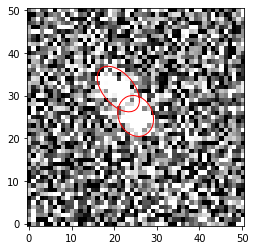

In [71]:
blend_id = np.where(flags == 1)[0][2889]
runner.plot_sex_obj(sep_res[blend_id], blended[blend_id]['galsim_image'][0].array)

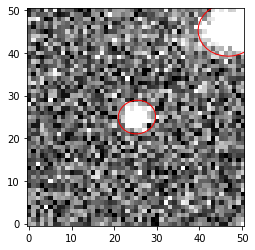

In [87]:
no_blend_id = np.where(flags == 0)[0][1051]
runner.plot_sex_obj(sep_res[no_blend_id], blended[no_blend_id]['galsim_image'][0].array)

# Tests with more simulated data and evolution of Accuracy

# 1. Test SExtractor on 80000 images ($\sigma_{noise} = 0$)

In [72]:
path = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/axel_sims/larger_dataset'

In [73]:
#Getting the images
blended = np.load(path + '/blended/gal_obj_0.npy', allow_pickle=True)
not_blended = np.load(path + '/not_blended/gal_obj_0.npy', allow_pickle=True)

In [74]:
blended.shape

(40000,)

### Run Sextractor

In [238]:
runner = Run_Sep()
flags, sep_res = runner.process(blended)

0.012154878117144108
0.08229422569274902
0.0281013622879982
0.03721855953335762
0.012812202796339989
0.02263309434056282
0.014413510449230671
0.08443529903888702
0.010726393200457096
0.01302763819694519
0.020609959959983826
0.010520704090595245
0.05555165186524391
0.0846809446811676
0.011233238503336906
0.19798104465007782
0.02010168693959713
0.012486107647418976
0.033616822212934494
0.00893294159322977
0.15052369236946106
0.024605294689536095
0.26654353737831116
0.08723413199186325
0.008333642035722733
0.010746232233941555
0.022399554029107094
0.09229418635368347
0.017037635669112206
0.04219120368361473
0.03351147845387459
0.04142194986343384
0.012723760679364204
0.046752315014600754
0.009547093883156776
0.025654291734099388
0.0496978797018528
0.02231399528682232
0.007362285628914833
0.06324691325426102
0.058918923139572144
0.056045204401016235
0.024116085842251778
0.0765523761510849
1.2845230102539062
0.006718221586197615
0.021678144112229347
0.00954571645706892
0.014632470905780792


0.00952776987105608
0.011501031927764416
0.01909252069890499
0.007562392391264439
0.8415860533714294
0.10075128078460693
0.006662419531494379
0.0070581138134002686
0.007046353071928024
0.13023577630519867
0.015398639254271984
0.020969044417142868
0.01391920167952776
0.19358079135417938
0.0045126089826226234
0.13011963665485382
0.026210365816950798
0.029728883877396584
0.009598149918019772
0.01297018863260746
0.026058083400130272
0.03586428239941597
0.02850879542529583
0.1356746405363083
0.1632394790649414
0.24571579694747925
0.19082523882389069
0.015220040455460548
0.010565689764916897
0.034628815948963165
0.013658839277923107
0.018032297492027283
0.01236374955624342
0.05711402744054794
0.1468859165906906
0.01660805568099022
0.025342494249343872
0.020407486706972122
0.17789290845394135
0.07477421313524246
0.010524872690439224
159.8338623046875
0.015316041186451912
0.0996617004275322
0.20652629435062408
0.008907564915716648
0.10451914370059967
0.03772794082760811
0.05775196850299835
0.0

0.010639575310051441
0.27774566411972046
0.009862512350082397
0.03521403670310974
0.40490394830703735
0.008413686417043209
0.03303182125091553
0.04577432572841644
0.0170974712818861
0.02521333284676075
0.019829140976071358
0.022227920591831207
0.03164759278297424
0.07322244346141815
0.008572811260819435
0.012017996981739998
0.022672412917017937
0.14832130074501038
0.0062704309821128845
0.011563709937036037
0.17205694317817688
0.027307327836751938
0.04441502317786217
0.049603238701820374
0.026207584887742996
0.00649108225479722
0.012819078750908375
0.027837300673127174
0.013206835836172104
0.026184557005763054
0.010895943269133568
0.016446487978100777
0.05070943012833595
0.009243758395314217
0.09698081016540527
0.009898764081299305
0.02509523741900921
0.017264196649193764
0.4021701514720917
0.06190003827214241
0.06984534859657288
0.08218026906251907
0.5317968130111694
0.038160569965839386
0.0827183648943901
0.023963356390595436
0.00811969768255949
0.03015574999153614
0.13701322674751282

0.07153449952602386
0.011741476133465767
0.020558156073093414
0.1944425255060196
0.02826777659356594
0.025139477103948593
0.029600689187645912
0.03669358044862747
0.05503182113170624
0.01945672184228897
0.03659530356526375
0.009668304584920406
0.014616183936595917
0.08309022337198257
0.007998421788215637
0.005966297350823879
0.06065807119011879
0.025384416803717613
0.31888383626937866
0.5610968470573425
0.009004623629152775
0.010111748240888119
0.021632233634591103
0.06461865454912186
0.04884953051805496
0.06636299937963486
0.13833919167518616
0.03996323421597481
0.05225116014480591
0.34604135155677795
0.04513297975063324
0.014548643492162228
0.019712254405021667
0.08030971884727478
1.415905237197876
0.01269938237965107
0.06718143075704575
0.023596622049808502
0.03177094832062721
0.11134395003318787
0.01056709885597229
0.011761056259274483
0.06463173776865005
0.052379876375198364
1.562969446182251
0.06653212010860443
0.00954162422567606
0.023421218618750572
0.014274675399065018
0.08530

0.010558757930994034
0.016734084114432335
0.020043913275003433
0.009548727422952652
0.07433866709470749
0.014399552717804909
0.02024935558438301
0.00877170916646719
0.0066216797567903996
0.019773954525589943
0.009110802784562111
0.028195179998874664
0.010672532021999359
0.04485941305756569
0.02352406270802021
0.02594989351928234
0.00949820876121521
0.013447815552353859
0.016716130077838898
0.031412459909915924
0.02094506099820137
0.047321125864982605
0.7836422324180603
0.09480070322751999
0.045552805066108704
0.18924982845783234
0.012768067419528961
0.009176546707749367
0.02638155408203602
6.142181396484375
0.020633960142731667
0.016385970637202263
0.01114083081483841
0.17478974163532257
0.02873627096414566
0.15041865408420563
0.2388589084148407
0.05616472661495209
0.02826317958533764
0.010766251012682915
0.009002355858683586
0.007778702769428492
0.028092993423342705
0.14429563283920288
0.006612991448491812
0.0512939877808094
0.05449356511235237
0.7053266763687134
0.013651149347424507


0.014101860113441944
0.011050716042518616
0.05243482440710068
0.010862513445317745
0.008687881752848625
0.2410668283700943
0.018284251913428307
0.013757595792412758
0.12068969011306763
0.012011419981718063
0.008040251210331917
0.016361698508262634
0.011590439826250076
0.013614946976304054
0.12167169153690338
0.010556818917393684
0.03673112019896507
0.008279661647975445
0.013819792307913303
0.027324967086315155
0.04395070672035217
0.008921666070818901
0.005614511668682098
0.05706724897027016
0.08412545174360275
0.014241864904761314
0.006069349590688944
0.031008390709757805
0.03456484153866768
0.018589932471513748
0.010435986332595348
0.08549511432647705
0.042316559702157974
0.09582101553678513
0.009719460271298885
0.24780678749084473
0.09353812783956528
0.19068419933319092
0.02051430754363537
0.011537077836692333
0.00865205004811287
0.10108204931020737
3.081033706665039
0.03508560732007027
0.013814452104270458
0.016731910407543182
0.8405153155326843
0.04815998300909996
0.419892549514770

0.006896435283124447
0.07002465426921844
0.06238994002342224
0.022964604198932648
0.02761101722717285
0.027525676414370537
0.013299176469445229
0.06920912861824036
0.00716805225238204
0.008340253494679928
0.01862557791173458
1.0
0.025749746710062027
0.00904431939125061
0.015613401308655739
0.011685398407280445
0.030655577778816223
0.032303255051374435
0.11407804489135742
0.16346590220928192
0.037132613360881805
0.032095782458782196
0.015273500233888626
0.03562358021736145
0.03407938405871391
0.00868676882237196
0.029940364882349968
0.08071039617061615
0.012719422578811646
0.015972360968589783
0.008449405431747437
0.04405335336923599
0.20769132673740387
0.010841630399227142
0.019030021503567696
0.01659143902361393
0.009672113694250584
0.01312422938644886
0.006566586438566446
0.12507444620132446
0.00649735564365983
0.013180290348827839
0.015849342569708824
0.041297733783721924
0.012065724469721317
0.014361630193889141
0.013267223723232746
0.011581385508179665
0.039976559579372406
0.01031

0.016864648088812828
0.011121447198092937
0.01490173302590847
0.01419039722532034
0.00632032984867692
0.0677604228258133
0.01232798583805561
0.012401248328387737
0.008899771608412266
0.010445919819176197
0.30194351077079773
0.008005061186850071
0.012994680553674698
0.05572565272450447
0.01125582866370678
0.008345485664904118
0.01130539458245039
0.005442559253424406
0.015500770881772041
0.005057067144662142
0.012811753898859024
0.05177244916558266
0.04888276010751724
0.16996720433235168
0.012047369964420795
0.018032366409897804
0.034988272935152054
0.1528875231742859
0.01759587787091732
0.36139512062072754
0.11846974492073059
0.008804477751255035
0.024011269211769104
0.021620716899633408
0.011591458693146706
0.1505293846130371
0.008042031899094582
0.007982856594026089
0.01149151660501957
0.031026912853121758
0.04540083557367325
0.07852819561958313
1.8144991397857666
0.04290211200714111
0.01512120757251978
0.010546057485044003
3.8107645511627197
0.035593438893556595
0.008088129572570324


0.09641719609498978
0.016047483310103416
0.0125943124294281
0.03462543711066246
0.013282449916005135
0.05304300785064697
0.03597336634993553
0.0069858296774327755
0.016087502241134644
0.016513176262378693
0.03344108164310455
0.036527831107378006
0.20041753351688385
0.008266317658126354
0.011978301219642162
0.021117933094501495
0.03584819659590721
0.047825805842876434
0.007775197271257639
0.5937336087226868
0.04077167436480522
0.014595209620893002
0.03265427425503731
0.009505198337137699
0.039916135370731354
0.009076299145817757
0.011050892993807793
0.007855097763240337
0.013317837379872799
0.02041364274919033
0.009739425033330917
0.018150569871068
0.0779528021812439
0.01214270293712616
0.00800431240350008
0.013192257843911648
0.01184484176337719
0.013138312846422195
0.029650678858160973
0.031299248337745667
0.06336309015750885
0.08681312203407288
0.02170274779200554
0.07201561331748962
0.0119889872148633
0.010618427768349648
0.009365078993141651
0.014014202170073986
0.01507209427654743

0.01766292192041874
0.08470471203327179
0.17257755994796753
0.018876727670431137
0.1309034824371338
0.09996556490659714
0.06854225695133209
0.013154108077287674
0.01161217037588358
0.006745376158505678
0.05001157149672508
0.009758696891367435
0.05192793533205986
0.02676713652908802
0.008929463103413582
0.021316464990377426
0.16214624047279358
0.0160985067486763
0.06872504949569702
0.013858092948794365
0.010273827239871025
0.008630176074802876
0.013105400837957859
0.02031240426003933
0.018589133396744728
0.02282535284757614
0.1979478895664215
0.00910948496311903
0.026179712265729904
0.06657828390598297
0.009628508239984512
0.08536238223314285
0.009985161013901234
0.07365109771490097
0.26321476697921753
0.05392373353242874
0.05067018046975136
0.024270471185445786
0.008422894403338432
0.11916544288396835
0.07017149776220322
0.006433882750570774
0.012857730500400066
0.04356077313423157
0.03648865222930908
0.08513683080673218
0.014206698164343834
0.007993397302925587
0.1113487258553505
0.04

0.03992491960525513
0.04633127525448799
0.013002385385334492
0.020068157464265823
0.040476854890584946
0.015777235850691795
0.012781311757862568
0.03388510271906853
0.010789195075631142
0.023369621485471725
0.027826759964227676
1.0
0.012034928426146507
0.020658863708376884
0.012221858836710453
0.03674494847655296
0.012484057806432247
0.013716517947614193
0.09365037083625793
0.09649113565683365
0.019901296123862267
0.01919124647974968
0.012882410548627377
0.020451262593269348
0.01786653883755207
0.010159164667129517
0.011684400960803032
0.0188234131783247
0.007822548039257526
0.10144467651844025
0.012158116325736046
0.12214411050081253
0.4634611904621124
0.017570868134498596
0.005979880690574646
0.007756264880299568
0.01597760058939457
0.5693314075469971
0.010192419402301311
0.0131364855915308
0.01499996054917574
0.02417515218257904
0.017668886110186577
0.40309634804725647
0.2242545336484909
0.26674893498420715
0.14864590764045715
0.010357759892940521
0.0057648224756121635
0.05508759990

0.20012405514717102
0.22455842792987823
1.1337019205093384
0.08955928683280945
0.0038476670160889626
0.01690683513879776
0.014739950187504292
0.2529648542404175
0.008445486426353455
0.0200977623462677
0.06225686892867088
0.024121293798089027
0.03063507378101349
0.17048387229442596
0.06395969539880753
0.2514324486255646
0.01214934978634119
0.009810110554099083
0.006933773402124643
0.010991746559739113
0.018821759149432182
0.007268412970006466
0.10361694544553757
0.012736831791698933
0.06006699427962303
0.04531145468354225
0.008023317903280258
0.05111544951796532
0.037252817302942276
0.43206891417503357
5.382955551147461
0.034866321831941605
0.006683674640953541
0.029764963313937187
0.026695095002651215
0.10997390747070312
0.013382762670516968
0.01814194768667221
0.0061519332230091095
0.052389778196811676
0.0209975428879261
0.006757162977010012
0.41458165645599365
0.0588630810379982
0.05083053186535835
0.015531822107732296
0.012877575121819973
0.016836408525705338
0.015126185491681099
0.

0.01759793423116207
0.013987586833536625
0.022874869406223297
0.1250576227903366
0.031883083283901215
0.047150809317827225
0.04317641630768776
0.02305051125586033
1.175610899925232
0.013587094843387604
0.006006535608321428
0.008539696224033833
0.0089223338291049
0.029267309233546257
0.008277268148958683
0.008996790274977684
0.02303444966673851
0.04491858929395676
0.0499638207256794
0.005962129216641188
0.04129510000348091
0.012538832612335682
0.7179476022720337
0.042407695204019547
0.013096632435917854
0.0684637799859047
0.09910271316766739
0.004682113416492939
0.03343445807695389
0.0491376556456089
6.017353534698486
0.015486123971641064
0.07528555393218994
0.013948038220405579
0.08827617019414902
0.008850760757923126
0.03212537616491318
0.13081523776054382
0.02163517288863659
0.012082154862582684
0.1097959578037262
0.01243160292506218
1.3617465496063232
0.16386756300926208
0.15251608192920685
0.007468494586646557
0.01364851649850607
0.06683733314275742
0.07208169996738434
0.0237759482

0.05814133584499359
0.01560266874730587
0.007697541266679764
0.22434961795806885
0.014744922518730164
0.023252351209521294
0.009225706569850445
0.38835608959198
0.028901664540171623
0.013050700537860394
0.007261062506586313
0.02461896650493145
0.06430558115243912
0.011779025197029114
0.007553767878562212
0.012205351144075394
0.07910369336605072
0.054466716945171356
0.025771334767341614
0.03799951821565628
0.018367469310760498
0.047448042780160904
0.015612655319273472
0.013220989145338535
0.04969043657183647
0.009137654677033424
0.059094008058309555
0.02711883932352066
0.030077653005719185
0.05852021276950836
0.06492400914430618
0.040652427822351456
0.055333591997623444
0.0074646989814937115
0.11988677084445953
0.20869790017604828
0.23278945684432983
0.029103705659508705
0.28216829895973206
0.013420229777693748
0.049493081867694855
0.05385230854153633
0.05783655866980553
0.01620723307132721
0.013432334177196026
0.9511600136756897
0.009816307574510574
0.006867038086056709
0.0082290787249

0.039353784173727036
0.21946437656879425
0.06156393513083458
0.02822571061551571
0.012282655574381351
0.010552453808486462
3.3897082805633545
0.0372672863304615
0.13763397932052612
0.007038875017315149
0.017371609807014465
0.030295686796307564
0.008381294086575508
0.06646614521741867
0.009442578069865704
0.02307918295264244
0.007084998302161694
0.012883849442005157
0.0424637608230114
0.015077117830514908
0.02945682220160961
0.034656278789043427
0.03824959322810173
0.07749473303556442
1.0682846307754517
1.7775579690933228
0.024686403572559357
0.06204047426581383
0.032424576580524445
0.42266154289245605
0.106734499335289
0.04237771034240723
0.010577008128166199
0.010094711557030678
0.012588188983500004
0.0072219111025333405
0.05108262971043587
0.02817378379404545
0.06691285222768784
0.05760817602276802
0.007563822437077761
0.1369851976633072
0.006436929106712341
0.009440547786653042
0.045153550803661346
0.0290105901658535
0.053891465067863464
0.048978209495544434
0.2553137540817261
0.008

0.3960486054420471
0.04422399774193764
0.009159947745501995
0.025130925700068474
0.01623314432799816
0.21161629259586334
0.021793296560645103
0.044731032103300095
0.008609686978161335
0.04622948542237282
0.14402134716510773
0.10617268830537796
0.02528623305261135
0.08367695659399033
0.008661296218633652
0.013023247011005878
0.08007603883743286
0.019585145637392998
0.0441695861518383
0.019296737387776375
0.03647589311003685
0.024527888745069504
0.020105792209506035
0.010125053115189075
0.006481077987700701
0.009261221624910831
0.006470126565545797
0.01934448815882206
0.12217152118682861
0.008131537586450577
0.08977530151605606
0.04065421596169472
2.491304397583008
3.0360872745513916
0.009720002301037312
0.018162889406085014
0.06555406749248505
0.017947379499673843
0.051190197467803955
0.042164769023656845
0.02569473721086979
0.11079525202512741
0.050180137157440186
0.4491172730922699
0.007123020943254232
0.019733792170882225
0.22729945182800293
0.009275445714592934
0.34855934977531433
0

0.009120025672018528
0.03174034506082535
0.015517393127083778
0.019506307318806648
0.028698043897747993
0.025749558582901955
0.010902361944317818
0.015185091644525528
0.021984627470374107
0.006761673837900162
0.009485216811299324
0.21546900272369385
0.021007224917411804
0.04645729437470436
27.30693817138672
0.01978442445397377
0.011123163625597954
0.030613815411925316
0.07638314366340637
0.026264866814017296
0.08220347762107849
0.03775467723608017
0.01688389852643013
0.2305794060230255
0.023250466212630272
0.013996976427733898
0.014012083411216736
0.019988352432847023
0.026528311893343925
0.009941288270056248
0.010642869397997856
0.6098583340644836
0.052889931946992874
0.06298879534006119
0.012163045816123486
0.023988697677850723
0.01705756038427353
0.00934667233377695
0.03922576829791069
0.053729407489299774
0.01007874310016632
0.054721806198358536
0.13698066771030426
0.03600664436817169
0.02461366541683674
0.02477174811065197
0.011866407468914986
0.007332376670092344
0.00794174056500

0.45317476987838745
0.008813554421067238
0.0709276869893074
0.2252209484577179
0.01965726539492607
0.022895218804478645
0.06665393710136414
0.012207607738673687
5.683879375457764
0.020465288311243057
0.1864941120147705
0.02543758787214756
0.006904598791152239
0.07251858711242676
0.013073784299194813
0.05651060864329338
0.03534846007823944
0.03210237994790077
0.09317880123853683
0.08245647698640823
0.029696933925151825
0.025039425119757652
0.008037646301090717
0.10886538028717041
0.04779483377933502
0.025557925924658775
0.0330885574221611
0.02154485508799553
0.029584812000393867
0.017306655645370483
0.029503656551241875
0.0104458536952734
0.06480120122432709
3.003938674926758
0.19231654703617096
0.02738378196954727
0.010861961171030998
0.011119266040623188
0.017014790326356888
0.04055262729525566
0.21234828233718872
0.019097695127129555
0.013384251855313778
0.0125811155885458
0.02096027135848999
0.020359715446829796
0.008952510543167591
0.008770196698606014
0.009126044809818268
0.030108

0.010296662338078022
0.009253756143152714
0.014174171723425388
0.06890859454870224
0.04288138449192047
0.014166945591568947
0.09620719403028488
0.035478513687849045
0.012665125541388988
0.020955419167876244
0.013280370272696018
0.00567964231595397
0.019198019057512283
0.007551183458417654
0.013221446424722672
0.039671558886766434
0.014552542939782143
0.026902712881565094
0.004729022271931171
0.008279570378363132
0.014522774145007133
0.02544742077589035
0.05640976503491402
0.07735304534435272
0.058548640459775925
0.014741148799657822
0.014239173382520676
0.15682809054851532
0.02837396040558815
0.02403818815946579
0.010532686486840248
0.01741851307451725
0.02146759442985058
0.07708577066659927
0.023252518847584724
0.12335067987442017
0.008516314439475536
0.03302207216620445
0.020029639825224876
0.012411327101290226
0.014227478764951229
0.10841623693704605
0.025692477822303772
0.027492176741361618
0.012667166069149971
0.06763903051614761
0.006648309528827667
0.0334918312728405
0.009379592

0.06774318963289261
0.02435859851539135
0.025107095018029213
0.008519593626260757
0.01349586620926857
0.030078228563070297
4.985728740692139
0.02159533090889454
1.3262420892715454
0.07257532328367233
0.008728107437491417
0.0206342451274395
0.00892946682870388
0.01154156494885683
3.4948060512542725
0.013790184631943703
0.053664278239011765
0.010921474546194077
0.010625206865370274
0.0270692165941
0.038022808730602264
0.01691741868853569
0.11448734253644943
0.018473215401172638
0.06498522311449051
0.2544096112251282
0.1366465836763382
0.00803876481950283
0.02199360728263855
0.027915138751268387
0.007840970531105995
0.009992818348109722
0.037554625421762466
0.020785290747880936
0.0549909733235836
0.05615568161010742
0.009508256800472736
0.013443072326481342
0.004451134707778692
0.025365596637129784
0.12881503999233246
0.02467247098684311
0.014932645484805107
1.3805755376815796
0.035709984600543976
0.015397543087601662
0.03320536017417908
0.01877679117023945
0.02997346967458725
0.027729740

0.020149439573287964
0.01536940410733223
0.012930874712765217
0.19423630833625793
0.009524133987724781
0.01585536263883114
0.012594790197908878
0.010403534397482872
0.1323682814836502
0.01734510436654091
0.0167812742292881
0.010242026299238205
0.02088744193315506
0.01510657649487257
0.011660519987344742
0.03643926605582237
0.008577012456953526
0.014325231313705444
0.0071777417324483395
0.02724836766719818
0.02073531597852707
0.011959729716181755
0.017281582579016685
0.020049408078193665
0.08929575234651566
0.016120849177241325
0.026793058961629868
0.17116421461105347
0.014443985186517239
0.03292199969291687
0.013529845513403416
0.10525758564472198
0.05265378952026367
0.06226470321416855
0.05586269497871399
0.018688660115003586
0.04423673823475838
0.022550329566001892
0.021505361422896385
0.008912804536521435
0.03334427624940872
0.030115913599729538
0.08605579286813736
0.006555173546075821
0.2823261618614197
0.23688693344593048
0.008054384961724281
0.012699540704488754
0.009751050733029

0.014025120995938778
0.016828220337629318
0.021114518865942955
0.25327450037002563
0.03969349339604378
0.021501963958144188
0.18639634549617767
0.040041010826826096
0.24361445009708405
0.010690570808947086
0.07845280319452286
0.008365951478481293
0.0131409652531147
0.02454783022403717
0.025589225813746452
0.09213720262050629
0.0498223640024662
0.0075401244685053825
0.05137299373745918
0.026762526482343674
0.10583005845546722
0.016959641128778458
0.0257789995521307
0.010397188365459442
0.06152447313070297
0.03237226977944374
0.014437247067689896
0.5144334435462952
0.016007546335458755
125.31366729736328
0.014070555567741394
0.08379431813955307
0.008138205856084824
0.013597356155514717
0.06784853339195251
0.007378839887678623
0.014240256510674953
0.05841200426220894
0.06332220882177353
0.015602514147758484
0.20205387473106384
0.008283663541078568
0.030336569994688034
0.016265178099274635
0.0077990759164094925
0.06115160137414932
0.046629324555397034
0.02053457871079445
0.0218425616621971

0.010172510519623756
0.008944978006184101
0.08417428284883499
0.010098667815327644
0.0071128667332232
0.09008318930864334
0.04191412404179573
0.0103861503303051
0.010073421522974968
0.015848491340875626
0.013107270002365112
0.05617048218846321
0.027958711609244347
0.020239099860191345
0.014029541984200478
0.10184521228075027
0.0539933480322361
0.10469521582126617
0.05149409919977188
0.04823373630642891
0.015375838615000248
0.01939992979168892
0.024791846051812172
0.028779080137610435
0.008198950439691544
0.016469301655888557
0.01390522625297308
0.0284784734249115
0.09505338221788406
0.009013745933771133
0.9913159012794495
0.009206212125718594
0.09718523919582367
0.10548443347215652
0.01214488223195076
0.05330326780676842
0.009380597621202469
0.017276214435696602
0.007746030110865831
0.0731622502207756
0.012322804890573025
0.048882465809583664
0.008312548510730267
0.012168980203568935
0.016321366652846336
0.009656528942286968
0.022637929767370224
0.010086149908602238
0.01895906776189804

0.007877076044678688
0.01586761325597763
0.011161760427057743
0.9557011127471924
0.004229696001857519
0.008739021606743336
0.02187253162264824
0.06328926980495453
0.012523061595857143
0.11037744581699371
0.033722441643476486
0.02582905814051628
0.06667507439851761
0.01654718443751335
0.014164205640554428
0.013037176802754402
0.01379382610321045
0.21935409307479858
0.04173898696899414
0.013562961481511593
0.023286011070013046
0.06410378217697144
0.01015153992921114
0.016453148797154427
0.006936826277524233
0.013826931826770306
0.021121913567185402
0.3301669955253601
0.013161076232790947
0.011803188361227512
0.007082294672727585
0.07681462913751602
0.013581405393779278
0.022336052730679512
0.02436758577823639
0.012105806730687618
0.05811019614338875
0.056896183639764786
0.013953057117760181
0.16540902853012085
0.10935116559267044
0.022355595603585243
0.03008180670440197
0.07431040704250336
0.11278025805950165
0.01787189580500126
0.008854924701154232
0.009272944182157516
0.134032949805259

0.010906592942774296
0.1346113383769989
0.00664129201322794
0.01317763701081276
0.009936459362506866
0.05094664916396141
0.0672471672296524
0.011920365504920483
0.012195038609206676
0.15864470601081848
0.020709488540887833
0.05904698371887207
0.011209001764655113
0.07416079938411713
0.008564107120037079
0.014045419171452522
0.5592821836471558
0.012430011294782162
0.0712641179561615
0.020300252363085747
0.01025567576289177
0.8418849110603333
0.04697488993406296
0.028389308601617813
0.0391300730407238
0.00990323442965746
0.017276586964726448
0.007632480934262276
0.4429014325141907
0.008791012689471245
0.09535418450832367
0.01958816684782505
0.02718961238861084
0.21433787047863007
0.012312767095863819
55.42018508911133
0.03302481397986412
0.007478922139853239
0.14646250009536743
0.1962936669588089
0.01125871017575264
0.11178193986415863
0.02237921766936779
0.017922688275575638
0.009817922487854958
0.00935347843915224
0.07679501920938492
0.049700260162353516
0.0772702768445015
0.0070570898

0.054718393832445145
0.00925701018422842
0.0643392875790596
0.015640180557966232
0.05910572409629822
0.021461987867951393
0.30278608202934265
0.13344261050224304
0.09287474304437637
0.09105983376502991
0.014851081185042858
0.049266599118709564
0.011424298398196697
0.04036196321249008
1.6346861124038696
0.011170348152518272
0.009135314263403416
0.014420081861317158
0.01293047796934843
0.02298751473426819
0.16052217781543732
0.046000104397535324
0.03725644573569298
0.022563761100172997
0.03580418601632118
0.17688435316085815
0.009975616820156574
1.3358166217803955
0.034347716718912125
0.04817337542772293
0.017045453190803528
0.02003217302262783
4.178284645080566
0.026884140446782112
0.03553587570786476
0.032283999025821686
0.056349512189626694
0.04855681210756302
0.16867008805274963
0.20495262742042542
0.8908585906028748
0.023242823779582977
0.010096196085214615
0.010491197928786278
0.006362606305629015
0.01114528439939022
0.011275704950094223
0.19592736661434174
0.0874059721827507
0.008

0.009298928081989288
0.02131824567914009
0.013976645655930042
0.01313852146267891
0.005593575537204742
0.013293696567416191
0.013768712058663368
0.007472226396203041
0.016282791271805763
0.024496503174304962
0.00777255417779088
0.008908485993742943
0.043288953602313995
0.04844210669398308
0.1479661762714386
0.01618906669318676
0.006469786167144775
0.2971084713935852
0.12990260124206543
0.014454069547355175
0.014052027836441994
0.004717900417745113
0.03048567846417427
0.007950510829687119
0.04705095291137695
0.008534654043614864
0.013598963618278503
0.07326752692461014
0.008704595267772675
0.05275300145149231
0.02302042581140995
0.0640605241060257
0.02912541665136814
0.010118548758327961
0.08486588299274445
0.6731730699539185
0.014990548603236675
0.04882993549108505
0.04152442887425423
0.02110978402197361
0.02197144739329815
0.007127492222934961
0.013203313574194908
0.034811221063137054
0.6478615999221802
0.016393864527344704
0.1909354329109192
0.0345047265291214
0.054308634251356125
0.

0.037897564470767975
0.2109062373638153
0.012299413792788982
0.08311928808689117
0.021435806527733803
0.21857841312885284
0.015300489962100983
0.06333348900079727
0.011800973676145077
0.009973008185625076
1.0
0.011603976599872112
0.006367798428982496
0.008938048966228962
0.015825053676962852
0.03833148255944252
0.05691636726260185
0.03619420528411865
0.02350122109055519
0.03518595173954964
0.011655498296022415
0.016302989795804024
0.02328609861433506
0.026211392134428024
0.1502135843038559
0.049640387296676636
0.46079742908477783
0.01914367265999317
0.00857417844235897
0.028842967003583908
0.02862193062901497
2.1952507495880127
0.1942976415157318
0.1409880667924881
0.025365667417645454
0.013459226116538048
0.03105699084699154
0.10873641818761826
0.019988615065813065
0.018009744584560394
0.027449939399957657
0.028698597103357315
0.012775838375091553
0.29968932271003723
0.024794520810246468
0.009346181526780128
0.08884092420339584
0.26493966579437256
0.009299550205469131
0.06374470144510

0.029031943529844284
0.02931877411901951
0.028191646561026573
0.008471026085317135
0.01565699651837349
0.048009615391492844
0.01592777483165264
0.010707961395382881
0.04944221302866936
0.0601186640560627
0.09205225855112076
0.010537288151681423
0.26256510615348816
0.05559931695461273
0.2008466124534607
0.005230973474681377
0.1583804190158844
0.01139348279684782
0.022001082077622414
0.06170700117945671
0.012262572534382343
0.009990803897380829
0.006994353141635656
0.014967551454901695
0.0152257876470685
0.012213689275085926
0.02847466431558132
0.6294912099838257
0.008096691220998764
0.024182505905628204
0.02024957910180092
0.009927324019372463
0.022332647815346718
0.008278935216367245
0.007690991275012493
0.006366595160216093
0.010713526979088783
0.01790517568588257
0.43162408471107483
0.006765436846762896
0.024897223338484764
0.015546792186796665
0.03127380087971687
0.1182924211025238
0.6451361179351807
0.009132470935583115
0.0637378990650177
4.977578163146973
0.05782971903681755
0.009

0.030249906703829765
0.0361253097653389
0.0812864676117897
0.013321702368557453
0.016377771273255348
0.04694068431854248
0.039496783167123795
0.07168639451265335
0.020123962312936783
0.018605761229991913
0.015634581446647644
0.11366721987724304
0.020548243075609207
0.016037313267588615
0.0069611030630767345
0.017577817663550377
0.005202713888138533
0.018655968829989433
0.02328142523765564
0.028654776513576508
0.026202216744422913
0.02016325853765011
0.007486976683139801
115.0002670288086
0.01004029344767332
0.023182881996035576
0.04996504262089729
0.011429932899773121
0.011471981182694435
0.011545384302735329
0.012608304619789124
0.011926926672458649
0.005179716274142265
0.02519070729613304
0.4006009101867676
0.0126740001142025
0.01929062232375145
0.025903591886162758
0.027071259915828705
0.2497667372226715
0.23184315860271454
0.013345655053853989
0.014954821206629276
0.36290204524993896
0.011035238392651081
0.008294724859297276
0.04961241036653519
0.014641301706433296
0.01350209489464

0.011457346379756927
0.015475424937903881
0.013204758055508137
0.020463811233639717
0.03601372241973877
0.6907057762145996
0.021454719826579094
0.010394490323960781
0.009494726546108723
0.009486259892582893
0.042263854295015335
0.006968977861106396
0.01206415705382824
0.023680580779910088
0.03107193484902382
0.011912691406905651
0.23223941028118134
0.010311069898307323
0.01416863314807415
0.02510930225253105
0.016791002824902534
0.01171682495623827
0.09804520756006241
0.0724102035164833
0.006907378323376179
0.019836094230413437
0.009455249644815922
0.00768983643501997
0.010179655626416206
0.009232455864548683
0.01592809520661831
0.01583465188741684
0.008262869901955128
0.00431611854583025
0.023536287248134613
0.030884627252817154
0.08147672563791275
0.007425771560519934
0.0426839180290699
0.03960748761892319
0.009639180265367031
0.017518529668450356
0.3587571978569031
0.027650365605950356
0.011929250322282314
0.03037589229643345
0.08882156014442444
0.06202136352658272
0.018612170591950

0.02314595691859722
0.23741810023784637
1.6465539932250977
0.11936771124601364
0.006707090884447098
0.008280185982584953
0.0685892254114151
0.07462286204099655
0.020252497866749763
0.011119941249489784
0.05930807814002037
0.014246530830860138
0.01154941413551569
0.29555290937423706
0.0070994580164551735
0.06671208143234253
0.0622621551156044
0.06843223422765732
0.02498694323003292
0.009847607463598251
0.04456137493252754
0.11990182846784592
0.016602372750639915
0.11764518916606903
0.009567871689796448
0.00982673466205597
0.013577371835708618
0.39475950598716736
1.2073215246200562
0.016847282648086548
0.01554648857563734
0.0121835982427001
0.032029516994953156
0.06971509754657745
0.017376676201820374
0.00918697752058506
0.03367334231734276
0.007955923676490784
0.021807009354233742
0.006416348274797201
0.04654979705810547
0.0042043086141347885
0.01563781499862671
0.00870125088840723
0.053332891315221786
0.029792601242661476
0.009389698505401611
0.011679831892251968
0.13720764219760895
0.

0.01087811216711998
0.010686686262488365
0.018450966104865074
0.025529006496071815
0.9294217824935913
0.012563089840114117
0.10100255161523819
0.05467596277594566
0.007704464253038168
0.025666194036602974
0.018623143434524536
0.02327851951122284
0.4756042957305908
0.04689764603972435
0.15141788125038147
0.08864821493625641
0.010945834219455719
0.01073615625500679
0.08669695258140564
0.03559141606092453
0.019942346960306168
0.008588996715843678
0.017912615090608597
0.018004367128014565
0.009995671920478344
0.019694115966558456
0.056983061134815216
0.015898238867521286
0.008041060529649258
0.017321588471531868
0.024806125089526176
0.00687034334987402
0.011201107874512672
0.14208975434303284
0.016601577401161194
0.030496420338749886
0.2576865553855896
0.016775580123066902
0.011072087101638317
0.01476987823843956
0.021127626299858093
0.009884747676551342
0.011936590075492859
0.012424486689269543
0.017222842201590538
0.005464810878038406
0.016518093645572662
0.05215766653418541
0.0218698382

0.3576340675354004
0.024902332574129105
0.14491380751132965
0.0370364785194397
0.0894354060292244
0.03880970552563667
0.017188576981425285
0.01451569888740778
0.029324639588594437
0.04274320974946022
0.0652695968747139
0.06182597577571869
0.4374268054962158
0.033443622291088104
0.006190729793161154
0.01731998473405838
0.1801854819059372
0.0299147330224514
0.00870678760111332
0.007941888645291328
0.2898073196411133
0.21665427088737488
0.06930805742740631
0.11860892176628113
0.011727659031748772
0.2602823078632355
0.008906019851565361
0.014856153167784214
0.03515516221523285
0.1238580197095871
0.04729653522372246
0.006719233933836222
0.01731632463634014
0.016917157918214798
0.9666838049888611
0.011933134868741035
0.04146849364042282
0.07462757080793381
2.0159358978271484
0.0071343351155519485
0.026890108361840248
0.019139526411890984
0.00857154093682766
6.255580902099609
0.007861114107072353
0.042008448392152786
0.10022583603858948
0.007292064838111401
0.033484578132629395
0.018765347078

0.030893562361598015
0.01388807874172926
0.09731373190879822
0.009228735230863094
0.03376161307096481
0.8237175345420837
0.44849810004234314
0.016668986529111862
0.013883191160857677
0.15534675121307373
0.0077936649322509766
0.009005940519273281
0.011086505837738514
0.058448147028684616
0.014133695513010025
0.08597274869680405
0.01718105748295784
0.010583692230284214
0.027191482484340668
0.023385044187307358
0.020415445789694786
0.027296431362628937
0.0909973755478859
0.006263543386012316
0.01015207264572382
0.012394938617944717
0.021149922162294388
0.042658060789108276
0.0227963887155056
0.07139645516872406
0.23512743413448334
0.02508879266679287
0.015042542479932308
0.13600552082061768
0.04058261960744858
0.08560851961374283
0.03436419367790222
0.03604331612586975
0.015868766233325005
0.03952345252037048
0.004609026480466127
0.007665436714887619
0.01078895851969719
0.013374853879213333
0.015879929065704346
0.017588913440704346
0.013060744851827621
0.2675401568412781
0.009745102375745

0.015987254679203033
0.06225808709859848
0.01891692355275154
0.041959911584854126
0.08452217280864716
0.036473970860242844
0.042461149394512177
0.013899020850658417
0.37398695945739746
0.008271925151348114
0.021146731451153755
0.07088132947683334
0.022024350240826607
0.0433858260512352
0.00713353231549263
0.01981811597943306
0.5711726546287537
0.016915271058678627
0.03600669652223587
0.02767852507531643
0.014259889721870422
0.03609754145145416
0.004457526840269566
0.10394714772701263
0.007756405975669622
0.29577532410621643
0.03781968355178833
0.01277728658169508
0.4513932466506958
0.008522102609276772
0.030078748241066933
0.026923008263111115
0.22400742769241333
0.015504850074648857
0.03605679050087929
0.012477980926632881
0.008286744356155396
0.01571362465620041
0.054916031658649445
0.032855074852705
0.08391130715608597
0.008235775865614414
0.010842193849384785
0.021294357255101204
0.020374316722154617
0.420488178730011
0.0325981006026268
0.04694562032818794
0.02114802785217762
0.022

0.40401145815849304
0.011569848284125328
0.029073623940348625
0.026177383959293365
0.0304702315479517
0.029987042769789696
0.1518165022134781
0.018754998221993446
0.011088302358984947
0.028460340574383736
0.016117123886942863
0.01323287095874548
0.02114800736308098
0.009020684286952019
0.009209713898599148
0.009908193722367287
0.014013497158885002
0.033032454550266266
0.030559031292796135
0.010503576137125492
0.15785685181617737
0.07362613081932068
0.019616251811385155
0.008368227630853653
0.017069943249225616
0.10291800647974014
0.03584374859929085
0.020616767928004265
1.0
0.008982714265584946
0.1727287471294403
0.1467278152704239
2.4869225025177
0.03210088610649109
0.03521842136979103
0.018300484865903854
0.09266356378793716
0.08274160325527191
0.008374941535294056
0.010991857387125492
0.039516303688287735
0.2586551308631897
0.04337618872523308
0.015455727465450764
0.008662663400173187
0.15858308970928192
0.0068911658599972725
0.5334033370018005
0.07009061425924301
0.0073885591700673

0.014738106168806553
0.03748223930597305
0.038699474185705185
0.05533771216869354
0.007088443264365196
0.03705607354640961
0.008876573294401169
0.018468869850039482
0.026012392714619637
0.02026587538421154
0.006870364770293236
0.010331797413527966
0.020568273961544037
0.007487581577152014
0.0272534042596817
0.01218551117926836
0.009901950135827065
0.013929528184235096
0.017880061641335487
0.013603072613477707
0.008859788067638874
0.009263626299798489
0.07243072241544724
0.055627159774303436
0.03614894300699234
0.013705975376069546
0.0190263781696558
0.04966958612203598
0.09043563157320023
0.039774950593709946
0.0060350969433784485
0.01408720575273037
0.008437812328338623
0.011173722334206104
0.039430245757102966
0.009762696921825409
0.050629597157239914
0.010736155323684216
0.0073192305862903595
0.015462774783372879
0.007235135417431593
0.010150344111025333
0.010120091959834099
0.04621005803346634
0.008596275001764297
0.006450585555285215
5.069960594177246
0.08366899192333221
0.0202358

0.028502153232693672
0.011964689940214157
0.012506335973739624
0.006016840226948261
0.006800286937505007
0.007966139353811741
0.09692249447107315
0.010327600874006748
0.009404030628502369
0.01415211707353592
0.008620423264801502
0.021712303161621094
0.16601456701755524
0.020171139389276505
0.017781220376491547
0.09645140916109085
0.04170693829655647
0.3640882670879364
0.019391585141420364
0.46566659212112427
0.02249961346387863
0.027994247153401375
0.014844633638858795
0.2083156257867813
0.024975206702947617
0.03156783804297447
0.07910371571779251
0.025507140904664993
0.009434666484594345
0.007639916148036718
0.04331476613879204
0.024871889501810074
0.06111368536949158
0.5418847799301147
0.02223060466349125
0.025924401357769966
0.08412397652864456
0.010431521572172642
0.023981647565960884
0.30521321296691895
0.05667077377438545
0.011639944277703762
0.07742331176996231
0.013352555222809315
0.015460527502000332
0.028971314430236816
0.305055171251297
0.0099405562505126
0.01304108370095491

0.033300962299108505
0.04517805203795433
0.027207687497138977
0.007344900630414486
0.010535170324146748
0.014455567114055157
0.026214197278022766
0.011620720848441124
0.005704495590180159
0.1057649552822113
0.4661399722099304
0.17839737236499786
0.020479770377278328
0.0481596402823925
0.12784181535243988
0.013748305849730968
0.09026400744915009
0.011958355084061623
0.015653613954782486
0.04854831099510193
0.02238723821938038
0.02223152294754982
0.019018400460481644
0.08793246001005173
0.03071627765893936
0.03472581505775452
0.012825419194996357
0.041060104966163635
0.014896436594426632
0.007002334110438824
0.025839554145932198
0.0463535375893116
0.03221973776817322
0.010524502955377102
0.033664342015981674
42.66566848754883
0.03364848718047142
0.16654174029827118
0.05535249412059784
0.007684560492634773
0.05344041436910629
0.011417674832046032
0.01590602844953537
0.09717371314764023
0.07238508015871048
0.04106054827570915
0.016116557642817497
0.017735080793499947
0.023696646094322205
0

0.009844033978879452
0.01376897469162941
0.4809664785861969
0.020480455830693245
0.013906416483223438
0.01875508949160576
0.019148189574480057
0.16127651929855347
0.012006150558590889
0.005431061610579491
0.008010665886104107
0.06235530227422714
0.07025014609098434
0.017224442213773727
0.011555379256606102
0.08302584290504456
0.012127370573580265
0.019088827073574066
0.03951998054981232
0.02415751852095127
0.011915648356080055
0.2650015950202942
11.479665756225586
0.011992818675935268
0.006497398484498262
0.009191615507006645
0.009910508058965206
0.008942186832427979
0.052991222590208054
0.013246869668364525
0.0699675977230072
0.020561903715133667
0.007527995854616165
0.15957048535346985
0.040008340030908585
0.43398913741111755
0.1803118735551834
0.05100133270025253
0.029625609517097473
0.037317004054784775
0.29070866107940674
1.693871021270752
0.01601487025618553
0.09566503763198853
0.011188752949237823
0.009415769949555397
0.40713316202163696
1.0
0.015523700043559074
0.00751367723569

0.06711757183074951
0.03804092854261398
0.08676784485578537
9.167047500610352
0.008731557056307793
0.9045864939689636
0.03529132530093193
0.008138525299727917
0.015811076387763023
0.015624454244971275
0.021175842732191086
0.01317577250301838
0.9473631381988525
0.01984534040093422
0.024035269394516945
0.0446525476872921
1.657986044883728
0.010309407487511635
0.05003688856959343
0.012920400127768517
0.23757755756378174
0.04321138560771942
0.27720773220062256
0.06505966931581497
0.006601142231374979
0.028351444751024246
0.02475772425532341
0.029683686792850494
0.09556440263986588
0.01432484295219183
0.020157134160399437
0.03562573343515396
0.008655242621898651
0.010812425054609776
0.007998873479664326
0.011415104381740093
0.051873624324798584
0.00932750478386879
0.023074662312865257
0.012441984377801418
0.024469494819641113
0.008450356312096119
0.012289957143366337
0.281875342130661
0.04091252386569977
0.014258649200201035
0.028795791789889336
0.052373334765434265
0.01913062483072281
0.01

0.02627984806895256
0.046020571142435074
0.008907563053071499
0.010697102174162865
0.009594590403139591
0.033354777842760086
0.1397339254617691
0.06338714808225632
0.08490095287561417
5.768224239349365
0.021047597751021385
0.010079799219965935
0.008413589559495449
0.050710733979940414
0.059301335364580154
0.11119180172681808
0.0861823633313179
0.090089812874794
0.15821480751037598
0.48659488558769226
0.054786257445812225
0.015891261398792267
0.06643973290920258
0.0053636920638382435
0.09472966194152832
0.011438505724072456
0.06102646142244339
0.12210310995578766
0.011572624556720257
0.006673652213066816
5.566250324249268
0.012924814596772194
38.947166442871094
0.17144039273262024
0.030488181859254837
0.10579850524663925
0.008482160046696663
0.011816560290753841
0.012782146222889423
0.025517547503113747
0.960080623626709
0.03457879275083542
0.35982343554496765
0.007611729204654694
0.08603231608867645
0.34939607977867126
0.008643626235425472
0.04806170240044594
0.007527056150138378
0.017

0.0069495318457484245
0.00658002495765686
0.03585267812013626
0.015363872982561588
0.009545334614813328
0.03956938907504082
0.009140467271208763
0.061460673809051514
0.05169129744172096
0.024288205429911613
0.6072511672973633
0.020987674593925476
0.02590911276638508
0.14003877341747284
0.11951965093612671
0.016557715833187103
0.033775653690099716
0.01346631906926632
0.06501460075378418
0.02500191517174244
0.014636347070336342
0.010576993227005005
0.03634978458285332
0.1363520622253418
0.013920262455940247
0.013925314880907536
0.008835190907120705
0.02958465740084648
0.006425481755286455
0.03129768371582031
0.06526845693588257
0.0319666862487793
0.1318446546792984
0.014518673531711102
0.015698758885264397
0.014778594486415386
0.034625615924596786
0.03488678112626076
0.04943060129880905
0.263746440410614
0.03009907715022564
0.07336743175983429
0.008330005221068859
0.029702993109822273
0.022147664800286293
0.015078645199537277
0.05130144581198692
0.009559877216815948
0.011655290611088276


0.0241294763982296
0.010148478671908379
0.010504423640668392
0.030149973928928375
0.02020469307899475
0.08540155738592148
0.2451362907886505
0.03913518786430359
0.03464658185839653
0.023375095799565315
0.009971946477890015
0.3592219054698944
0.009406148456037045
0.07709948718547821
0.04150783643126488
0.016828877851366997
0.07381127029657364
0.016622545197606087
0.02698054537177086
0.20369292795658112
0.11359155923128128
6.0799689292907715
0.03857921436429024
0.007980231195688248
0.00949945580214262
0.05656462535262108
1.0
0.01333134900778532
0.008419119752943516
0.0059172287583351135
0.01771446503698826
0.017603643238544464
0.023804889991879463
0.28041180968284607
0.026666982099413872
0.03343278542160988
0.12883616983890533
0.04056110233068466
0.14048439264297485
0.16242055594921112
0.019145656377077103
0.02191833034157753
0.007898916490375996
0.025397278368473053
0.04532606154680252
0.024118203669786453
0.011555190198123455
0.14658856391906738
0.00883628148585558
0.007884322665631771

0.020421715453267097
0.010713241063058376
0.14480440318584442
0.009894604794681072
0.015529726631939411
0.07889411598443985
0.05926894396543503
0.007030553184449673
0.01962399296462536
0.06439219415187836
0.01164040993899107
0.3291553258895874
0.06156453490257263
0.01644645817577839
0.03756781667470932
0.034539565443992615
0.04388699308037758
0.026512397453188896
0.07944758236408234
0.020650018006563187
0.03420610353350639
0.00809610728174448
0.06593530625104904
0.00806537177413702
0.09772787988185883
0.013336185365915298
0.009983623400330544
0.008413424715399742
0.0332682728767395
0.03871527314186096
0.031066298484802246
0.02151743695139885
0.00499682454392314
0.024300694465637207
0.010062675923109055
0.021556934341788292
2.2306206226348877
0.02259146049618721
0.0634501501917839
0.010949610732495785
0.046294063329696655
0.10204946249723434
0.02795560657978058
0.03119637444615364
0.2583150267601013
0.20367568731307983
0.111203633248806
0.07985123991966248
0.01609032414853573
0.01329129

0.014184687286615372
0.007282030303031206
0.03317587450146675
0.08911056816577911
0.021278373897075653
0.020772969350218773
0.006174369249492884
0.03705233708024025
0.009661046788096428
0.014084936119616032
0.05408264324069023
0.02220124751329422
0.05413711443543434
0.0066950577311217785
0.05566393956542015
0.03393102437257767
0.030110327526926994
0.04066001996397972
0.17895999550819397
0.034200869500637054
0.029619600623846054
0.010908453725278378
0.017228825017809868
0.012419425882399082
0.03523900359869003
0.005524992942810059
0.02039215713739395
0.02237125113606453
0.010774172842502594
0.005458229221403599
0.01444766204804182
0.01942996121942997
0.007001708261668682
0.04111137241125107
0.09407376497983932
0.010330461896955967
0.03572206199169159
0.02158151939511299
0.027609460055828094
0.010366031900048256
0.046042777597904205
0.04499722272157669
0.014563567005097866
0.09175368398427963
0.07063867896795273
0.03146607428789139
4.736217975616455
0.01032455824315548
0.1396539509296417

0.016504604369401932
0.07286354899406433
0.023209311068058014
0.035497408360242844
0.015355244278907776
0.01255688164383173
0.00809449888765812
1.9024156332015991
0.005601722281426191
0.06381630152463913
0.4977090656757355
0.04849664494395256
0.013128293678164482
0.024225318804383278
0.15484361350536346
0.04111138731241226
0.04048262536525726
0.009560422971844673
0.006164743565022945
0.5718403458595276
4.599658012390137
0.03174896165728569
0.026322968304157257
0.04037345200777054
0.17897918820381165
0.017367932945489883
0.048058945685625076
0.029262114316225052
0.035480599850416183
0.014412024058401585
1.0
0.014941702596843243
0.021219955757260323
0.01661202497780323
0.010113764554262161
0.052217014133930206
0.014024305157363415
0.21808204054832458
0.01956542208790779
0.026157626882195473
0.01729600317776203
0.015422185882925987
1.0882806777954102
0.27190297842025757
0.05950184166431427
0.011425971984863281
0.12207593023777008
0.006873917765915394
0.015419591218233109
0.011277427896857

0.01245788112282753
0.047806017100811005
0.06381235271692276
0.008479288779199123
0.2287859469652176
0.21455655992031097
0.04673462733626366
0.032857026904821396
0.009859614074230194
0.6196025013923645
0.019300168380141258
0.05239022895693779
0.008823007345199585
0.08607263118028641
0.02319740504026413
0.014946877025067806
0.034162137657403946
0.013708640821278095
0.00934590119868517
0.019382474943995476
0.03236750513315201
0.024703053757548332
0.011240702122449875
0.01660330966114998
0.01683458872139454
0.01793091744184494
0.00849348958581686
0.026348533108830452
0.256783127784729
0.0182024072855711
0.010247920639812946
0.020820675417780876
0.14949335157871246
0.04223564639687538
0.01652236096560955
0.01945667341351509
0.025912052020430565
0.24496756494045258
0.011168043129146099
0.02342885732650757
0.20185205340385437
0.036299604922533035
0.0473005436360836
0.02012726664543152
0.025699103251099586
0.029851611703634262
0.009690280072391033
0.04999883845448494
0.09828899055719376
0.775

0.9932329058647156
0.009555784985423088
0.009100569412112236
0.05972537398338318
0.05756290629506111
0.16979049146175385
0.01866312511265278
0.0073087215423583984
0.017603464424610138
0.06303507834672928
0.015185222029685974
0.0281435064971447
0.013079741969704628
0.008709806017577648
0.009595800191164017
0.10049333423376083
0.02009320631623268
0.03642134740948677
0.058733340352773666
0.015204588882625103
0.014036640524864197
2.7203500270843506
0.019424032419919968
0.022425763309001923
0.020333442836999893
0.012989400885999203
0.0804019421339035
0.08407997339963913
0.010024087503552437
0.05404891446232796
13.773937225341797
0.007684322539716959
0.040101487189531326
0.018458791077136993
0.014592084102332592
0.008374208584427834
0.09075351059436798
0.009388787671923637
0.03200990706682205
0.056164901703596115
0.04608667269349098
0.02469027228653431
0.05425441637635231
0.040485139936208725
0.011454127728939056
0.019195742905139923
2.560590982437134
0.01074643898755312
0.13954269886016846


0.042615167796611786
0.041678402572870255
0.28576040267944336
0.10150017589330673
0.5673419833183289
0.026820525527000427
0.007575748022645712
0.011049848981201649
0.08891895413398743
0.0347096212208271
0.009363017976284027
1.0
0.03712714836001396
0.01132586132735014
0.006663802079856396
0.028881801292300224
0.01491545233875513
0.01617940329015255
0.0162504892796278
0.018318604677915573
0.07878433167934418
0.06505110114812851
0.01496301032602787
0.021292926743626595
0.07255610823631287
0.011071066372096539
0.006217502988874912
0.024446675553917885
0.025120988488197327
0.33670446276664734
0.03198634833097458
0.008853849954903126
0.01598474755883217
0.025001060217618942
0.016690228134393692
0.08509735018014908
0.030965596437454224
0.03666659817099571
0.23665376007556915
0.012227850034832954
0.014767592772841454
0.027958927676081657
0.009979888796806335
0.020964527502655983
0.004937465768307447
0.05009648576378822
0.022090667858719826
1.4075666666030884
0.007763198111206293
0.770920932292

0.10618358850479126
0.0064477697014808655
0.03635204955935478
0.027106570079922676
1.0
0.03327186405658722
0.017115434631705284
0.01314201857894659
0.01275855116546154
0.03569750860333443
0.004637503065168858
0.010500937700271606
0.028398096561431885
0.013777605257928371
0.08188488334417343
0.010244262404739857
0.022266674786806107
0.013069999404251575
0.02875616028904915
0.012086868286132812
0.02290448732674122
0.0289944875985384
0.04299856722354889
0.015121188946068287
0.012582504190504551
0.019114162772893906
0.2460099160671234
0.14534024894237518
0.04775246977806091
0.014919166453182697
0.009181921370327473
0.06797020882368088
0.012814856134355068
0.09371274709701538
0.15560905635356903
0.006640457082539797
0.14413096010684967
0.08440229296684265
0.052546992897987366
0.03439151495695114
0.02434147708117962
0.01437790784984827
0.021129462867975235
0.02128010429441929
0.028448032215237617
0.005956354551017284
0.01656893827021122
0.013889127410948277
0.007469499949365854
0.21217116713

0.07500019669532776
0.01925923116505146
0.031487204134464264
0.03966661915183067
0.02809366025030613
0.00878625363111496
0.04618778079748154
0.011928195133805275
0.043948616832494736
0.016605090349912643
0.04795873537659645
0.00847108568996191
0.016771605238318443
0.048573337495326996
0.052942901849746704
0.024013884365558624
0.11042255908250809
0.03646114841103554
0.012415697798132896
0.007933591492474079
0.018772035837173462
0.01952456682920456
0.010375991463661194
0.006840310525149107
0.05694323778152466
0.037665966898202896
0.008365419693291187
0.5979619026184082
0.006175043061375618
0.017468871548771858
0.014903299510478973
0.019216258078813553
0.032150547951459885
0.012029660865664482
0.059617843478918076
0.03463315963745117
0.12672856450080872
0.00890316441655159
0.039914727210998535
0.033706776797771454
0.02550690621137619
1.026308298110962
0.08222386986017227
0.008850199170410633
0.010427814908325672
0.013442070223391056
0.4875771105289459
0.0077144680544734
0.0116207022219896

0.013087151572108269
8.16154670715332
0.03601566329598427
0.05049283057451248
0.012511461041867733
0.08032964169979095
0.012980470433831215
0.07817259430885315
0.17713993787765503
0.05084139108657837
0.013905382715165615
0.01853095181286335
0.017743434756994247
1.5194411277770996
0.012012233957648277
0.007663486059755087
0.13395076990127563
0.052763063460588455
0.02939390391111374
0.0046261977404356
0.009434550069272518
0.023527592420578003
0.012153618037700653
0.018269330263137817
0.008812827989459038
0.10545910894870758
33.93315887451172
3.635341167449951
0.028886716812849045
0.08141183853149414
0.010395322926342487
0.00888425949960947
0.020431267097592354
0.028755372390151024
0.010916858911514282
0.04528480023145676
0.00631218496710062
0.016377197578549385
0.02757895179092884
0.00814327597618103
0.012720161117613316
0.020338822156190872
0.010184845887124538
0.01969197392463684
0.08635663986206055
0.0385005809366703
0.018906759098172188
0.019644862040877342
0.028560319915413857
38.01

0.011233228258788586
0.09424885362386703
0.04007820412516594
0.017950257286429405
0.07574322074651718
0.02030179463326931
0.013584759086370468
0.02211044915020466
0.027973078191280365
0.04027456417679787
0.03947410732507706
6.32593297958374
0.03176460042595863
0.7073272466659546
0.01005585491657257
0.29071420431137085
0.04784862697124481
0.09808370471000671
0.03270644694566727
0.019870320335030556
0.02110311947762966
0.01565638743340969
0.011332783848047256
0.009724033065140247
0.018584534525871277
0.010162601247429848
0.005754062905907631
0.077903151512146
0.014075011946260929
0.057015158236026764
0.014858116395771503
0.01627131924033165
0.013306379318237305
0.01667928881943226
0.007557149510830641
0.007341229356825352
0.008704181760549545
0.0064904955215752125
0.012677563354372978
0.010890314355492592
0.007628290913999081
0.013997241854667664
0.013734032399952412
0.019079139456152916
0.13394661247730255
0.007734735030680895
0.02644701488316059
0.014159901067614555
0.01833013631403446

0.03017747402191162
0.009415538981556892
1.462640404701233
0.01187062356621027
0.016448386013507843
0.3590560853481293
0.14875657856464386
0.009832716546952724
0.028757061809301376
5.612828254699707
0.011657968163490295
0.10400346666574478
0.030638542026281357
0.025177383795380592
0.08417532593011856
0.01537324395030737
0.5740602016448975
0.1514461785554886
0.012942756526172161
0.020838135853409767
0.01617465168237686
0.02487584576010704
0.03643753007054329
4.0865254402160645
0.035164348781108856
0.01800397038459778
0.014960860833525658
0.030585868284106255
0.026856010779738426
0.01168361958116293
0.05456965044140816
0.010027844458818436
0.010519665665924549
0.1853839010000229
0.016941582784056664
0.09361162781715393
0.1436251699924469
0.047054558992385864
0.03951611369848251
0.010058005340397358
0.017942892387509346
0.005976456217467785
0.011447823606431484
0.010469100438058376
0.01576271653175354
0.039917297661304474
1.6446484327316284
0.020585594698786736
0.02609269879758358
0.01589

0.2401900440454483
0.0075100683607161045
0.26285451650619507
0.01240107137709856
0.01947454735636711
0.01186318602412939
0.012152988463640213
0.009507199749350548
0.014221183955669403
0.33491575717926025
0.010648517869412899
0.023630578070878983
0.018956268206238747
0.5996692180633545
0.9979075789451599
0.008527610450983047
0.0526113323867321
0.029326360672712326
0.023904666304588318
0.27710628509521484
0.03786972910165787
0.05024801567196846
0.011559110134840012
0.020959889516234398
0.01715131290256977
0.46554410457611084
0.008313331753015518
0.011130728758871555
0.011194384656846523
0.06474308669567108
0.3410646915435791
0.027246637269854546
0.030825957655906677
0.015900952741503716
0.01624729298055172
0.11689350754022598
0.010204331018030643
0.009605750441551208
0.01295566838234663
0.031020531430840492
0.007799580693244934
0.13275744020938873
0.010256565175950527
1.1160573959350586
0.008531766943633556
0.07939177006483078
0.00850887130945921
0.01583762839436531
0.007533869706094265


0.006471684668213129
0.033519309014081955
0.014536440372467041
0.34129858016967773
0.08097294718027115
0.010381536558270454
1.017899513244629
0.008871487341821194
0.14337345957756042
0.08548331260681152
0.013763951137661934
0.03239380568265915
0.010701931081712246
0.02490813098847866
0.0194559209048748
0.6112343668937683
0.01057860255241394
0.008492597378790379
0.007437569554895163
0.3583628833293915
0.048523951321840286
0.023240352049469948
0.11293448507785797
0.07221465557813644
0.013142786920070648
0.05604733154177666
0.013998229056596756
0.007147777359932661
0.036447737365961075
0.14500205218791962
0.03665576130151749
0.023210197687149048
0.015845805406570435
0.01801156811416149
0.026286261156201363
0.16824451088905334
0.022071873769164085
0.04575661942362785
0.04917769134044647
0.015879543498158455
0.00858947541564703
0.1501775085926056
0.009353156201541424
0.06564744561910629
0.04997435584664345
0.012021693401038647
0.02422068640589714
0.18928904831409454
0.35916680097579956
0.01

0.021199289709329605
0.007082403637468815
0.020204808562994003
0.11639921367168427
0.014872469007968903
0.011362850666046143
0.023348961025476456
0.016622377559542656
0.02982618287205696
0.07006831467151642
0.02530982904136181
0.006270672660320997
0.015861641615629196
0.013480665162205696
0.02213071845471859
0.011113983578979969
0.03388088941574097
0.010515011847019196
0.16683433949947357
0.009883514605462551
0.04494193568825722
0.026276802644133568
0.008410501293838024
0.009202097542583942
0.008823652751743793
0.06763871014118195
0.017155377194285393
0.047718025743961334
0.015565695241093636
0.00939686968922615
0.06617888063192368
0.02183220162987709
0.1271844059228897
0.3238828182220459
0.03008243627846241
0.010997271165251732
0.01922004111111164
0.02804883010685444
0.3584940731525421
0.04267789423465729
0.037114217877388
0.027202289551496506
0.015069141052663326
2.3940510749816895
0.02018665336072445
0.023660961538553238
0.04572625830769539
0.05817943811416626
3.4160525798797607
0.0

0.015388883650302887
0.03476129472255707
0.017544960603117943
0.008324198424816132
0.012456200085580349
0.015223047696053982
0.04198925197124481
0.00978348683565855
0.0804162323474884
0.03342742100358009
0.01365877129137516
0.007859700359404087
0.10693024843931198
0.00995507463812828
0.015856321901082993
0.12951916456222534
0.03992197662591934
0.006134148687124252
0.03491951897740364
0.026487402617931366
0.2910389304161072
0.07139080762863159
0.010499756783246994
0.021028241142630577
0.006796889007091522
2.664262294769287
0.007311221677809954
0.006270689889788628
0.12106569111347198
0.2974642515182495
0.027286048978567123
0.018483012914657593
0.010149107314646244
0.08522120118141174
0.00607692264020443
0.01253118459135294
0.06721698492765427
0.010792435146868229
0.1904849261045456
0.006399000994861126
0.0439457930624485
0.023871589452028275
0.08148321509361267
2.0332589149475098
0.05777081474661827
0.06087088584899902
0.012934413738548756
0.028881745412945747
1.6104661226272583
0.02188

0.014479809440672398
0.02998453564941883
0.027594739571213722
6.3422441482543945
0.03489194065332413
0.010408461093902588
0.037523768842220306
0.05851322039961815
0.04563891142606735
0.008708561770617962
0.09381604939699173
0.006900033447891474
0.06902583688497543
0.16447143256664276
0.008102614432573318
0.03904755041003227
0.03038383647799492
0.28051695227622986
0.07358121871948242
0.011233341880142689
0.3823810815811157
0.008460168726742268
0.007695920765399933
0.015291805379092693
0.0178306195884943
0.00829395093023777
0.018749022856354713
0.006682069506496191
0.08949305862188339
0.02220005914568901
0.18257705867290497
0.010729261673986912
0.08098524063825607
0.09000925719738007
0.05305284261703491
0.009192867204546928
0.04590152949094772
0.019174350425601006
360.5291748046875
0.008798662573099136
0.07969824969768524
0.015891382470726967
0.0904211550951004
0.2242976427078247
0.00693020923063159
0.018030013889074326
0.02531764842569828
0.01961529813706875
0.023182163015007973
0.01587

0.03606867790222168
0.01434342097491026
0.007519481237977743
0.03362230956554413
0.01974223181605339
0.05522741749882698
0.021183954551815987
0.024778053164482117
0.00945234578102827
0.013029825873672962
0.01202290877699852
0.3742920458316803
0.019438717514276505
0.014314466156065464
1.1558544635772705
0.02914574183523655
0.010437583550810814
0.01479930430650711
0.07390400022268295
0.00807643961161375
0.01876470074057579
0.04678017646074295
0.06008215248584747
0.08347424864768982
0.07138102501630783
0.0536210797727108
0.017484555020928383
1.5093519687652588
0.030571946874260902
0.06658544391393661
0.004060826264321804
0.02173718623816967
0.028424827381968498
0.013475380837917328
0.010090825147926807
1.0
0.05908318608999252
0.013990473933517933
0.00999207329005003
0.011988955549895763
0.015359105542302132
0.04031112790107727
0.018449703231453896
0.01519727148115635
0.013714970089495182
0.007678086403757334
0.024760855361819267
0.22506770491600037
0.019616516306996346
0.01752782054245472

0.007138016168028116
0.04269302263855934
0.01760612241923809
0.03598912060260773
0.05791979283094406
0.012953090481460094
0.017901865765452385
0.013073304668068886
0.20727850496768951
0.024040462449193
0.022055573761463165
0.019695915281772614
0.011756152845919132
0.04280265420675278
0.008889750577509403
0.010425264947116375
0.013335307128727436
0.017283447086811066
0.044737253338098526
0.008441026322543621
0.22928409278392792
0.1869686245918274
0.0320415161550045
0.014674955047667027
0.20720936357975006
0.01948993094265461
0.029932234436273575
0.03766707330942154
0.01663564145565033
0.07524527609348297
0.016876941546797752
0.07815343886613846
0.022841790691018105
0.12445898354053497
0.006830455269664526
0.010705249384045601
0.01079189870506525
0.06269875913858414
0.007465213071554899
0.011850258335471153
0.015472622588276863
0.08566678315401077
0.008715100586414337
1.0
0.078580841422081
0.01627183146774769
0.009354372508823872
0.021199515089392662
0.027332976460456848
0.02089503034949

0.006832935847342014
0.019110608845949173
0.016887947916984558
0.018092576414346695
0.010041072964668274
0.014122329652309418
5.238293170928955
0.01543437596410513
0.01320882048457861
0.01856359839439392
0.011196689680218697
1.5291354656219482
25.767940521240234
0.013756058178842068
0.030826197937130928
0.006060017738491297
0.058889325708150864
0.014746067114174366
0.01171400211751461
0.02373872511088848
0.015726754441857338
0.022273041307926178
0.04393875598907471
0.006630090530961752
0.3132757544517517
0.0072512077167630196
0.08928003907203674
0.016871050000190735
0.009271026588976383
0.15502101182937622
0.014547006227076054
0.036183375865221024
0.06149544566869736
0.07968669384717941
0.11161883920431137
0.009587660431861877
0.5830137729644775
0.00859343446791172
0.05860697478055954
0.6779264807701111
0.02260895073413849
0.12050458788871765
0.015084052458405495
0.04810812324285507
0.029285544529557228
0.034873489290475845
0.01694825477898121
0.023689066991209984
0.04580218717455864
0

0.017833655700087547
0.00840113963931799
0.012124701403081417
0.03827792778611183
0.0172142144292593
0.019382260739803314
0.015324670821428299
0.015564121305942535
0.019264593720436096
0.008764508180320263
0.10330559313297272
0.010546031408011913
0.007988885045051575
0.17561018466949463
0.016690343618392944
0.009654219262301922
0.2845352292060852
0.008969784714281559
0.010453024879097939
0.007248617708683014
0.2422419935464859
0.0165336225181818
0.019443955272436142
0.01681058667600155
0.007569207809865475
0.28104227781295776
0.07354177534580231
0.04359745979309082
0.017670005559921265
0.03971080109477043
0.0772770568728447
0.04320789501070976
0.010724611580371857
0.011068472638726234
0.00811100285500288
0.010015170089900494
0.10005826503038406
0.012538406997919083
0.014623931609094143
0.00909525528550148
0.17500758171081543
0.07104863971471786
0.013345688581466675
0.15588171780109406
0.010233397595584393
0.12293864786624908
0.009134615771472454
0.011615361087024212
0.01672597229480743

0.010061169043183327
0.039865102618932724
0.03747131675481796
0.05872992426156998
0.023340696468949318
0.040581367909908295
0.057566314935684204
0.059759240597486496
0.01691639982163906
0.04336106777191162
0.02323978580534458
0.1102963536977768
0.019042637199163437
0.010301588103175163
0.08980715274810791
0.017495615407824516
0.013264153152704239
0.01143933180719614
0.06001193821430206
0.01339305192232132
0.012518282048404217
0.2369464486837387
0.18074217438697815
0.025917772203683853
0.02363632805645466
0.011981906369328499
0.023779017850756645
0.0370044969022274
0.011699765920639038
0.10233236104249954
0.0485365092754364
18.38699722290039
0.011769144795835018
0.006741515826433897
0.01699456013739109
0.05925419554114342
0.019753925502300262
1.5244920253753662
0.009160934947431087
0.6521093845367432
0.010714054107666016
0.0077697583474218845
1.0
0.005329663399606943
0.25915130972862244
0.024159956723451614
0.026381108909845352
0.033820740878582
0.008883478119969368
0.01301551889628172


0.025009989738464355
0.0154649643227458
1.5307573080062866
0.04013841971755028
0.018917448818683624
0.08540881425142288
0.023224733769893646
0.043216656893491745
0.0677279606461525
0.017225362360477448
0.019716821610927582
0.02379041723906994
0.034564170986413956
0.050287168473005295
0.050118863582611084
0.1568147838115692
0.009724372066557407
0.018118279054760933
0.015817223116755486
0.03656742349267006
0.022097205743193626
0.00841935258358717
0.02741134911775589
0.004891157615929842
0.0294036865234375
0.013843235559761524
0.029054248705506325
0.131516695022583
0.020191634073853493
0.09787286818027496
0.05138947069644928
0.29779499769210815
0.05626320466399193
0.009015747345983982
0.013224178925156593
0.02338326722383499
0.010126051492989063
0.006535106338560581
0.014958290383219719
0.06900537014007568
0.015822531655430794
0.00912837591022253
0.015017032623291016
0.02281886525452137
0.07805430144071579
0.014764051884412766
0.012113054282963276
0.010503017343580723
0.007286424282938242

0.024112902581691742
0.011284632608294487
0.0610375851392746
0.011885153129696846
0.05548454821109772
0.13631826639175415
0.02337179332971573
0.042074475437402725
0.3397935628890991
0.017058726400136948
0.0528251975774765
0.08979814499616623
0.19703082740306854
0.04687516391277313
0.03616775944828987
0.01372364442795515
0.034957535564899445
0.024897590279579163
0.03640510141849518
0.02314714901149273
0.2213316410779953
0.025532469153404236
0.011731360107660294
0.3396139442920685
0.019319748505949974
0.020997313782572746
0.02752099372446537
0.06343656778335571
0.00854963343590498
0.02962249517440796
0.06156948208808899
0.021188385784626007
0.021206403151154518
0.045821670442819595
0.013870205730199814
0.03008844330906868
0.009371303021907806
0.01788167655467987
0.13152457773685455
0.03763355314731598
0.07434838265180588
0.053535692393779755
0.009725947864353657
0.04047857224941254
0.061475370079278946
0.025794826447963715
0.039040956646203995
0.011890850961208344
0.0383138582110405
0.01

0.054340705275535583
0.007261547725647688
0.05371179059147835
0.008624267764389515
0.025339379906654358
0.6925255656242371
0.0408991277217865
0.017293360084295273
0.019501153379678726
0.02144395187497139
0.06613519787788391
0.010683475993573666
0.033908165991306305
0.2173885852098465
0.019088400527834892
1.1941008567810059
0.07857995480298996
0.008415671065449715
0.05063386261463165
0.38293352723121643
0.01043773628771305
0.022360721603035927
0.011739716865122318
0.01154405903071165
0.014189992100000381
0.017530951648950577
0.016450941562652588
0.05197146162390709
0.007940826006233692
0.12907564640045166
0.012734908610582352
0.012289394624531269
0.027952974662184715
0.09039261192083359
0.03349451720714569
0.05862163379788399
0.06595654040575027
0.04570576921105385
0.014776475727558136
0.0185590460896492
0.08537869155406952
0.0064658066257834435
0.04223738983273506
1.0
0.20612168312072754
0.014752927236258984
0.02723335660994053
0.019950183108448982
0.009626636281609535
0.00654926989227

0.03185723349452019
0.01013862807303667
0.01103013101965189
0.012237478978931904
0.5505051612854004
0.03569146245718002
0.01319583784788847
0.07542294263839722
0.08914800733327866
0.015089417807757854
0.05068008229136467
0.04437845200300217
0.006723478902131319
0.08121035993099213
0.024519359692931175
0.013060728088021278
0.05541224777698517
0.19054825603961945
0.01572064310312271
0.031169850379228592
0.022475261241197586
0.0133930379524827
0.1534738689661026
0.011046011932194233
0.08210648596286774
0.0054618120193481445
0.006504921242594719
0.09048580378293991
0.007170499302446842
0.03818495199084282
0.49636101722717285
0.014744646847248077
0.009518197737634182
0.038544636219739914
0.039744503796100616
0.05575956404209137
0.054034989327192307
0.0749145895242691
0.008771647699177265
0.003173555014654994
0.015982409939169884
0.03114442154765129
0.03169212490320206
0.010950833559036255
0.006711062975227833
0.02676433138549328
0.0233085285872221
0.008598440326750278
0.014268219470977783
0

0.010832599364221096
0.03447563946247101
0.014949088916182518
0.024728165939450264
0.024733902886509895
0.01497096847742796
0.679548978805542
0.02132928930222988
0.05257758870720863
0.10410157591104507
0.015141276642680168
0.015670297667384148
0.13607004284858704
0.046195853501558304
0.024692509323358536
0.035792794078588486
0.01299015898257494
0.03444508835673332
0.02560362219810486
0.012997522950172424
0.027251631021499634
0.0057520195841789246
0.06546034663915634
0.07444128394126892
0.19140742719173431
0.02595668099820614
0.006546582095324993
0.008792782202363014
0.19101954996585846
0.010187315754592419
0.01527436077594757
0.030372055247426033
0.03093874268233776
0.008858350105583668
0.05254167690873146
0.014033245854079723
0.3698238134384155
0.03295118361711502
0.007342990022152662
1.0
0.015966445207595825
0.03648502379655838
0.2699860632419586
0.0377846397459507
0.01542672235518694
0.011064399965107441
0.08586492389440536
0.012001829221844673
0.020095452666282654
0.011701510287821

0.06867054849863052
0.024149417877197266
0.01497016940265894
0.026431629434227943
0.020490767434239388
1.381066083908081
0.04647618532180786
0.010010975413024426
113.76656341552734
0.03227898105978966
0.007592563983052969
0.0296720489859581
0.061145808547735214
0.02501651458442211
0.043444402515888214
0.039233576506376266
0.10691101104021072
0.10263571888208389
0.01711701974272728
0.0151526415720582
0.015355848707258701
0.012693742290139198
0.31431707739830017
0.027524378150701523
0.015709945932030678
0.016974681988358498
0.010488966479897499
0.08547040075063705
0.040490590035915375
0.08564330637454987
0.08233646303415298
0.02313830889761448
0.26286035776138306
0.07509970664978027
0.07413300126791
0.02279372327029705
0.005068765953183174
0.006339326500892639
0.03864677995443344
1.0
0.006378083489835262
0.009016632102429867
0.011734194122254848
1.1760752201080322
1.0
0.271879643201828
0.024855107069015503
0.017120907083153725
0.06751640141010284
0.04257206618785858
0.3038758933544159
0.

0.08081822097301483
0.005520204082131386
0.022864630445837975
0.008931191638112068
0.050382066518068314
0.011370926164090633
0.020255619660019875
0.02172050252556801
0.0063059949316084385
0.39595574140548706
0.055771954357624054
0.012569430284202099
0.03961433842778206
0.008014929480850697
0.21240659058094025
0.007258926518261433
0.12752969563007355
0.026810472831130028
0.02731645479798317
0.011587736196815968
0.005037881433963776
0.060256753116846085
0.14441129565238953
0.009520433843135834
0.011794130317866802
0.11106967180967331
0.013496086932718754
0.06295613199472427
0.02420751564204693
0.020229797810316086
0.09244397282600403
0.076132632791996
0.01221616379916668
0.012780195102095604
0.013663030229508877
0.30476099252700806
0.015354222618043423
4.447285175323486
0.008511892519891262
0.009054048918187618
0.030647296458482742
0.01113708596676588
0.09382309019565582
0.01109093613922596
0.008117392659187317
0.012447092682123184
0.04530584067106247
0.011142557486891747
0.0084773153066

0.15188057720661163
0.06084601953625679
0.011605905368924141
0.012928054668009281
0.02341476082801819
0.007621633820235729
0.011734499596059322
0.012882723473012447
0.029550453647971153
0.008279942907392979
0.25097256898880005
0.02177176997065544
0.008461719378829002
0.016005273908376694
0.01938135176897049
0.018141290172934532
0.016343560069799423
0.01224578358232975
0.03042394481599331
0.06010649725794792
4.511283874511719
0.12648175656795502
0.009893771260976791
0.007129788864403963
0.020245177671313286
0.015742558985948563
0.07271768897771835
0.006912860553711653
0.008418099954724312
0.020102886483073235
0.0516602098941803
0.013601534068584442
0.015752775594592094
0.012728204019367695
0.05769830942153931
0.009050617925822735
0.02312573976814747
0.06890338659286499
0.030705247074365616
1.45279061794281
0.019772160798311234
0.005905807018280029
0.008522002026438713
0.006786813959479332
0.018074406310915947
0.04558410868048668
0.0553879551589489
0.01680508628487587
0.02698859386146068

0.008968939073383808
0.03489327058196068
0.009937448427081108
0.023516058921813965
3.231062412261963
0.032757051289081573
0.017223400995135307
0.03284880518913269
0.014117671176791191
0.0491814948618412
0.028312793001532555
0.15599484741687775
0.009376869536936283
0.020013421773910522
0.00824686884880066
0.02111312747001648
0.008652969263494015
0.0734790489077568
0.029634058475494385
0.024439353495836258
0.2873876392841339
0.0402800515294075
0.014050686731934547
0.12425193935632706
0.10436248034238815
0.007801576983183622
0.016458380967378616
0.034283850342035294
0.06764733046293259
0.03831622377038002
0.024292273446917534
0.03186299279332161
0.07465130090713501
0.01623127982020378
0.03605807200074196
0.014025310985744
0.5073885321617126
0.07570994645357132
0.056437745690345764
0.008032192476093769
0.01682981289923191
0.0624832957983017
0.04974351450800896
0.060904961079359055
0.0338437482714653
0.05472169443964958
0.018831713125109673
0.0042982702143490314
1.0058224201202393
0.0280584

5.097864151000977
0.01596680097281933
0.007797684986144304
0.006162184756249189
0.03686637058854103
0.014681071974337101
0.009638297371566296
0.009387033991515636
0.019040172919631004
0.0371963307261467
1.9618195295333862
0.20698587596416473
0.023666422814130783
0.039584800601005554
1.0718907117843628
0.19113804399967194
0.02062339335680008
0.06840693950653076
0.06907487660646439
0.010382202453911304
0.008142916485667229
0.09008170664310455
0.005701825022697449
0.023658832535147667
0.01683530956506729
0.023336436599493027
0.01426148135215044
0.014649424701929092
0.06597493588924408
0.01161868404597044
0.046286050230264664
1.996767282485962
0.14660347998142242
0.02477927692234516
0.015246137976646423
0.011492189951241016
0.03526506572961807
0.027441108599305153
0.009967614896595478
0.02957995980978012
0.00952890980988741
0.07957608252763748
0.07759170979261398
0.012221287935972214
0.007287060841917992
0.1436321884393692
0.027221964672207832
0.008960372768342495
0.01279718242585659
0.020

0.008411047980189323
0.04528447985649109
0.018389174714684486
0.08391312509775162
0.02076665312051773
0.023879440501332283
0.0038351991679519415
0.018589623272418976
0.21031856536865234
0.03630959615111351
0.009006740525364876
0.09607072174549103
0.038989998400211334
0.01597439870238304
0.02479676343500614
0.009416005574166775
0.010145844891667366
0.026670802384614944
0.011685607954859734
0.05406597629189491
3.2712106704711914
0.05489939823746681
0.013265760615468025
0.027611831203103065
0.009267051704227924
0.01686267927289009
0.049947671592235565
0.12925834953784943
0.10226766765117645
0.08488582074642181
0.026285642758011818
0.017872413620352745
0.07522542774677277
0.07695189118385315
0.012421759776771069
0.015815990045666695
0.09957925230264664
0.03915062174201012
0.008034992963075638
0.21662330627441406
0.009946170262992382
0.03149673342704773
0.014685189351439476
0.007897533476352692
0.00868686381727457
0.010586267337203026
0.1774076521396637
0.02034488506615162
0.089009739458560

0.01239127479493618
0.02245987579226494
0.006492757238447666
0.02905580960214138
0.015707027167081833
0.017587823793292046
0.015683166682720184
0.02149393782019615
0.020846465602517128
0.04284583404660225
0.010008403100073338
0.4583549499511719
0.0126151442527771
0.010914856567978859
0.00863742921501398
0.054166268557310104
0.008566375821828842
0.4302765130996704
3.8694632053375244
0.0064886645413935184
0.006284684874117374
0.03309796005487442
0.11029417812824249
0.02115151286125183
0.22643378376960754
0.00798705592751503
0.06860177963972092
0.03476899117231369
0.030639946460723877
0.10856013000011444
0.5470472574234009
0.09081483632326126
0.058017946779727936
0.008221948519349098
0.013610146008431911
0.0392754040658474
0.02987462654709816
0.027604931965470314
0.009474199265241623
0.012507528066635132
0.015574374236166477
0.02357013151049614
8.129669189453125
0.03152618184685707
0.07623329758644104
0.011859974823892117
0.024705961346626282
0.023441016674041748
0.1448308378458023
0.0263

0.013007592409849167
0.05009893700480461
0.014524301514029503
0.03004724718630314
0.02540821209549904
0.026363825425505638
0.015109504573047161
0.0062662772834300995
0.010105982422828674
0.016934245824813843
0.1475198119878769
0.0057476116344332695
0.01631675846874714
31.178436279296875
0.028023339807987213
0.007304069586098194
0.008212470449507236
0.15623940527439117
0.03717933967709541
0.01030083280056715
0.043192531913518906
0.01494131051003933
0.015613725408911705
0.009874184615910053
0.009739871136844158
0.07320645451545715
0.009167828597128391
0.006133622489869595
0.020881609991192818
0.010677549056708813
0.01520000770688057
0.01907656155526638
0.16320843994617462
0.025481801480054855
0.037368692457675934
0.19716714322566986
0.031247515231370926
0.011131014674901962
0.02943844348192215
0.3676649332046509
0.012802539393305779
0.03692055121064186
0.012146883644163609
0.03258877247571945
0.010722463950514793
0.00832925271242857
0.029152531176805496
0.010085309855639935
0.14484441280

0.011762307956814766
0.007820794358849525
0.17661553621292114
1.0
0.01014076080173254
0.03650951012969017
0.00734074879437685
0.05305825173854828
0.011571199633181095
0.008330060169100761
0.08903061598539352
0.020018648356199265
0.07072211802005768
0.2387024462223053
0.0283220075070858
0.29032644629478455
0.029814770445227623
0.03606472909450531
0.011992902494966984
0.07510802894830704
0.016721026971936226
0.013976583257317543
0.12970158457756042
0.03959077596664429
0.014183593913912773
0.017131900414824486
0.7470490336418152
0.04697050154209137
0.33500030636787415
0.08751629292964935
0.051678601652383804
0.014121714048087597
0.021689090877771378
0.007216672413051128
0.10399921238422394
0.012662583962082863
0.022423939779400826
0.6502352952957153
0.0157405324280262
0.007990791462361813
0.008130749687552452
0.1313023716211319
0.007131353486329317
0.03254666179418564
13.780949592590332
0.029302723705768585
0.006314420141279697
0.05335782468318939
0.00963427871465683
0.0783347636461258
0.

0.025068266317248344
0.023243803530931473
0.01725546084344387
0.168832927942276
0.037101276218891144
0.021627970039844513
0.03049539402127266
0.023673968389630318
0.026869812980294228
0.05410993471741676
0.009365188889205456
0.039468951523303986
0.0292144063860178
0.008146842941641808
0.012666666880249977
0.09187112003564835
0.01029222458600998
0.00698046013712883
0.18179276585578918
0.026133421808481216
0.09766992926597595
0.01730211451649666
0.11459222435951233
0.005101201590150595
0.07573039829730988
0.03325376659631729
0.07902826368808746
0.008280898444354534
0.08759009838104248
0.007470212876796722
0.02095322497189045
0.012443148531019688
0.018446000292897224
0.00991983525454998
0.1155824139714241
0.05581760033965111
0.014187677763402462
0.13166074454784393
0.011778855696320534
0.03152643144130707
0.012133675627410412
0.4261922240257263
0.007613680325448513
0.11761452257633209
0.02736200951039791
0.013186348602175713
0.055122293531894684
0.0018594254506751895
0.007784411311149597


0.013081631623208523
0.014159313403069973
0.06504029780626297
0.03600168228149414
0.24543240666389465
0.26774829626083374
0.014651828445494175
0.07176800817251205
0.041049983352422714
0.005089379847049713
0.020697396248579025
0.05958187207579613
0.0090842479839921
0.016817854717373848
0.010361602529883385
0.2114083170890808
0.018052225932478905
0.10004408657550812
0.007511219009757042
0.010251279920339584
0.006298101972788572
0.009983488358557224
0.0263157207518816
0.02803177572786808
0.008409113623201847
0.0070468890480697155
0.008497407659888268
0.010896016843616962
0.449596107006073
0.058251287788152695
0.010067257098853588
0.016867848113179207
0.013303938321769238
0.03839610517024994
0.011120857670903206
0.04840904846787453
0.009225638583302498
0.033240288496017456
0.060312896966934204
0.059786807745695114
0.027912696823477745
0.02176334336400032
0.009693978354334831
0.5438293218612671
0.7387452125549316
0.08116699755191803
0.01580902375280857
0.06961677968502045
0.0095496848225593

0.012236897833645344
5.766016483306885
0.5706042647361755
0.009216859936714172
0.030221138149499893
0.008249270729720592
0.014813940972089767
0.021699238568544388
0.10394524782896042
0.06794814020395279
0.041427623480558395
0.05497042462229729
0.04129042848944664
0.03778636455535889
0.010329930111765862
0.024724626913666725
0.15153181552886963
0.013526199385523796
0.012155687436461449
0.01866757497191429
0.010484765283763409
0.03535027801990509
0.22914156317710876
0.007847914472222328
0.13089674711227417
0.030354440212249756
0.01434274297207594
0.08920249342918396
0.011694085784256458
0.022762449458241463
0.03264898434281349
0.017389267683029175
0.3192383944988251
0.03139476105570793
0.024269137531518936
0.06519454717636108
0.0032450659200549126
0.028329133987426758
0.07558326423168182
0.6196504235267639
0.04561872035264969
0.1428331583738327
0.008990027941763401
0.007541180122643709
0.014317466877400875
0.015156514011323452
0.010390198789536953
0.0342286080121994
0.02000041864812374
0

0.010984743013978004
0.02634270116686821
0.014903971925377846
0.022037561982870102
0.006928759627044201
0.00964412372559309
0.04437654837965965
2.627525568008423
0.011116587556898594
0.09549975395202637
0.10129107534885406
0.5322518944740295
0.3111964762210846
0.015045621432363987
0.033888738602399826
0.04628990590572357
0.0342961922287941
0.019905097782611847
0.026630792766809464
0.2972707152366638
0.01325166318565607
0.05455229431390762
0.011623628437519073
0.02956324629485607
0.008057965897023678
0.02688477747142315
0.0080698998644948
0.027030838653445244
142.8287811279297
0.9944044947624207
0.007475944701582193
0.019345397129654884
0.00561484694480896
0.008726397529244423
0.022727353498339653
0.014801811426877975
0.023168161511421204
0.01982688345015049
136.09451293945312
0.023436181247234344
0.014640802517533302
0.026816274970769882
0.03701941296458244
0.01609589345753193
0.01154786255210638
0.027448298409581184
0.45712074637413025
94.08242797851562
0.029548410326242447
0.02616471

0.018952812999486923
0.025178387761116028
0.011171221733093262
0.06147559732198715
0.008481028489768505
0.015691690146923065
0.014347330667078495
0.012902580201625824
0.010698633268475533
0.05795624107122421
0.03884154558181763
0.015689266845583916
0.02033085748553276
0.020030200481414795
0.021334534510970116
0.014613181352615356
0.007389958947896957
0.01658404804766178
0.016742706298828125
0.027058295905590057
0.6840912699699402
0.01621093787252903
0.017830850556492805
0.01689290627837181
0.1178629994392395
0.015622224658727646
0.18213601410388947
0.008350390009582043
0.01747637614607811
0.010819398798048496
0.008256022818386555
0.0851828083395958
0.021344933658838272
0.12535692751407623
0.06974843889474869
0.00907325278967619
0.03946138173341751
0.051649872213602066
0.10274417698383331
0.008572631515562534
0.00595096405595541
0.0656743273139
0.0888223722577095
0.021824868395924568
0.056809257715940475
0.009942946955561638
0.051751889288425446
0.019461488351225853
2.6252028942108154
0

In [240]:
n_blend = len(np.where(flags == 1)[0])/len(flags)
n_noblend = len(np.where(flags == 0)[0])/len(flags)
n_miss = len(np.where(flags == 16)[0])/len(flags)

print('Blend accuracy : {:.2f}%'.format(n_blend*100))
print('Blend missed : {:.2f}%'.format(n_noblend*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss*100))

Blend accuracy : 89.24%
Blend missed : 10.76%
Wrongly identify (false positives): 0.00%


#### We obtain an accuracy of `89.24% ` on blended images.

### Visualizing blend identification

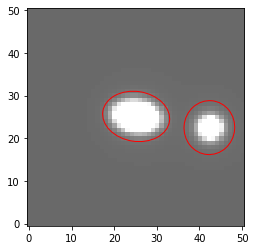

In [77]:
blend_id = np.where(flags == 1)[0][28]
runner.plot_sex_obj(sep_res[blend_id], blended[blend_id]['galsim_image'][0].array)

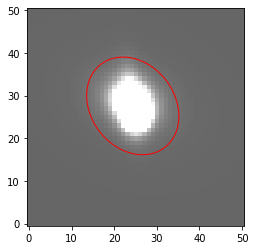

In [78]:
no_blend_id = np.where(flags == 0)[0][4]
runner.plot_sex_obj(sep_res[no_blend_id], blended[no_blend_id]['galsim_image'][0].array)

# 2. Test SExtractor on 80000 images ($\sigma_{noise} = 5$)

In [241]:
path5 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_5'

In [242]:
#Getting the images
blended_5 = np.load(path5 + '/blended_noisy.npy', allow_pickle=True)
blended_5.shape

(40000,)

### Run Sextractor

In [257]:
runner5 = Run_Sep()
flags5, sep_res5 = runner5.process(blended_5)

5.214006423950195
6.005223274230957
5.346005439758301
5.255059719085693
5.275279998779297
5.053668022155762
5.077456951141357
5.503607273101807
5.2946319580078125
4.886172771453857
5.578285217285156
5.097548007965088
5.246944904327393
5.567071914672852
5.089857578277588
5.880972862243652
5.24083948135376
5.3309736251831055
5.280755043029785
5.092384338378906
5.501445293426514
5.153573036193848
5.319421291351318
5.517675876617432
5.194501876831055
5.1003828048706055
5.135109901428223
5.338938236236572
5.223037242889404
5.2762064933776855
5.088590145111084
5.327768325805664
5.230207443237305
5.172003269195557
5.131175994873047
5.3881306648254395
5.2935614585876465
5.113868713378906
5.016781806945801
5.369140148162842
5.440147876739502
5.104902744293213
5.296142578125
5.430187702178955
6.80491304397583
5.095381736755371
5.331974029541016
5.223587512969971
5.04131555557251
5.1267194747924805
5.151366710662842
5.150240898132324
8.32497501373291
5.36295223236084
6.547628879547119
5.702135562

5.123540878295898
5.371848106384277
5.661926746368408
5.28774356842041
5.109529972076416
5.153660297393799
5.400055885314941
5.140652656555176
5.273749828338623
9.810894966125488
5.5535383224487305
5.8518524169921875
5.1654486656188965
5.460153579711914
5.142950057983398
9.867809295654297
5.254231929779053
4.973466873168945
4.974643707275391
7.088273525238037
5.974149703979492
5.722498416900635
5.346136093139648
5.116591930389404
7.717342853546143
5.06956148147583
5.564836025238037
5.564903736114502
5.1398420333862305
5.724761962890625
5.35304594039917
5.321581840515137
9.296815872192383
4.966900825500488
5.1683454513549805
5.020484447479248
5.200169086456299
5.4604811668396
5.251692771911621
5.186944484710693
5.015660762786865
5.466594219207764
5.0384521484375
5.174256324768066
5.738778591156006
5.176836967468262
5.514113903045654
5.225437164306641
5.153640270233154
5.351017951965332
5.137152671813965
5.244627952575684
5.150057792663574
4.993896007537842
5.000124931335449
6.1310043334

5.22719669342041
5.016332149505615
7.080639839172363
5.258197784423828
5.309096813201904
5.088390827178955
5.017792224884033
5.296578407287598
8.58753490447998
5.022924423217773
5.055368423461914
5.227398872375488
5.191576957702637
5.198167324066162
5.252661228179932
5.31309175491333
5.221446990966797
6.543910503387451
5.083251953125
5.0182342529296875
5.131544589996338
5.218087673187256
5.225645065307617
5.15106725692749
5.174352169036865
5.484992504119873
6.081313610076904
5.1463823318481445
5.1220293045043945
4.995840072631836
5.494262218475342
5.259102821350098
5.278770923614502
5.347052574157715
5.2913818359375
5.317564487457275
5.366929054260254
5.055081367492676
5.177386283874512
5.161999225616455
5.383396148681641
5.1144585609436035
5.2247233390808105
5.05716609954834
5.144354343414307
5.161495685577393
5.347733497619629
5.264638900756836
5.078808307647705
5.115655422210693
5.432003021240234
5.956781387329102
5.468320369720459
5.171143531799316
5.218595504760742
6.9140262603759

5.499999523162842
5.278261184692383
5.312439918518066
4.958303451538086
5.230494976043701
5.146498680114746
5.503102779388428
4.933365345001221
5.072370529174805
9.986494064331055
5.134927749633789
5.366093635559082
5.3752760887146
5.3054423332214355
5.85546875
5.139858245849609
5.581863880157471
5.0736565589904785
5.495034217834473
5.283029556274414
5.192224979400635
5.160751819610596
5.06795072555542
5.591244697570801
5.4035325050354
5.143377304077148
5.046530246734619
5.263184547424316
5.161840915679932
5.090125560760498
5.272152900695801
5.432493209838867
5.364112854003906
5.118322849273682
5.21393346786499
5.250897407531738
5.374957084655762
5.331850051879883
5.162764072418213
10.92736530303955
5.109636306762695
4.991313457489014
5.444689750671387
5.167602062225342
5.223298072814941
5.306758403778076
5.339513778686523
5.029368877410889
5.295869827270508
5.636422634124756
4.986706733703613
5.232920169830322
5.2479705810546875
5.1338043212890625
5.285434722900391
5.054776191711426
5

5.086447238922119
5.035670757293701
5.371335506439209
5.244520664215088
5.682726860046387
5.009084701538086
5.113522052764893
5.099130153656006
4.982342720031738
5.270486831665039
5.767531394958496
5.535763740539551
8.21762466430664
5.42720890045166
5.169078350067139
8.625313758850098
5.031836032867432
4.973380088806152
4.963186740875244
5.167983531951904
5.174559116363525
5.278543949127197
5.164062976837158
5.223206043243408
5.146641731262207
5.103024959564209
5.205626487731934
5.220743179321289
5.09497594833374
5.339680194854736
4.962138652801514
5.025455951690674
5.3139848709106445
5.218422889709473
5.254840850830078
5.33819055557251
4.952278137207031
5.072626113891602
5.112907409667969
5.143757343292236
5.312469959259033
5.423643589019775
5.065894603729248
5.373753547668457
5.17053747177124
4.9993133544921875
5.245400905609131
5.38421106338501
5.062736988067627
5.002694129943848
5.298110485076904
4.973258972167969
5.008603096008301
5.287908554077148
5.812929630279541
5.286869525909

5.160971164703369
5.165775775909424
5.262911796569824
5.065921306610107
8.702166557312012
5.254415988922119
5.214881896972656
5.52161169052124
5.253804683685303
5.155353546142578
5.374871730804443
5.429960250854492
5.105627536773682
5.164736747741699
5.161622524261475
5.320286750793457
5.16063117980957
5.484750270843506
5.191994667053223
5.172077655792236
5.053891658782959
5.196508407592773
5.121473789215088
5.34157657623291
5.083357810974121
5.529819488525391
5.225298881530762
5.115599155426025
6.433751583099365
5.825459003448486
5.2612409591674805
5.312089443206787
5.151462554931641
5.000378608703613
5.219601154327393
5.115917682647705
5.587829113006592
5.060143947601318
5.282026290893555
5.078568935394287
5.261865615844727
5.366591930389404
5.306947708129883
5.276668071746826
5.25978946685791
5.456016540527344
5.204233169555664
5.2508225440979
5.037298202514648
5.362946510314941
5.347660541534424
4.88051176071167
5.173030376434326
5.158300876617432
5.171669960021973
5.14727878570556

5.113943099975586
5.902865409851074
5.119878768920898
5.197682857513428
5.024544715881348
5.195672988891602
5.192774295806885
5.2105536460876465
5.217994213104248
5.063168048858643
5.178048610687256
5.286063194274902
5.800126075744629
5.206655979156494
5.444525718688965
5.217105388641357
5.3376030921936035
5.145565032958984
5.3326096534729
5.0983567237854
5.466736316680908
5.45926570892334
5.091677188873291
4.953123569488525
5.179017543792725
5.129766941070557
5.57834529876709
5.170064926147461
5.092017650604248
4.954012393951416
5.368210315704346
5.060537815093994
5.083137512207031
5.507732391357422
5.089122772216797
5.114422798156738
5.074661731719971
5.345600128173828
5.292721748352051
5.084689617156982
5.225707530975342
5.078066825866699
5.079621315002441
5.2675676345825195
5.096514701843262
4.975553035736084
5.152655601501465
5.21332311630249
5.419268608093262
5.151421070098877
5.3243889808654785
5.218461513519287
5.5442118644714355
5.786036968231201
5.10886287689209
5.15360450744

5.284056186676025
5.1144304275512695
5.193418025970459
5.22676420211792
5.395838260650635
154.69696044921875
5.654050827026367
6.775036334991455
5.286581039428711
5.237030506134033
6.399814605712891
5.053640365600586
5.289943218231201
5.206325531005859
5.500341892242432
5.190919399261475
5.208535671234131
5.802649021148682
5.003113746643066
5.416442394256592
5.261728763580322
5.300622940063477
5.096179008483887
5.451030254364014
5.240691184997559
5.4057087898254395
5.226204872131348
5.707929611206055
5.17437744140625
5.276464939117432
5.28589391708374
5.835373878479004
5.260421276092529
5.1667585372924805
5.132937431335449
5.134180545806885
5.064497470855713
5.215085506439209
5.370185375213623
4.929591655731201
5.239792346954346
5.085371971130371
6.251152515411377
4.966373920440674
5.223005294799805
5.269105911254883
5.159366130828857
5.316278457641602
5.112003326416016
4.9113078117370605
5.062286853790283
5.200943946838379
5.148420333862305
5.571175575256348
5.906284332275391
5.475467

5.120639801025391
5.299786567687988
5.270126819610596
5.395568370819092
5.136997699737549
5.038912773132324
5.494699478149414
6.0738525390625
5.40355920791626
4.998311996459961
5.462608814239502
5.2437896728515625
5.062917709350586
5.094423294067383
5.034786224365234
5.1982951164245605
5.457402229309082
5.470152854919434
5.196834564208984
5.258664608001709
5.1162285804748535
5.336732864379883
5.210694313049316
5.17379093170166
5.1109771728515625
5.163790225982666
5.1973700523376465
5.523221969604492
5.0845794677734375
5.199141502380371
5.320230960845947
5.103974342346191
5.129866123199463
5.1379547119140625
4.978588581085205
5.204202651977539
5.437022686004639
5.364614486694336
5.195874214172363
5.0161848068237305
5.137869358062744
5.034327983856201
5.219357967376709
9.238309860229492
24.373703002929688
5.086044788360596
5.626505374908447
5.190826416015625
5.141270160675049
5.998091220855713
5.405923843383789
5.258230209350586
5.251148223876953
5.196586608886719
5.144495010375977
5.698

5.0861639976501465
5.448558807373047
5.1014509201049805
5.272326469421387
5.169918537139893
5.111152648925781
5.203444480895996
5.0470871925354
4.9982991218566895
5.173464298248291
5.063687801361084
5.588927745819092
5.14650821685791
5.208549976348877
5.168429851531982
5.098414421081543
5.363109588623047
5.439451217651367
5.3361639976501465
5.220509052276611
35.40694046020508
5.1750617027282715
5.208324432373047
5.032042980194092
5.187321186065674
5.205695152282715
5.144987106323242
5.3264007568359375
5.300633907318115
5.1165337562561035
5.076395511627197
5.474782943725586
5.124712944030762
4.969377517700195
5.2927327156066895
5.1815338134765625
5.349206447601318
5.098166465759277
5.273014068603516
5.254825115203857
5.0389251708984375
5.171910762786865
5.476667404174805
5.812948226928711
5.2935099601745605
5.423848628997803
5.245387077331543
5.21124267578125
5.590568542480469
5.112349987030029
5.283674240112305
5.062256813049316
5.045071601867676
5.7955546379089355
5.118941783905029
5.

5.284238815307617
5.00070333480835
5.216590881347656
5.431956768035889
6.015378475189209
5.051421165466309
5.1606221199035645
5.713899612426758
5.403983116149902
5.204964637756348
5.224677562713623
5.188319683074951
5.401350498199463
5.304222106933594
5.2896223068237305
5.27082633972168
5.958765506744385
5.028629302978516
5.289126396179199
5.158817768096924
5.330069541931152
5.159651279449463
5.004609107971191
5.392141819000244
5.009136199951172
5.2604265213012695
5.620713233947754
6.718079566955566
6.099709510803223
5.557552337646484
5.185570240020752
5.132946968078613
5.177300930023193
5.129887104034424
4.994412422180176
5.219250202178955
5.25934362411499
5.132277965545654
5.30897855758667
5.407525539398193
6.281403064727783
5.1680474281311035
5.097363471984863
5.22890043258667
5.112643241882324
5.29570198059082
5.045231342315674
5.132741928100586
5.08726692199707
5.19265079498291
5.100088596343994
5.097516059875488
5.221278190612793
5.215604782104492
5.264618396759033
5.100609302520

5.069993495941162
5.082580089569092
5.201317310333252
5.117006778717041
5.298279285430908
5.148688793182373
5.374439239501953
5.300971031188965
5.230318069458008
5.191861152648926
5.1494927406311035
5.425276756286621
5.650915622711182
5.168731689453125
5.340909957885742
5.078945636749268
5.324295997619629
5.117683410644531
5.232187747955322
5.430436134338379
5.361192226409912
5.180065155029297
5.077292442321777
5.437314033508301
6.578486919403076
5.310279846191406
5.474637985229492
5.345513820648193
5.1208295822143555
5.3577561378479
5.153750896453857
6.016985893249512
5.231694221496582
5.065313339233398
5.173940181732178
5.5200653076171875
5.173094749450684
5.330295562744141
5.182276725769043
5.1966166496276855
5.205844402313232
6.410496234893799
5.313068866729736
5.360424041748047
5.184743404388428
5.203228950500488
5.0913405418396
5.133185863494873
4.971598148345947
5.106764793395996
6.917972564697266
5.249653339385986
5.280653953552246
5.150599479675293
5.2795515060424805
5.3802914

5.3846917152404785
5.4094672203063965
7.464371681213379
5.3440752029418945
5.117585182189941
4.973653793334961
5.223289966583252
5.243283271789551
7.194260120391846
5.083509922027588
5.250907897949219
5.367705821990967
5.585928440093994
4.981362819671631
5.208615779876709
5.226889133453369
5.088664531707764
5.384274005889893
5.241732120513916
5.399371147155762
5.212111473083496
5.1847825050354
5.244480133056641
5.200510025024414
5.298199653625488
5.875234603881836
5.289628028869629
5.102278709411621
5.0529465675354
5.041451454162598
5.225790500640869
22.933990478515625
5.173944473266602
5.753062725067139
5.096208095550537
5.40571928024292
5.247677326202393
5.949863433837891
5.292752265930176
5.503839015960693
6.166365146636963
5.218775272369385
5.19317102432251
5.168138027191162
5.329611778259277
5.055708408355713
5.137178897857666
5.343514919281006
5.066948890686035
5.2842559814453125
5.1216583251953125
5.175302028656006
5.4091668128967285
5.333650588989258
5.057154178619385
5.0813813

5.265554428100586
5.806196212768555
5.018039703369141
5.095189094543457
5.447078227996826
5.339799404144287
5.0571112632751465
5.254693508148193
4.996348857879639
5.510711669921875
5.781261444091797
5.372163772583008
5.197237968444824
5.022397518157959
5.180908203125
5.0604939460754395
5.23538064956665
5.114834308624268
5.119472503662109
5.32590389251709
14.852686882019043
5.049317836761475
5.3278021812438965
5.257884979248047
5.265298366546631
5.174004554748535
6.042032241821289
5.169955253601074
5.321316242218018
5.197487831115723
5.042690277099609
6.842198848724365
5.364235877990723
5.075165748596191
5.057606220245361
5.827382564544678
5.699062347412109
5.147849082946777
4.991885185241699
5.089822769165039
5.334223747253418
5.198063373565674
5.256180763244629
5.5198187828063965
5.35135555267334
5.17561674118042
5.082093238830566
5.205008506774902
7.998808860778809
5.522159576416016
5.2455291748046875
4.999066352844238
5.10168981552124
5.2668232917785645
5.317965507507324
5.224761962

5.534280776977539
5.505963325500488
5.275883197784424
5.152361869812012
5.299579620361328
5.247939586639404
5.220969200134277
5.449858665466309
5.255422115325928
5.071824073791504
5.137955665588379
5.0742878913879395
5.076095104217529
5.0427327156066895
5.611578464508057
5.269189834594727
5.268196105957031
5.63489294052124
5.281150817871094
5.188278675079346
5.020255088806152
5.4599103927612305
5.112936019897461
5.260447978973389
5.22451114654541
5.029329776763916
5.389448165893555
5.181157112121582
5.178166389465332
5.46743106842041
5.486234188079834
5.164844036102295
37.702735900878906
5.81218957901001
5.2356858253479
5.360297679901123
5.64699125289917
5.344324588775635
5.223845481872559
5.139743328094482
5.190695285797119
5.223944187164307
5.535121440887451
5.183679580688477
5.456252098083496
5.189621448516846
5.027981758117676
5.061402320861816
5.406343936920166
5.151557445526123
5.368660926818848
5.666851043701172
7.102121353149414
5.207239151000977
5.193545818328857
5.05646181106

5.3636016845703125
5.102893352508545
5.041595935821533
5.305069446563721
5.28656530380249
5.376819133758545
5.295033931732178
5.189286231994629
5.129838943481445
6.047904014587402
5.570740699768066
5.239628314971924
5.26751184463501
5.25982141494751
5.62451171875
5.093815326690674
5.419336795806885
5.088284015655518
5.593533039093018
5.073239326477051
5.618105411529541
5.28757381439209
5.253414630889893
5.248062610626221
5.171565532684326
5.240256309509277
5.39107608795166
5.234961986541748
5.244128704071045
5.190489292144775
5.17616081237793
6.002389907836914
5.088865756988525
5.473107814788818
5.016232013702393
5.298614978790283
5.246773719787598
5.289731025695801
5.288745403289795
5.290884017944336
5.053648471832275
5.138083457946777
4.91414737701416
5.1826934814453125
5.024633407592773
5.178157806396484
5.14641809463501
5.177971839904785
6.327902317047119
5.287671089172363
5.085246562957764
5.271114826202393
5.096660137176514
5.101966381072998
5.2134480476379395
5.409074306488037
5

5.248998165130615
5.991450309753418
5.159810543060303
5.1342973709106445
5.110875129699707
5.027339458465576
5.1874895095825195
5.056610107421875
5.120138168334961
5.574584007263184
5.064929485321045
5.165718078613281
5.287741184234619
5.167898654937744
7.67746114730835
5.109965801239014
5.171647071838379
5.470592021942139
5.153794765472412
5.55783748626709
5.0894856452941895
5.694443225860596
5.063867568969727
5.204565525054932
5.236817836761475
5.08375883102417
5.212130069732666
5.310062408447266
5.145612716674805
5.2574334144592285
5.25266170501709
5.800307273864746
5.092344760894775
5.78485107421875
5.021567344665527
5.110942363739014
5.23037576675415
5.254348278045654
8.953076362609863
5.328893661499023
5.265601634979248
5.1982879638671875
5.229553699493408
5.095004081726074
5.247140884399414
5.053861618041992
5.134764671325684
4.902071475982666
4.940995693206787
5.151675701141357
5.133376121520996
5.236207962036133
5.099274635314941
5.2460408210754395
5.181923866271973
5.56005096

4.991168022155762
5.090615749359131
12.968976974487305
5.330686092376709
5.144924163818359
5.260277271270752
5.15908145904541
20.57109260559082
5.04894495010376
5.6185407638549805
5.163804054260254
5.160453796386719
6.802947044372559
5.363420486450195
5.332267761230469
5.432964324951172
5.635579586029053
5.123536109924316
5.071310997009277
6.2440385818481445
5.615311145782471
5.166716575622559
5.128556728363037
5.461328029632568
5.2164764404296875
5.1278276443481445
5.165194988250732
5.881346225738525
5.4426774978637695
5.231577396392822
5.178920269012451
4.998133659362793
5.355396270751953
7.411128520965576
5.142767429351807
5.2832489013671875
5.098495960235596
5.125619411468506
5.403759479522705
5.632815837860107
5.285172462463379
5.160439491271973
5.222116947174072
5.167208194732666
5.1108317375183105
5.251590251922607
9.567618370056152
5.1689252853393555
5.050009727478027
4.911617279052734
5.328007221221924
5.17578649520874
6.884532928466797
5.507069110870361
5.1506452560424805
5.1

5.212160587310791
5.047722816467285
5.088111400604248
5.137779235839844
5.267512321472168
5.147161960601807
5.242076873779297
6.9641265869140625
5.1990885734558105
5.287689208984375
5.328754425048828
5.144036293029785
5.165623664855957
4.970127582550049
5.55136775970459
5.32928466796875
5.192981719970703
5.153950214385986
5.173544883728027
5.192873954772949
5.138648986816406
5.2635016441345215
5.037591457366943
6.318997383117676
5.318239688873291
5.642416954040527
5.1163177490234375
6.397870063781738
5.768969535827637
5.143232822418213
5.130546569824219
5.066458702087402
5.182162761688232
5.229297637939453
5.642467975616455
5.038244247436523
5.4480204582214355
5.026702880859375
5.2454752922058105
6.341477870941162
5.433226585388184
5.2239251136779785
5.078197956085205
5.0218400955200195
5.207600116729736
5.267729759216309
5.102067470550537
5.208463191986084
5.3184919357299805
5.044210910797119
5.119553565979004
5.5199408531188965
5.072213649749756
5.416188716888428
5.214536666870117
5.

5.03078031539917
5.392010688781738
5.290789604187012
5.209123134613037
5.076777935028076
5.164079189300537
5.322149276733398
5.273587703704834
5.356706142425537
5.174855709075928
5.305084228515625
5.236495018005371
4.990411758422852
7.067256927490234
5.097244739532471
5.10589075088501
5.032519817352295
5.571924209594727
5.3212127685546875
5.221364974975586
5.471767902374268
5.094511985778809
5.511409759521484
5.2876787185668945
5.027766227722168
5.112337112426758
5.131818771362305
5.37462043762207
5.078133583068848
5.321239948272705
5.059509754180908
5.054966926574707
5.24967622756958
5.174644470214844
5.127746105194092
6.352806091308594
5.258153438568115
5.120639324188232
5.2452168464660645
5.385836124420166
5.472865104675293
5.282114505767822
5.134252071380615
5.575222492218018
5.070254325866699
5.077843189239502
5.5340046882629395
5.565788269042969
5.344110488891602
7.09021520614624
17.74061393737793
9.62410831451416
5.557683944702148
5.131692409515381
5.497834205627441
5.6114988327

5.2868452072143555
5.2479095458984375
5.005245208740234
5.3379597663879395
5.303915500640869
5.138613224029541
5.124358177185059
5.241138935089111
5.208459854125977
5.010987281799316
5.2176899909973145
5.15376615524292
5.307562351226807
5.0380072593688965
5.458363056182861
5.0959649085998535
5.225862979888916
5.592576503753662
4.977130889892578
5.1215009689331055
5.275476455688477
5.019373416900635
10.717859268188477
5.145884037017822
5.57729434967041
5.248435974121094
6.8900980949401855
5.615042209625244
5.298882961273193
6.959568023681641
6.879779815673828
5.09705924987793
5.635976314544678
5.144746780395508
5.195609092712402
5.259902000427246
5.2672882080078125
5.176328182220459
5.138116836547852
5.1947550773620605
5.07765531539917
5.178704261779785
5.243829727172852
5.091624736785889
5.358521938323975
5.215334892272949
6.6990766525268555
4.978979587554932
57.14274597167969
5.100765705108643
5.196694850921631
5.2931084632873535
5.140291213989258
5.08845853805542
5.310319423675537
5.

5.032698631286621
5.3868937492370605
5.008133411407471
5.102544784545898
5.754098415374756
5.357697486877441
5.2277631759643555
5.144079208374023
5.302193641662598
5.27105712890625
5.387130260467529
5.362298965454102
4.908759593963623
5.194869518280029
5.0488996505737305
5.2566375732421875
5.440663814544678
5.105247497558594
5.096254348754883
5.3497796058654785
5.16358757019043
5.151767253875732
5.360287189483643
5.21834659576416
5.3237128257751465
5.2935380935668945
5.336680889129639
5.179478645324707
5.208292007446289
5.733259677886963
5.26948356628418
5.366298198699951
5.074209690093994
4.987537384033203
4.978600025177002
5.86544942855835
5.191624164581299
5.344731330871582
5.053638935089111
5.328037738800049
5.024755954742432
5.061558723449707
5.018715858459473
5.357428550720215
5.0709452629089355
4.9959306716918945
5.288010597229004
5.316883563995361
5.590221405029297
5.226223468780518
5.207699298858643
5.096582889556885
5.252659797668457
5.0106892585754395
4.938042163848877
6.762

5.164747714996338
5.130285739898682
4.912810802459717
5.145601749420166
5.742424964904785
5.071176052093506
5.861299514770508
5.304895401000977
5.188771724700928
5.044496059417725
5.211034297943115
4.9936442375183105
5.115809440612793
5.032164096832275
5.265443801879883
5.222166538238525
5.323765277862549
5.362358570098877
5.280640125274658
5.257226943969727
5.158361911773682
5.721981048583984
5.108097076416016
5.665595054626465
5.336521148681641
5.434571266174316
5.3354573249816895
5.388215065002441
6.429193496704102
5.03365421295166
5.27788782119751
5.12601375579834
5.200074672698975
5.295130729675293
6.043332576751709
5.253108024597168
5.153116703033447
5.305294990539551
5.228437423706055
5.100424289703369
5.880802631378174
5.164768218994141
5.346484661102295
5.155656814575195
5.1298065185546875
5.2623772621154785
5.02736759185791
5.283264636993408
5.582978248596191
5.286750793457031
5.109652042388916
5.341067314147949
5.388584613800049
5.7025227546691895
4.964269638061523
5.1463842

5.577558994293213
5.202445983886719
5.093626976013184
5.265519142150879
5.9083476066589355
5.299832820892334
5.119680404663086
5.1749091148376465
5.390250205993652
20.236696243286133
7.065672397613525
5.077510833740234
5.110748291015625
5.146118640899658
5.826570510864258
5.280128479003906
5.180056571960449
5.39096212387085
5.254162788391113
5.122344493865967
5.17069673538208
5.160863399505615
5.203677654266357
5.338821887969971
5.238933086395264
5.887251853942871
5.052194595336914
5.360442638397217
10.848164558410645
5.170474529266357
5.217675685882568
5.109875679016113
6.333873748779297
5.146152973175049
5.230593681335449
5.438924312591553
5.0413384437561035
5.313143730163574
5.176710605621338
5.084618091583252
5.032602310180664
5.1820220947265625
5.228680610656738
5.244153022766113
5.190643787384033
5.026118755340576
5.20000696182251
5.422494411468506
5.276327610015869
5.099790096282959
5.107707500457764
5.340203762054443
5.097263813018799
5.173234939575195
5.580510139465332
5.17289

5.685788154602051
4.949948310852051
5.139185905456543
5.368672847747803
5.043816089630127
5.099160671234131
5.345080852508545
5.050568580627441
5.947491645812988
20.407238006591797
5.348620414733887
5.1564249992370605
5.104866027832031
5.086065292358398
5.074020862579346
5.2602667808532715
5.178452014923096
5.627474308013916
5.090968132019043
5.720674991607666
5.277431011199951
5.565728664398193
5.245604515075684
5.210806846618652
6.261102199554443
5.310603141784668
5.097911357879639
5.855254650115967
5.195159435272217
4.979663372039795
5.049610614776611
5.599063873291016
5.171940803527832
5.308866500854492
5.065263271331787
5.608575344085693
5.896070957183838
5.394536972045898
5.101114749908447
5.254513740539551
5.097278118133545
5.273895740509033
10.924704551696777
5.108882427215576
6.138461112976074
5.37515115737915
5.139209270477295
5.287519454956055
5.322007179260254
5.348385810852051
5.106611728668213
5.084884166717529
5.818045616149902
5.319871425628662
4.972887992858887
5.26790

5.193339824676514
5.628037929534912
5.41369104385376
5.1906890869140625
5.300954341888428
5.196687698364258
5.146544933319092
5.1809492111206055
5.1750922203063965
4.965939044952393
5.072506427764893
5.496150493621826
5.200429916381836
5.0405144691467285
5.200786113739014
5.291910648345947
4.942857265472412
5.014578819274902
5.1871232986450195
5.631835460662842
5.117932319641113
5.10068941116333
5.647800445556641
5.396406173706055
5.373236179351807
7.057084083557129
5.108175277709961
5.32202672958374
5.276398181915283
5.202153205871582
5.678838729858398
5.224783420562744
5.346330642700195
5.116976261138916
5.419961929321289
5.099863052368164
5.357558250427246
4.964169979095459
5.2473673820495605
5.1357741355896
5.101194381713867
5.188191890716553
5.174614429473877
5.210298538208008
5.2006072998046875
5.276482582092285
4.9789276123046875
5.219305515289307
5.149446487426758
5.164778709411621
5.299133777618408
5.548337936401367
5.226252555847168
5.357501983642578
5.0583343505859375
5.2143

5.990662097930908
5.265142917633057
5.297863006591797
5.14470911026001
5.018677711486816
5.182235240936279
5.284425258636475
5.508233547210693
5.305570602416992
5.227485656738281
4.926813125610352
5.814084529876709
5.251341819763184
5.055974960327148
4.97208309173584
5.237817764282227
5.141000270843506
5.252076148986816
5.300489902496338
7.171021938323975
15.595174789428711
5.15365743637085
5.316686630249023
5.170309543609619
5.361882209777832
7.0132622718811035
5.135237216949463
5.449585914611816
5.525495529174805
5.736921310424805
6.469296932220459
5.458852767944336
5.2886786460876465
5.167337417602539
5.154955863952637
5.131537914276123
5.527098178863525
5.225366115570068
5.165656566619873
5.153527736663818
5.2100830078125
5.193530559539795
5.242978096008301
5.069667339324951
5.536495208740234
5.082662105560303
5.144351959228516
5.145226955413818
5.764581203460693
5.147951602935791
5.173337936401367
5.472590446472168
5.112424850463867
5.061192512512207
5.096588134765625
5.2148704528

5.072909355163574
5.253549098968506
4.954094886779785
5.053134441375732
5.073864936828613
5.150687217712402
5.1354522705078125
5.512890815734863
4.982899188995361
5.199717998504639
5.385715484619141
5.096972465515137
5.323328018188477
5.551686763763428
5.029004096984863
5.378129005432129
5.171138763427734
5.620406150817871
5.116860866546631
5.200283050537109
5.018709182739258
5.372254848480225
6.154661178588867
5.453052997589111
5.634856700897217
5.071720123291016
5.11787223815918
5.123530387878418
5.179446697235107
5.259155750274658
5.12571382522583
5.035868167877197
5.149552345275879
5.087558746337891
5.254263401031494
5.027904510498047
5.319254398345947
5.116955757141113
5.1979756355285645
5.3580451011657715
5.305198669433594
5.191626071929932
5.0491180419921875
5.012729167938232
5.611850261688232
5.111579895019531
5.2292799949646
5.041857719421387
5.305588245391846
5.0924553871154785
5.172439098358154
5.63209342956543
8.363965034484863
5.3465118408203125
5.2472124099731445
5.230962

5.0970964431762695
5.38028621673584
6.058962345123291
5.226723670959473
5.086341381072998
5.131744384765625
5.6226935386657715
5.3444318771362305
5.110620021820068
5.326231479644775
5.119085311889648
5.178091526031494
5.3995041847229
5.313342094421387
5.060144901275635
5.451784610748291
5.20593786239624
5.5693278312683105
5.339149475097656
5.143333435058594
5.021665096282959
5.68675422668457
4.993147850036621
5.416241645812988
5.741520881652832
5.121227264404297
5.3007707595825195
5.150485038757324
4.888672828674316
5.025885105133057
5.205715179443359
5.278813362121582
5.254478454589844
5.68427038192749
5.2104172706604
5.245523929595947
5.256433010101318
10.416790008544922
5.137636184692383
5.217569828033447
5.226736068725586
5.339337348937988
5.339962959289551
5.48844575881958
5.406604290008545
5.256702423095703
5.438879489898682
5.219007968902588
5.236272811889648
5.156325340270996
5.837163925170898
5.21431303024292
5.574734210968018
9.27962589263916
5.603306770324707
5.2661981582641

4.953377723693848
5.094264030456543
6.534208297729492
5.133249759674072
5.270894527435303
5.58933687210083
5.772852897644043
5.205626010894775
5.326390266418457
5.260250091552734
5.023051738739014
5.133213520050049
5.331066131591797
5.199768543243408
5.187661647796631
5.088874816894531
5.039456844329834
4.99622106552124
9.96993350982666
5.178208827972412
5.267122745513916
5.463926315307617
5.179366588592529
5.204833507537842
5.173986434936523
5.664149284362793
6.759457588195801
5.321374416351318
6.099732398986816
5.1854448318481445
5.08933687210083
5.0898118019104
4.995181083679199
5.297710418701172
5.2159810066223145
5.061483860015869
7.092562198638916
5.4628825187683105
5.285851955413818
5.4418206214904785
4.999736785888672
5.183818340301514
5.212403297424316
5.342809677124023
5.131509780883789
5.311164379119873
5.088929653167725
5.093952655792236
5.209333419799805
5.577080726623535
7.270303249359131
5.151397228240967
5.415998458862305
5.5334367752075195
4.990985870361328
5.119008064

5.884990692138672
5.172763347625732
4.943932056427002
5.0939483642578125
5.210568428039551
5.15094518661499
5.0597920417785645
5.078445911407471
5.482145309448242
5.319709300994873
5.361749172210693
5.206577777862549
5.250796794891357
5.956910133361816
5.183132648468018
5.220219135284424
5.200117111206055
5.254013538360596
5.070104598999023
5.117808818817139
5.258415222167969
5.249205112457275
5.137804985046387
5.2064433097839355
5.680893898010254
7.005336284637451
5.2942962646484375
5.658923625946045
5.293999671936035
5.220355033874512
5.7950239181518555
9.913047790527344
5.516932964324951
5.144003391265869
5.304455757141113
5.273902416229248
5.395456790924072
5.087361812591553
5.020490646362305
5.045003890991211
5.1383891105651855
7.361784934997559
5.273831844329834
4.984655857086182
5.238526344299316
5.062786102294922
5.457375526428223
6.231683254241943
5.4179792404174805
5.207274436950684
5.2436299324035645
5.072394847869873
5.122346878051758
5.063248634338379
19.662639617919922
5.

5.375863552093506
5.182240962982178
5.164142608642578
5.1831746101379395
5.24788236618042
5.205447673797607
5.1376190185546875
5.206121921539307
5.478549957275391
5.13367223739624
5.089364528656006
5.117827415466309
5.163392543792725
6.136372089385986
5.435483932495117
5.279995918273926
5.243675708770752
5.188839912414551
5.329428672790527
5.132005214691162
10.803352355957031
5.330657958984375
5.1113739013671875
5.230001926422119
5.242494106292725
5.244659423828125
5.281360149383545
5.303524017333984
5.226390361785889
5.092057228088379
5.060037136077881
5.313456058502197
5.338510036468506
5.0791449546813965
5.435609817504883
8.261189460754395
5.104841232299805
5.3244500160217285
6.136423110961914
5.393311977386475
5.042693614959717
5.109477519989014
5.105951309204102
5.039433479309082
5.215634822845459
5.861119747161865
7.958577632904053
5.380264759063721
5.412502765655518
5.467008590698242
5.353621482849121
5.347438812255859
5.944032192230225
5.163026809692383
5.281137466430664
5.2817

5.377919673919678
5.163662910461426
5.192861557006836
5.1583452224731445
5.273001670837402
6.462217807769775
6.085051536560059
5.209136009216309
4.974714756011963
5.402062892913818
5.652699947357178
5.004824161529541
5.0203094482421875
5.280454158782959
5.077974319458008
5.582695007324219
5.0686187744140625
5.435420513153076
4.971286773681641
5.167143821716309
5.116117477416992
6.035848617553711
5.041631698608398
5.102808475494385
5.329191207885742
5.539700031280518
5.236329078674316
5.169543743133545
5.17292594909668
5.225831508636475
5.544834136962891
5.279668807983398
5.063502788543701
5.138207912445068
5.380523681640625
5.066259384155273
5.194734573364258
5.235309600830078
5.230133056640625
5.0397443771362305
5.785531044006348
5.3815999031066895
5.602108001708984
5.218410968780518
6.514620780944824
5.354267120361328
5.287803649902344
5.385049343109131
5.281923770904541
5.283880710601807
5.579300403594971
5.32396125793457
5.611538887023926
5.185032844543457
7.600050449371338
5.09720

14.03814697265625
5.241980075836182
5.24893045425415
5.029293060302734
7.8837175369262695
5.125237941741943
5.211045265197754
5.403523921966553
5.351181983947754
5.646042346954346
5.441862106323242
5.814172267913818
5.430393218994141
5.545294761657715
5.183060169219971
5.074087619781494
5.092398166656494
5.037416458129883
5.383496284484863
5.223330020904541
5.136216163635254
5.3727240562438965
5.274661540985107
5.080401420593262
5.120065689086914
5.310503959655762
5.188812732696533
5.050233364105225
5.443129539489746
5.233813285827637
5.151045322418213
5.337341785430908
5.087833404541016
5.061017036437988
5.241628646850586
5.522314071655273
5.183200359344482
4.949659824371338
5.020665168762207
5.918929100036621
5.143425941467285
5.045945644378662
5.17822265625
5.369124412536621
5.09084415435791
5.2734808921813965
5.321640491485596
5.262329578399658
5.154880046844482
5.101616859436035
4.898622989654541
5.101178169250488
5.322328567504883
5.202559947967529
5.220882892608643
5.33278703689

5.978432655334473
5.493592262268066
5.259477615356445
5.995720386505127
5.121587753295898
5.077726364135742
5.093954086303711
5.159867763519287
5.348998546600342
5.179731845855713
5.1749749183654785
5.052433967590332
6.313012599945068
5.521053314208984
5.282049179077148
5.051141738891602
5.453864574432373
5.118358612060547
5.484285831451416
5.3682122230529785
5.010050296783447
6.159684181213379
5.161503314971924
5.230727195739746
5.000161647796631
7.978119373321533
5.251396656036377
5.050498962402344
6.442562580108643
5.0762786865234375
5.184946060180664
5.232519149780273
5.239686489105225
5.352177619934082
6.335296630859375
5.263035297393799
5.273462772369385
5.593314170837402
5.345495700836182
5.317363262176514
4.783937931060791
5.202255725860596
5.413598537445068
5.131178855895996
5.217440128326416
5.135178089141846
5.343861103057861
5.392514705657959
5.1011738777160645
5.078213691711426
5.545195579528809
5.2307448387146
5.123908042907715
5.198459625244141
5.032164573669434
5.444510

4.925682067871094
5.1452226638793945
5.515179634094238
5.19586706161499
6.323287010192871
4.965522289276123
4.962549686431885
5.003692626953125
5.088838577270508
5.0250349044799805
5.375345230102539
5.260118007659912
5.127619743347168
5.15388822555542
5.123453140258789
5.073295593261719
5.25239372253418
5.164039611816406
5.8249006271362305
5.119963645935059
5.024070739746094
5.141453742980957
5.99033260345459
5.25319242477417
5.378540515899658
5.544985294342041
5.242336750030518
5.097196578979492
5.993732452392578
4.940642833709717
5.598776340484619
5.174731254577637
6.193997859954834
5.141812324523926
5.139128684997559
5.075803279876709
6.3605570793151855
5.280667781829834
5.15064811706543
5.342690944671631
5.604231357574463
5.090965747833252
5.796300888061523
5.488903522491455
5.07992696762085
5.240515232086182
5.410910129547119
5.279582500457764
6.245662689208984
5.026398658752441
5.24097204208374
5.262789726257324
5.435283660888672
5.107707500457764
5.147807598114014
5.462085247039

5.239991664886475
5.04746675491333
5.181545257568359
5.130803108215332
5.016605854034424
5.176211357116699
5.187813758850098
5.340965270996094
5.041295528411865
5.445779323577881
5.351761341094971
5.040346145629883
5.6061835289001465
5.121962547302246
5.449478626251221
5.331981658935547
5.124948501586914
5.596807956695557
5.265410423278809
5.029607772827148
5.107143402099609
6.270508766174316
5.184796333312988
5.159792423248291
5.486819744110107
5.188175678253174
7.217069625854492
5.273682117462158
5.165009021759033
5.073002815246582
5.048276424407959
5.2497711181640625
5.460531234741211
5.297445774078369
5.317328453063965
5.070165634155273
5.025053977966309
5.4115753173828125
5.1404595375061035
5.268632888793945
5.2828288078308105
5.219813346862793
5.079876899719238
5.927553176879883
5.084400653839111
5.364547252655029
5.174176216125488
5.31818151473999
5.23364782333374
5.180312156677246
5.093317031860352
5.151034355163574
6.312403678894043
5.300027370452881
5.228630542755127
5.273997

5.170753479003906
5.484163761138916
5.11265230178833
5.239572525024414
5.561708927154541
5.212472438812256
5.198898792266846
5.317226409912109
4.997745037078857
5.013979911804199
5.088033676147461
5.22319221496582
5.064651966094971
5.179933547973633
5.2537336349487305
5.307794570922852
5.345521926879883
5.223668098449707
5.270455837249756
4.983328342437744
5.2520751953125
5.237946033477783
5.091062545776367
5.346842288970947
5.338916301727295
5.223106384277344
5.083744525909424
5.2292160987854
5.2432332038879395
5.212917327880859
5.112939357757568
5.4138922691345215
5.147125720977783
12.684549331665039
4.992641448974609
7.307245254516602
5.148606777191162
5.468709945678711
5.36406135559082
5.195321083068848
4.9969305992126465
5.277707576751709
5.360291481018066
5.336503505706787
5.57573938369751
5.275568962097168
5.474546909332275
5.440556049346924
5.2816057205200195
5.677569389343262
5.283992767333984
4.9827470779418945
5.44946813583374
5.027298927307129
5.204744338989258
5.0129613876

5.157436370849609
7.876460552215576
5.082402229309082
5.665318965911865
5.091446876525879
5.3941497802734375
5.009897232055664
4.981808662414551
5.099843502044678
5.693506240844727
5.30765962600708
5.387663841247559
5.214567184448242
5.127254962921143
5.037172317504883
5.204904556274414
5.472206115722656
4.957464694976807
7.157983303070068
5.2420196533203125
4.978973865509033
5.042361259460449
5.202949523925781
4.9661431312561035
5.110002040863037
5.262097358703613
5.120493412017822
5.216214656829834
5.36069917678833
4.954796314239502
5.358008861541748
5.112727165222168
5.241132736206055
4.9263482093811035
6.219786167144775
5.6407318115234375
5.11704683303833
5.277408599853516
5.1250457763671875
5.209145545959473
5.111488342285156
5.212674140930176
5.11691951751709
5.2931060791015625
5.557945728302002
5.139142990112305
5.957972049713135
7.325366497039795
5.160513877868652
5.244227886199951
5.146896839141846
5.096376895904541
5.261749267578125
5.3100385665893555
5.332404613494873
5.0877

5.15781831741333
5.129471302032471
5.721938133239746
5.207704067230225
5.162881374359131
5.348891735076904
5.070760726928711
5.019538402557373
5.118659973144531
5.18629264831543
5.1520676612854
5.11197566986084
4.974134922027588
5.435926914215088
5.137076377868652
5.132842063903809
5.0137619972229
5.308378219604492
5.706195831298828
5.213290214538574
5.263120651245117
5.3045759201049805
5.37227725982666
5.319437503814697
5.27567195892334
5.456367015838623
5.074771404266357
5.215404510498047
5.498414516448975
5.356219291687012
5.249331474304199
5.735020637512207
4.975683212280273
5.148134231567383
5.233028888702393
6.727605819702148
5.116585731506348
5.388631343841553
5.187267780303955
7.861387252807617
4.989667892456055
5.436748027801514
5.080809116363525
5.237515449523926
5.145057678222656
5.336987018585205
5.02521276473999
5.083845615386963
5.057930946350098
5.401637077331543
5.22556209564209
5.140678405761719
5.104007244110107
5.107439041137695
5.077642440795898
5.03427791595459
5.3

5.170375347137451
8.0691499710083
5.048087120056152
8.579852104187012
5.13482666015625
5.305728435516357
5.2086567878723145
5.149735927581787
6.647043228149414
5.275207042694092
5.040754795074463
4.942709445953369
7.127145290374756
5.172523021697998
5.0703277587890625
5.133350372314453
5.362750053405762
5.115027904510498
5.990213394165039
5.075257301330566
5.116115570068359
5.12644624710083
5.127060413360596
5.221644401550293
5.061151027679443
5.468081951141357
5.259668827056885
5.2923383712768555
6.129104137420654
5.176041603088379
5.819459915161133
5.175477027893066
5.787182331085205
5.122527599334717
5.215859889984131
5.1925368309021
4.91788387298584
5.148472785949707
5.193218231201172
5.312462329864502
4.957640171051025
5.346973896026611
5.235001087188721
5.290737628936768
5.252450942993164
5.277360439300537
5.199683666229248
5.0951008796691895
5.761901378631592
5.292665004730225
5.14323091506958
5.535739421844482
5.334133148193359
5.163837909698486
5.119149684906006
4.972488403320

5.020671367645264
5.0941853523254395
5.157516002655029
5.199246406555176
5.090817928314209
5.130819320678711
5.295491695404053
5.784566879272461
5.604806900024414
5.293534755706787
5.172321796417236
5.1163201332092285
7.086584091186523
5.46728515625
5.240528583526611
5.348008632659912
5.779554843902588
5.545406818389893
5.220249652862549
5.02152681350708
5.074249267578125
5.143254280090332
5.418932914733887
5.7216796875
5.048427581787109
6.007410526275635
5.190631866455078
5.058691024780273
5.21273136138916
5.15529727935791
5.285333156585693
5.062988758087158
5.12444543838501
5.241838455200195
5.150101661682129
5.140146732330322
5.654816150665283
5.209577560424805
5.032501220703125
5.087724208831787
5.607883453369141
5.175373077392578
5.501090049743652
5.046083450317383
5.293242931365967
5.067083358764648
5.102015972137451
5.304332256317139
5.105440139770508
5.453247547149658
5.095779895782471
5.148174285888672
5.1540398597717285
5.033245086669922
5.183691501617432
5.229269981384277
5.

5.171135902404785
5.111010551452637
5.163424015045166
6.642827987670898
5.278586387634277
5.254423141479492
5.425349235534668
5.185588359832764
5.163014888763428
5.027215480804443
5.160254001617432
5.65097713470459
5.147672653198242
5.2869391441345215
5.183630466461182
5.0062127113342285
5.291402339935303
5.492630481719971
5.199340343475342
5.037199974060059
6.045468330383301
5.075227737426758
5.273129463195801
5.404871940612793
5.117136478424072
5.31140661239624
5.074251651763916
5.176926612854004
5.202827453613281
5.108888626098633
5.209850788116455
5.083389759063721
4.999351978302002
5.846774578094482
5.789366722106934
5.200558185577393
5.168374538421631
4.965041160583496
5.191699981689453
5.144165992736816
5.793928623199463
28.2441463470459
5.341288089752197
5.595202445983887
5.251062393188477
5.100843906402588
5.252771377563477
5.5538153648376465
5.003414630889893
5.09126615524292
5.147186756134033
5.084404945373535
5.114371299743652
5.099534511566162
5.0404815673828125
5.14146566

5.1917829513549805
5.251839637756348
5.081208229064941
7.9949140548706055
5.1231608390808105
5.224651336669922
5.272773742675781
5.120022773742676
5.516022205352783
6.286134719848633
5.177926063537598
5.426600933074951
5.067277908325195
5.224874019622803
5.428552150726318
5.143728733062744
5.582359313964844
5.260972499847412
8.294158935546875
5.187288284301758
5.294579029083252
5.268820285797119
5.453369617462158
5.682394981384277
5.978318214416504
5.076893329620361
5.351677417755127
5.124881267547607
5.131936550140381
5.30295467376709
5.230443954467773
5.110464096069336
6.803748607635498
5.063825607299805
5.2466607093811035
5.040482521057129
4.994049549102783
4.943861484527588
5.441985607147217
5.267906665802002
5.025617599487305
5.171888828277588
5.182109355926514
10.311694145202637
5.047329902648926
5.278260707855225
5.064915180206299
5.276088714599609
5.038979530334473
5.1913371086120605
5.420117378234863
5.307096481323242
5.171977996826172
5.152029514312744
5.194755554199219
6.152

7.090466499328613
5.286681652069092
5.374441623687744
5.160104274749756
5.178983211517334
5.240488052368164
5.359109878540039
5.160720348358154
5.2072882652282715
5.365634918212891
5.258706569671631
4.964698314666748
7.329868793487549
5.225944995880127
5.428166389465332
5.29988956451416
5.205077648162842
5.268256664276123
5.133234024047852
5.096281051635742
5.169375896453857
5.594544887542725
5.134350776672363
5.044801712036133
5.277644634246826
5.28767728805542
5.54086446762085
5.024193286895752
5.352692604064941
5.1779680252075195
4.935490131378174
5.673112392425537
5.156861305236816
5.520042419433594
5.222962856292725
5.152256965637207
5.176388740539551
5.252706050872803
5.274115085601807
5.772836685180664
5.0815324783325195
5.280473232269287
5.210334777832031
5.087375164031982
5.602677822113037
5.25652551651001
5.046064853668213
5.192554950714111
5.225813388824463
4.942262172698975
5.598693370819092
5.030740261077881
5.245310306549072
5.040513515472412
5.10526180267334
5.0617351531

5.318388938903809
5.189171314239502
5.432304859161377
5.32282829284668
5.463107109069824
5.820467948913574
4.967608451843262
5.20065450668335
5.047113418579102
5.0320563316345215
5.5289154052734375
5.316060543060303
4.9743266105651855
5.23162317276001
5.127537727355957
5.20292329788208
5.055243015289307
5.307750701904297
5.193967342376709
5.212671756744385
5.175407886505127
5.543036937713623
5.097036361694336
5.463190078735352
5.161744594573975
5.172310829162598
5.5160441398620605
4.995831489562988
5.079294204711914
5.335999488830566
5.116074562072754
5.3904571533203125
5.354001522064209
5.436651706695557
5.182450771331787
5.087419033050537
5.494364261627197
5.256955623626709
5.16497802734375
5.498340606689453
5.310424327850342
5.235439777374268
5.264313697814941
5.32699728012085
5.202700138092041
5.072126865386963
5.075232982635498
5.192030906677246
5.130198955535889
5.25011682510376
5.361880302429199
5.053277969360352
5.112426280975342
5.172439098358154
5.116969108581543
5.2843995094

5.1155571937561035
5.604642391204834
5.5350542068481445
5.060022354125977
5.446374893188477
5.013686656951904
5.780849933624268
5.245828628540039
5.026321887969971
5.176728248596191
5.135190963745117
5.050375461578369
7.4281840324401855
5.315816402435303
5.232787609100342
5.73509407043457
5.0150227546691895
5.330204486846924
5.225351810455322
6.033278465270996
5.0428385734558105
5.723692893981934
5.186084747314453
5.1894001960754395
5.164054870605469
5.202057838439941
5.025961399078369
7.020812034606934
5.309503078460693
5.208188533782959
5.262360095977783
5.227673530578613
5.099371433258057
5.173892021179199
5.177004337310791
5.25607967376709
5.258877277374268
5.20930814743042
5.04750394821167
5.175393581390381
5.219730377197266
5.844080924987793
5.3897857666015625
5.114152431488037
5.287796974182129
5.100502014160156
5.120002746582031
5.31868314743042
5.375382423400879
5.46807336807251
5.181696891784668
5.0824995040893555
5.721179485321045
5.117916107177734
5.047877311706543
5.192646

8.695161819458008
5.254373073577881
5.152307510375977
5.618349552154541
5.3944926261901855
5.177430152893066
4.965274810791016
5.286749362945557
5.201277732849121
5.047918796539307
5.351011276245117
5.387668132781982
5.804208755493164
35.139617919921875
8.247550964355469
5.287082672119141
5.904177188873291
5.266299724578857
5.062375545501709
5.202525615692139
5.233189582824707
5.1142144203186035
5.266980171203613
5.047903537750244
5.280038833618164
5.3358378410339355
5.102275848388672
5.230315685272217
5.1153388023376465
5.099381446838379
5.302556037902832
5.186425685882568
5.246461391448975
5.087005138397217
5.205000877380371
5.150815010070801
38.899444580078125
5.201962947845459
5.3302764892578125
4.97975492477417
5.163266658782959
7.272659778594971
7.752130031585693
5.244645118713379
5.272703170776367
5.3907790184021
5.326866626739502
5.021768569946289
5.025715351104736
5.152698516845703
5.244129180908203
5.31296968460083
5.030437469482422
6.562314033508301
4.9551920890808105
5.3517

5.2093729972839355
5.117363929748535
5.060067176818848
5.123430252075195
5.1566972732543945
5.37415075302124
5.080549240112305
5.17904806137085
5.181009292602539
5.252957344055176
5.069843769073486
5.182493686676025
5.12433385848999
5.046866416931152
5.352876663208008
5.2488274574279785
5.269026279449463
5.273743629455566
5.066064834594727
5.151471138000488
5.232949256896973
5.257999897003174
5.032711982727051
5.26359748840332
5.1050238609313965
5.350046634674072
5.334288120269775
5.280706405639648
5.201474666595459
5.229197978973389
5.285628795623779
5.1885786056518555
5.0325188636779785
5.142789363861084
5.112497329711914
4.991764545440674
7.070623874664307
5.190755367279053
5.6011552810668945
5.1912455558776855
5.254392147064209
5.127678394317627
5.640415668487549
7.011599540710449
5.001321792602539
5.244272232055664
5.130486488342285
5.154286861419678
6.309370040893555
6.6252593994140625
5.832259654998779
5.0795769691467285
5.158461093902588
5.270780563354492
5.242928981781006
5.09

4.964531421661377
5.613071441650391
5.191504955291748
5.199247360229492
5.207945823669434
5.317231178283691
5.413511753082275
5.266056537628174
5.247007846832275
6.583194732666016
5.079890251159668
5.199742794036865
6.290860652923584
5.086655139923096
5.090982913970947
5.616540908813477
6.437660217285156
5.175811290740967
5.5167999267578125
5.202487468719482
5.243293285369873
5.120248794555664
5.159087657928467
5.122605800628662
5.104068279266357
5.048589706420898
5.297785758972168
5.106163501739502
5.13655948638916
5.251691818237305
5.049520492553711
5.753512859344482
5.198570728302002
5.145853519439697
5.1944990158081055
5.181463718414307
5.463847637176514
5.082193374633789
5.223817348480225
5.077238082885742
5.390149116516113
5.090565204620361
4.9260663986206055
5.277612209320068
5.1468939781188965
5.302249431610107
5.103636741638184
5.1029767990112305
5.269753932952881
5.146127700805664
5.0374579429626465
5.1778764724731445
5.264797687530518
5.252691745758057
5.224698543548584
5.20

5.113010883331299
5.416961669921875
5.249000549316406
5.09645938873291
5.374203205108643
5.378382682800293
5.497001647949219
4.956958293914795
5.323206901550293
5.1601243019104
5.2080078125
5.261969089508057
5.301759719848633
5.84612512588501
5.022916316986084
5.953007221221924
5.299213886260986
5.215025901794434
5.119195461273193
5.502564907073975
5.7260026931762695
5.074437618255615
5.2490620613098145
5.174951076507568
5.308617115020752
7.444645404815674
5.28626012802124
5.086443901062012
5.597566604614258
5.488086223602295
5.425313472747803
5.319055557250977
5.301257610321045
5.142075538635254
5.222487449645996
5.243335247039795
5.096890449523926
5.853397846221924
5.20872688293457
6.145705699920654
5.236109733581543
5.309222221374512
5.14888858795166
5.024600982666016
5.1252522468566895
5.631784439086914
5.364492893218994
5.094511985778809
5.358830451965332
6.080167770385742
5.08815336227417
6.361978054046631
5.412271976470947
5.118295669555664
5.145411491394043
5.2774481773376465
5

5.008472919464111
5.0790324211120605
5.109189510345459
5.238641262054443
5.252109527587891
5.231085777282715
5.242337703704834
5.178332328796387
5.266922473907471
5.144680500030518
7.454739570617676
4.9735260009765625
5.651183128356934
8.833968162536621
5.39201021194458
5.173703670501709
5.256954669952393
5.277473449707031
5.162632942199707
5.194901943206787
5.172004699707031
5.006270408630371
5.064619064331055
4.990067958831787
5.154348373413086
5.013183116912842
5.154752731323242
5.435201168060303
5.254040718078613
5.055456161499023
5.118545055389404
5.199343681335449
5.141687393188477
5.127485275268555
5.668915748596191
5.424881458282471
5.257562637329102
5.359437942504883
5.338890075683594
5.111147403717041
5.550534725189209
5.10256290435791
5.069070339202881
5.9574294090271
5.986921310424805
5.15330171585083
5.165359020233154
5.148097515106201
5.176899433135986
5.4490556716918945
5.207393169403076
5.016940593719482
5.1560821533203125
5.2695183753967285
5.148983955383301
5.08439350

5.097651481628418
5.319144248962402
5.054372310638428
5.149986743927002
5.397912979125977
5.543787479400635
5.506909370422363
5.289366245269775
5.94272518157959
5.128513336181641
5.128732681274414
5.239306449890137
5.405241012573242
6.8180341720581055
5.23722505569458
5.349416255950928
5.354310512542725
5.505224227905273
4.963645935058594
5.181062698364258
5.146022319793701
5.394411087036133
5.088218688964844
4.997961521148682
4.96997594833374
5.375000953674316
5.291564464569092
5.264513969421387
5.083297252655029
5.121006965637207
5.398515224456787
5.178667068481445
7.489631652832031
5.350353717803955
5.306629180908203
5.327678203582764
5.16612434387207
5.237051486968994
5.300759792327881
6.816928386688232
6.3200154304504395
7.094688892364502
5.133881568908691
5.364658355712891
5.1739420890808105
5.26683235168457
5.851980209350586
5.030102729797363
5.186741828918457
5.681254863739014
4.949360370635986
4.974787712097168
5.294801235198975
5.94500207901001
8.678770065307617
5.03669261932

5.020355701446533
5.085031509399414
5.7389044761657715
5.2981486320495605
5.285333156585693
5.283435344696045
5.0811872482299805
5.492071151733398
5.108895301818848
5.162193298339844
5.24846076965332
5.781397819519043
5.208596229553223
5.048910617828369
5.179219722747803
5.121644496917725
8.042661666870117
6.474384307861328
5.119510650634766
5.008121490478516
5.038124084472656
5.152327537536621
5.060643196105957
4.971708297729492
4.95246696472168
5.157408237457275
5.183705806732178
5.823310375213623
5.155762672424316
5.290945529937744
5.145681858062744
5.227359771728516
5.298521041870117
5.256291389465332
5.019930839538574
5.0693817138671875
5.39384651184082
5.316760540008545
9.427469253540039
5.33986234664917
5.102101802825928
5.511633396148682
5.169245719909668
5.049032211303711
5.164887428283691
5.598689556121826
5.062126636505127
5.237689971923828
5.41977596282959
5.129709243774414
5.323030471801758
4.882976055145264
5.074962139129639
5.372556209564209
5.304733753204346
5.500304222

4.848155498504639
5.304088592529297
5.184947490692139
5.400347709655762
5.406338691711426
5.095304489135742
5.0513386726379395
5.197830677032471
5.060672760009766
5.3641743659973145
5.203751564025879
5.049499034881592
5.99312162399292
5.511496543884277
5.701145172119141
5.166162490844727
5.3577704429626465
5.301735877990723
5.208573341369629
5.423707962036133
6.513283729553223
5.269406795501709
5.244140625
5.054112911224365
5.360846519470215
5.257391452789307
5.11113166809082
5.248203754425049
13.771573066711426
5.054337501525879
5.135294437408447
8.070699691772461
6.010651588439941
5.2107744216918945
5.1070051193237305
10.830507278442383
5.47416353225708
5.187583923339844
5.22069787979126
9.044931411743164
5.254644393920898
4.93064546585083
5.517501354217529
4.96315336227417
5.202932357788086
7.313325881958008
5.286604404449463
5.075851917266846
5.076065540313721
5.072358131408691
5.149228096008301
5.4792070388793945
5.251010417938232
6.399047374725342
5.392003059387207
5.225056171417

8.461585998535156
5.4083571434021
5.157458305358887
5.0994462966918945
5.116756916046143
5.556139945983887
5.356024265289307
5.302634239196777
5.163963794708252
5.451530456542969
6.2076873779296875
5.002067565917969
5.0768141746521
5.062924861907959
6.200621604919434
5.2493720054626465
5.341917991638184
5.059231281280518
5.016824245452881
5.160762786865234
5.2702789306640625
5.14741325378418
5.857983112335205
5.000219345092773
5.169538974761963
5.198356628417969
5.260797023773193
5.504424571990967
5.410584449768066
5.016890048980713
5.225155830383301
5.106821060180664
5.355052947998047
5.178116798400879
5.143245697021484
5.223665714263916
5.2879638671875
5.278508186340332
5.271284103393555
5.396714210510254
5.32435941696167
5.275450229644775
5.16532039642334
5.257795810699463
5.206704139709473
5.210186958312988
5.313582897186279
5.051729202270508
5.027609348297119
5.3956217765808105
5.04298734664917
5.160298824310303
4.985293388366699
6.006653785705566
5.313365936279297
5.3386955261230

5.360916614532471
5.112006187438965
5.379659175872803
5.335759162902832
5.2522430419921875
4.987306118011475
5.407721042633057
5.153172492980957
5.497557640075684
5.133103370666504
5.429480075836182
5.329895973205566
5.43807315826416
6.236034870147705
5.129040718078613
5.222965717315674
5.135694980621338
5.302056789398193
5.424648284912109
5.284235954284668
5.035810470581055
5.29506254196167
5.359952449798584
4.910742282867432
5.042724132537842
5.177305698394775
5.116673469543457
5.1261749267578125
5.5215535163879395
5.282296180725098
5.089020252227783
5.005778789520264
5.209610462188721
5.261648654937744
5.152422904968262
5.182773113250732
5.410637378692627
5.001402854919434
5.411957263946533
5.278365135192871
5.205354690551758
5.33497428894043
5.177302837371826
5.3757219314575195
5.58897066116333
5.1992902755737305
5.080649375915527
5.134043216705322
5.0326104164123535
5.269584655761719
5.135786056518555
5.440988540649414
5.088171482086182
5.977280616760254
5.399111747741699
5.243524

5.3983588218688965
5.2246785163879395
6.601210594177246
4.972829818725586
5.170747756958008
5.254243850708008
13.170154571533203
5.112710475921631
5.11451530456543
5.445903301239014
5.121719837188721
5.068181037902832
5.522739410400391
5.070308208465576
5.12921667098999
5.337623119354248
5.348916530609131
5.162846088409424
5.234190940856934
5.2732038497924805
5.159761428833008
5.4319562911987305
5.297849178314209
5.109512805938721
5.463091850280762
5.145630836486816
5.839920520782471
5.193746089935303
5.164927005767822
5.032006740570068
5.10388708114624
5.1649956703186035
5.274299144744873
5.757448196411133
5.648000717163086
5.155084609985352
5.602075099945068
5.683062553405762
5.509005069732666
5.382498264312744
5.636112213134766
5.603445529937744
9.264087677001953
5.321063995361328
5.125471591949463
5.009909152984619
5.129412651062012
5.259363174438477
5.334536552429199
5.183587074279785
5.231413841247559
5.155411720275879
5.3278350830078125
5.251969337463379
5.125348091125488
8.3792

5.219452381134033
5.207305431365967
5.238206386566162
4.984495162963867
5.506679058074951
5.1040472984313965
5.24156379699707
5.323249340057373
5.8692474365234375
4.981846332550049
5.716802597045898
5.126128196716309
5.165990352630615
5.095487594604492
5.107892036437988
5.203958511352539
5.202930927276611
5.72872257232666
5.185070037841797
5.29912805557251
5.039742946624756
5.624841690063477
5.28870153427124
5.791028022766113
5.1650519371032715
5.152162551879883
5.68410587310791
5.173741340637207
5.413032531738281
5.948860168457031
5.1783447265625
5.135765075683594
5.181071758270264
5.152858257293701
5.488410472869873
7.112098217010498
5.100918292999268
5.232927322387695
5.196694850921631
5.9623260498046875
5.201299667358398
5.2647929191589355
5.051089763641357
5.243733882904053
5.537020683288574
38.51459884643555
5.089762210845947
5.006612777709961
5.140024662017822
5.2759623527526855
5.2929840087890625
5.381330490112305
5.244929313659668
5.307647705078125
5.9497528076171875
5.0589680

5.578098297119141
5.5321526527404785
5.159475803375244
5.418918609619141
5.274825096130371
5.394865036010742
5.255556583404541
5.263844966888428
5.140058517456055
5.483170509338379
5.266589641571045
5.085118293762207
5.253047466278076
5.301738262176514
5.159499168395996
5.140914440155029
5.349039554595947
5.105777740478516
5.03633451461792
5.214853763580322
4.904945373535156
5.131729602813721
5.848481178283691
5.156864643096924
5.241857528686523
5.2239274978637695
6.026590347290039
5.175994873046875
5.3240838050842285
5.155354022979736
5.217319011688232
5.345311164855957
5.173171043395996
5.401609420776367
5.112548351287842
5.216211318969727
5.728954792022705
5.29987907409668
10.182568550109863
5.277200222015381
5.276318073272705
5.437028884887695
5.132775783538818
5.266717433929443
5.194934844970703
5.092318534851074
5.965527057647705
5.2648444175720215
5.6834797859191895
5.258156776428223
5.130809783935547
5.193803310394287
5.318255424499512
5.0597124099731445
5.974780082702637
5.125

5.303272247314453
6.814646244049072
5.107574462890625
5.046711444854736
6.050671577453613
5.231255531311035
5.224833965301514
5.193419933319092
5.126704216003418
5.644639015197754
5.320725440979004
5.335846424102783
5.146317958831787
5.0436577796936035
5.218531131744385
5.786525726318359
5.19908332824707
5.002472877502441
5.21433687210083
5.18049430847168
5.132589817047119
5.266297817230225
5.040946006774902
5.151761531829834
5.235366344451904
5.715000152587891
5.558328628540039
6.153536796569824
5.186069011688232
5.297276973724365
5.148686408996582
5.083251476287842
5.372750282287598
5.024953365325928
5.243244647979736
5.222321510314941
5.177181720733643
5.206768989562988
5.256478309631348
5.039082050323486
8.471774101257324
5.246095657348633
6.0553131103515625
5.102489471435547
5.248255252838135
5.142332077026367
5.060133934020996
5.277916431427002
5.182454586029053
5.191086769104004
5.168158531188965
5.1252264976501465
5.31144380569458
5.151939392089844
5.277420997619629
5.147543430

5.216071605682373
5.032849311828613
5.0859150886535645
5.386229038238525
5.380404949188232
5.05885648727417
5.1582794189453125
5.354167938232422
5.056302070617676
5.239884853363037
5.127427577972412
5.563886642456055
5.248502254486084
5.235477924346924
5.972790718078613
5.183895587921143
5.260965347290039
5.631236553192139
5.189930438995361
5.215737819671631
5.208240985870361
5.4742231369018555
4.942927837371826
5.7930426597595215
5.978880405426025
5.182478427886963
5.2596940994262695
5.002395153045654
5.2517852783203125
5.433414459228516
5.061600208282471
5.1050519943237305
5.401025772094727
5.141960620880127
5.299455165863037
6.560450553894043
5.09916877746582
5.150874137878418
5.156802177429199
9.417924880981445
5.081949234008789
5.105154514312744
4.984847068786621
6.124325275421143
5.1964850425720215
5.235806465148926
6.414195537567139
5.203111171722412
8.33167552947998
5.170506000518799
5.086409568786621
7.383456230163574
5.202313423156738
5.381372928619385
5.280160427093506
6.621

5.011848449707031
5.296965599060059
5.512716293334961
5.082910537719727
6.019496917724609
5.222052574157715
5.110778331756592
5.500147819519043
5.438198089599609
5.182709693908691
5.133506774902344
5.114450931549072
8.226662635803223
5.084634304046631
4.967842102050781
5.074427604675293
5.4136738777160645
5.221286296844482
5.888540744781494
5.033505439758301
5.135777950286865
7.520897388458252
5.221508502960205
5.142734050750732
5.622090816497803
5.2922282218933105
5.310347080230713
5.518487930297852
5.306742191314697
4.986610412597656
5.139877796173096
5.225003719329834
5.3695831298828125
4.987260818481445
5.17466926574707
5.357439041137695
5.218669891357422
5.132156848907471
5.305749416351318
5.160387992858887
5.192363262176514
5.384859085083008
5.041534900665283
5.021641254425049
5.003123760223389
5.750475883483887
5.270522594451904
5.146704196929932
5.0869975090026855
5.153462886810303
5.131577014923096
4.982287883758545
5.077470302581787
5.205990314483643
5.264126777648926
5.90545

5.184376239776611
5.448118686676025
5.327348709106445
5.052707672119141
5.194834232330322
5.175849437713623
5.118727207183838
5.030280590057373
5.521446704864502
5.351739406585693
5.148747444152832
5.632863998413086
5.140721321105957
5.100536823272705
5.010813236236572
5.158110618591309
5.449345111846924
5.22066068649292
4.982755661010742
5.044497966766357
4.951303958892822
5.05817174911499
5.935882568359375
5.234433174133301
9.361842155456543
4.972270965576172
5.143283367156982
5.107935428619385
5.374115943908691
5.089656352996826
5.2086358070373535
5.213420391082764
5.188017845153809
5.265314102172852
5.118506908416748
5.167104244232178
5.355525970458984
5.054958343505859
6.387348175048828
5.561878681182861
5.246750354766846
5.278334617614746
4.987240314483643
5.119534492492676
5.8016510009765625
5.171317100524902
5.344067096710205
5.1063737869262695
5.280377388000488
5.452045440673828
5.386152744293213
5.735250473022461
5.195000171661377
5.6404008865356445
5.048257350921631
5.001511

6.1826605796813965
5.098963260650635
5.116452693939209
5.396701812744141
5.028000354766846
5.274608135223389
19.919082641601562
5.177856922149658
10.998498916625977
4.915981292724609
5.268085956573486
5.138647079467773
5.055409908294678
5.543087005615234
5.680703639984131
5.098729610443115
7.747857570648193
5.838449478149414
5.423553943634033
5.105335235595703
5.2944016456604
6.546907424926758
5.41045618057251
5.196352958679199
5.467074394226074
5.109147071838379
5.716604709625244
5.581750392913818
5.099245071411133
5.484164714813232
5.105767726898193
5.02502965927124
5.089171409606934
5.306463718414307
5.228317737579346
5.359020709991455
5.0644612312316895
5.832327365875244
5.238389492034912
5.083698749542236
5.211130619049072
5.253060817718506
5.187565326690674
5.220809459686279
5.397054672241211
5.546362400054932
5.181230068206787
5.199259281158447
5.215036869049072
5.39680290222168
5.261817932128906
5.041106224060059
5.576815128326416
5.200148582458496
5.129741668701172
5.421887397

5.45159912109375
4.998429298400879
5.269317150115967
5.239731311798096
5.437363624572754
4.974323749542236
5.367584705352783
5.144392490386963
5.494629383087158
5.04471492767334
5.699021816253662
5.394217491149902
5.143641471862793
5.1732354164123535
5.324825286865234
5.202123641967773
5.517469882965088
5.100347518920898
5.248856067657471
5.13214635848999
5.082141399383545
5.286550521850586
5.206055164337158
5.210181713104248
5.104544639587402
5.277747631072998
5.083594799041748
5.638174533843994
5.410269737243652
5.279706954956055
5.140015125274658
5.220032691955566
5.052517414093018
5.080738544464111
5.267747402191162
5.072976112365723
5.376330852508545
6.15557861328125
5.075654029846191
4.896678924560547
5.093763828277588
5.139410495758057
5.260558128356934
5.314589500427246
5.167441368103027
5.596102714538574
5.186729431152344
9.740570068359375
5.282155513763428
5.107327938079834
4.9589314460754395
5.266890525817871
5.244866371154785
5.3041815757751465
5.102051258087158
5.325955867

5.046198844909668
5.230940341949463
5.377102851867676
5.096415996551514
5.413294792175293
5.220634460449219
5.197993278503418
5.275333881378174
5.290332317352295
5.170462608337402
5.4885172843933105
9.090034484863281
5.314632415771484
5.19833517074585
5.312319755554199
5.165746688842773
5.353885173797607
5.0793352127075195
6.661827564239502
5.110540390014648
5.363394260406494
4.932485580444336
5.200827598571777
5.261358261108398
5.317595958709717
5.165252208709717
5.053438186645508
5.976208209991455
5.298048496246338
5.115988254547119
5.504114151000977
5.358739852905273
5.25858736038208
5.266440391540527
5.2884392738342285
5.728799343109131
5.3185715675354
5.397541522979736
5.203405380249023
5.132457256317139
5.1922807693481445
5.0150299072265625
5.166687965393066
6.349903583526611
5.281920909881592
5.354708671569824
5.301095962524414
5.294570446014404
5.450994968414307
5.30033016204834
5.2183427810668945
5.108439922332764
5.557638168334961
5.2068772315979
5.106234073638916
6.068999767

5.111774921417236
5.4476704597473145
5.233036041259766
5.369210720062256
5.125748634338379
5.227847576141357
5.687541961669922
5.106263160705566
5.177441120147705
5.318850040435791
5.120183944702148
5.633296489715576
5.47102165222168
4.990454196929932
5.178256511688232
5.232990264892578
5.42929744720459
5.0460076332092285
6.235156536102295
5.0912675857543945
5.1468505859375
5.258944511413574
5.283050537109375
5.81900691986084
5.106949806213379
5.320725917816162
5.527572154998779
5.153676986694336
4.990304470062256
5.318796157836914
5.204623222351074
5.058475017547607
5.171971797943115
11.913628578186035
5.159588813781738
5.208142280578613
5.086586952209473
5.205367088317871
5.127957344055176
5.175067901611328
5.28756856918335
5.172268867492676
5.238731861114502
5.2035088539123535
5.267457008361816
5.221130847930908
5.793214321136475
5.334000110626221
5.227608680725098
5.111663818359375
5.361013889312744
5.249994277954102
9.070926666259766
5.2056169509887695
6.048605442047119
5.13324928

5.209522724151611
5.355711460113525
5.29423713684082
5.478734493255615
5.290757179260254
5.174587249755859
5.1986236572265625
7.673018455505371
5.2546162605285645
5.024412155151367
5.354024887084961
5.4175825119018555
5.395850658416748
5.132686614990234
5.411407947540283
5.229833602905273
5.350113868713379
5.1875691413879395
5.206601619720459
5.107370853424072
5.227982997894287
5.56367301940918
5.187579154968262
5.04775857925415
5.200729846954346
5.214297294616699
5.089727401733398
5.330235004425049
5.110699653625488
7.014465808868408
5.239349365234375
5.197827339172363
5.153848171234131
5.0624847412109375
5.081601619720459
5.1036057472229
5.1722636222839355
5.6201395988464355
5.481358528137207
5.171567916870117
5.179579734802246
5.332074165344238
5.06533145904541
5.463655948638916
5.061558246612549
5.037508487701416
5.144115447998047
5.357754707336426
5.489155292510986
5.036865234375
5.195683002471924
4.965747833251953
5.116708755493164
5.134979724884033
5.041240692138672
5.1544380187

5.202792167663574
5.236167907714844
5.695779800415039
5.14284086227417
5.416134357452393
5.592795372009277
5.202178001403809
5.7454094886779785
5.565430164337158
5.180538177490234
5.275518417358398
5.044089317321777
5.303757190704346
5.064962863922119
5.1289262771606445
5.229841232299805
4.988548755645752
5.26974630355835
5.093673229217529
5.168366432189941
5.116569995880127
5.180980682373047
8.177701950073242
5.776310443878174
5.0732197761535645
5.259890556335449
5.583451271057129
8.784956932067871
5.15717077255249
5.124088287353516
5.462137222290039
5.4524335861206055
5.219363689422607
5.0862345695495605
5.235462188720703
5.347328186035156
5.379072189331055
5.224040508270264
4.973489761352539
5.1022539138793945
5.0571722984313965
5.172226428985596
5.079928398132324
5.3235249519348145
5.329258918762207
5.369410514831543
5.074779033660889
5.722586154937744
5.297674655914307
5.197446823120117
5.0662007331848145
5.20751428604126
5.2036638259887695
5.211133003234863
5.105879306793213
5.16

5.291611671447754
5.290408134460449
5.250670909881592
6.076086044311523
4.961709022521973
5.433862209320068
5.801488876342773
5.143977165222168
5.15397310256958
5.205470561981201
5.321162700653076
5.012524604797363
5.314023494720459
6.644914627075195
5.186516761779785
6.2933549880981445
5.375075817108154
5.223270416259766
5.092873573303223
5.29788064956665
5.074575424194336
6.622365474700928
5.006087779998779
5.015119552612305
5.12127161026001
5.0132646560668945
5.319421768188477
5.20809268951416
5.295157432556152
5.193656921386719
5.456095218658447
5.212510108947754
5.226377964019775
5.152940273284912
5.195649147033691
6.390215873718262
5.285059928894043
5.363364219665527
6.071166515350342
5.1747331619262695
5.176259517669678
5.370481967926025
5.142063617706299
5.274970054626465
4.873747825622559
5.017235279083252
5.2476959228515625
6.339579105377197
5.367988586425781
5.195021629333496
5.145239353179932
5.5772528648376465
5.415513515472412
5.108551025390625
5.146890640258789
5.0048022

5.372409820556641
5.1041131019592285
5.210553169250488
5.239098072052002
5.890934944152832
5.091870307922363
5.147654056549072
5.553290367126465
5.440295696258545
5.332696914672852
5.461552143096924
5.042678356170654
5.0908308029174805
5.5320658683776855
5.157065391540527
5.193885803222656
5.240037441253662
5.099389553070068
5.063943386077881
5.137767314910889
5.176571846008301
5.085468292236328
5.219640731811523
5.130662441253662
5.082711219787598
5.0099968910217285
5.4751129150390625
5.203920364379883
5.115790843963623
5.352900505065918
5.1309428215026855
5.43371057510376
5.295365333557129
5.520514965057373
5.002444267272949
5.200439453125
5.299623012542725
5.285223484039307
5.11912202835083
5.210564613342285
5.5463762283325195
5.184820175170898
4.839849948883057
5.251820087432861
5.1027750968933105
5.026552200317383
5.080409526824951
5.009092330932617
5.096281051635742
5.249561786651611
5.070387363433838
5.438653469085693
5.783077716827393
6.0741286277771
5.327542304992676
5.2332234

5.181818008422852
5.278592586517334
5.095675468444824
5.060072898864746
5.161318778991699
5.181565284729004
5.109523296356201
5.396214008331299
5.2205328941345215
8.238076210021973
5.313271999359131
5.123658657073975
5.432319164276123
5.39528226852417
5.075989246368408
5.12557315826416
5.1032490730285645
5.129281044006348
5.165851593017578
5.202809810638428
5.285798072814941
5.112493515014648
5.225132465362549
5.296982288360596
5.252625465393066
4.987107753753662
5.293352127075195
5.087308883666992
5.228188514709473
5.724311351776123
5.183038234710693
5.083576679229736
5.458309173583984
5.4518303871154785
4.914850234985352
5.471804618835449
5.257479667663574
5.062956809997559
7.333283424377441
5.025321006774902
5.493821620941162
42.06294250488281
5.025855541229248
5.323990821838379
5.318010330200195
5.140846252441406
5.33289098739624
5.388394355773926
5.069667816162109
5.583639621734619
5.234269142150879
5.181033134460449
5.002445220947266
5.049501895904541
5.178101539611816
5.27705574

5.094270706176758
5.4827704429626465
5.28051233291626
5.062287330627441
5.1201558113098145
5.919619083404541
5.107975006103516
5.30422306060791
5.060079574584961
5.250677108764648
5.146520614624023
5.193543434143066
5.212887763977051
5.6311869621276855
5.152035713195801
5.223721981048584
5.885580062866211
5.449276447296143
5.254136562347412
5.205319881439209
5.0888237953186035
5.2032341957092285
5.2952375411987305
5.417038440704346
5.389345169067383
5.307941913604736
5.020045757293701
5.123863220214844
5.174228191375732
5.07636833190918
8.528657913208008
5.828955173492432
5.036536693572998
5.217835426330566
5.085783958435059
5.024827003479004
5.722196578979492
5.166672706604004
5.106637001037598
5.1318678855896
5.207388877868652
5.908713340759277
5.149472236633301
5.512800693511963
5.138763427734375
5.1780195236206055
5.242228031158447
5.12767219543457
5.681530952453613
5.85798454284668
5.28619909286499
5.211462020874023
5.3141398429870605
5.1392669677734375
5.067707538604736
5.2154278

5.390896797180176
5.336324214935303
5.194094181060791
5.162010192871094
5.373676776885986
5.7726898193359375
5.2856764793396
4.990400791168213
5.126614093780518
5.291506290435791
5.066958427429199
5.262786388397217
5.231051921844482
5.949324607849121
5.097452640533447
5.553310871124268
5.316962242126465
5.442594051361084
5.3739776611328125
5.1559906005859375
5.166242599487305
6.277233123779297
47.55844497680664
8.944280624389648
5.303098678588867
4.944748401641846
5.202725887298584
5.317853927612305
5.223611831665039
5.927982330322266
5.151294708251953
5.20369291305542
5.420144557952881
5.164860725402832
5.342656135559082
5.086096286773682
5.3896870613098145
4.995780944824219
5.674555778503418
5.040558338165283
5.024670124053955
5.164253234863281
5.249673843383789
5.2291646003723145
4.985294342041016
5.093255519866943
5.218241214752197
5.077264308929443
5.097945213317871
5.063384056091309
5.102185249328613
5.141152381896973
5.249585151672363
5.227861404418945
5.065854072570801
5.356523

5.099222660064697
5.328064918518066
5.431403636932373
5.216121673583984
5.180150985717773
5.500177383422852
5.417124271392822
5.448788642883301
5.931910514831543
5.551523208618164
5.204949855804443
5.400705814361572
5.326953411102295
5.201596260070801
5.03792667388916
5.337619781494141
5.122885704040527
5.034708023071289
5.001944541931152
5.161755561828613
5.196859359741211
5.125917911529541
5.382468223571777
5.184336185455322
5.135575771331787
5.175291538238525
5.714076519012451
5.754891395568848
5.326858997344971
5.0465922355651855
5.907644748687744
5.40192985534668
5.214021682739258
5.105453968048096
5.19813346862793
5.120443344116211
5.800146579742432
5.10439920425415
5.371123313903809
5.392775058746338
5.280065059661865
5.223402500152588
5.2942938804626465
5.3816728591918945
5.972704887390137
6.436384677886963
5.341488361358643
5.223104953765869
5.4460978507995605
5.248723983764648
5.270064830780029
5.040849208831787
5.864071369171143
5.307355880737305
5.694188117980957
5.06690835

In [258]:
n_blend5 = len(np.where(flags5 == 1)[0])/len(flags5)
n_noblend5 = len(np.where(flags5 == 0)[0])/len(flags5)
n_miss5 = len(np.where(flags5 == 16)[0])/len(flags5)

print('Blend accuracy : {:.2f}%'.format(n_blend5*100))
print('Blend missed : {:.2f}%'.format(n_noblend5*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss5*100))

Blend accuracy : 88.89%
Blend missed : 11.11%
Wrongly identify (false positives): 0.00%


#### We obtain an accuracy of `88.89% ` on blended images.

### Visualizing blend identification

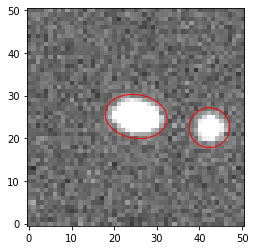

In [262]:
blend_id5 = np.where(flags5 == 1)[0][28]
runner5.plot_sex_obj(sep_res5[blend_id5], blended_5[blend_id5]['galsim_image_noisy'])

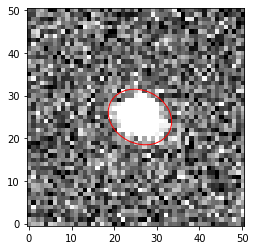

In [263]:
no_blend_id5 = np.where(flags5 == 0)[0][4]
runner5.plot_sex_obj(sep_res5[no_blend_id5], blended_5[no_blend_id5]['galsim_image_noisy'])

# 3. Test SExtractor on 80000 images ($\sigma_{noise} = 14.0$)

In [79]:
path14 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_14'

In [154]:
blended_14 = np.load(path14 + '/blended_noisy.npy', allow_pickle=True)

### Run Sextractor

In [177]:
runner14 = Run_Sep()

In [178]:
flags14, sep_res14 = runner14.process(blended_14)

14.779762268066406
15.439002990722656
14.525147438049316
14.762468338012695
14.002901077270508
14.296878814697266
14.495755195617676
14.868233680725098
14.558109283447266
14.258062362670898
14.891434669494629
14.502060890197754
14.239333152770996
15.343467712402344
14.123785972595215
16.473508834838867
14.78839111328125
14.512382507324219
14.402112007141113
14.435155868530273
14.63425064086914
14.083587646484375
14.331805229187012
14.83889102935791
14.000517845153809
13.953803062438965
14.066080093383789
14.924616813659668
14.658666610717773
14.364900588989258
13.758554458618164
15.160651206970215
14.118127822875977
14.523724555969238
14.485798835754395
14.760927200317383
14.921584129333496
14.05587100982666
14.295638084411621
14.740287780761719
14.403182983398438
13.757989883422852
14.47396183013916
14.926959037780762
17.01116371154785
14.179069519042969
14.535898208618164
14.051115036010742
14.127500534057617
14.9321928024292
14.166156768798828
14.190472602844238
20.332674026489258
1

14.111682891845703
15.244086265563965
14.118552207946777
14.867722511291504
14.227622985839844
14.245598793029785
14.465351104736328
14.502427101135254
14.232556343078613
14.182684898376465
14.294769287109375
14.31797981262207
16.856769561767578
14.711777687072754
14.299264907836914
14.3266019821167
14.069013595581055
14.872802734375
14.269834518432617
14.585023880004883
14.367653846740723
14.761374473571777
13.953438758850098
14.720890045166016
14.229388236999512
14.509954452514648
13.84703540802002
14.211618423461914
14.757862091064453
14.569184303283691
14.353517532348633
14.939932823181152
15.120878219604492
15.288203239440918
15.295256614685059
14.10133171081543
14.445547103881836
14.333369255065918
14.368995666503906
14.653454780578613
15.127464294433594
14.293533325195312
15.489543914794922
14.11547565460205
14.075756072998047
13.798711776733398
14.795434951782227
14.731422424316406
14.2138671875
163.43756103515625
14.338507652282715
14.347017288208008
14.817093849182129
14.4393

14.50412368774414
14.447733879089355
14.159994125366211
13.969840049743652
15.171630859375
14.00070571899414
17.91671371459961
14.669220924377441
13.860060691833496
14.77568244934082
14.536439895629883
14.646541595458984
14.238985061645508
14.316240310668945
14.348657608032227
15.278059005737305
14.443815231323242
14.875754356384277
23.073091506958008
15.259300231933594
14.036742210388184
13.87043285369873
16.174894332885742
14.941205978393555
14.29461669921875
15.201689720153809
14.116101264953613
14.559907913208008
14.497024536132812
14.659361839294434
14.542763710021973
14.376473426818848
14.276959419250488
14.852774620056152
14.626812934875488
14.220738410949707
13.988349914550781
14.466516494750977
20.213253021240234
14.920878410339355
14.228694915771484
14.72102165222168
14.628157615661621
15.886007308959961
17.61445426940918
14.809839248657227
13.739033699035645
17.416791915893555
14.854094505310059
15.079804420471191
14.596026420593262
14.692760467529297
14.009531021118164
13.9

20.9595947265625
14.17310619354248
15.699615478515625
14.72888469696045
14.527314186096191
15.191598892211914
13.898698806762695
15.39120864868164
14.078184127807617
15.073369979858398
15.013261795043945
14.261188507080078
14.503704071044922
14.488652229309082
15.078338623046875
14.876524925231934
14.292037010192871
14.21441650390625
14.66328239440918
13.964962005615234
14.406347274780273
14.827317237854004
15.113771438598633
14.35585880279541
14.685196876525879
14.229443550109863
14.576118469238281
14.632341384887695
14.40989875793457
14.46037769317627
22.627948760986328
14.079766273498535
14.018241882324219
14.604758262634277
14.349954605102539
14.027103424072266
14.410541534423828
14.845144271850586
14.28488540649414
14.47447681427002
15.219785690307617
14.372451782226562
14.80233383178711
14.295671463012695
13.835090637207031
14.278899192810059
13.909027099609375
14.327848434448242
14.351028442382812
15.303802490234375
15.666587829589844
14.464448928833008
14.998100280761719
18.569

14.555603981018066
14.384413719177246
14.80171012878418
14.361469268798828
14.290773391723633
14.401166915893555
14.194869995117188
14.123448371887207
14.050542831420898
14.351951599121094
20.342493057250977
14.34250259399414
14.185973167419434
13.859847068786621
15.051253318786621
14.120457649230957
14.11355209350586
14.605880737304688
14.055718421936035
14.664220809936523
13.4646635055542
14.604935646057129
27.857812881469727
14.196362495422363
14.412308692932129
14.197896003723145
14.417035102844238
14.591806411743164
26.508134841918945
15.36791706085205
14.191892623901367
14.887744903564453
14.002713203430176
14.717937469482422
14.524169921875
14.451669692993164
14.25175666809082
14.934880256652832
14.105443954467773
15.571639060974121
14.441232681274414
19.26314353942871
14.20315933227539
14.175741195678711
14.498393058776855
14.161898612976074
14.34620189666748
15.10969352722168
14.60452651977539
14.516128540039062
14.276209831237793
14.204119682312012
14.453330993652344
14.15273

14.053016662597656
14.04360580444336
14.816835403442383
14.640503883361816
13.794083595275879
14.035748481750488
17.053104400634766
14.024103164672852
18.8898868560791
14.308716773986816
14.335591316223145
14.852313041687012
14.874229431152344
15.739608764648438
16.038986206054688
14.714316368103027
14.633613586425781
14.388566970825195
14.24315357208252
14.179169654846191
14.98292064666748
14.122305870056152
14.921786308288574
14.76343822479248
14.627218246459961
13.923866271972656
13.953051567077637
14.61551570892334
14.917290687561035
13.998977661132812
14.189765930175781
15.32450008392334
14.618725776672363
14.40664005279541
14.743556022644043
16.18451499938965
14.10669231414795
15.932428359985352
14.199451446533203
15.218790054321289
14.183279991149902
14.368858337402344
14.070508003234863
14.280946731567383
14.51813793182373
14.175384521484375
15.038342475891113
14.486918449401855
13.903564453125
14.636818885803223
14.259855270385742
13.596844673156738
14.420281410217285
15.00277

14.213390350341797
14.692935943603516
13.871660232543945
14.100075721740723
13.76436710357666
24.48659896850586
14.192315101623535
14.222824096679688
16.619308471679688
13.602643966674805
14.47983169555664
14.896317481994629
23.06278419494629
15.741260528564453
14.103958129882812
14.456006050109863
14.12484359741211
14.761810302734375
14.300329208374023
14.286917686462402
14.548765182495117
14.480012893676758
14.513931274414062
14.175622940063477
14.482157707214355
14.40018367767334
18.288291931152344
15.304069519042969
14.733776092529297
14.228110313415527
14.0802001953125
14.269330978393555
14.10958480834961
13.797235488891602
14.432343482971191
14.518211364746094
14.313370704650879
14.53751277923584
15.665492057800293
14.381088256835938
14.233874320983887
14.465739250183105
15.034012794494629
14.700125694274902
14.521773338317871
14.119101524353027
14.265570640563965
13.971264839172363
14.535065650939941
14.240196228027344
14.385479927062988
14.60290813446045
14.567916870117188
14.2

14.182900428771973
14.657483100891113
14.214917182922363
14.27110481262207
14.594974517822266
13.938253402709961
14.646744728088379
14.541725158691406
14.331087112426758
15.993131637573242
13.73198127746582
14.511856079101562
14.324965476989746
14.61294174194336
14.663047790527344
14.416683197021484
14.555535316467285
14.238268852233887
16.065305709838867
13.810951232910156
14.148961067199707
14.6024808883667
28.021411895751953
14.204127311706543
14.72104263305664
13.893524169921875
13.935559272766113
14.25954532623291
16.833599090576172
14.650984764099121
15.799217224121094
14.333024024963379
14.446356773376465
14.02425479888916
14.730061531066895
13.928261756896973
14.188517570495605
15.740234375
14.795074462890625
14.669506072998047
14.124226570129395
14.889477729797363
14.463067054748535
14.632757186889648
14.834787368774414
14.872286796569824
14.072962760925293
14.653919219970703
14.502558708190918
14.509263038635254
15.241378784179688
14.328967094421387
13.874716758728027
16.1016

14.54559326171875
14.246513366699219
15.054447174072266
14.929035186767578
14.55799674987793
14.699381828308105
14.231972694396973
13.71519660949707
15.24606704711914
15.38257884979248
14.453495025634766
14.338521957397461
14.667908668518066
14.410175323486328
14.11442756652832
14.326769828796387
15.978262901306152
15.893508911132812
13.965839385986328
14.560528755187988
14.976471900939941
14.238117218017578
14.331254005432129
14.111828804016113
14.557355880737305
14.289973258972168
14.84417724609375
14.340580940246582
13.97728443145752
14.567303657531738
14.324211120605469
15.182443618774414
15.316338539123535
21.829328536987305
16.13335418701172
14.39849853515625
14.560770988464355
19.726444244384766
14.290261268615723
13.889305114746094
14.7630033493042
14.196084022521973
14.842873573303223
14.683032989501953
14.803607940673828
14.62916088104248
14.492496490478516
15.279350280761719
14.401820182800293
14.703988075256348
14.316535949707031
14.371685981750488
14.221614837646484
14.657

14.14069938659668
14.698895454406738
14.4944486618042
14.050981521606445
14.259888648986816
14.726170539855957
14.646312713623047
14.356023788452148
14.12716007232666
14.665759086608887
14.180875778198242
14.068228721618652
14.189064979553223
14.333370208740234
14.503173828125
14.312318801879883
14.138467788696289
14.205678939819336
13.974538803100586
14.208806991577148
14.493047714233398
15.923096656799316
14.565185546875
14.778976440429688
14.528900146484375
14.009864807128906
14.820125579833984
14.612039566040039
14.33560562133789
14.15112018585205
13.972804069519043
15.77108383178711
14.580070495605469
14.978419303894043
14.181428909301758
14.261069297790527
15.134777069091797
15.32870864868164
14.556981086730957
14.34938907623291
14.535280227661133
14.545109748840332
15.864368438720703
14.300969123840332
14.197104454040527
13.92593002319336
15.287034034729004
14.627025604248047
14.974433898925781
14.543863296508789
14.674490928649902
15.189964294433594
15.641058921813965
14.294866

14.250061988830566
16.570045471191406
13.916035652160645
14.144547462463379
14.10484504699707
13.992669105529785
16.390661239624023
14.154330253601074
14.152382850646973
14.58045482635498
14.37373161315918
14.421265602111816
14.430729866027832
14.819083213806152
14.145706176757812
14.34090518951416
14.516140937805176
14.494174003601074
15.246783256530762
14.206419944763184
13.98884105682373
14.41539192199707
14.897258758544922
15.024435997009277
13.897448539733887
14.755058288574219
14.247529983520508
14.684635162353516
14.93600845336914
18.400070190429688
15.547828674316406
14.577293395996094
14.871500968933105
13.950639724731445
14.435102462768555
14.512493133544922
13.731303215026855
14.402389526367188
14.316282272338867
14.666885375976562
14.735186576843262
14.415820121765137
15.325423240661621
14.501962661743164
14.357930183410645
14.306365013122559
14.060089111328125
14.523138046264648
13.951492309570312
14.245019912719727
14.287860870361328
14.5545015335083
14.471951484680176
13

14.285804748535156
14.237791061401367
14.097623825073242
14.3993558883667
13.735726356506348
15.004744529724121
14.460057258605957
14.228395462036133
14.988119125366211
14.468096733093262
14.411181449890137
14.054647445678711
14.120912551879883
24.462833404541016
14.145848274230957
14.155445098876953
14.171181678771973
14.741119384765625
13.963783264160156
13.856001853942871
14.189908981323242
14.421426773071289
14.516899108886719
14.679264068603516
14.309426307678223
14.400633811950684
15.879709243774414
14.210139274597168
14.183579444885254
14.233757019042969
14.09467887878418
14.63343620300293
14.565786361694336
13.825488090515137
14.958568572998047
14.398757934570312
14.690010070800781
14.232625961303711
14.401201248168945
19.090347290039062
14.29499340057373
17.012802124023438
15.35241985321045
14.211328506469727
14.700806617736816
15.507365226745605
14.744361877441406
14.712830543518066
13.975390434265137
14.482439041137695
14.626729965209961
14.725664138793945
13.965259552001953

14.391980171203613
14.384439468383789
14.813848495483398
15.330791473388672
15.48857307434082
14.03348445892334
14.038570404052734
14.252053260803223
14.17404556274414
14.811038970947266
14.648293495178223
14.751580238342285
14.057251930236816
14.32270336151123
14.204814910888672
14.43515396118164
14.485459327697754
14.803534507751465
14.670777320861816
14.080020904541016
14.920342445373535
14.491275787353516
16.598176956176758
14.859638214111328
14.483880043029785
14.02760124206543
14.055276870727539
14.284101486206055
14.89801025390625
14.495992660522461
13.736929893493652
13.843881607055664
14.754558563232422
14.316718101501465
15.583040237426758
14.378154754638672
14.099143028259277
14.532587051391602
14.354387283325195
14.401023864746094
14.32023811340332
14.631856918334961
14.426065444946289
16.369123458862305
14.245377540588379
14.108928680419922
14.552940368652344
14.339834213256836
15.708880424499512
14.730714797973633
14.595552444458008
14.56151008605957
14.268780708312988
14

15.09107780456543
16.161293029785156
14.306026458740234
14.441229820251465
14.578413009643555
14.095840454101562
14.417366981506348
14.45317554473877
14.009398460388184
14.981703758239746
14.138676643371582
15.330517768859863
14.940380096435547
13.769436836242676
14.196395874023438
14.35105037689209
14.951961517333984
14.706194877624512
16.218732833862305
14.27099895477295
14.047523498535156
14.955900192260742
15.17748737335205
14.332618713378906
15.131818771362305
14.634515762329102
14.443394660949707
14.474564552307129
15.387213706970215
14.433908462524414
14.45663833618164
14.070635795593262
13.867642402648926
14.377467155456543
14.467601776123047
14.505146026611328
14.153878211975098
14.24312686920166
14.216473579406738
14.847352981567383
14.165255546569824
14.077179908752441
14.082232475280762
14.194059371948242
15.971625328063965
14.022299766540527
14.330310821533203
14.692191123962402
14.689855575561523
13.915822982788086
14.207937240600586
14.178580284118652
14.25808334350586
1

14.847960472106934
14.386500358581543
14.511768341064453
14.156716346740723
14.881196022033691
14.235798835754395
14.042266845703125
13.925569534301758
14.70581340789795
14.879652976989746
14.49969482421875
14.045315742492676
14.08865737915039
14.012242317199707
14.723952293395996
14.145252227783203
14.406798362731934
14.576919555664062
14.282938003540039
14.504966735839844
14.148382186889648
14.93814468383789
14.390223503112793
13.924821853637695
14.433878898620605
14.315882682800293
15.73475456237793
15.452095031738281
14.124245643615723
14.153069496154785
14.229681968688965
14.116138458251953
14.009366035461426
14.830646514892578
14.631682395935059
14.628778457641602
13.827678680419922
13.581459999084473
14.848657608032227
16.86964225769043
20.34040641784668
14.118616104125977
15.842268943786621
15.37833309173584
14.565488815307617
14.379465103149414
14.242215156555176
14.70517635345459
14.267596244812012
14.7019624710083
14.197379112243652
14.831853866577148
14.813254356384277
14.3

14.4903564453125
14.184056282043457
14.885748863220215
35.4053955078125
14.399027824401855
14.074699401855469
14.18646240234375
14.293936729431152
14.073026657104492
15.057809829711914
14.89783000946045
14.646512985229492
14.422977447509766
14.749147415161133
14.372064590454102
14.061399459838867
14.763486862182617
14.596855163574219
14.077126502990723
14.328654289245605
13.988643646240234
15.092097282409668
14.756775856018066
14.157124519348145
14.649970054626465
14.431355476379395
14.096590042114258
14.612913131713867
15.001036643981934
14.177994728088379
14.498260498046875
14.266538619995117
13.871247291564941
15.357025146484375
14.143125534057617
14.26738166809082
14.214470863342285
13.938899993896484
13.808127403259277
14.089008331298828
14.426361083984375
15.36310863494873
14.481465339660645
14.049253463745117
13.923677444458008
15.136848449707031
14.84485912322998
14.342493057250977
14.32542610168457
14.351859092712402
14.109674453735352
13.744306564331055
14.542728424072266
14.

14.203782081604004
14.46826171875
14.511451721191406
14.421368598937988
14.349204063415527
15.81631851196289
15.172993659973145
14.382729530334473
14.334489822387695
14.591755867004395
14.201644897460938
14.11343765258789
14.282575607299805
13.947458267211914
14.218477249145508
14.336584091186523
14.210824012756348
14.3705472946167
14.246142387390137
20.985023498535156
14.370660781860352
14.469822883605957
14.834498405456543
14.548293113708496
14.432021141052246
14.576135635375977
14.949499130249023
13.731700897216797
18.520954132080078
16.042333602905273
14.676965713500977
14.27861499786377
15.870827674865723
14.916667938232422
14.545430183410645
14.48457145690918
15.169426918029785
14.534806251525879
14.298795700073242
16.430788040161133
14.84014892578125
16.810440063476562
15.466132164001465
14.452682495117188
14.657120704650879
14.173711776733398
14.47348403930664
14.729762077331543
14.226696968078613
13.96357536315918
14.015894889831543
14.592240333557129
14.690982818603516
14.585

15.177546501159668
14.573785781860352
14.314099311828613
14.371661186218262
14.095799446105957
17.073606491088867
14.91252326965332
14.086440086364746
14.069141387939453
14.097784042358398
14.443074226379395
14.325186729431152
14.216801643371582
15.498078346252441
14.518302917480469
14.289216995239258
14.325181007385254
14.622137069702148
14.544135093688965
14.627349853515625
14.616692543029785
14.496831893920898
14.193926811218262
14.11230754852295
14.190023422241211
14.88245677947998
15.363707542419434
14.512500762939453
14.456966400146484
13.953714370727539
13.992759704589844
14.575448036193848
13.93997573852539
14.245682716369629
14.915345191955566
14.725844383239746
14.44459056854248
14.43835163116455
14.496886253356934
15.195855140686035
14.327503204345703
27.185434341430664
14.278606414794922
13.830321311950684
13.898249626159668
14.366336822509766
14.560568809509277
14.388101577758789
13.865760803222656
14.70737361907959
14.216392517089844
14.791659355163574
14.669983863830566


15.297966957092285
15.16869068145752
14.360636711120605
14.347264289855957
14.136903762817383
14.989986419677734
14.40579605102539
14.23828411102295
14.632217407226562
14.130151748657227
18.061946868896484
16.936887741088867
14.650665283203125
14.51667308807373
14.193912506103516
14.308238983154297
14.347977638244629
14.778008460998535
14.65537166595459
14.851198196411133
14.2927885055542
14.559676170349121
14.450174331665039
14.634446144104004
14.094537734985352
14.217957496643066
14.513587951660156
13.879525184631348
14.352977752685547
14.591950416564941
14.096562385559082
13.909210205078125
14.679441452026367
14.169848442077637
14.644569396972656
14.777251243591309
14.365829467773438
14.557154655456543
14.159614562988281
14.125436782836914
14.585797309875488
14.093657493591309
14.358782768249512
14.079764366149902
24.429582595825195
14.352791786193848
14.627775192260742
14.31643295288086
14.064142227172852
14.520156860351562
14.63921070098877
14.069022178649902
14.765127182006836
14

14.642290115356445
14.52249526977539
14.68525505065918
14.912537574768066
14.650222778320312
15.227021217346191
14.757150650024414
14.326281547546387
14.008378982543945
14.777397155761719
14.31222152709961
14.84907341003418
14.038887977600098
14.08735466003418
15.028566360473633
14.099654197692871
14.207454681396484
14.332306861877441
14.493692398071289
14.23078727722168
15.77164077758789
14.561304092407227
14.33130168914795
14.479056358337402
14.43945598602295
30.27988052368164
15.268597602844238
14.08677864074707
14.19409465789795
14.440576553344727
15.124853134155273
13.877883911132812
15.258386611938477
14.850239753723145
14.539778709411621
14.518054962158203
13.985635757446289
14.571298599243164
14.299651145935059
15.065033912658691
14.256525039672852
14.120017051696777
14.392476081848145
14.73688793182373
14.373390197753906
14.486576080322266
14.535215377807617
16.52924346923828
14.555583000183105
14.08410358428955
16.474607467651367
14.486964225769043
14.623903274536133
58.35830

15.375710487365723
14.19149112701416
15.728123664855957
14.472415924072266
14.874711036682129
14.436042785644531
14.465578079223633
14.378666877746582
14.210768699645996
14.252762794494629
14.144309997558594
14.91344165802002
15.381612777709961
13.839803695678711
15.098278999328613
15.864279747009277
14.25023365020752
16.218273162841797
14.515984535217285
14.698528289794922
14.221551895141602
14.2407808303833
14.103828430175781
14.075590133666992
18.06232452392578
14.391190528869629
14.684368133544922
15.759586334228516
14.691527366638184
14.149984359741211
14.323933601379395
14.719877243041992
14.452460289001465
14.343867301940918
14.310513496398926
14.414637565612793
14.126439094543457
14.621199607849121
14.442676544189453
14.410659790039062
14.501716613769531
15.304254531860352
14.27656364440918
14.43327522277832
13.863384246826172
14.361540794372559
14.4190092086792
14.424489974975586
14.572432518005371
14.405463218688965
14.658252716064453
14.2970609664917
14.097965240478516
14.92

14.762760162353516
14.187880516052246
14.283761978149414
15.835617065429688
14.733624458312988
14.794264793395996
14.42546272277832
14.414056777954102
14.59821605682373
14.01041030883789
14.20390796661377
14.1823091506958
14.840890884399414
14.569618225097656
14.131991386413574
14.14183521270752
16.093961715698242
14.0706787109375
14.062887191772461
15.376062393188477
15.249964714050293
15.142395973205566
13.99937915802002
14.718265533447266
14.622535705566406
14.44830322265625
17.906951904296875
14.072023391723633
14.251861572265625
14.7921142578125
15.082990646362305
14.41707706451416
14.131260871887207
14.540754318237305
13.534116744995117
14.264628410339355
13.823110580444336
14.282221794128418
14.349867820739746
15.620207786560059
14.532675743103027
14.29528522491455
19.741783142089844
15.00312614440918
14.738921165466309
13.712349891662598
13.687708854675293
14.06894302368164
13.860926628112793
15.122146606445312
14.334228515625
15.037934303283691
14.46996021270752
14.35207462310

14.458785057067871
14.365799903869629
14.907913208007812
14.40937614440918
39.20026779174805
13.825533866882324
15.055938720703125
14.653962135314941
14.196640014648438
14.17498779296875
14.445518493652344
14.298992156982422
14.242314338684082
14.220260620117188
14.17387866973877
15.150703430175781
14.121315002441406
14.287266731262207
14.637662887573242
14.329010963439941
14.957517623901367
14.539342880249023
14.445061683654785
14.765459060668945
13.919729232788086
14.728547096252441
14.78044605255127
16.71984100341797
14.398333549499512
14.181680679321289
14.69593620300293
14.696455001831055
15.482877731323242
16.819644927978516
14.745657920837402
14.348991394042969
14.114558219909668
14.480696678161621
15.153602600097656
14.537915229797363
14.391030311584473
14.693886756896973
14.80357551574707
15.397430419921875
14.067513465881348
14.73281192779541
14.69543170928955
14.570923805236816
14.16299057006836
14.256362915039062
14.427451133728027
14.482151985168457
14.680118560791016
14.3

15.65911865234375
14.190427780151367
13.984848022460938
15.68851089477539
14.251141548156738
14.592048645019531
14.282508850097656
14.421540260314941
14.9066801071167
14.457470893859863
14.483020782470703
14.178988456726074
14.229265213012695
14.431000709533691
14.592087745666504
14.5151948928833
14.221632957458496
14.22633171081543
14.660589218139648
13.949357032775879
15.231749534606934
19.035106658935547
14.16500473022461
14.118795394897461
14.402371406555176
14.327068328857422
14.14503002166748
14.101594924926758
14.30546760559082
15.701188087463379
14.50383186340332
14.192462921142578
14.401338577270508
14.449448585510254
14.43067455291748
14.339958190917969
14.77275276184082
14.647591590881348
14.103792190551758
14.077848434448242
13.996718406677246
14.025335311889648
14.707959175109863
14.853053092956543
14.506917953491211
13.618624687194824
14.64920425415039
14.381916999816895
14.687707901000977
14.504456520080566
14.343727111816406
14.061050415039062
14.093493461608887
14.3642

14.14844799041748
15.668683052062988
14.097003936767578
14.787890434265137
14.164795875549316
14.20300579071045
14.522192001342773
14.443367958068848
14.1150484085083
13.996072769165039
14.92197036743164
20.831207275390625
15.526640892028809
14.14491081237793
14.028973579406738
15.243717193603516
14.651249885559082
14.403833389282227
14.567559242248535
14.599706649780273
14.14106273651123
14.30911636352539
15.095488548278809
13.775884628295898
14.312642097473145
15.758230209350586
14.170669555664062
14.731348037719727
14.707765579223633
14.489396095275879
14.556328773498535
13.915143013000488
14.663244247436523
15.630165100097656
14.127079963684082
14.555868148803711
14.473855972290039
14.327521324157715
14.457462310791016
14.277854919433594
13.99588394165039
14.785350799560547
15.500237464904785
14.778209686279297
14.920909881591797
14.444146156311035
14.74962329864502
14.417057037353516
14.177105903625488
14.801979064941406
14.379093170166016
14.151538848876953
14.706439971923828
14.

15.074095726013184
14.553298950195312
14.06829833984375
15.331584930419922
15.085988998413086
14.392172813415527
14.671908378601074
14.589676856994629
14.239895820617676
16.72893524169922
14.461040496826172
14.128158569335938
14.688122749328613
14.407081604003906
14.163227081298828
14.655622482299805
16.257299423217773
14.831167221069336
15.017134666442871
14.533722877502441
14.346938133239746
14.73521900177002
14.681507110595703
15.610675811767578
14.81292724609375
15.310280799865723
14.695180892944336
13.801366806030273
14.970661163330078
14.154548645019531
14.290877342224121
14.74557113647461
14.468707084655762
14.409435272216797
13.850687980651855
14.986278533935547
14.71556282043457
14.415984153747559
14.261940956115723
14.440098762512207
14.452030181884766
14.165118217468262
14.70440673828125
14.15137004852295
14.058188438415527
13.913224220275879
14.291507720947266
14.50939655303955
14.284133911132812
14.51300048828125
13.981632232666016
14.315199851989746
14.002939224243164
14.

15.363866806030273
14.728426933288574
14.695157051086426
14.4683198928833
14.079127311706543
13.897867202758789
14.237929344177246
14.151132583618164
14.620528221130371
14.446258544921875
14.407033920288086
14.216266632080078
14.473999977111816
14.320284843444824
14.494641304016113
14.585970878601074
15.017071723937988
15.07626724243164
14.44218635559082
25.919878005981445
13.889141082763672
14.441532135009766
14.193625450134277
14.935567855834961
14.368367195129395
14.890803337097168
14.0618314743042
15.073282241821289
14.100260734558105
16.716243743896484
14.373340606689453
14.423430442810059
14.173309326171875
14.84356689453125
13.830343246459961
14.585226058959961
16.10920524597168
14.709283828735352
14.585888862609863
15.096443176269531
14.50297737121582
14.600110054016113
14.700759887695312
14.743544578552246
15.25546932220459
14.791752815246582
14.479860305786133
14.605565071105957
14.398499488830566
14.395252227783203
14.457480430603027
14.742919921875
14.083822250366211
15.453

14.472749710083008
14.505309104919434
14.480676651000977
14.52490520477295
14.392862319946289
14.176839828491211
14.858556747436523
15.081523895263672
13.745508193969727
14.692541122436523
15.70259952545166
14.902152061462402
14.235396385192871
15.455825805664062
14.334359169006348
14.67493724822998
14.1148042678833
14.293492317199707
14.258927345275879
15.068926811218262
14.53238582611084
14.344888687133789
14.47705078125
14.147306442260742
14.423649787902832
14.400495529174805
14.520167350769043
14.5048828125
14.271688461303711
14.03409194946289
14.179537773132324
14.502087593078613
14.644702911376953
14.010089874267578
14.283403396606445
14.559514999389648
18.14009666442871
24.420276641845703
14.181912422180176
13.862829208374023
14.358037948608398
14.20139217376709
14.464898109436035
14.286365509033203
14.376886367797852
14.466936111450195
14.553277969360352
14.474647521972656
14.050374984741211
14.22106647491455
14.25740909576416
14.378327369689941
14.89943790435791
14.31611251831

14.843890190124512
14.36130142211914
14.20959186553955
14.181831359863281
14.472798347473145
14.761754989624023
14.987105369567871
14.362489700317383
14.590197563171387
14.185379028320312
15.44595718383789
14.098515510559082
13.972050666809082
14.13142204284668
14.616180419921875
14.169439315795898
14.060744285583496
16.29422950744629
14.778228759765625
14.3472900390625
14.761454582214355
13.990974426269531
14.727461814880371
14.186965942382812
14.281635284423828
14.210817337036133
14.18109130859375
14.701939582824707
15.551194190979004
16.100746154785156
14.384726524353027
14.231745719909668
14.094274520874023
13.873239517211914
14.42081356048584
14.322142601013184
13.772432327270508
14.528426170349121
15.136880874633789
14.311970710754395
14.232816696166992
14.00615406036377
14.05893325805664
14.262779235839844
14.439087867736816
15.652159690856934
14.856520652770996
14.49015998840332
14.314580917358398
13.991203308105469
14.305633544921875
15.100859642028809
14.629100799560547
14.87

14.430205345153809
14.690743446350098
14.802580833435059
14.878045082092285
17.54296875
14.181754112243652
14.422112464904785
14.360676765441895
14.481172561645508
14.409769058227539
14.721820831298828
14.106321334838867
14.561456680297852
16.450952529907227
13.954748153686523
14.818157196044922
14.458359718322754
14.167214393615723
14.398909568786621
14.495218276977539
14.378219604492188
15.446406364440918
14.202016830444336
14.610732078552246
14.225187301635742
14.554969787597656
14.190272331237793
14.1007080078125
14.015666961669922
14.848586082458496
14.651638984680176
14.050150871276855
16.007179260253906
14.42141056060791
13.884295463562012
14.70264720916748
14.439584732055664
14.68211555480957
14.510696411132812
14.719127655029297
14.076990127563477
14.87961196899414
14.512598037719727
14.616061210632324
14.693923950195312
14.367671966552734
14.462183952331543
14.63298511505127
15.8760404586792
14.080216407775879
14.218436241149902
14.388205528259277
13.664618492126465
14.414927

14.159090995788574
15.438427925109863
14.377411842346191
14.226768493652344
14.583243370056152
14.755731582641602
14.602301597595215
14.395585060119629
16.306800842285156
15.301864624023438
13.807413101196289
17.030485153198242
14.840863227844238
14.688445091247559
14.201863288879395
20.090139389038086
14.438404083251953
18.9265079498291
14.018793106079102
14.092063903808594
14.219557762145996
14.312063217163086
14.033084869384766
13.872121810913086
14.146110534667969
14.234675407409668
14.439210891723633
14.283936500549316
14.49587631225586
30.671245574951172
14.525684356689453
14.65042781829834
14.412765502929688
14.36786937713623
13.869340896606445
14.318889617919922
15.544428825378418
14.613672256469727
14.179723739624023
14.204440116882324
14.061824798583984
14.692429542541504
14.916444778442383
14.51136589050293
14.187540054321289
14.107902526855469
14.861289978027344
14.502237319946289
14.511368751525879
14.241449356079102
14.269319534301758
14.62620735168457
14.530397415161133


15.106551170349121
14.035784721374512
14.21664047241211
14.659345626831055
14.964142799377441
14.182518005371094
14.686575889587402
15.054715156555176
13.961446762084961
14.042067527770996
14.085188865661621
14.514867782592773
14.53817367553711
23.01380157470703
15.6563720703125
15.05178451538086
14.511473655700684
13.83894157409668
14.203991889953613
14.495189666748047
14.441411018371582
16.43535804748535
14.303168296813965
13.948927879333496
14.30077838897705
14.101761817932129
14.501462936401367
14.373106002807617
14.523029327392578
25.480634689331055
15.131452560424805
14.673850059509277
14.960033416748047
14.389938354492188
14.397229194641113
14.526230812072754
14.219698905944824
14.500133514404297
14.725857734680176
15.964150428771973
14.579410552978516
14.196916580200195
14.376180648803711
14.228133201599121
15.30968952178955
14.737798690795898
14.044672966003418
14.40668773651123
14.914769172668457
14.660130500793457
14.999725341796875
14.361433982849121
13.870307922363281
14.7

14.093216896057129
14.477194786071777
14.559131622314453
14.210217475891113
14.281027793884277
16.002077102661133
14.633272171020508
14.228190422058105
14.416342735290527
14.078432083129883
14.253349304199219
14.843822479248047
14.400110244750977
14.286590576171875
14.190155029296875
14.355378150939941
15.913395881652832
14.277003288269043
14.253575325012207
15.517070770263672
15.104015350341797
14.490781784057617
15.098386764526367
15.332690238952637
14.1157865524292
14.780625343322754
14.228215217590332
14.493772506713867
14.53072452545166
14.231082916259766
14.29554557800293
14.104385375976562
14.359065055847168
14.208600044250488
14.271173477172852
14.791733741760254
15.057751655578613
14.43393325805664
14.485291481018066
14.279799461364746
14.25645637512207
14.182265281677246
14.380529403686523
14.80273151397705
14.745088577270508
14.27441692352295
14.631183624267578
14.605705261230469
14.7240629196167
14.482745170593262
19.103832244873047
14.324101448059082
14.703320503234863
14.

14.519875526428223
21.754051208496094
14.868607521057129
13.937254905700684
14.526593208312988
13.96184253692627
14.421252250671387
13.900157928466797
14.336444854736328
14.610726356506348
14.516188621520996
16.802942276000977
14.45481014251709
13.824803352355957
14.41747760772705
15.041777610778809
14.659988403320312
14.500419616699219
14.300432205200195
14.32411003112793
14.071186065673828
14.465310096740723
14.266892433166504
14.15230941772461
14.368579864501953
14.276704788208008
14.159597396850586
14.399489402770996
20.825157165527344
14.51288890838623
14.118253707885742
15.14824104309082
15.381950378417969
14.352849960327148
14.704244613647461
14.313915252685547
14.907755851745605
13.804686546325684
15.5638427734375
14.242484092712402
14.363751411437988
14.007182121276855
14.17050838470459
15.776867866516113
14.220488548278809
14.66962718963623
14.617471694946289
15.986959457397461
14.249143600463867
14.912028312683105
14.799995422363281
13.970404624938965
14.057258605957031
14.1

14.226391792297363
14.05793571472168
14.929956436157227
14.564000129699707
13.906070709228516
14.20073127746582
14.266095161437988
14.534741401672363
14.347151756286621
13.967334747314453
15.070074081420898
14.280521392822266
15.130892753601074
14.451573371887207
14.432418823242188
14.038975715637207
15.295475006103516
13.6162109375
14.86404037475586
14.181439399719238
14.419836044311523
14.246744155883789
14.515042304992676
14.535374641418457
14.547853469848633
14.048828125
14.485902786254883
15.22718620300293
16.204853057861328
14.60352611541748
14.908235549926758
13.981513977050781
14.056856155395508
14.205560684204102
14.01548957824707
14.766471862792969
14.00161361694336
14.625155448913574
14.053730010986328
14.26497745513916
14.722269058227539
14.784390449523926
14.984539031982422
14.469475746154785
14.49320125579834
14.047269821166992
15.74217700958252
14.916229248046875
14.228607177734375
15.404478073120117
14.535479545593262
14.380938529968262
14.361944198608398
14.48975849151

14.233381271362305
14.622885704040527
14.248567581176758
14.4885835647583
14.346572875976562
14.866155624389648
14.073904037475586
14.104548454284668
15.074912071228027
14.639260292053223
14.720580101013184
15.585698127746582
14.866591453552246
13.995834350585938
14.723219871520996
16.311416625976562
14.720184326171875
14.270238876342773
14.230149269104004
14.450762748718262
13.980813026428223
14.65389347076416
14.195294380187988
14.335406303405762
14.334063529968262
14.880376815795898
14.932168006896973
14.256843566894531
13.996319770812988
14.816444396972656
14.631921768188477
14.095930099487305
14.836572647094727
14.06374740600586
14.317554473876953
15.042223930358887
14.113739013671875
14.822823524475098
14.215030670166016
14.521578788757324
14.535305976867676
14.230280876159668
15.710062980651855
14.381839752197266
14.405294418334961
15.027546882629395
14.345210075378418
15.89064884185791
14.591012954711914
14.33237075805664
14.198188781738281
15.18499755859375
14.173710823059082


15.159346580505371
14.414105415344238
14.594064712524414
13.547646522521973
14.275361061096191
15.351289749145508
14.412967681884766
14.421120643615723
14.826192855834961
14.241846084594727
14.5299654006958
14.401427268981934
14.44098949432373
13.940185546875
14.629643440246582
14.248726844787598
14.877242088317871
14.18301010131836
14.23289966583252
14.251350402832031
14.481327056884766
14.313859939575195
14.000740051269531
14.63604736328125
14.586164474487305
14.76229476928711
14.209370613098145
14.264001846313477
13.64642333984375
14.499980926513672
14.456955909729004
14.584327697753906
16.237010955810547
14.48716926574707
16.79413414001465
14.682497024536133
14.025147438049316
14.178603172302246
15.250880241394043
14.223179817199707
15.116203308105469
14.229278564453125
15.01155948638916
15.675033569335938
14.786402702331543
14.989458084106445
14.579144477844238
14.454008102416992
13.928396224975586
14.203056335449219
29.273765563964844
15.1620454788208
14.630191802978516
15.221120

16.070383071899414
14.27485179901123
15.058412551879883
14.10715389251709
14.628874778747559
14.057297706604004
14.45407485961914
14.551474571228027
14.934990882873535
13.843910217285156
13.674331665039062
14.355937004089355
14.191325187683105
23.087581634521484
14.17142105102539
13.711143493652344
14.66061019897461
14.164498329162598
14.215836524963379
14.954370498657227
13.7367525100708
14.076345443725586
15.026955604553223
14.182011604309082
14.303803443908691
14.000332832336426
14.299872398376465
14.15470027923584
14.665051460266113
14.343745231628418
14.884899139404297
14.479719161987305
14.418222427368164
14.333575248718262
14.076733589172363
14.130891799926758
13.923955917358398
14.105039596557617
14.618406295776367
14.239936828613281
14.031638145446777
14.560450553894043
15.492227554321289
14.053552627563477
14.162164688110352
14.092899322509766
14.465106010437012
14.235966682434082
14.46274185180664
14.313581466674805
14.38648509979248
14.038923263549805
15.143173217773438
14.

14.263072967529297
14.972933769226074
15.094596862792969
14.275501251220703
14.341484069824219
15.172064781188965
14.594367027282715
14.045808792114258
21.314990997314453
14.000919342041016
13.987427711486816
14.473187446594238
14.47050952911377
14.332056999206543
14.22745418548584
14.274700164794922
17.315744400024414
14.474349975585938
14.13915729522705
15.844890594482422
14.086599349975586
14.114752769470215
14.841655731201172
14.91248607635498
15.022521018981934
22.7856502532959
14.474122047424316
15.258429527282715
14.273094177246094
14.399845123291016
14.24139404296875
14.659687042236328
14.43523120880127
14.111827850341797
15.21240234375
14.191305160522461
14.197256088256836
14.617973327636719
16.186269760131836
14.318514823913574
14.569190979003906
14.195770263671875
14.673575401306152
14.319957733154297
15.645133018493652
14.473466873168945
14.089317321777344
14.072973251342773
14.390373229980469
15.031274795532227
15.372730255126953
14.668730735778809
14.027873039245605
14.17

14.390558242797852
17.421161651611328
14.663411140441895
15.780497550964355
14.171027183532715
15.767433166503906
18.522253036499023
14.048674583435059
14.431462287902832
14.276196479797363
14.082951545715332
14.433485984802246
15.187833786010742
16.916549682617188
14.528003692626953
15.04572868347168
14.084270477294922
14.730255126953125
14.472865104675293
14.421344757080078
14.295578956604004
14.634271621704102
13.90307903289795
14.449505805969238
14.277082443237305
17.790616989135742
14.099695205688477
14.888757705688477
14.476584434509277
14.68415641784668
13.783649444580078
13.980395317077637
14.353673934936523
14.115117073059082
14.660669326782227
14.607804298400879
15.274449348449707
14.524031639099121
15.079484939575195
14.483403205871582
15.045034408569336
13.926657676696777
14.510066986083984
14.825908660888672
14.041049003601074
14.03711223602295
14.64649486541748
15.259706497192383
13.993292808532715
14.302063941955566
14.053750991821289
14.235939979553223
14.75835609436035

13.758026123046875
16.62608528137207
14.488919258117676
13.811712265014648
14.686695098876953
14.18621826171875
15.176066398620605
13.992595672607422
14.7280912399292
14.449687957763672
13.888976097106934
13.988985061645508
14.270295143127441
15.010437965393066
15.609331130981445
14.015761375427246
16.86956024169922
14.447074890136719
15.040533065795898
14.560805320739746
15.169079780578613
14.161886215209961
14.368372917175293
15.257265090942383
13.692126274108887
14.905210494995117
14.520759582519531
14.067866325378418
13.893898010253906
14.273956298828125
14.041313171386719
14.683439254760742
14.643538475036621
14.51231861114502
16.86562156677246
14.11794376373291
14.096403121948242
14.501314163208008
14.983098030090332
14.28272819519043
14.394912719726562
14.643613815307617
15.137831687927246
14.601607322692871
14.53508472442627
14.17128849029541
14.571398735046387
14.567222595214844
14.567056655883789
14.517148971557617
14.468055725097656
14.185343742370605
14.109536170959473
14.5

18.703235626220703
14.348258972167969
14.777599334716797
14.445350646972656
14.411725997924805
14.43519401550293
14.597888946533203
14.364462852478027
14.597322463989258
14.406856536865234
14.945008277893066
14.56628131866455
14.544814109802246
14.491789817810059
13.986715316772461
14.604710578918457
14.398082733154297
14.102621078491211
14.50717830657959
14.161133766174316
14.471542358398438
14.575387954711914
14.750844955444336
14.208996772766113
14.330071449279785
14.222715377807617
14.785393714904785
14.738515853881836
14.535101890563965
14.503013610839844
15.263486862182617
14.157083511352539
14.274063110351562
14.939984321594238
15.234515190124512
14.13980484008789
14.54160213470459
15.479823112487793
13.942375183105469
14.253872871398926
14.632813453674316
14.41036605834961
13.8836088180542
14.207853317260742
14.550396919250488
14.258455276489258
14.494643211364746
14.21507740020752
14.475600242614746
14.458990097045898
14.504477500915527
14.61221694946289
14.767831802368164
14.

14.517109870910645
14.205155372619629
14.313226699829102
14.200791358947754
14.615090370178223
14.30416488647461
14.618878364562988
16.364482879638672
14.144450187683105
15.903215408325195
14.1555814743042
15.594018936157227
14.404404640197754
14.228426933288574
14.697111129760742
14.384623527526855
14.683785438537598
14.023526191711426
14.41334056854248
14.405985832214355
14.585198402404785
14.602057456970215
14.301253318786621
15.351425170898438
14.622851371765137
14.487724304199219
14.389715194702148
17.602901458740234
13.772880554199219
14.749856948852539
15.016927719116211
14.063092231750488
13.942496299743652
14.160961151123047
14.126033782958984
14.309197425842285
15.548147201538086
14.187255859375
14.29140567779541
14.332388877868652
14.232510566711426
14.534175872802734
14.201608657836914
14.834731101989746
14.620461463928223
14.443429946899414
13.832606315612793
15.124629974365234
14.310787200927734
14.368136405944824
14.400485038757324
14.27529525756836
14.41541862487793
14.

14.616230010986328
14.638265609741211
13.991194725036621
15.794968605041504
14.196125984191895
14.141018867492676
13.940949440002441
14.182610511779785
14.458666801452637
14.411852836608887
13.951356887817383
14.478192329406738
13.959748268127441
13.9525728225708
14.839193344116211
14.522834777832031
14.00499439239502
14.779770851135254
15.176173210144043
14.198789596557617
14.551002502441406
14.022651672363281
13.947283744812012
13.99094009399414
14.491389274597168
14.374731063842773
14.11198616027832
15.558760643005371
14.215965270996094
14.737220764160156
14.521991729736328
14.03689193725586
14.613468170166016
14.862201690673828
14.269887924194336
14.211258888244629
14.274640083312988
14.195637702941895
14.315279960632324
14.995170593261719
14.601696968078613
13.652311325073242
14.50500774383545
14.203407287597656
14.18688678741455
14.256590843200684
14.461047172546387
14.34294605255127
14.199106216430664
14.579029083251953
14.171496391296387
14.469803810119629
14.333060264587402
14

14.359801292419434
14.070440292358398
14.026081085205078
14.076497077941895
14.23019790649414
14.120328903198242
14.301342010498047
14.399456024169922
13.86003589630127
15.033073425292969
14.863277435302734
14.400946617126465
14.445192337036133
15.404698371887207
14.380754470825195
14.21699333190918
14.36768913269043
14.141036033630371
14.46636962890625
15.0482177734375
14.42286205291748
14.23558235168457
14.375147819519043
14.445099830627441
14.394542694091797
14.212242126464844
14.271716117858887
14.363640785217285
14.027420997619629
14.324597358703613
14.892176628112793
13.975098609924316
14.25521183013916
14.233219146728516
14.088683128356934
14.233941078186035
14.246308326721191
14.180912017822266
14.242838859558105
14.34034252166748
14.62374210357666
14.339576721191406
14.329561233520508
14.047558784484863
14.252043724060059
13.997474670410156
14.406634330749512
14.106969833374023
14.87972354888916
19.073354721069336
14.655486106872559
14.556532859802246
14.34874153137207
14.8900

14.521265029907227
14.262470245361328
14.641190528869629
13.991244316101074
14.516850471496582
13.644396781921387
14.698012351989746
14.428565979003906
14.52740478515625
14.125166893005371
14.682891845703125
14.696710586547852
14.327441215515137
14.435778617858887
14.508116722106934
14.796886444091797
14.39577579498291
14.251357078552246
14.158239364624023
14.704767227172852
13.789755821228027
14.052693367004395
14.277859687805176
14.975079536437988
14.777139663696289
15.472033500671387
14.603716850280762
13.960299491882324
14.561407089233398
14.706501007080078
15.064751625061035
14.457124710083008
14.05643367767334
14.234441757202148
14.442846298217773
14.032986640930176
14.732992172241211
14.478001594543457
14.154461860656738
14.196562767028809
14.887630462646484
14.4727144241333
14.18519115447998
13.931279182434082
14.790398597717285
14.030271530151367
14.236759185791016
24.859981536865234
14.201521873474121
14.642491340637207
15.468846321105957
14.635213851928711
15.043794631958008

14.70296859741211
15.117786407470703
14.257280349731445
14.792126655578613
13.906007766723633
14.911922454833984
14.518689155578613
14.232826232910156
18.537519454956055
14.075457572937012
14.144675254821777
14.443497657775879
14.225579261779785
14.3409423828125
14.073022842407227
14.231776237487793
14.455010414123535
15.093856811523438
14.605648040771484
14.222082138061523
14.003750801086426
14.37680435180664
14.057823181152344
14.999870300292969
13.806706428527832
14.150403022766113
18.749834060668945
15.463339805603027
15.645071983337402
15.272295951843262
14.856306076049805
14.404692649841309
13.950024604797363
14.5040283203125
14.329648971557617
14.801948547363281
14.236532211303711
14.329176902770996
14.887731552124023
14.649394035339355
14.801295280456543
14.506457328796387
14.255475044250488
14.11849308013916
14.449498176574707
15.389662742614746
14.431604385375977
15.073837280273438
14.586045265197754
14.452505111694336
14.21066951751709
14.104310989379883
14.580499649047852
1

14.718945503234863
14.4229154586792
14.662613868713379
14.14050579071045
14.103353500366211
14.184450149536133
14.427329063415527
14.337299346923828
14.26961898803711
14.552688598632812
14.262434005737305
14.749048233032227
23.519073486328125
14.70450210571289
14.522024154663086
15.23792552947998
14.3436279296875
15.383355140686035
15.232873916625977
14.622101783752441
13.496562957763672
13.807077407836914
14.341536521911621
14.311012268066406
14.460027694702148
14.0435152053833
14.2189359664917
14.084216117858887
13.84017276763916
14.617652893066406
13.74234390258789
19.107038497924805
15.05974292755127
14.633842468261719
16.197105407714844
14.41016674041748
14.445734024047852
14.632750511169434
14.392782211303711
14.585843086242676
14.463561058044434
14.519125938415527
14.75843620300293
15.354127883911133
14.283283233642578
15.048237800598145
14.917244911193848
14.046253204345703
14.333724975585938
14.9291353225708
14.931086540222168
13.83653736114502
14.028057098388672
14.5584230422

14.001668930053711
14.173101425170898
13.849148750305176
14.63441276550293
14.264018058776855
14.140013694763184
15.124156951904297
14.744781494140625
14.04475212097168
14.126604080200195
14.250819206237793
14.6760892868042
14.876439094543457
14.448068618774414
14.435383796691895
14.247897148132324
15.468308448791504
13.974715232849121
13.802677154541016
14.306041717529297
14.142305374145508
13.97184944152832
14.54963493347168
14.089848518371582
13.979535102844238
14.436586380004883
14.301178932189941
14.772196769714355
14.059243202209473
55.242408752441406
14.500757217407227
14.090555191040039
14.057408332824707
15.293192863464355
14.335614204406738
14.307804107666016
14.722330093383789
14.253314018249512
13.99161148071289
14.44072151184082
14.567867279052734
13.94326114654541
14.152403831481934
14.613784790039062
15.090821266174316
14.975533485412598
15.088918685913086
15.148744583129883
14.328925132751465
14.237333297729492
13.61940860748291
14.523697853088379
14.145666122436523
14.

14.061308860778809
14.254231452941895
14.4111967086792
14.156577110290527
17.486413955688477
14.359258651733398
14.588888168334961
14.770462036132812
14.455678939819336
14.303101539611816
14.282368659973145
15.091070175170898
14.029555320739746
15.384410858154297
14.041350364685059
14.490144729614258
13.755844116210938
14.294382095336914
14.532175064086914
17.00014877319336
14.392538070678711
14.047548294067383
14.076719284057617
14.580610275268555
14.09008502960205
14.542326927185059
14.550644874572754
14.969061851501465
14.452170372009277
14.189410209655762
14.584415435791016
14.391789436340332
14.340988159179688
15.543877601623535
14.851856231689453
14.594755172729492
14.475581169128418
14.061017036437988
14.278589248657227
14.578394889831543
14.230734825134277
15.034393310546875
14.42059326171875
14.061775207519531
15.267050743103027
13.796974182128906
14.461288452148438
14.101095199584961
14.723249435424805
15.14549732208252
14.570629119873047
14.380682945251465
14.363779067993164

15.292482376098633
14.865487098693848
14.758533477783203
14.227898597717285
14.131299018859863
14.041592597961426
14.70982551574707
14.843878746032715
14.748628616333008
15.068138122558594
43.96173858642578
17.00693702697754
14.518369674682617
16.918291091918945
14.194193840026855
13.896693229675293
14.19476318359375
14.560280799865723
14.52234935760498
14.544475555419922
14.562819480895996
14.648673057556152
15.040514945983887
13.876014709472656
14.108877182006836
14.36429500579834
14.245780944824219
14.882163047790527
14.06710147857666
14.704001426696777
14.276382446289062
14.267724990844727
13.861084938049316
45.28850173950195
14.243852615356445
14.368474960327148
14.179487228393555
14.02841567993164
16.965452194213867
18.254371643066406
14.022887229919434
14.828486442565918
14.809195518493652
14.79842472076416
14.334624290466309
14.230134963989258
14.565427780151367
14.433731079101562
14.245057106018066
14.28152084350586
17.554805755615234
14.051462173461914
14.313112258911133
14.6

14.393268585205078
13.80394458770752
14.482269287109375
13.82785701751709
14.083879470825195
15.760505676269531
14.13447093963623
14.18649959564209
14.416526794433594
14.115007400512695
14.545495986938477
13.771106719970703
14.230531692504883
14.250805854797363
14.2568998336792
14.283793449401855
14.58552074432373
14.408974647521973
14.623358726501465
14.041522026062012
14.16799259185791
14.891366004943848
14.52132511138916
19.145164489746094
14.330216407775879
14.242732048034668
13.943402290344238
16.746213912963867
15.451184272766113
13.920146942138672
14.256243705749512
14.453933715820312
15.07072639465332
13.890912055969238
14.269505500793457
19.696157455444336
14.38428020477295
14.126933097839355
14.308025360107422
14.07664680480957
14.075725555419922
14.22634220123291
14.83367919921875
14.668033599853516
14.26753044128418
14.716403007507324
14.99130916595459
16.044355392456055
13.57176685333252
14.237149238586426
14.151213645935059
14.163653373718262
13.95444107055664
14.44382286

14.403212547302246
16.81938934326172
14.174910545349121
14.4990873336792
14.101921081542969
14.387258529663086
14.610716819763184
14.392621994018555
14.122343063354492
14.387632369995117
14.579400062561035
16.468481063842773
14.415702819824219
15.028099060058594
14.593731880187988
14.34521770477295
17.320764541625977
14.287385940551758
14.931001663208008
14.347259521484375
14.698599815368652
14.031977653503418
17.210769653320312
14.256390571594238
15.014983177185059
13.916047096252441
14.752633094787598
15.511557579040527
14.459427833557129
14.884408950805664
14.436366081237793
14.443476676940918
14.769851684570312
14.033586502075195
14.21627426147461
14.36504077911377
14.432291030883789
14.513322830200195
16.102184295654297
15.031478881835938
14.555153846740723
14.0483980178833
14.420905113220215
14.352370262145996
14.49421501159668
14.411053657531738
14.85257339477539
14.595320701599121
14.98531723022461
14.487604141235352
14.37999439239502
14.881351470947266
14.23456859588623
14.328

15.062013626098633
14.61531925201416
15.749185562133789
14.6248779296875
14.51345443725586
14.797317504882812
13.96816349029541
14.25831127166748
14.877562522888184
14.29985523223877
14.260115623474121
14.662676811218262
14.417720794677734
16.696449279785156
14.124564170837402
14.393756866455078
15.95671272277832
24.270320892333984
15.702914237976074
14.513683319091797
14.229290008544922
14.408463478088379
14.312387466430664
15.004166603088379
14.303696632385254
14.584808349609375
14.336531639099121
15.21225357055664
13.878226280212402
14.799567222595215
17.186077117919922
14.411346435546875
14.885714530944824
14.288471221923828
15.164151191711426
14.241519927978516
14.44088363647461
14.428577423095703
13.979452133178711
14.470145225524902
14.386919975280762
14.71226978302002
15.005951881408691
14.89247989654541
14.177233695983887
14.894928932189941
14.227262496948242
15.222776412963867
14.706586837768555
15.248001098632812
14.297943115234375
14.421509742736816
14.886688232421875
14.28

14.693503379821777
14.684051513671875
13.907743453979492
14.429800033569336
14.03046703338623
14.508890151977539
14.88394546508789
14.598999977111816
14.6140775680542
14.498283386230469
14.504745483398438
14.345843315124512
22.808977127075195
14.308194160461426
14.304136276245117
14.402691841125488
14.715261459350586
14.469001770019531
21.533065795898438
14.8653564453125
15.208945274353027
71.85411071777344
14.574552536010742
15.248579978942871
14.139899253845215
14.275505065917969
14.442205429077148
14.37908935546875
13.96452808380127
14.033468246459961
13.869930267333984
14.6618070602417
14.75847053527832
14.536653518676758
14.337493896484375
14.445033073425293
14.297844886779785
14.432254791259766
14.145661354064941
15.472856521606445
13.982945442199707
14.244998931884766
15.873577117919922
21.232139587402344
15.197944641113281
14.627372741699219
14.404814720153809
13.88930892944336
14.324983596801758
14.722651481628418
14.30421257019043
15.197943687438965
14.16445255279541
14.55270

14.848618507385254
14.064018249511719
14.434202194213867
14.608589172363281
21.071197509765625
14.537841796875
14.45395565032959
14.188542366027832
14.558493614196777
14.507551193237305
14.341508865356445
14.891230583190918
14.776432991027832
15.29627513885498
14.658536911010742
14.826919555664062
14.388148307800293
16.384618759155273
14.503005981445312
14.545087814331055
14.337591171264648
14.365228652954102
15.159676551818848
14.596389770507812
14.47997760772705
14.310125350952148
18.02926254272461
14.55665111541748
14.27740478515625
14.282541275024414
14.598275184631348
14.341469764709473
14.091547966003418
14.00887393951416
14.280984878540039
14.189275741577148
14.968474388122559
15.198360443115234
14.198017120361328
15.868560791015625
14.373440742492676
14.443029403686523
14.533407211303711
15.078737258911133
18.238441467285156
14.524104118347168
14.908731460571289
14.222525596618652
15.252433776855469
14.358450889587402
14.059335708618164
14.745393753051758
14.364419937133789
14.

14.376774787902832
14.384167671203613
14.419501304626465
14.589723587036133
13.955949783325195
15.821106910705566
14.549022674560547
15.147466659545898
14.705665588378906
14.095380783081055
14.255280494689941
14.853397369384766
14.547866821289062
14.345178604125977
32.540557861328125
14.214812278747559
14.22629451751709
14.672521591186523
14.03821849822998
17.040822982788086
14.29340648651123
17.029264450073242
14.136409759521484
14.175838470458984
14.118911743164062
14.962297439575195
14.861576080322266
14.334586143493652
14.607245445251465
14.30558967590332
14.885469436645508
14.114445686340332
13.929058074951172
14.096753120422363
14.505017280578613
14.482745170593262
14.259440422058105
14.174200057983398
14.415543556213379
14.114587783813477
14.367952346801758
15.561456680297852
13.685678482055664
16.137290954589844
14.746899604797363
14.381064414978027
14.637091636657715
13.862799644470215
14.107654571533203
14.359173774719238
15.04240894317627
14.984344482421875
13.79954719543457

14.701643943786621
14.572020530700684
14.176761627197266
14.194684982299805
15.015026092529297
16.325057983398438
14.451396942138672
14.72018814086914
14.042019844055176
14.88095474243164
14.556293487548828
14.270511627197266
14.007757186889648
24.761526107788086
14.243793487548828
14.248573303222656
17.744056701660156
15.366729736328125
14.574819564819336
13.637955665588379
22.265445709228516
14.615947723388672
14.514226913452148
14.507599830627441
18.817913055419922
14.676609992980957
13.819575309753418
14.141324996948242
14.347108840942383
14.993504524230957
18.318540573120117
13.855181694030762
14.345476150512695
14.449013710021973
14.059646606445312
14.068811416625977
14.551077842712402
14.399460792541504
23.350343704223633
14.657073974609375
14.579253196716309
14.135918617248535
14.351049423217773
13.85000228881836
13.937796592712402
14.15080451965332
14.500269889831543
14.139991760253906
14.027188301086426
14.107029914855957
14.300501823425293
13.970452308654785
14.4528770446777

14.587291717529297
14.222350120544434
14.508134841918945
15.20911693572998
14.21163272857666
14.28752326965332
14.709833145141602
14.141661643981934
14.318359375
15.248186111450195
14.478449821472168
14.328170776367188
14.06967830657959
14.641828536987305
14.121807098388672
13.861323356628418
15.70419692993164
14.548070907592773
14.953624725341797
14.75259780883789
14.529489517211914
14.335884094238281
14.39048957824707
16.385234832763672
14.429314613342285
14.00867748260498
14.519683837890625
14.201042175292969
14.778292655944824
14.5814790725708
13.87677001953125
14.702208518981934
30.77583885192871
14.788363456726074
14.011478424072266
14.062275886535645
14.235543251037598
14.367795944213867
17.7976016998291
14.961750030517578
15.417447090148926
14.13759708404541
14.285717964172363
14.724379539489746
14.208251953125
14.644913673400879
14.099711418151855
14.324973106384277
14.32774543762207
13.908978462219238
14.667405128479004
14.757421493530273
14.791163444519043
199.9022674560547


14.631479263305664
14.64808177947998
14.090472221374512
14.55164623260498
14.659958839416504
15.296260833740234
14.836053848266602
14.271678924560547
14.281206130981445
14.154531478881836
14.753543853759766
14.364555358886719
14.465452194213867
14.6056489944458
14.193467140197754
14.035013198852539
16.74648094177246
14.668397903442383
14.504935264587402
14.71241569519043
14.078703880310059
14.763911247253418
14.547390937805176
14.583791732788086
14.351506233215332
14.186359405517578
14.303704261779785
14.567333221435547
14.264413833618164
14.452376365661621
14.285097122192383
14.35927963256836
13.869117736816406
14.978121757507324
14.41274642944336
13.777503967285156
15.017033576965332
14.416378021240234
14.396992683410645
14.666017532348633
14.077414512634277
14.601958274841309
15.649861335754395
14.115161895751953
14.138321876525879
14.744552612304688
14.740245819091797
14.533454895019531
14.259053230285645
14.54013442993164
17.31572151184082
14.328461647033691
14.56061840057373
14.1

14.28744888305664
14.287275314331055
15.272195816040039
14.265049934387207
14.449455261230469
75.31779479980469
14.063446998596191
14.356760025024414
14.182687759399414
14.345888137817383
14.354531288146973
14.837778091430664
14.304377555847168
14.855694770812988
14.3154878616333
15.034536361694336
14.199399948120117
15.252032279968262
14.515666007995605
14.25552749633789
14.001891136169434
15.307185173034668
15.124320983886719
14.126554489135742
15.008587837219238
16.874847412109375
14.263118743896484
14.233842849731445
14.261041641235352
14.236943244934082
14.60706615447998
14.267797470092773
14.419225692749023
13.874068260192871
14.60945987701416
14.304839134216309
14.525705337524414
13.888846397399902
14.372044563293457
14.33683967590332
14.578994750976562
15.775579452514648
14.495261192321777
14.988728523254395
14.624940872192383
17.265731811523438
14.558817863464355
14.938427925109863
16.221961975097656
14.783295631408691
14.013862609863281
14.06290340423584
14.685446739196777
14

14.044512748718262
14.367051124572754
14.233085632324219
14.676116943359375
14.901985168457031
14.055648803710938
13.76615047454834
14.591243743896484
14.639578819274902
14.55880069732666
14.311430931091309
14.916168212890625
14.353816032409668
16.386878967285156
13.917526245117188
14.54224967956543
14.567359924316406
14.295613288879395
14.31734848022461
14.24891471862793
13.952929496765137
14.485780715942383
14.294849395751953
14.2422456741333
13.867687225341797
16.465513229370117
14.470770835876465
14.762328147888184
14.5350341796875
14.416548728942871
14.088957786560059
14.830680847167969
14.46218204498291
14.670313835144043
14.271198272705078
14.719115257263184
14.278077125549316
14.832130432128906
14.136138916015625
14.076255798339844
14.57051944732666
14.464346885681152
14.4498291015625
13.951767921447754
14.959270477294922
14.28386116027832
14.563257217407227
15.502837181091309
15.129575729370117
14.123409271240234
14.29456615447998
14.145017623901367
14.636734962463379
14.90061

14.60555362701416
14.27673053741455
15.39576530456543
14.11728572845459
14.614409446716309
14.474602699279785
14.537897109985352
15.82198429107666
14.393259048461914
14.722496032714844
14.408868789672852
14.375320434570312
14.957819938659668
14.293210983276367
14.120247840881348
14.446878433227539
14.0529146194458
14.638404846191406
14.634197235107422
14.345532417297363
14.170682907104492
14.496453285217285
14.489383697509766
14.437082290649414
14.25319766998291
14.795720100402832
14.577783584594727
14.509992599487305
14.180291175842285
14.273907661437988
14.13978099822998
14.38707160949707
14.03334903717041
14.267276763916016
14.264891624450684
14.452436447143555
13.828660011291504
14.41698932647705
14.370603561401367
19.243188858032227
14.218442916870117
14.54372787475586
14.49390983581543
14.194365501403809
14.373111724853516
13.921869277954102
14.365070343017578
14.629298210144043
15.058558464050293
14.787345886230469
14.225457191467285
14.287936210632324
14.271195411682129
26.3525

14.973979949951172
13.92744255065918
16.368579864501953
14.151735305786133
14.30141544342041
14.83134937286377
13.876419067382812
14.127206802368164
14.520572662353516
14.383437156677246
14.968860626220703
14.456358909606934
14.012954711914062
14.428007125854492
15.941147804260254
14.017576217651367
14.032038688659668
14.239996910095215
14.299884796142578
13.851139068603516
14.76486873626709
14.749216079711914
14.179567337036133
15.351846694946289
14.381804466247559
14.226160049438477
14.49317455291748
14.298177719116211
14.398176193237305
15.867178916931152
13.83206558227539
14.12985610961914
14.809136390686035
13.836706161499023
15.013901710510254
14.290972709655762
13.906496047973633
13.82751178741455
15.991721153259277
13.723710060119629
14.45557689666748
14.349510192871094
15.25856876373291
14.740348815917969
14.088440895080566
14.318696975708008
14.432985305786133
14.589285850524902
14.2410888671875
14.10425853729248
14.427978515625
14.385069847106934
15.062291145324707
14.546627

15.153486251831055
14.485393524169922
14.12177848815918
14.286336898803711
15.650874137878418
15.374370574951172
14.567192077636719
14.475133895874023
14.71718692779541
14.373122215270996
14.938652038574219
14.777667999267578
14.332844734191895
14.380218505859375
16.01154327392578
15.11001968383789
14.574441909790039
14.719664573669434
14.033836364746094
14.444531440734863
14.289568901062012
14.186044692993164
14.25491714477539
14.296319961547852
14.163910865783691
14.150774955749512
13.979584693908691
14.5566987991333
13.943463325500488
18.15145492553711
14.381985664367676
14.60228157043457
14.813375473022461
14.108481407165527
14.5530424118042
16.825851440429688
14.60804271697998
14.231674194335938
14.58747673034668
18.832778930664062
14.40310287475586
13.796449661254883
16.760051727294922
14.436281204223633
14.29073715209961
14.641053199768066
13.957498550415039
14.846220970153809
15.006758689880371
14.461636543273926
14.21841812133789
14.260274887084961
14.489886283874512
14.047037

18.540414810180664
14.489492416381836
14.041460037231445
15.270974159240723
14.750561714172363
14.541000366210938
15.383419036865234
15.082398414611816
14.58116340637207
14.37726879119873
14.19584846496582
14.177484512329102
14.38106632232666
14.426154136657715
15.515192985534668
14.189743041992188
13.963261604309082
16.079898834228516
14.3756103515625
14.432003021240234
15.452302932739258
14.241842269897461
13.941641807556152
14.71423053741455
14.300874710083008
14.763754844665527
14.118033409118652
14.571501731872559
14.90695858001709
13.857734680175781
13.760446548461914
15.942727088928223
14.637951850891113
14.243135452270508
14.168838500976562
14.31222915649414
14.24502182006836
14.27204704284668
14.116011619567871
14.203248023986816
14.052177429199219
17.007129669189453
14.760420799255371
14.221840858459473
14.404511451721191
17.57809066772461
14.464902877807617
14.49231243133545
14.93602180480957
14.53553581237793
14.349461555480957
14.450581550598145
14.07130241394043
14.382684

14.03827953338623
14.96285343170166
14.339083671569824
14.218338966369629
14.281230926513672
14.647783279418945
14.398093223571777
14.490985870361328
14.473348617553711
13.86277961730957
14.221762657165527
15.178049087524414
14.533820152282715
14.145708084106445
14.569574356079102
13.892695426940918
15.656734466552734
13.915661811828613
14.812118530273438
13.957507133483887
14.3689546585083
14.556883811950684
14.484502792358398
22.4156494140625
14.356240272521973
15.33110237121582
14.513346672058105
13.762578964233398
14.543991088867188
15.765324592590332
14.149297714233398
14.571124076843262
14.169258117675781
14.2942533493042
14.857010841369629
14.266048431396484
14.29019546508789
14.60258960723877
14.589628219604492
15.364856719970703
14.111863136291504
14.578262329101562
14.555668830871582
14.664454460144043
14.461687088012695
15.792571067810059
14.564371109008789
14.389580726623535
15.094541549682617
14.80345630645752
13.910935401916504
14.391427040100098
14.216723442077637
13.824

13.993083953857422
14.135680198669434
16.71196746826172
14.020413398742676
14.931554794311523
14.99090576171875
14.306184768676758
14.205376625061035
14.542413711547852
14.748658180236816
14.79674243927002
20.4086971282959
14.463578224182129
14.401543617248535
14.176373481750488
13.74177074432373
14.083370208740234
14.717230796813965
14.653426170349121
14.117533683776855
14.383810043334961
14.661051750183105
18.40972328186035
13.872931480407715
14.222092628479004
14.703850746154785
14.028242111206055
14.004206657409668
14.246012687683105
16.05211639404297
14.782179832458496
14.60942268371582
14.266433715820312
14.734787940979004
14.313226699829102
14.552902221679688
14.393547058105469
14.428324699401855
14.450506210327148
13.862247467041016
14.110092163085938
15.308935165405273
14.548453330993652
15.260068893432617
14.02169132232666
14.230223655700684
15.049543380737305
14.470489501953125
14.525936126708984
14.173665046691895
14.483253479003906
14.40377140045166
14.296263694763184
15.2

15.089689254760742
15.045475959777832
14.20356273651123
14.441946029663086
16.176305770874023
14.509941101074219
14.107648849487305
14.819561958312988
13.971898078918457
15.428500175476074
14.409396171569824
14.729978561401367
15.078045845031738
14.066245079040527
14.335603713989258
14.112491607666016
14.353093147277832
13.896306991577148
14.28151798248291
14.275883674621582
15.563162803649902
14.237052917480469
14.108458518981934
14.3890962600708
14.559786796569824
14.210017204284668
14.894515991210938
15.583341598510742
14.941773414611816
14.149940490722656
14.495063781738281
14.430804252624512
15.132405281066895
14.341249465942383
14.52296257019043
14.740708351135254
14.20274543762207
14.707579612731934
15.063750267028809
31.008710861206055
14.104537010192871
13.942636489868164
13.93608570098877
15.526702880859375
14.30240249633789
14.740523338317871
18.466289520263672
14.13707447052002
14.472307205200195
14.137762069702148
14.14281940460205
14.7354736328125
13.956611633300781
14.39

14.570130348205566
18.001012802124023
14.351691246032715
14.432106018066406
14.173949241638184
14.626935005187988
14.0798921585083
14.047533988952637
14.306130409240723
14.542604446411133
13.843157768249512
14.44940185546875
14.622387886047363
14.907343864440918
14.131997108459473
15.02051067352295
14.216670989990234
14.088689804077148
14.344192504882812
14.679458618164062
14.329700469970703
14.532342910766602
14.076143264770508
14.427361488342285
14.800849914550781
13.667974472045898
14.318873405456543
14.146127700805664
14.516656875610352
14.22381591796875
14.571073532104492
14.130441665649414
15.176379203796387
14.475281715393066
13.860031127929688
13.983068466186523
14.067887306213379
14.094128608703613
14.563188552856445
14.191339492797852
14.624659538269043
14.523890495300293
15.874983787536621
14.316696166992188
14.539694786071777
14.502507209777832
14.418474197387695
14.695416450500488
14.674017906188965
14.237587928771973
15.024454116821289
14.34701156616211
20.129426956176758

14.204051971435547
14.634037017822266
14.693944931030273
15.927572250366211
41.66362380981445
14.058026313781738
14.430355072021484
13.982353210449219
16.817153930664062
15.200508117675781
15.51904582977295
14.714876174926758
14.712648391723633
15.047039985656738
14.163281440734863
14.487444877624512
14.772689819335938
14.705869674682617
14.116652488708496
14.805480003356934
14.425662994384766
14.03960132598877
14.510483741760254
14.113163948059082
14.316496849060059
14.764899253845215
15.035355567932129
14.123015403747559
14.063016891479492
14.075238227844238
14.469388008117676
14.131366729736328
14.512035369873047
14.968537330627441
13.984262466430664
14.083786964416504
14.491836547851562
14.328079223632812
14.43576431274414
16.148086547851562
14.641437530517578
15.003789901733398
14.954679489135742
14.872960090637207
14.650182723999023
14.566506385803223
14.219330787658691
14.435736656188965
14.771656036376953
47.12650680541992
14.32408332824707
14.270236015319824
15.672008514404297

14.670650482177734
14.468073844909668
15.138155937194824
14.810368537902832
13.860536575317383
14.369515419006348
14.221563339233398
14.176889419555664
17.386241912841797
14.108464241027832
14.16694450378418
15.398360252380371
14.072243690490723
34.4002799987793
14.369881629943848
14.231683731079102
14.914467811584473
14.323994636535645
14.563105583190918
14.401779174804688
14.240057945251465
14.1786470413208
13.614228248596191
14.015037536621094
14.72502613067627
14.740336418151855
14.14754581451416
17.249086380004883
16.388307571411133
14.436684608459473
14.598298072814941
14.97675895690918
14.320988655090332
14.203420639038086
15.185060501098633
14.454500198364258
15.525837898254395
14.940943717956543
20.994340896606445
13.666974067687988
14.622780799865723
14.181293487548828
16.065858840942383
13.846451759338379
14.509093284606934
14.138381958007812
14.2261381149292
14.161872863769531
14.358292579650879
14.8471040725708
14.189550399780273
17.526166915893555
14.239383697509766
14.20

14.158288955688477
17.624099731445312
14.656058311462402
14.58499813079834
14.185164451599121
18.44938087463379
14.255728721618652
14.982200622558594
14.05289077758789
14.23145866394043
13.853014945983887
14.669387817382812
20.90071678161621
14.258766174316406
14.986631393432617
13.820839881896973
17.001007080078125
14.189160346984863
14.176024436950684
14.258831977844238
14.504975318908691
13.891768455505371
14.221491813659668
14.373717308044434
14.423312187194824
14.595419883728027
14.244812965393066
14.240775108337402
17.2421875
14.588732719421387
14.150101661682129
14.282625198364258
14.217759132385254
14.236528396606445
14.404250144958496
14.436089515686035
14.055283546447754
16.64279556274414
14.63581657409668
14.867120742797852
14.838726997375488
14.257190704345703
14.285362243652344
17.248441696166992
14.545008659362793
14.800244331359863
14.789578437805176
13.83176326751709
43.96232986450195
14.420312881469727
14.37208366394043
15.068578720092773
13.927244186401367
14.61470985

14.210212707519531
14.336803436279297
14.348128318786621
14.084039688110352
14.278925895690918
14.62525749206543
14.432947158813477
14.148237228393555
14.233686447143555
14.867852210998535
15.842435836791992
14.429039001464844
27.205854415893555
14.541769027709961
14.068158149719238
14.432222366333008
14.512532234191895
14.531630516052246
15.139416694641113
14.129507064819336
14.553333282470703
14.207296371459961
13.989635467529297
14.513537406921387
14.476380348205566
14.494129180908203
14.434967041015625
14.515351295471191
14.467832565307617
14.455065727233887
14.65756893157959
15.287422180175781
17.63728904724121
14.734750747680664
14.133268356323242
16.167987823486328
14.341353416442871
14.717992782592773
14.135436058044434
14.374435424804688
14.759401321411133
14.697295188903809
14.488303184509277
14.591975212097168
14.17691707611084
14.337653160095215
14.591849327087402
14.629007339477539
15.611237525939941
14.774273872375488
14.094585418701172
13.908869743347168
14.0504417419433

14.312795639038086
14.037772178649902
14.431602478027344
14.166321754455566
14.183030128479004
14.258673667907715
14.700757026672363
15.247447967529297
14.706052780151367
16.83186912536621
14.634747505187988
14.728713989257812
14.688071250915527
14.936545372009277
14.294478416442871
14.421396255493164
14.610553741455078
14.285999298095703
14.016823768615723
14.448662757873535
14.836063385009766
14.244519233703613
14.867716789245605
14.010499954223633
14.470251083374023
14.515472412109375
14.449810981750488
13.906604766845703
14.150325775146484
14.371377944946289
14.440126419067383
15.004119873046875
14.151721000671387
15.310688972473145
14.381601333618164
14.405250549316406
14.22227668762207
14.110626220703125
14.174748420715332
14.670080184936523
14.436384201049805
14.94469928741455
14.817176818847656
14.027631759643555
14.9434814453125
14.483915328979492
14.083686828613281
17.662168502807617
14.453977584838867
15.190990447998047
14.350516319274902
14.569918632507324
14.02707195281982

15.477188110351562
18.037015914916992
14.232331275939941
13.979043960571289
14.568252563476562
14.504435539245605
14.212396621704102
14.217802047729492
14.12899112701416
14.411887168884277
14.744811058044434
14.700037002563477
14.324369430541992
16.510496139526367
14.300909996032715
13.821329116821289
23.678142547607422
14.879250526428223
14.714390754699707
14.403738021850586
14.1751708984375
14.584406852722168
14.179008483886719
14.364669799804688
14.396318435668945
14.640166282653809
14.738911628723145
14.450704574584961
14.111246109008789
15.339301109313965
15.72193431854248
14.230255126953125
13.942713737487793
16.339439392089844
14.136950492858887
14.788588523864746
14.330527305603027
13.952310562133789
14.6307954788208
14.069758415222168
16.27376937866211
14.248004913330078
15.158184051513672
15.672143936157227
14.041276931762695
14.36904525756836
13.868998527526855
15.771992683410645
14.533493041992188
14.718295097351074
14.650592803955078
14.658182144165039
14.332555770874023
1

14.17175579071045
14.179319381713867
14.908912658691406
13.913015365600586
14.305428504943848
14.796609878540039
14.819457054138184
14.567268371582031
14.622038841247559
13.760659217834473
15.208223342895508
14.725748062133789
14.24921989440918
13.860039710998535
14.08401870727539
14.538780212402344
14.40768051147461
13.874506950378418
14.471962928771973
15.666877746582031
14.367300987243652
14.663155555725098
13.64545726776123
14.488236427307129
14.09730052947998
14.615265846252441
14.462961196899414
14.086575508117676
13.897309303283691
14.345040321350098
13.889039993286133
14.017962455749512
15.054121971130371
15.436850547790527
14.72800064086914
14.43265438079834
14.185718536376953
15.483448028564453
14.308674812316895
15.386605262756348
14.254434585571289
14.222867965698242
16.06867027282715
14.414735794067383
14.208595275878906
14.293262481689453
14.367269515991211
14.825465202331543
15.14995288848877
14.453865051269531
14.317926406860352
14.382216453552246
14.423038482666016
14.

14.209434509277344
13.991399765014648
14.308568954467773
13.785131454467773
14.260372161865234
15.097235679626465
14.329697608947754
15.31573486328125
14.125809669494629
14.580026626586914
13.91833209991455
14.0751371383667
16.242204666137695
14.82481861114502
14.268535614013672
14.383157730102539
13.792160034179688
14.393135070800781
15.006877899169922
14.249370574951172
14.994535446166992
14.249092102050781
14.443059921264648
30.54163360595703
15.300776481628418
14.771456718444824
16.313440322875977
13.894208908081055
14.591218948364258
13.95199966430664
15.600109100341797
15.336851119995117
14.444670677185059
14.619719505310059
14.190710067749023
14.079874038696289
14.057419776916504
14.270193099975586
14.776384353637695
14.267346382141113
14.776764869689941
14.81454849243164
14.521485328674316
13.982576370239258
14.579818725585938
15.00736141204834
15.323942184448242
14.880029678344727
13.85974407196045
14.007267951965332
14.290074348449707
14.252568244934082
14.250913619995117
14.

13.871017456054688
14.084207534790039
14.144211769104004
14.837395668029785
18.257381439208984
14.516519546508789
14.729856491088867
14.526421546936035
14.466901779174805
14.22473430633545
14.069496154785156
14.31525993347168
14.53406810760498
14.33710765838623
13.915002822875977
14.151811599731445
14.16020679473877
14.261332511901855
14.04030990600586
14.27116870880127
14.588337898254395
14.505523681640625
14.09466552734375
15.179635047912598
14.723631858825684
14.85077953338623
14.062108039855957
14.200555801391602
14.763999938964844
14.405518531799316
14.666242599487305
14.616437911987305
14.410412788391113
14.45848560333252
15.352228164672852
16.06355094909668
14.711312294006348
15.529322624206543
13.771615982055664
14.175457000732422
14.434547424316406
14.021791458129883
14.044116973876953
14.943096160888672
14.410332679748535
14.191038131713867
14.166682243347168
14.29919719696045
14.218161582946777
14.994150161743164
14.434054374694824
14.64692497253418
14.36211109161377
14.3928

14.864253044128418
15.137747764587402
14.712751388549805
13.970053672790527
14.253292083740234
15.074880599975586
14.380038261413574
14.06197452545166
14.215193748474121
15.769674301147461
14.3145751953125
14.815443992614746
14.077896118164062
14.608174324035645
13.946263313293457
14.509736061096191
14.357965469360352
14.473581314086914
144.9468231201172
20.152545928955078
14.22587776184082
14.550808906555176
14.09190845489502
14.275532722473145
14.794365882873535
14.031725883483887
14.690299034118652
14.264776229858398
136.5658721923828
14.247261047363281
14.068408966064453
14.394135475158691
14.61296272277832
14.083000183105469
15.000828742980957
14.436783790588379
16.1004695892334
95.96685791015625
14.15385627746582
14.802912712097168
14.748065948486328
14.052431106567383
14.335409164428711
14.357400894165039
14.058112144470215
14.431117057800293
14.429890632629395
14.30080509185791
14.296961784362793
14.162793159484863
14.565711975097656
14.16447925567627
14.318462371826172
13.9739

14.19752311706543
14.617376327514648
14.38736629486084
13.96458911895752
15.158614158630371
14.128934860229492
14.347549438476562
15.011567115783691
14.333619117736816
14.818191528320312
14.112199783325195
14.063748359680176
14.707199096679688
14.368258476257324
14.524031639099121
14.925407409667969
14.265475273132324
15.16588306427002
13.989133834838867
19.20121192932129
14.251395225524902
14.062525749206543
13.93565845489502
14.103290557861328
14.133747100830078
14.878885269165039
14.408299446105957
14.12810230255127
14.796810150146484
14.790239334106445
14.413871765136719
16.225828170776367
14.170093536376953
14.37389087677002
14.761139869689941
14.168752670288086
14.173835754394531
14.645493507385254
14.106183052062988
14.2843656539917
21.848003387451172
14.586141586303711
14.123886108398438
14.669816017150879
14.75908088684082
14.008867263793945
14.003170013427734
14.64240550994873
14.669278144836426
17.427141189575195
14.308730125427246
14.435118675231934
14.751912117004395
14.49

In [179]:
n_blend14 = len(np.where(flags14 == 1)[0])/len(flags14)
n_noblend14 = len(np.where(flags14 == 0)[0])/len(flags14)
n_miss14 = len(np.where(flags14 == 16)[0])/len(flags14)


print('Blend accuracy : {:.2f}%'.format(n_blend14*100))
print('Blend missed : {:.2f}%'.format(n_noblend14*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss14*100))

Blend accuracy : 89.29%
Blend missed : 10.70%
Wrongly identify (false positives): 0.01%


#### We obtain an accuracy of `89.29% ` on blended images.

### Visualizing blend identification

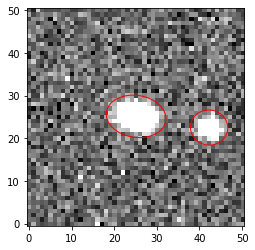

In [180]:
blend_id14 = np.where(flags14 == 1)[0][28]
runner14.plot_sex_obj(sep_res14[blend_id14], blended_14[blend_id14]['galsim_image_noisy'])

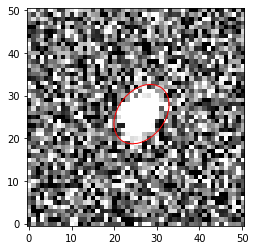

In [182]:
no_blend_id14 = np.where(flags14 == 0)[0][4]
runner14.plot_sex_obj(sep_res14[no_blend_id14], blended_14[no_blend_id14]['galsim_image_noisy'])

# 4. Test SExtractor on 80000 images ($\sigma_{noise} = 18.0$)

In [127]:
path18 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_18'

In [128]:
blended_18 = np.load(path18 + '/blended_noisy.npy', allow_pickle=True)
blended_18.shape

(40000,)

### Run Sextractor

In [183]:
runner18 = Run_Sep()
flags18, sep_res18 = runner18.process(blended_18)

18.10283088684082
20.021854400634766
18.7412052154541
18.366973876953125
18.061155319213867
18.095470428466797
18.5573673248291
18.29650115966797
19.093875885009766
18.590517044067383
19.521509170532227
18.246875762939453
18.631362915039062
19.93248176574707
17.827653884887695
20.053544998168945
19.140981674194336
18.382810592651367
18.18648910522461
18.433822631835938
18.42672348022461
18.320547103881836
19.721668243408203
19.574487686157227
18.727924346923828
18.078140258789062
18.407068252563477
18.62038803100586
18.27695083618164
18.41508674621582
18.59372329711914
18.11669158935547
18.168310165405273
18.557872772216797
17.89213752746582
18.90170669555664
18.72072982788086
18.337034225463867
18.541746139526367
18.43058204650879
18.093257904052734
18.100296020507812
18.679759979248047
20.00163459777832
21.481124877929688
18.745559692382812
18.667064666748047
18.476776123046875
17.72580909729004
18.265527725219727
19.025463104248047
18.388124465942383
24.357177734375
18.0536499023437

19.514240264892578
18.39430046081543
19.66636848449707
18.513643264770508
18.693843841552734
18.738399505615234
18.761211395263672
18.46005630493164
18.52467918395996
18.186744689941406
17.700069427490234
20.790929794311523
18.472457885742188
18.182735443115234
17.645292282104492
18.078153610229492
18.980493545532227
18.313541412353516
18.344558715820312
18.20068359375
18.353137969970703
17.993362426757812
19.213329315185547
18.71180534362793
18.569740295410156
18.67983627319336
18.330677032470703
19.26651954650879
18.762195587158203
18.769927978515625
19.483562469482422
19.314123153686523
19.426673889160156
19.285234451293945
18.06451988220215
17.88701820373535
17.90857696533203
18.385562896728516
19.126930236816406
18.409725189208984
18.772432327270508
18.93936538696289
18.099111557006836
18.072317123413086
17.760480880737305
18.514055252075195
19.186174392700195
18.584285736083984
164.57420349121094
18.13667106628418
18.591957092285156
18.267324447631836
18.107295989990234
18.547016

18.583541870117188
18.628063201904297
18.30531883239746
18.57189178466797
18.0401554107666
18.682559967041016
18.64531707763672
18.16939926147461
18.46968650817871
18.723983764648438
18.596956253051758
19.760892868041992
18.3596134185791
18.441011428833008
18.311031341552734
20.105195999145508
19.306529998779297
18.38425636291504
19.090259552001953
21.86144256591797
18.229673385620117
18.394393920898438
17.932872772216797
18.75345802307129
18.686002731323242
18.6802978515625
18.562328338623047
18.258440017700195
20.017541885375977
18.126062393188477
18.34823226928711
18.524560928344727
17.99854278564453
18.660106658935547
18.601985931396484
19.27610969543457
18.215890884399414
18.87605094909668
18.50848960876465
19.169483184814453
18.600984573364258
18.200164794921875
18.989410400390625
18.845571517944336
17.56306266784668
18.955245971679688
18.573328018188477
18.886789321899414
18.162431716918945
25.184114456176758
18.20168113708496
17.782594680786133
19.379228591918945
18.65510368347

20.48341941833496
18.898319244384766
18.379377365112305
18.470638275146484
18.792085647583008
18.694337844848633
18.717662811279297
17.984426498413086
17.909259796142578
18.98590660095215
18.63485336303711
18.383865356445312
18.869365692138672
18.18785858154297
18.62953758239746
17.93436050415039
17.73611068725586
18.503822326660156
18.804039001464844
18.683971405029297
18.32074546813965
18.814144134521484
18.4434757232666
18.934906005859375
18.298736572265625
18.654598236083984
17.837787628173828
18.176372528076172
25.236780166625977
18.553783416748047
19.782398223876953
18.627864837646484
18.712568283081055
19.818206787109375
18.270952224731445
18.641220092773438
18.578357696533203
19.235618591308594
19.529272079467773
18.807209014892578
18.274255752563477
18.543088912963867
19.33135986328125
18.882247924804688
18.255159378051758
18.07802963256836
18.365333557128906
17.765451431274414
18.2480411529541
18.57837677001953
19.229387283325195
18.464262008666992
18.265764236450195
18.16179

20.739160537719727
17.96530532836914
18.10978126525879
18.037099838256836
17.59309959411621
18.2071590423584
18.374134063720703
18.656511306762695
18.27073860168457
18.245336532592773
19.254467010498047
18.525634765625
18.55430793762207
18.06017303466797
17.885398864746094
18.28312110900879
18.96990394592285
19.821964263916016
23.00029945373535
18.45279312133789
18.364572525024414
22.30632209777832
18.429780960083008
17.99571418762207
17.904375076293945
18.414579391479492
18.21124839782715
18.69451141357422
18.639652252197266
18.450824737548828
18.726787567138672
18.1805477142334
18.290626525878906
18.775514602661133
17.68050765991211
18.921525955200195
18.053504943847656
17.97650718688965
18.765657424926758
18.88328742980957
18.605167388916016
18.612754821777344
18.224367141723633
18.314340591430664
18.728252410888672
17.85832977294922
18.535663604736328
19.055419921875
18.381704330444336
18.676923751831055
17.926563262939453
18.403654098510742
18.921018600463867
18.728124618530273
18

18.74606704711914
22.83042335510254
18.975801467895508
17.84623908996582
19.041887283325195
18.333494186401367
18.924762725830078
18.571739196777344
19.147045135498047
18.21246337890625
18.2652587890625
17.806049346923828
18.132753372192383
18.431310653686523
18.468181610107422
18.53985023498535
18.85150718688965
18.982267379760742
17.5897159576416
18.775039672851562
20.193668365478516
18.459028244018555
20.063016891479492
19.164379119873047
18.17645263671875
19.225841522216797
18.831180572509766
18.243127822875977
18.66783332824707
18.292945861816406
20.33709716796875
18.00251007080078
18.525188446044922
18.489795684814453
18.250959396362305
18.764514923095703
18.684125900268555
18.98116111755371
18.607439041137695
18.615798950195312
18.56743812561035
19.297311782836914
18.131254196166992
18.057191848754883
18.822370529174805
24.968151092529297
18.270061492919922
18.54720115661621
18.622268676757812
17.98897361755371
18.54864501953125
18.745420455932617
18.721460342407227
18.382638931

19.23247528076172
18.484365463256836
18.630779266357422
18.415674209594727
19.04815101623535
18.60709571838379
18.13576889038086
18.617597579956055
18.53862953186035
18.58687400817871
18.18073081970215
18.62838363647461
18.44500732421875
26.386991500854492
18.80858612060547
18.338632583618164
18.067960739135742
18.516101837158203
18.873157501220703
19.217235565185547
20.083600997924805
18.7874813079834
18.566513061523438
17.776704788208008
18.136268615722656
18.33942985534668
18.71220588684082
18.51527214050293
19.517654418945312
18.38229751586914
18.418392181396484
17.903179168701172
17.932960510253906
18.53428077697754
19.483144760131836
18.527332305908203
18.25088882446289
18.20690155029297
18.296377182006836
18.388259887695312
17.78471565246582
18.488080978393555
18.080766677856445
18.464174270629883
18.20220375061035
18.89046859741211
18.295372009277344
18.24289321899414
18.31097984313965
17.989654541015625
18.09015464782715
18.2707576751709
18.363435745239258
18.501352310180664
1

19.405899047851562
19.312570571899414
18.751028060913086
21.407590866088867
18.687286376953125
18.26258087158203
18.490341186523438
20.289169311523438
18.13397789001465
19.2820987701416
18.53730583190918
18.18202781677246
18.043296813964844
24.877107620239258
18.01755714416504
18.59468650817871
18.846324920654297
17.72112274169922
19.00374412536621
17.993457794189453
18.404237747192383
18.467575073242188
18.515371322631836
156.52122497558594
18.934988021850586
21.125438690185547
19.178892135620117
18.265729904174805
20.553199768066406
17.95363426208496
18.367061614990234
18.406503677368164
20.00950813293457
18.236804962158203
18.439579010009766
18.77215576171875
18.384037017822266
19.53898048400879
18.67355728149414
18.579143524169922
18.247167587280273
18.903667449951172
18.68050193786621
18.163959503173828
18.453693389892578
19.612016677856445
18.4227294921875
18.197734832763672
18.660768508911133
20.67561149597168
17.754261016845703
18.652469635009766
18.43035125732422
18.2858200073

18.71242904663086
18.366785049438477
18.572946548461914
18.357173919677734
19.093154907226562
18.746505737304688
18.314271926879883
18.29005241394043
18.82103729248047
18.144399642944336
18.71422004699707
18.220090866088867
19.384658813476562
18.039508819580078
17.845993041992188
19.24419403076172
17.890392303466797
18.529621124267578
17.780527114868164
18.1956787109375
18.145042419433594
18.13271141052246
18.728038787841797
18.11481285095215
17.853145599365234
18.949745178222656
18.19121551513672
18.541547775268555
18.53953742980957
18.70712661743164
18.302053451538086
18.37090301513672
18.455236434936523
18.671730041503906
18.409597396850586
18.29064178466797
18.24165153503418
18.7208309173584
18.351015090942383
18.128082275390625
18.520294189453125
19.280038833618164
25.938066482543945
19.131954193115234
18.758760452270508
18.319232940673828
19.367475509643555
20.464895248413086
18.32990264892578
18.432266235351562
18.228586196899414
17.92152214050293
18.205045700073242
18.658721923

18.41733169555664
22.219772338867188
18.875774383544922
19.36366844177246
18.523283004760742
18.53571128845215
18.685014724731445
18.388038635253906
18.207061767578125
18.192350387573242
18.768272399902344
18.96541976928711
17.831350326538086
18.227001190185547
18.173198699951172
18.59433937072754
18.693700790405273
18.096492767333984
17.907217025756836
18.580434799194336
18.884254455566406
18.317724227905273
17.984312057495117
18.036998748779297
18.391054153442383
18.887144088745117
18.743011474609375
18.73296546936035
18.343839645385742
18.284330368041992
18.214109420776367
19.565126419067383
18.471324920654297
18.68915367126465
18.231767654418945
18.163028717041016
18.455028533935547
18.43126678466797
18.786996841430664
19.286331176757812
17.978252410888672
18.31597137451172
19.16122055053711
18.66133689880371
18.263090133666992
18.09214973449707
18.54269027709961
19.07677459716797
18.162967681884766
18.602231979370117
19.009010314941406
18.033592224121094
17.628293991088867
18.2450

18.640254974365234
18.16769027709961
17.951786041259766
18.180049896240234
18.592138290405273
18.33858299255371
18.41410255432129
17.789823532104492
18.747699737548828
18.85723114013672
18.685264587402344
17.93910026550293
18.379419326782227
18.70124053955078
18.08986473083496
18.268041610717773
18.888017654418945
19.468442916870117
18.30316734313965
21.99692726135254
19.488759994506836
18.50543785095215
20.187938690185547
26.683330535888672
18.11455726623535
18.410511016845703
28.951162338256836
17.507102966308594
18.113895416259766
18.371746063232422
18.052125930786133
18.347078323364258
18.743839263916016
18.63811683654785
18.417713165283203
19.148853302001953
18.31649398803711
17.934005737304688
19.528057098388672
18.938491821289062
18.14626693725586
18.69095802307129
17.97134780883789
18.662918090820312
18.523408889770508
18.09695816040039
17.919950485229492
19.0318603515625
18.801321029663086
19.505815505981445
20.61582374572754
18.957733154296875
20.09002113342285
19.00353622436

18.989212036132812
20.952075958251953
18.531005859375
18.381656646728516
18.793682098388672
18.91637420654297
18.022930145263672
18.072402954101562
19.2938289642334
17.975919723510742
18.590259552001953
18.88262176513672
23.972116470336914
18.364038467407227
18.13045883178711
19.052274703979492
18.994340896606445
18.775554656982422
18.924453735351562
18.227527618408203
18.54926872253418
17.62843132019043
18.230199813842773
20.147090911865234
19.04646873474121
18.26565933227539
18.55367660522461
18.199853897094727
18.079830169677734
18.285335540771484
18.015466690063477
18.3111629486084
18.43766975402832
18.359554290771484
18.6160945892334
18.205224990844727
18.577274322509766
18.34544563293457
18.01731300354004
18.56448745727539
22.44406509399414
18.243532180786133
17.784591674804688
18.887081146240234
19.978084564208984
19.217529296875
19.131221771240234
18.94786262512207
19.132247924804688
18.728322982788086
17.931678771972656
18.35709571838379
18.156028747558594
18.46581268310547
18

18.92730140686035
18.61099624633789
18.862979888916016
17.570646286010742
18.536794662475586
18.345674514770508
18.61185073852539
18.02410888671875
18.948007583618164
18.485713958740234
18.91645622253418
18.257427215576172
23.30988311767578
18.7963809967041
23.089366912841797
18.167009353637695
18.598169326782227
18.327205657958984
18.3909912109375
17.830228805541992
21.887210845947266
19.175750732421875
18.951416015625
18.52362823486328
18.301639556884766
18.946117401123047
18.70067024230957
18.164033889770508
18.17624282836914
18.785425186157227
17.995546340942383
18.808813095092773
18.13384246826172
17.61396598815918
18.62764549255371
19.955808639526367
20.85344123840332
18.30706024169922
18.580842971801758
18.948774337768555
17.827068328857422
18.198741912841797
18.79648780822754
18.554887771606445
21.248830795288086
18.799604415893555
18.93557357788086
18.30937957763672
19.493818283081055
18.787025451660156
18.39076042175293
18.12462615966797
18.551292419433594
18.08005142211914
1

18.595640182495117
19.106477737426758
18.475326538085938
17.91290855407715
18.547216415405273
18.1148738861084
18.555587768554688
19.19407844543457
17.496990203857422
18.71755599975586
18.296009063720703
20.848054885864258
19.610488891601562
18.299936294555664
19.995269775390625
18.46190071105957
19.078868865966797
18.553701400756836
18.648855209350586
18.063079833984375
17.95393180847168
19.10141372680664
18.597585678100586
18.229568481445312
18.475017547607422
17.968229293823242
17.969057083129883
18.364818572998047
19.973949432373047
18.375837326049805
19.07735824584961
19.119426727294922
18.585840225219727
18.476985931396484
20.116151809692383
17.74893569946289
18.691041946411133
18.330419540405273
18.88035011291504
18.394371032714844
18.277265548706055
18.673351287841797
19.06020164489746
18.26055335998535
18.690227508544922
18.109031677246094
21.505123138427734
18.383684158325195
18.455947875976562
18.417585372924805
18.098533630371094
18.926055908203125
18.57497215270996
18.4258

17.885000228881836
18.67583465576172
17.809782028198242
18.536848068237305
18.6240291595459
18.78373908996582
21.199003219604492
18.524229049682617
18.42101287841797
19.968652725219727
18.004505157470703
18.860612869262695
18.62507438659668
17.8425235748291
18.3889217376709
19.76840591430664
20.08786392211914
17.6830997467041
20.40123176574707
17.817663192749023
19.85219955444336
21.329605102539062
18.119112014770508
18.232879638671875
18.198238372802734
18.02874755859375
18.684009552001953
18.563770294189453
18.670316696166992
18.265329360961914
18.7291202545166
18.22377586364746
17.742292404174805
18.68672752380371
19.366113662719727
18.148681640625
18.021997451782227
19.26518440246582
19.82160758972168
18.600448608398438
18.433631896972656
18.38979148864746
18.485103607177734
18.606565475463867
19.263839721679688
18.834251403808594
18.85904884338379
18.24081802368164
18.5953369140625
19.31670379638672
18.22117805480957
18.48436737060547
27.304283142089844
18.47545623779297
18.202491

17.955944061279297
18.273365020751953
18.520830154418945
18.51434326171875
17.349620819091797
20.148822784423828
18.430208206176758
18.447237014770508
18.69524383544922
18.449813842773438
21.82649040222168
18.506610870361328
18.857406616210938
18.381975173950195
18.594602584838867
18.765443801879883
18.39571762084961
18.938812255859375
17.790456771850586
18.326274871826172
18.02984619140625
18.549699783325195
18.53121566772461
18.25956916809082
18.817968368530273
18.542396545410156
18.490882873535156
18.37862777709961
18.431209564208984
18.13833999633789
17.96250343322754
18.617572784423828
18.995040893554688
18.557979583740234
20.03877830505371
19.105722427368164
18.230449676513672
19.555294036865234
18.145965576171875
18.391456604003906
18.257932662963867
18.27132225036621
18.675195693969727
18.88994026184082
18.897117614746094
18.684783935546875
18.022228240966797
19.17293357849121
18.388961791992188
19.154882431030273
18.304189682006836
18.246606826782227
19.125789642333984
18.8070

18.584815979003906
18.28153419494629
20.622116088867188
18.204526901245117
18.05504035949707
21.936372756958008
18.188268661499023
18.70377540588379
18.15020751953125
18.12948989868164
18.473926544189453
18.31637191772461
18.580074310302734
20.04605484008789
17.98366355895996
18.272438049316406
18.116779327392578
18.23731803894043
20.040987014770508
18.781587600708008
18.59764289855957
18.42859649658203
17.898759841918945
18.199180603027344
18.933944702148438
20.231800079345703
18.41752052307129
18.11161994934082
18.587705612182617
18.441011428833008
18.464004516601562
18.366647720336914
18.567718505859375
18.74643325805664
22.145614624023438
18.079389572143555
17.64418601989746
17.884462356567383
18.763973236083984
17.923961639404297
17.86104393005371
18.23546028137207
18.3342342376709
18.12109375
18.267526626586914
19.82083511352539
17.506608963012695
18.542020797729492
18.448034286499023
18.315834045410156
18.56882095336914
18.44694709777832
18.487886428833008
18.786487579345703
19.

19.05826759338379
17.685400009155273
18.565288543701172
18.81475067138672
18.483718872070312
18.071046829223633
18.59358024597168
19.03672981262207
18.88663673400879
18.253782272338867
19.268800735473633
18.44770050048828
18.381322860717773
18.263919830322266
17.846134185791016
18.13735580444336
19.388277053833008
18.78748321533203
18.507280349731445
19.03548812866211
18.731136322021484
18.25164222717285
18.756044387817383
17.925806045532227
18.089813232421875
18.113014221191406
18.40053939819336
18.123109817504883
18.44052505493164
17.450143814086914
18.300395965576172
18.223051071166992
17.926677703857422
18.25016975402832
18.426315307617188
19.824867248535156
18.555532455444336
18.650142669677734
18.001270294189453
18.310562133789062
18.55186653137207
18.947818756103516
17.96351432800293
18.567310333251953
19.267868041992188
18.55202293395996
19.168350219726562
18.340526580810547
18.350208282470703
18.005876541137695
18.90564727783203
18.174549102783203
18.360681533813477
18.0060386

18.465660095214844
18.3797607421875
18.087100982666016
17.865161895751953
18.38700294494629
18.285335540771484
19.86349105834961
18.985219955444336
18.49721336364746
17.891902923583984
18.601545333862305
18.668861389160156
18.243927001953125
17.493820190429688
24.938945770263672
18.70863914489746
18.444873809814453
18.47300910949707
18.144184112548828
18.582019805908203
18.478410720825195
18.190664291381836
18.736345291137695
18.390634536743164
31.10346794128418
22.242198944091797
17.969961166381836
17.932157516479492
18.2512264251709
18.445526123046875
18.700777053833008
18.183870315551758
19.619033813476562
18.577346801757812
18.179040908813477
18.493629455566406
18.624469757080078
18.485034942626953
19.0197696685791
18.647279739379883
19.754940032958984
18.995296478271484
18.70401382446289
17.878345489501953
17.966562271118164
18.11871910095215
19.631736755371094
18.314538955688477
19.348766326904297
19.6499080657959
18.525754928588867
18.69228744506836
19.046770095825195
18.6626873

18.54180335998535
18.60826873779297
17.94784927368164
18.52751350402832
18.321876525878906
17.75568389892578
18.280498504638672
17.77947235107422
18.950021743774414
19.462722778320312
18.884109497070312
18.373849868774414
18.156686782836914
18.769689559936523
18.536415100097656
19.279218673706055
19.070842742919922
18.43332290649414
17.979772567749023
18.39522933959961
18.22650718688965
18.538333892822266
18.36001205444336
17.991987228393555
19.328458786010742
18.246217727661133
18.864330291748047
18.805219650268555
18.65569305419922
19.552656173706055
18.733762741088867
18.624544143676758
18.21162223815918
18.603200912475586
19.25002670288086
19.201967239379883
19.07713508605957
18.188583374023438
18.56679344177246
18.22288703918457
18.418596267700195
18.296009063720703
18.273794174194336
18.26217269897461
19.254486083984375
18.150075912475586
18.945905685424805
18.862506866455078
18.226163864135742
18.859237670898438
19.016679763793945
20.223541259765625
18.632373809814453
18.5200767

19.027938842773438
18.87310218811035
18.50059700012207
19.924571990966797
18.31873893737793
19.07975959777832
20.773698806762695
18.045677185058594
18.251354217529297
26.239315032958984
18.66046142578125
18.13775062561035
18.270153045654297
18.657886505126953
17.744600296020508
18.42734718322754
18.58646583557129
18.118045806884766
18.575408935546875
18.632925033569336
18.20595359802246
17.852338790893555
18.674699783325195
18.414430618286133
18.608997344970703
18.867511749267578
19.33030891418457
19.01578712463379
20.230653762817383
33.787391662597656
18.29129981994629
19.349123001098633
18.67270278930664
19.765125274658203
19.631330490112305
19.740766525268555
19.080421447753906
18.595449447631836
18.511268615722656
19.040210723876953
19.30613136291504
18.12959098815918
18.594005584716797
18.466596603393555
18.06146812438965
18.06351661682129
18.310991287231445
18.335359573364258
18.352554321289062
18.495769500732422
19.569664001464844
18.575899124145508
20.69124984741211
18.93604850

18.33079719543457
18.714914321899414
18.917095184326172
18.236099243164062
18.235647201538086
18.83380126953125
18.437288284301758
18.88898277282715
18.57552719116211
18.698863983154297
18.974422454833984
18.0404109954834
18.075761795043945
18.819812774658203
18.851333618164062
18.342729568481445
18.26726722717285
18.474348068237305
17.922870635986328
18.348228454589844
18.594955444335938
18.267961502075195
18.452484130859375
20.207550048828125
18.14227294921875
18.48532485961914
18.23234748840332
18.3564453125
25.581777572631836
18.513099670410156
19.3906192779541
18.397621154785156
22.311782836914062
18.78876304626465
18.280532836914062
23.768659591674805
21.297672271728516
19.16541862487793
19.566301345825195
18.351276397705078
18.831960678100586
18.436580657958984
18.356924057006836
18.598974227905273
18.309667587280273
18.250354766845703
18.224653244018555
17.933734893798828
18.159523010253906
18.442258834838867
18.11125373840332
18.273956298828125
20.620037078857422
17.9608306884

18.13622283935547
18.026762008666992
17.860633850097656
19.10971450805664
18.43081283569336
17.78730583190918
17.86701202392578
18.41094970703125
18.676143646240234
18.696115493774414
18.410682678222656
18.69200325012207
17.982595443725586
18.511953353881836
18.164779663085938
18.67560386657715
18.835708618164062
18.095521926879883
18.34176254272461
18.264923095703125
18.61508560180664
18.17717170715332
19.63539695739746
18.548776626586914
18.70942497253418
17.857145309448242
17.9451904296875
18.147418975830078
18.77566909790039
18.347797393798828
18.49827766418457
18.45473289489746
18.510887145996094
17.672191619873047
17.988492965698242
18.089128494262695
18.353137969970703
17.830101013183594
18.482404708862305
18.245418548583984
19.193605422973633
19.30995750427246
18.55697250366211
17.70781135559082
18.206018447875977
18.751380920410156
17.88777732849121
17.952966690063477
20.35329818725586
18.466297149658203
19.92774772644043
19.289752960205078
18.519678115844727
18.51390075683593

18.432117462158203
18.756507873535156
17.93855857849121
18.404848098754883
18.580734252929688
18.581193923950195
18.298023223876953
18.549381256103516
17.943222045898438
18.731300354003906
19.82119369506836
19.2674503326416
18.084609985351562
18.15726089477539
17.848960876464844
19.583894729614258
19.031917572021484
18.420066833496094
18.31141471862793
24.622190475463867
18.453155517578125
18.302553176879883
19.227779388427734
17.753841400146484
18.30262565612793
17.963685989379883
18.446395874023438
18.869308471679688
18.026899337768555
17.680992126464844
17.987077713012695
18.50992202758789
18.591089248657227
19.839792251586914
25.76374053955078
18.34293556213379
18.518817901611328
18.69469451904297
18.201801300048828
20.41853141784668
18.137170791625977
17.86884117126465
19.35330581665039
18.175525665283203
18.16587257385254
18.072446823120117
18.521678924560547
18.2371883392334
18.640214920043945
20.590503692626953
17.886451721191406
17.95060157775879
18.038057327270508
17.80238723

18.052143096923828
17.8265323638916
18.593732833862305
18.045028686523438
17.736927032470703
18.53553581237793
18.923643112182617
18.062240600585938
18.60424041748047
18.282577514648438
17.76305389404297
22.129487991333008
18.670799255371094
104.21569061279297
19.700328826904297
19.05366325378418
18.120040893554688
21.304391860961914
18.189138412475586
22.885168075561523
18.456130981445312
19.199405670166016
20.276535034179688
18.09515380859375
17.735532760620117
20.721956253051758
18.49070167541504
18.160411834716797
18.34770393371582
18.248550415039062
20.17528533935547
18.55462074279785
17.824129104614258
18.84100341796875
18.026140213012695
18.085710525512695
18.59661102294922
17.368450164794922
19.370586395263672
18.450321197509766
18.021591186523438
18.734670639038086
18.870018005371094
19.08940887451172
18.77298355102539
18.404293060302734
18.139204025268555
17.77800750732422
19.32904624938965
18.13409423828125
17.67943572998047
19.145973205566406
18.35549545288086
17.7669620513

21.252788543701172
17.59794807434082
18.877023696899414
20.662717819213867
18.199750900268555
18.940370559692383
19.478652954101562
21.064668655395508
17.828699111938477
17.942886352539062
18.07633399963379
18.198650360107422
44.454551696777344
18.966445922851562
18.19554901123047
22.948909759521484
17.74237060546875
18.526409149169922
18.262271881103516
18.991418838500977
18.92205047607422
18.05103302001953
17.50287437438965
18.433252334594727
19.17784309387207
18.623760223388672
19.33305549621582
18.192773818969727
18.641101837158203
18.574724197387695
18.822858810424805
21.938814163208008
18.77069091796875
18.479455947875977
18.858070373535156
18.560842514038086
18.402435302734375
18.534149169921875
19.009841918945312
18.759891510009766
20.714704513549805
18.899904251098633
18.014577865600586
18.24696159362793
18.25369644165039
18.290863037109375
18.31338119506836
17.962905883789062
18.443374633789062
18.71700668334961
19.338871002197266
18.25989532470703
18.530136108398438
18.43798

18.226903915405273
20.32868766784668
18.078506469726562
19.350248336791992
17.972103118896484
19.03636932373047
18.127117156982422
18.153488159179688
19.19265365600586
19.026269912719727
18.529890060424805
19.905616760253906
18.054920196533203
18.205551147460938
19.0336856842041
18.6687068939209
20.454275131225586
18.693328857421875
18.11602210998535
17.898073196411133
18.09575080871582
18.988876342773438
18.713397979736328
19.046241760253906
19.316675186157227
18.28636932373047
20.985599517822266
19.863285064697266
18.26444435119629
17.950851440429688
18.70856475830078
19.4017333984375
18.621807098388672
17.957735061645508
18.731544494628906
17.752988815307617
18.239959716796875
18.37665557861328
18.354902267456055
19.55465316772461
18.715444564819336
18.602325439453125
17.697294235229492
18.516786575317383
18.132349014282227
18.439533233642578
18.54157829284668
19.2456111907959
18.974605560302734
18.434267044067383
18.645673751831055
18.70451545715332
18.4761962890625
18.637634277343

19.1016902923584
17.929399490356445
18.68572235107422
18.512014389038086
18.075773239135742
18.120023727416992
18.26173210144043
17.99564552307129
18.287555694580078
18.94112777709961
19.213964462280273
17.642080307006836
18.460844039916992
18.136018753051758
18.361114501953125
18.490318298339844
18.251211166381836
18.648895263671875
18.319011688232422
18.71457862854004
20.547502517700195
22.636096954345703
18.677194595336914
18.540271759033203
18.607526779174805
18.441431045532227
18.144014358520508
18.525842666625977
19.771730422973633
17.894689559936523
20.014711380004883
18.35332679748535
17.9921932220459
18.44082260131836
18.335805892944336
18.029727935791016
18.503822326660156
19.018320083618164
18.920989990234375
17.608762741088867
18.784786224365234
18.819276809692383
18.927885055541992
18.55061149597168
18.47540283203125
18.261356353759766
18.625829696655273
18.001203536987305
18.08299446105957
18.004352569580078
17.902116775512695
18.15598487854004
18.507579803466797
17.93953

19.020551681518555
18.581144332885742
18.419937133789062
20.45561981201172
18.754179000854492
18.477397918701172
17.899158477783203
18.169843673706055
19.12371253967285
18.02460289001465
18.070703506469727
18.5480899810791
18.401790618896484
18.100454330444336
20.756669998168945
18.42824363708496
18.145795822143555
18.206613540649414
18.693635940551758
18.188135147094727
19.263137817382812
18.53294563293457
18.28150749206543
18.52056121826172
18.382658004760742
18.805200576782227
18.247833251953125
18.44532012939453
17.71814727783203
18.329883575439453
18.3753662109375
18.31361198425293
18.493560791015625
18.586862564086914
18.566205978393555
17.752328872680664
18.735193252563477
18.407793045043945
18.156808853149414
18.424760818481445
21.05733871459961
18.422138214111328
18.34937858581543
18.611902236938477
18.90225601196289
18.59920310974121
19.067758560180664
18.62737464904785
18.170621871948242
18.6641845703125
18.823537826538086
18.276609420776367
18.51898193359375
18.447160720825

18.62162208557129
18.198993682861328
20.203323364257812
18.749757766723633
19.351734161376953
24.618043899536133
18.367279052734375
17.954830169677734
18.317760467529297
20.13315200805664
18.55244255065918
18.76919937133789
18.27155113220215
19.54625701904297
18.364974975585938
18.633398056030273
18.805463790893555
17.90760040283203
19.1143856048584
18.951234817504883
20.813678741455078
18.31721305847168
18.46360206604004
18.562543869018555
21.467548370361328
18.336137771606445
18.055519104003906
17.85247039794922
18.701486587524414
18.943342208862305
19.180660247802734
19.656587600708008
18.13393211364746
17.945507049560547
18.251110076904297
18.71673583984375
19.71816062927246
19.203365325927734
17.99764060974121
18.228395462036133
18.09089469909668
18.801599502563477
18.06450653076172
18.831378936767578
19.180612564086914
18.149892807006836
18.264747619628906
18.559192657470703
18.399953842163086
18.21210479736328
18.414302825927734
19.09117317199707
18.274641036987305
18.9452037811

18.931657791137695
18.978654861450195
18.22318458557129
18.57396697998047
18.320297241210938
20.694116592407227
17.964462280273438
19.07264518737793
18.150962829589844
17.924840927124023
18.697246551513672
18.258167266845703
17.94512939453125
20.202346801757812
19.119752883911133
20.662654876708984
18.557199478149414
18.252605438232422
17.91461944580078
19.33077621459961
18.653228759765625
18.444700241088867
17.942052841186523
18.513633728027344
18.19345474243164
18.691818237304688
18.178909301757812
19.341203689575195
18.19121742248535
19.908151626586914
18.004405975341797
18.05974006652832
17.788297653198242
17.849510192871094
19.146390914916992
18.336654663085938
18.154504776000977
18.98638916015625
18.07829475402832
17.874250411987305
17.978391647338867
18.125717163085938
18.65041160583496
18.48625373840332
18.76285743713379
18.25397300720215
17.742162704467773
18.74631690979004
19.199596405029297
18.091552734375
18.276762008666992
18.684268951416016
18.3558349609375
18.88998794555

18.25661849975586
18.596040725708008
17.864482879638672
18.542177200317383
18.10137367248535
18.379337310791016
19.261714935302734
18.04625701904297
18.06557846069336
19.083969116210938
18.073793411254883
18.978797912597656
17.955886840820312
18.478668212890625
18.255212783813477
17.425996780395508
17.6987247467041
28.644351959228516
21.94382667541504
21.18414878845215
18.693349838256836
18.383384704589844
20.790233612060547
19.147336959838867
18.49399757385254
19.126117706298828
21.498571395874023
18.17549705505371
17.92911720275879
19.069887161254883
17.88018226623535
18.833580017089844
18.078943252563477
19.02992057800293
18.417573928833008
18.313671112060547
19.123992919921875
18.81993865966797
19.008390426635742
18.274593353271484
19.611806869506836
18.49418830871582
18.30792808532715
19.024799346923828
18.521568298339844
18.583641052246094
20.54560661315918
18.4952449798584
18.072751998901367
17.970449447631836
18.258134841918945
18.62017059326172
17.94407081604004
18.17611694335

18.42287826538086
19.71692657470703
17.873380661010742
18.428199768066406
18.110139846801758
18.263395309448242
18.861618041992188
23.672378540039062
17.859525680541992
18.586793899536133
19.014801025390625
18.410913467407227
18.09929847717285
18.124534606933594
18.08696937561035
17.973419189453125
18.401081085205078
18.091951370239258
17.863479614257812
18.32325553894043
18.35645866394043
102.96788787841797
18.511281967163086
18.29176139831543
18.349246978759766
21.454374313354492
17.773942947387695
19.567760467529297
18.580272674560547
20.419687271118164
18.9469051361084
18.4128360748291
18.998775482177734
19.043842315673828
18.580726623535156
18.179471969604492
18.35757827758789
18.80712127685547
17.9461727142334
18.106220245361328
18.748348236083984
18.90898323059082
18.533952713012695
17.53814125061035
18.58431053161621
18.054119110107422
18.538373947143555
21.110898971557617
18.392189025878906
18.862533569335938
18.3008975982666
17.95696258544922
18.59709358215332
18.194263458251

19.929927825927734
18.449039459228516
20.624984741210938
18.9738712310791
24.176963806152344
18.156164169311523
19.888486862182617
19.46263313293457
19.188560485839844
18.539960861206055
18.408937454223633
17.83407974243164
18.621484756469727
17.855762481689453
18.159095764160156
18.38396453857422
18.695903778076172
17.94684410095215
18.2313289642334
18.844942092895508
18.510896682739258
18.686559677124023
18.578746795654297
17.935522079467773
18.609933853149414
18.53290367126465
18.472084045410156
18.784378051757812
18.20501708984375
18.208066940307617
18.926239013671875
18.667680740356445
18.651960372924805
18.34119415283203
18.7791748046875
18.40000343322754
18.61331558227539
18.725828170776367
18.672883987426758
22.37799644470215
18.46596908569336
18.435644149780273
18.132646560668945
18.992469787597656
20.61629295349121
18.123645782470703
18.292490005493164
18.485027313232422
18.09194564819336
18.03756332397461
17.888948440551758
19.61635971069336
19.127065658569336
18.25085449218

18.74235725402832
18.19037628173828
18.40282440185547
18.275814056396484
18.44534683227539
18.907350540161133
18.523998260498047
18.44080352783203
18.367626190185547
17.684947967529297
18.38755989074707
17.965993881225586
19.9766845703125
18.473621368408203
18.797266006469727
18.528152465820312
25.12447738647461
18.14999771118164
18.42076301574707
18.555322647094727
18.137908935546875
18.67523956298828
19.63245391845703
18.94333839416504
18.641361236572266
18.87578773498535
21.246366500854492
17.86009407043457
18.32909393310547
18.442110061645508
18.283601760864258
18.392024993896484
18.25254249572754
18.657917022705078
18.30876350402832
18.387109756469727
18.246265411376953
19.069690704345703
18.62523078918457
18.603986740112305
18.61071014404297
18.182147979736328
18.59745216369629
18.796857833862305
17.696134567260742
19.51123809814453
21.75143814086914
20.2854061126709
17.74593734741211
17.966358184814453
18.843433380126953
18.355180740356445
17.915315628051758
18.782163619995117
1

18.297883987426758
18.362863540649414
18.08242416381836
18.02666664123535
18.53624725341797
18.0167179107666
18.425094604492188
18.86402702331543
18.592859268188477
18.00828742980957
19.551618576049805
18.875032424926758
18.01154136657715
18.660215377807617
18.49905014038086
17.94552993774414
18.464553833007812
20.091400146484375
18.04681968688965
17.714895248413086
17.958995819091797
19.89504051208496
18.625431060791016
18.362173080444336
17.999082565307617
18.48954963684082
18.42795181274414
19.01504135131836
18.519420623779297
18.165239334106445
18.809738159179688
18.053287506103516
18.536874771118164
17.840152740478516
18.851890563964844
18.123830795288086
18.33115577697754
18.66969108581543
21.278776168823242
20.665109634399414
18.799657821655273
18.123106002807617
18.057310104370117
19.136789321899414
20.481891632080078
17.970476150512695
18.414888381958008
18.121116638183594
18.615394592285156
22.564870834350586
20.805288314819336
18.199726104736328
18.35137367248535
19.42118263

19.811277389526367
18.596914291381836
19.079477310180664
18.090171813964844
18.719146728515625
18.31289291381836
17.95009422302246
18.74881935119629
18.3568172454834
18.764373779296875
17.945480346679688
20.980731964111328
18.802692413330078
18.554119110107422
17.849559783935547
19.02762794494629
17.841480255126953
18.76750946044922
18.580671310424805
18.407331466674805
18.794361114501953
18.324953079223633
17.894750595092773
18.26056480407715
22.16682243347168
18.96000862121582
18.334915161132812
20.488203048706055
18.3709774017334
18.194753646850586
18.563705444335938
19.142675399780273
18.751638412475586
19.625272750854492
18.415367126464844
18.180763244628906
19.56544303894043
18.277196884155273
18.033409118652344
18.25438117980957
18.60788345336914
18.934417724609375
18.256420135498047
18.370412826538086
18.460336685180664
18.825260162353516
19.50420570373535
18.182878494262695
19.107839584350586
18.942211151123047
19.159605026245117
18.623491287231445
18.3094482421875
18.92562294

19.270143508911133
18.35376739501953
19.79282569885254
18.425174713134766
19.349884033203125
18.102294921875
18.472185134887695
18.023447036743164
18.95107650756836
18.363277435302734
18.59560775756836
18.931331634521484
18.758502960205078
17.556015014648438
18.87706184387207
18.603334426879883
18.185556411743164
19.046762466430664
17.9838924407959
18.67540168762207
21.204294204711914
18.139236450195312
18.145183563232422
18.09063148498535
18.430103302001953
18.22763442993164
18.133502960205078
17.924226760864258
18.384822845458984
19.358226776123047
18.17328453063965
21.13652229309082
18.548540115356445
18.47941780090332
18.49945068359375
18.02411460876465
18.838825225830078
18.889785766601562
18.536537170410156
21.586406707763672
18.12205696105957
18.549015045166016
17.682357788085938
18.006908416748047
18.25834846496582
19.165424346923828
18.842166900634766
18.65157127380371
18.650720596313477
18.507061004638672
18.204038619995117
18.859155654907227
19.001590728759766
19.86678504943

18.166967391967773
18.243141174316406
18.644845962524414
18.04791831970215
19.449787139892578
18.166000366210938
18.3499698638916
18.28880500793457
22.16901206970215
20.23046875
18.692138671875
18.669633865356445
18.347097396850586
18.539531707763672
18.508726119995117
18.374603271484375
18.191064834594727
18.24988555908203
18.751813888549805
18.060850143432617
18.365671157836914
18.48206901550293
18.08548927307129
18.379602432250977
17.808618545532227
18.464061737060547
19.207775115966797
17.80167007446289
18.52411651611328
23.223175048828125
17.883760452270508
18.22076988220215
19.137983322143555
18.575637817382812
21.285062789916992
19.183738708496094
18.26988410949707
17.884069442749023
18.198959350585938
18.597747802734375
18.320262908935547
17.987226486206055
18.67384147644043
18.508039474487305
18.96124839782715
18.686981201171875
18.992897033691406
18.935760498046875
18.47113609313965
20.464998245239258
18.046382904052734
19.154998779296875
18.697147369384766
17.941253662109375

18.48572540283203
18.828765869140625
17.882253646850586
18.22787094116211
18.105993270874023
19.35024070739746
18.825786590576172
19.600265502929688
18.423057556152344
18.209863662719727
18.2847900390625
18.571603775024414
18.385461807250977
18.32309341430664
18.343751907348633
18.462474822998047
18.112712860107422
18.85148811340332
18.686641693115234
19.108125686645508
18.416046142578125
18.67976951599121
19.76740074157715
18.97873878479004
17.770864486694336
18.077608108520508
19.00162696838379
19.739917755126953
18.049758911132812
18.142114639282227
19.528968811035156
18.34606170654297
19.59735870361328
18.9925479888916
17.821149826049805
18.00442123413086
19.084571838378906
17.99125099182129
18.334049224853516
19.210878372192383
18.278532028198242
18.474546432495117
18.857221603393555
18.75843620300293
20.687847137451172
18.387744903564453
18.03374481201172
18.158954620361328
20.11687469482422
18.97298240661621
18.589570999145508
17.872665405273438
19.461444854736328
18.25970458984

17.803817749023438
25.579124450683594
18.58407974243164
18.507160186767578
18.393299102783203
18.55101776123047
18.469322204589844
18.90570068359375
18.146432876586914
21.948287963867188
18.103939056396484
18.963336944580078
18.84738540649414
18.21946144104004
18.473468780517578
18.109437942504883
18.458255767822266
18.607385635375977
19.95073699951172
18.344717025756836
17.965696334838867
17.935028076171875
18.516674041748047
18.268238067626953
17.90933609008789
18.34244155883789
18.621826171875
17.62320899963379
18.919208526611328
18.98727035522461
18.228628158569336
19.065032958984375
17.7661190032959
21.215776443481445
18.350278854370117
18.343997955322266
18.48679542541504
18.58683967590332
18.802854537963867
18.30600929260254
19.260784149169922
18.472875595092773
21.32328987121582
19.606393814086914
18.0179443359375
17.901105880737305
18.848791122436523
21.066699981689453
18.630203247070312
18.24188232421875
18.698034286499023
17.85385513305664
19.099746704101562
20.1384124755859

18.678979873657227
18.04000473022461
19.107534408569336
19.071855545043945
22.641942977905273
18.741485595703125
18.169775009155273
18.352556228637695
18.214736938476562
18.734891891479492
17.877382278442383
18.67844009399414
18.206628799438477
18.610824584960938
18.706628799438477
18.745773315429688
17.757835388183594
18.251455307006836
18.125782012939453
28.112703323364258
19.382404327392578
19.2806339263916
18.318866729736328
19.15087890625
17.998342514038086
18.261621475219727
18.209728240966797
17.88918685913086
18.543540954589844
20.001766204833984
18.05265235900879
17.90212059020996
19.746919631958008
19.533687591552734
19.05474281311035
18.79932975769043
18.15169906616211
18.68021011352539
18.25736427307129
18.048633575439453
18.3553524017334
18.262004852294922
19.346513748168945
18.176395416259766
18.086915969848633
20.15638542175293
18.504390716552734
18.221527099609375
18.581554412841797
18.993122100830078
21.194812774658203
19.059051513671875
19.385238647460938
18.623897552

18.368242263793945
18.492319107055664
18.56733512878418
25.930248260498047
18.030502319335938
19.463754653930664
17.842533111572266
18.37837028503418
18.374313354492188
22.033245086669922
18.533634185791016
17.93385887145996
17.999303817749023
18.947690963745117
18.995731353759766
18.888822555541992
18.525211334228516
18.250492095947266
18.432018280029297
18.459802627563477
18.319948196411133
19.456157684326172
19.4255428314209
18.261371612548828
18.056262969970703
19.3044490814209
18.11785888671875
19.44458770751953
18.640050888061523
18.444765090942383
18.278194427490234
21.483137130737305
18.35628318786621
18.033720016479492
17.9598388671875
20.483474731445312
18.515209197998047
18.64811134338379
18.180622100830078
18.916748046875
18.294124603271484
18.16383171081543
18.704978942871094
19.43520736694336
19.00745391845703
18.494596481323242
18.71578025817871
19.252931594848633
28.423622131347656
18.43289566040039
18.697166442871094
18.27555274963379
18.146812438964844
19.674737930297

18.45011329650879
19.065414428710938
18.662620544433594
18.443275451660156
17.545019149780273
21.087072372436523
19.25507164001465
18.417762756347656
18.622520446777344
19.228981018066406
18.7181396484375
17.82709503173828
19.00580406188965
18.06598472595215
18.273937225341797
18.704225540161133
19.01488494873047
18.644882202148438
18.86659049987793
18.603816986083984
18.648069381713867
19.128820419311523
19.098037719726562
18.623018264770508
33.38509750366211
18.224817276000977
17.845369338989258
18.358980178833008
18.79715347290039
18.37344741821289
18.627363204956055
18.286603927612305
19.162168502807617
20.14369773864746
18.41814613342285
18.260040283203125
18.22673797607422
18.321226119995117
18.107250213623047
19.943910598754883
18.86835479736328
18.064098358154297
18.629257202148438
27.931819915771484
18.549190521240234
18.06117820739746
18.967931747436523
18.460283279418945
17.9938907623291
18.993637084960938
18.528831481933594
18.12448501586914
17.797916412353516
18.0940513610

18.56669044494629
18.428237915039062
18.090486526489258
18.384981155395508
18.45418930053711
18.41798210144043
19.65743637084961
18.7272891998291
17.79523277282715
18.485214233398438
18.535478591918945
17.94524383544922
19.510520935058594
17.69318389892578
18.173086166381836
18.04196548461914
18.155153274536133
18.292858123779297
19.02825927734375
19.050180435180664
21.588796615600586
18.312280654907227
17.957416534423828
19.04039764404297
18.058691024780273
18.333574295043945
17.983783721923828
20.027036666870117
18.19938850402832
19.733753204345703
18.750516891479492
20.745128631591797
17.72514533996582
18.194381713867188
18.00527572631836
19.150123596191406
18.27189064025879
18.675443649291992
18.844491958618164
18.22336196899414
18.933095932006836
18.99066925048828
21.475008010864258
18.429603576660156
18.01663589477539
17.942785263061523
19.213115692138672
27.7585506439209
18.064739227294922
18.17483139038086
17.947166442871094
18.335365295410156
18.936357498168945
20.232254028320

18.330713272094727
17.968088150024414
18.503217697143555
17.973440170288086
18.867820739746094
18.65353012084961
18.516693115234375
38.322044372558594
18.24441146850586
18.45280647277832
18.79006004333496
18.095590591430664
18.927230834960938
18.040935516357422
17.877700805664062
18.791048049926758
18.127050399780273
19.11686897277832
18.759727478027344
18.163986206054688
18.862415313720703
18.593997955322266
17.998411178588867
18.178878784179688
18.460256576538086
18.28234100341797
18.063703536987305
17.963069915771484
18.976503372192383
18.288822174072266
18.420291900634766
18.951175689697266
17.76244354248047
17.923385620117188
20.094934463500977
18.218324661254883
17.746061325073242
18.522459030151367
18.18174171447754
20.177501678466797
19.01410675048828
18.368602752685547
18.7630615234375
17.97125244140625
18.45380973815918
19.13338851928711
18.317523956298828
18.64409828186035
18.630664825439453
18.797039031982422
18.306310653686523
18.348623275756836
18.120431900024414
19.26455

18.521442413330078
18.62433433532715
18.36595344543457
18.436275482177734
17.762937545776367
18.67816734313965
23.321577072143555
17.89299964904785
17.78716468811035
17.814626693725586
18.527599334716797
18.035520553588867
17.994327545166016
18.900718688964844
18.58576202392578
19.40723419189453
18.728546142578125
19.11391830444336
18.17357635498047
18.929073333740234
18.45488166809082
18.55031967163086
18.453048706054688
18.72271156311035
23.309627532958984
19.819622039794922
19.545663833618164
18.9566650390625
18.979860305786133
18.98341941833496
18.210994720458984
18.95195960998535
18.8837947845459
18.318180084228516
19.42239761352539
18.32582664489746
18.199888229370117
18.657495498657227
18.965269088745117
18.391857147216797
18.2202205657959
18.343019485473633
18.614307403564453
19.205106735229492
18.629716873168945
18.873830795288086
18.750089645385742
17.98542594909668
18.315189361572266
18.318899154663086
18.113767623901367
18.70804214477539
18.345012664794922
19.62720489501953

18.36111068725586
18.124679565429688
18.11261558532715
18.779701232910156
18.322492599487305
18.02570152282715
18.67928695678711
19.101282119750977
18.05617904663086
18.28250503540039
19.568164825439453
18.358156204223633
18.795005798339844
19.035402297973633
18.71123504638672
18.442873001098633
18.258869171142578
18.135190963745117
18.0733699798584
18.65987205505371
20.52878761291504
19.816858291625977
17.664594650268555
19.171289443969727
18.58481216430664
18.618295669555664
17.784442901611328
18.799612045288086
18.1630802154541
18.908672332763672
17.93283462524414
17.82443618774414
18.551652908325195
18.5159854888916
18.883432388305664
18.45318603515625
19.95241928100586
18.08823585510254
18.09176254272461
18.75290870666504
17.958589553833008
18.794992446899414
18.511741638183594
18.308908462524414
18.906635284423828
18.40017318725586
18.61974334716797
18.56038475036621
18.185914993286133
18.38444709777832
18.10403060913086
19.18013572692871
18.56934356689453
18.722442626953125
18.4

18.327451705932617
18.909578323364258
18.424413681030273
18.59011459350586
20.12689208984375
17.817873001098633
19.44767189025879
18.496450424194336
19.032136917114258
18.627147674560547
18.452075958251953
18.765363693237305
29.761472702026367
19.392972946166992
17.874792098999023
18.420209884643555
18.257184982299805
17.912418365478516
17.593589782714844
18.478771209716797
19.262847900390625
17.964162826538086
18.317129135131836
18.440305709838867
18.547718048095703
18.691282272338867
18.868085861206055
18.180095672607422
18.4826717376709
18.468891143798828
18.805706024169922
18.191667556762695
17.966806411743164
19.19780158996582
19.189502716064453
19.488439559936523
18.303979873657227
17.968402862548828
18.216508865356445
19.045625686645508
18.319360733032227
18.59576988220215
18.802284240722656
17.861526489257812
20.300832748413086
18.912118911743164
18.909666061401367
18.79281234741211
18.50731086730957
18.680709838867188
18.42800521850586
18.142040252685547
18.687959671020508
17.

22.686674118041992
18.223161697387695
18.03049087524414
19.59965705871582
17.972936630249023
18.37575340270996
18.202001571655273
18.52489471435547
18.30406379699707
18.770374298095703
18.383081436157227
18.426769256591797
18.597742080688477
18.603532791137695
18.461959838867188
17.84442138671875
19.204111099243164
17.770177841186523
18.36504554748535
18.964262008666992
18.693723678588867
17.96436309814453
18.748939514160156
18.423885345458984
18.44830322265625
18.571744918823242
18.180917739868164
17.91301155090332
18.447866439819336
19.878793716430664
18.451860427856445
17.92693328857422
37.514869689941406
17.980709075927734
18.419143676757812
18.974355697631836
20.57099723815918
18.91669273376465
18.18573570251465
17.84911346435547
18.431135177612305
21.148971557617188
19.30733299255371
19.081743240356445
18.971181869506836
18.725337982177734
17.811935424804688
17.71018409729004
17.718250274658203
18.185266494750977
18.295690536499023
18.552753448486328
18.22773551940918
19.78708076

20.31058120727539
19.797710418701172
18.834794998168945
19.985244750976562
18.069669723510742
18.677677154541016
18.549283981323242
19.839670181274414
19.18976402282715
17.814353942871094
20.905139923095703
18.539981842041016
18.43486785888672
17.97846794128418
18.11768913269043
18.446157455444336
18.34560775756836
18.202804565429688
18.1593017578125
18.12247657775879
18.267566680908203
18.345930099487305
18.187192916870117
18.063812255859375
18.11397933959961
18.609371185302734
19.249177932739258
19.104711532592773
18.053794860839844
18.4713077545166
18.230594635009766
18.366779327392578
18.52909278869629
18.37449073791504
18.100473403930664
19.228944778442383
21.92668914794922
18.91366958618164
17.837121963500977
18.310054779052734
17.89816665649414
18.30870246887207
18.19846534729004
18.344087600708008
19.40007972717285
20.303495407104492
18.352577209472656
18.220840454101562
18.486007690429688
18.886119842529297
17.8526611328125
18.60589027404785
18.78995132446289
18.46047210693359

18.747220993041992
28.86647605895996
18.43516731262207
19.48885726928711
17.97002601623535
18.34663963317871
18.491518020629883
19.342458724975586
20.969829559326172
18.29355239868164
18.469776153564453
18.423572540283203
18.835317611694336
19.813058853149414
22.18204116821289
19.699426651000977
17.867897033691406
18.056631088256836
18.116504669189453
18.600831985473633
17.8162899017334
18.77799415588379
17.707996368408203
18.499223709106445
17.897268295288086
18.389122009277344
22.015520095825195
20.175508499145508
18.656465530395508
18.00687026977539
18.949045181274414
19.350576400756836
18.342788696289062
18.374828338623047
18.861957550048828
17.46605110168457
21.350046157836914
18.902158737182617
19.39044189453125
18.288921356201172
18.284103393554688
18.910993576049805
18.31841278076172
18.179224014282227
26.09600257873535
18.567523956298828
18.234617233276367
18.686983108520508
18.532676696777344
18.71195411682129
18.37761688232422
23.56898307800293
18.64744758605957
18.048227310

17.96430015563965
18.9655704498291
19.286182403564453
25.86507797241211
18.840002059936523
17.949541091918945
18.27739143371582
19.654983520507812
18.63545036315918
22.954069137573242
17.862897872924805
19.0239315032959
18.380878448486328
18.77532958984375
18.74333953857422
18.779632568359375
17.913084030151367
57.934814453125
17.784460067749023
17.96059226989746
18.528091430664062
18.385787963867188
20.017498016357422
18.59697151184082
18.758737564086914
18.73004913330078
18.399110794067383
18.281850814819336
17.570444107055664
31.030061721801758
18.648839950561523
19.698389053344727
18.363330841064453
24.09079933166504
18.603822708129883
18.725067138671875
42.37746810913086
17.92352867126465
19.301910400390625
19.175277709960938
20.319839477539062
18.6392879486084
19.06023406982422
18.526535034179688
18.960372924804688
18.846233367919922
18.557729721069336
18.637014389038086
18.05989646911621
18.31337547302246
18.271726608276367
19.66335678100586
17.88105010986328
18.60384178161621
1

19.938047409057617
18.626497268676758
20.841638565063477
18.250619888305664
19.446706771850586
18.544010162353516
18.428550720214844
18.723777770996094
18.77491569519043
18.192171096801758
18.60986328125
18.937538146972656
20.334697723388672
18.556182861328125
21.29285430908203
18.896095275878906
18.200260162353516
18.380529403686523
18.365150451660156
18.302492141723633
23.831897735595703
18.479732513427734
18.72504997253418
19.335493087768555
18.527124404907227
19.003068923950195
18.0267391204834
18.459938049316406
21.1350154876709
18.96780776977539
18.12229347229004
18.533082962036133
19.143890380859375
18.232593536376953
18.228546142578125
17.954999923706055
18.721271514892578
18.30013656616211
18.296506881713867
18.580245971679688
18.47705841064453
18.237279891967773
18.55568504333496
19.491817474365234
18.952152252197266
18.684185028076172
17.731843948364258
18.575727462768555
19.63387680053711
18.093488693237305
18.36441993713379
18.82013702392578
20.739355087280273
18.706707000

19.00465202331543
19.714513778686523
18.370664596557617
18.38003921508789
20.579164505004883
22.593976974487305
18.348371505737305
18.377403259277344
18.230043411254883
18.42178726196289
18.09564781188965
18.872983932495117
17.74844741821289
18.460121154785156
18.821937561035156
18.46216583251953
18.434917449951172
18.608287811279297
18.076648712158203
18.640810012817383
18.426179885864258
19.06566047668457
19.730087280273438
18.632122039794922
18.116371154785156
17.95501708984375
18.213560104370117
18.94815444946289
18.413833618164062
19.11587905883789
17.93166732788086
18.59235191345215
18.189191818237305
18.36648941040039
19.17351531982422
17.896154403686523
18.85635757446289
17.983144760131836
18.20234489440918
18.576744079589844
18.311418533325195
19.697265625
18.474424362182617
18.856122970581055
18.481311798095703
19.807790756225586
18.533946990966797
18.91065788269043
17.870494842529297
17.90829849243164
18.826656341552734
18.14999771118164
18.683151245117188
18.626930236816406

19.889404296875
18.596044540405273
18.719470977783203
19.204023361206055
18.4594783782959
17.88274574279785
18.24546241760254
18.780078887939453
18.670486450195312
17.544795989990234
18.325529098510742
18.022682189941406
19.259014129638672
18.531591415405273
18.814208984375
17.98708724975586
18.56382179260254
18.06390380859375
17.793386459350586
18.18523597717285
19.14435386657715
30.839948654174805
18.53754425048828
18.847272872924805
19.0831241607666
21.44860076904297
18.82295036315918
19.53229522705078
18.832666397094727
23.071735382080078
19.09918785095215
19.693119049072266
18.21622085571289
18.208541870117188
18.981874465942383
23.67892074584961
45.21343994140625
18.542373657226562
18.49458122253418
18.533367156982422
18.57622718811035
18.260610580444336
19.590559005737305
18.639415740966797
19.27819061279297
18.527700424194336
18.906251907348633
18.690540313720703
18.447765350341797
18.688289642333984
17.92282485961914
18.463163375854492
18.865280151367188
19.267850875854492
17.

18.341651916503906
19.249204635620117
18.187952041625977
18.3147029876709
18.4378719329834
18.022605895996094
18.959253311157227
18.98328399658203
18.204240798950195
18.44864845275879
19.917583465576172
18.493797302246094
17.93963623046875
18.85248374938965
18.03155517578125
17.905424118041992
18.779943466186523
18.54073715209961
18.165996551513672
18.58953857421875
18.177915573120117
19.048139572143555
19.19688606262207
18.3337345123291
18.79396629333496
18.497159957885742
19.35158920288086
18.99440574645996
18.099071502685547
18.635583877563477
18.79308319091797
18.1314697265625
17.993974685668945
18.02443504333496
19.130701065063477
18.361013412475586
19.57110023498535
19.163171768188477
18.946622848510742
18.31192398071289
18.623294830322266
18.641944885253906
18.200422286987305
18.851438522338867
18.3455753326416
19.15184783935547
18.5717830657959
17.941301345825195
18.162025451660156
19.144086837768555
18.3641357421875
21.825838088989258
18.91212272644043
17.82842445373535
18.235

18.719987869262695
18.567319869995117
17.99346351623535
18.04435920715332
18.589405059814453
18.256195068359375
18.333343505859375
18.857656478881836
18.95628547668457
18.676929473876953
18.161834716796875
17.99332618713379
18.323104858398438
18.634397506713867
19.623180389404297
24.322694778442383
18.276084899902344
20.772319793701172
18.481964111328125
19.166780471801758
18.342538833618164
17.841384887695312
18.763978958129883
18.076690673828125
18.306642532348633
17.5605411529541
18.0783634185791
18.371891021728516
18.567550659179688
18.537078857421875
18.203920364379883
19.253623962402344
19.139909744262695
18.41927146911621
18.670732498168945
18.27591323852539
18.468372344970703
18.98797607421875
18.24254035949707
18.694395065307617
21.325536727905273
18.400896072387695
18.364023208618164
18.504161834716797
41.0931510925293
18.27445411682129
20.105857849121094
18.221132278442383
19.249597549438477
18.833473205566406
18.4449462890625
18.84807777404785
18.445995330810547
18.61171722

18.950328826904297
18.550939559936523
18.883569717407227
19.499008178710938
18.43712615966797
18.135986328125
19.303346633911133
17.975887298583984
19.28278350830078
18.29373550415039
18.18914794921875
18.535259246826172
18.39653968811035
20.617259979248047
18.926576614379883
18.989255905151367
18.4924259185791
18.255760192871094
18.818681716918945
18.67238426208496
18.560043334960938
18.567216873168945
18.061996459960938
18.84886932373047
18.355783462524414
33.35868835449219
17.6909122467041
18.568552017211914
18.9594669342041
18.778467178344727
18.920740127563477
18.804983139038086
19.17113494873047
17.639923095703125
18.516523361206055
19.507503509521484
18.064125061035156
18.241653442382812
18.085494995117188
17.610639572143555
20.992616653442383
18.033035278320312
17.990039825439453
18.588483810424805
18.098447799682617
18.228612899780273
18.347585678100586
18.70888328552246
18.35918617248535
18.466955184936523
19.319202423095703
19.100034713745117
18.815629959106445
18.4601058959

18.594066619873047
18.182147979736328
18.061573028564453
17.985036849975586
18.825538635253906
18.274768829345703
17.96744728088379
18.25810432434082
18.61715316772461
18.404884338378906
18.2221622467041
19.23660659790039
18.728565216064453
18.3573055267334
18.514123916625977
18.52143669128418
18.76012420654297
17.91790199279785
18.668493270874023
18.856508255004883
18.430252075195312
18.98775863647461
17.942276000976562
18.098876953125
18.30198097229004
18.1028995513916
18.96769142150879
19.71878433227539
17.969255447387695
18.363821029663086
18.582927703857422
18.131351470947266
18.569063186645508
18.5888729095459
18.82908058166504
18.338706970214844
19.235395431518555
18.460031509399414
18.6591854095459
17.997455596923828
18.28017807006836
19.18218231201172
20.400854110717773
18.26067352294922
19.621484756469727
43.085533142089844
18.22677993774414
17.75910758972168
19.018749237060547
18.652660369873047
18.453847885131836
18.536746978759766
17.58835220336914
19.045198440551758
18.12

19.884033203125
18.788454055786133
18.18877410888672
19.20081901550293
18.032848358154297
18.453819274902344
18.783767700195312
18.857540130615234
18.336050033569336
81.5924072265625
18.52723503112793
18.044084548950195
19.201688766479492
19.75575065612793
18.030780792236328
19.518186569213867
18.05976676940918
18.46632194519043
18.847091674804688
17.5727596282959
18.919727325439453
17.8773136138916
18.507619857788086
18.722553253173828
18.112274169921875
18.564882278442383
21.073232650756836
18.427955627441406
19.423307418823242
18.738967895507812
19.149303436279297
19.640262603759766
17.836769104003906
17.97380828857422
20.189760208129883
18.414228439331055
18.301538467407227
18.376358032226562
18.16519546508789
19.448944091796875
18.011585235595703
18.340023040771484
21.902782440185547
18.504150390625
17.98278045654297
18.92406463623047
17.792613983154297
18.581172943115234
19.006807327270508
18.092483520507812
18.82024383544922
18.367868423461914
18.7977237701416
18.54228401184082


18.048614501953125
18.141704559326172
18.278858184814453
17.90522575378418
17.998897552490234
18.229419708251953
18.232826232910156
18.23831558227539
18.65150260925293
17.700321197509766
18.656925201416016
18.490591049194336
20.066810607910156
18.302230834960938
17.531709671020508
19.48472785949707
19.80372428894043
19.953205108642578
32.42902755737305
18.953174591064453
18.584348678588867
18.223466873168945
20.791292190551758
18.88149070739746
18.297012329101562
18.494441986083984
18.296777725219727
18.068859100341797
18.729001998901367
18.20623016357422
17.766149520874023
18.49149513244629
18.64069366455078
17.919536590576172
18.55858612060547
17.911104202270508
19.167430877685547
19.113643646240234
18.107755661010742
18.1214656829834
18.10481834411621
18.868125915527344
18.43073272705078
18.13150405883789
18.603271484375
18.85849952697754
19.59927749633789
19.622095108032227
17.741336822509766
18.198314666748047
18.637544631958008
18.308433532714844
18.45522117614746
18.639976501464

18.515865325927734
17.995317459106445
17.901948928833008
18.62322998046875
18.547391891479492
20.1695499420166
18.414182662963867
18.1815242767334
18.229787826538086
18.309633255004883
18.062397003173828
19.160995483398438
19.158578872680664
18.799440383911133
18.701679229736328
18.566295623779297
18.076257705688477
18.779979705810547
18.44769859313965
19.08963394165039
18.77428436279297
19.047016143798828
18.61334228515625
19.10746192932129
18.1055908203125
17.6837100982666
18.551860809326172
19.1226863861084
21.808252334594727
18.86591911315918
18.081361770629883
18.673038482666016
18.53666114807129
18.097164154052734
19.283363342285156
18.807392120361328
18.782493591308594
18.573680877685547
18.717273712158203
18.304906845092773
19.010292053222656
18.496601104736328
17.9096736907959
18.372629165649414
18.415512084960938
17.90215492248535
17.819974899291992
18.585403442382812
17.87485694885254
18.757776260375977
18.19646453857422
17.87534523010254
18.43155288696289
20.38296127319336


17.99346160888672
17.992687225341797
18.749738693237305
18.617481231689453
18.528284072875977
19.125595092773438
19.893798828125
18.034639358520508
17.908845901489258
18.18683624267578
18.664058685302734
18.96320343017578
18.374727249145508
18.606189727783203
18.512353897094727
17.70209503173828
18.734729766845703
18.140396118164062
17.853260040283203
23.35825538635254
18.474218368530273
20.198287963867188
18.06766700744629
18.710725784301758
17.903949737548828
18.0173282623291
18.510848999023438
18.152204513549805
19.01840591430664
18.07176971435547
18.200902938842773
18.42425537109375
18.4989013671875
18.665300369262695
18.023122787475586
18.544967651367188
18.48975944519043
18.890405654907227
18.921701431274414
18.157276153564453
18.498273849487305
18.88273811340332
26.92789077758789
18.723220825195312
18.774761199951172
18.92538833618164
18.754018783569336
18.990802764892578
18.59480857849121
18.955110549926758
18.787363052368164
18.38873863220215
19.370296478271484
19.129848480224

18.672765731811523
18.097993850708008
18.343610763549805
17.797929763793945
17.93230628967285
18.61347007751465
17.921314239501953
18.78457260131836
18.481842041015625
17.692272186279297
19.08448028564453
17.776371002197266
18.357561111450195
18.14394187927246
18.95554542541504
18.911359786987305
19.039079666137695
19.663375854492188
17.90145492553711
18.994384765625
19.020845413208008
18.426982879638672
18.572128295898438
18.583683013916016
19.375267028808594
17.849180221557617
19.614791870117188
20.284399032592773
18.249597549438477
18.517303466796875
18.1004695892334
18.309118270874023
18.440141677856445
18.331298828125
18.29911994934082
18.596792221069336
17.940597534179688
18.549381256103516
19.932756423950195
17.69208526611328
18.59575843811035
18.779212951660156
24.198575973510742
18.606891632080078
18.357742309570312
18.00478172302246
20.69814109802246
18.26943588256836
18.14811897277832
20.512388229370117
18.15252113342285
23.627342224121094
18.39275360107422
18.39805603027343

17.988149642944336
19.551538467407227
18.775999069213867
20.36783790588379
18.141813278198242
18.374982833862305
22.400985717773438
19.1818790435791
18.190200805664062
20.398975372314453
18.60235023498535
18.485675811767578
19.22307777404785
18.556812286376953
18.158815383911133
17.632917404174805
18.547988891601562
19.321006774902344
18.508464813232422
17.91832160949707
19.03245735168457
19.022216796875
17.865489959716797
18.434701919555664
18.31135368347168
18.368080139160156
18.948514938354492
18.78765869140625
18.159055709838867
18.43654441833496
18.946317672729492
18.68564796447754
18.281354904174805
18.52513313293457
17.833057403564453
18.624034881591797
18.458559036254883
18.133577346801758
18.996597290039062
18.550687789916992
19.718307495117188
19.021936416625977
18.126148223876953
19.175573348999023
18.999576568603516
18.030986785888672
18.788042068481445
18.275894165039062
18.05815315246582
18.047771453857422
18.51171875
17.93966293334961
29.061946868896484
18.81723976135254

18.435312271118164
22.04498863220215
17.949642181396484
18.51701545715332
18.53022575378418
18.162940979003906
18.58307456970215
18.368566513061523
20.985624313354492
18.556848526000977
18.502687454223633
18.694005966186523
19.01620101928711
18.08048439025879
18.26488494873047
18.969106674194336
18.80434226989746
18.168737411499023
18.235212326049805
18.1038761138916
19.40611457824707
18.0930118560791
19.902029037475586
17.9681339263916
19.109249114990234
18.784156799316406
18.58147621154785
18.208240509033203
17.996034622192383
19.09542465209961
18.300315856933594
18.500171661376953
18.761333465576172
19.188966751098633
18.45961570739746
18.02809715270996
18.681201934814453
18.434415817260742
18.639482498168945
18.263364791870117
19.36498260498047
18.886707305908203
18.397802352905273
18.715106964111328
18.63960838317871
19.097673416137695
18.193374633789062
18.558549880981445
18.747474670410156
19.88881492614746
19.02862548828125
20.626667022705078
19.041034698486328
18.7292785644531

18.371246337890625
19.888269424438477
18.813539505004883
18.801015853881836
18.6079158782959
20.559791564941406
17.819032669067383
18.67682456970215
18.717308044433594
18.621564865112305
18.98567008972168
33.5984001159668
17.883089065551758
26.891828536987305
18.85577392578125
18.428062438964844
18.222543716430664
18.223787307739258
19.040021896362305
18.958145141601562
18.676349639892578
23.516042709350586
19.530189514160156
18.806455612182617
18.075071334838867
18.751745223999023
20.694494247436523
18.8172550201416
18.35747718811035
18.527034759521484
18.1203556060791
19.461549758911133
17.914752960205078
18.76362419128418
19.493980407714844
17.91117286682129
18.201839447021484
18.19692039489746
18.487648010253906
17.961105346679688
18.6567440032959
18.353103637695312
19.327648162841797
18.39303970336914
18.519298553466797
18.431041717529297
17.813034057617188
17.901601791381836
18.03990364074707
18.8801212310791
19.822315216064453
17.885955810546875
18.519006729125977
18.85915374755

19.39223861694336
30.319299697875977
18.1518497467041
19.246198654174805
19.042247772216797
17.538368225097656
21.528690338134766
19.10361099243164
18.69649887084961
18.426557540893555
18.556734085083008
17.756933212280273
18.398761749267578
18.832765579223633
19.240968704223633
18.743427276611328
19.19574737548828
18.143184661865234
18.471485137939453
18.656776428222656
19.022974014282227
18.514738082885742
18.608625411987305
18.720157623291016
18.137359619140625
18.317459106445312
18.560928344726562
22.79075050354004
18.737789154052734
18.630996704101562
18.101806640625
18.52211570739746
17.90233039855957
18.327823638916016
19.190488815307617
18.46513557434082
18.669837951660156
19.180696487426758
18.863174438476562
18.235605239868164
18.64967155456543
18.17716407775879
18.935775756835938
18.697345733642578
21.095548629760742
18.406606674194336
18.379390716552734
18.517980575561523
18.72332000732422
18.525537490844727
18.511402130126953
19.600448608398438
18.695756912231445
18.550464

18.426176071166992
18.172367095947266
18.13922119140625
18.636837005615234
18.05280113220215
18.532249450683594
18.411012649536133
18.35106658935547
17.924407958984375
18.443117141723633
18.60527992248535
18.128124237060547
18.376277923583984
18.466537475585938
19.310260772705078
18.607498168945312
18.253202438354492
18.328012466430664
17.828678131103516
17.998979568481445
21.260629653930664
29.426010131835938
18.334308624267578
18.734867095947266
18.68939208984375
19.083667755126953
17.990144729614258
21.311260223388672
45.60996627807617
19.35405921936035
18.16732406616211
19.748376846313477
18.080718994140625
18.04696273803711
17.762205123901367
18.6617374420166
19.386167526245117
18.23849105834961
18.53646469116211
19.51683807373047
18.011459350585938
18.623079299926758
18.809051513671875
18.925006866455078
18.180999755859375
18.543045043945312
18.09299659729004
18.785856246948242
23.117015838623047
17.84477996826172
18.51342010498047
18.599794387817383
18.700456619262695
18.8624763

18.464536666870117
18.041820526123047
18.827180862426758
19.07511329650879
17.88027000427246
18.7103271484375
19.33643913269043
18.373310089111328
17.690885543823242
18.626251220703125
18.560346603393555
18.90038299560547
18.74135971069336
18.82900047302246
19.046619415283203
18.43268585205078
18.309772491455078
18.728317260742188
18.84889030456543
20.097198486328125
18.310049057006836
18.313249588012695
18.33421516418457
18.515329360961914
18.070045471191406
18.797060012817383
18.53839683532715
18.530086517333984
21.94159507751465
18.843481063842773
18.277555465698242
18.385866165161133
18.750261306762695
18.857297897338867
18.179391860961914
18.381927490234375
19.487934112548828
17.721181869506836
18.170270919799805
18.71257972717285
18.009435653686523
19.856365203857422
18.572669982910156
18.9058837890625
18.985191345214844
18.514583587646484
18.41524887084961
18.440288543701172
20.933109283447266
18.79474449157715
17.9464168548584
18.134592056274414
19.16014862060547
19.57280921936

18.274486541748047
18.295886993408203
19.234580993652344
17.892990112304688
18.18010711669922
18.170080184936523
17.630111694335938
18.158193588256836
18.72043800354004
18.830551147460938
18.239580154418945
17.770055770874023
19.272951126098633
17.651432037353516
18.370832443237305
18.5776424407959
18.535470962524414
18.07975959777832
18.931018829345703
18.199604034423828
19.001611709594727
18.00095558166504
18.044898986816406
19.611934661865234
19.251327514648438
18.314477920532227
19.03857421875
17.970609664916992
22.4738712310791
18.45237159729004
18.32653045654297
18.19318199157715
19.144922256469727
18.44514274597168
17.780439376831055
18.381763458251953
21.394664764404297
19.041494369506836
18.303804397583008
18.92117691040039
18.280607223510742
18.345298767089844
18.347427368164062
18.54151725769043
17.837766647338867
18.3923282623291
18.332733154296875
19.128297805786133
18.108139038085938
18.58298683166504
19.091726303100586
18.165189743041992
18.602216720581055
18.14454269409

18.658475875854492
18.419239044189453
18.35873031616211
18.023771286010742
18.572101593017578
18.565601348876953
18.009504318237305
18.478879928588867
18.765907287597656
18.330671310424805
19.196250915527344
18.92119026184082
18.210002899169922
18.091218948364258
18.204200744628906
18.32208251953125
18.86433219909668
17.6329402923584
18.82958984375
20.26764678955078
25.18222427368164
18.6982421875
18.44446563720703
17.990680694580078
18.58560562133789
19.101274490356445
18.840341567993164
19.622772216796875
18.06463623046875
18.55525779724121
18.314916610717773
18.402246475219727
19.995012283325195
18.601829528808594
18.776309967041016
19.2789249420166
18.905296325683594
18.2224063873291
18.90388298034668
18.436016082763672
20.48948860168457
18.30339241027832
17.939970016479492
18.323326110839844
18.375659942626953
18.522661209106445
22.964380264282227
18.797704696655273
18.42041015625
18.534618377685547
18.356403350830078
19.713924407958984
18.765602111816406
19.673065185546875
18.292

18.05412483215332
17.930818557739258
18.444164276123047
18.781278610229492
17.94388771057129
19.321517944335938
18.23676109313965
17.693838119506836
18.425947189331055
17.98723602294922
18.866653442382812
18.560043334960938
18.34474754333496
19.247896194458008
18.065732955932617
18.288484573364258
18.54479217529297
19.22355079650879
18.312986373901367
18.22405242919922
17.82245635986328
17.867719650268555
18.255231857299805
18.052366256713867
18.684619903564453
18.079317092895508
18.437252044677734
17.85224151611328
18.275102615356445
18.716644287109375
18.25421714782715
18.33546257019043
18.304649353027344
18.777223587036133
46.04580307006836
18.478626251220703
18.083330154418945
18.35967445373535
18.952980041503906
19.079919815063477
18.06340789794922
18.392070770263672
17.890361785888672
17.303041458129883
18.39693832397461
18.35251235961914
18.85895538330078
18.522441864013672
18.235383987426758
18.953407287597656
17.746707916259766
18.591352462768555
18.18529510498047
19.713254928

18.232847213745117
21.12106704711914
18.84853744506836
18.323829650878906
18.40798568725586
19.12269401550293
21.433942794799805
18.348220825195312
18.96142578125
20.74347686767578
17.608346939086914
18.249391555786133
18.11317253112793
18.1159610748291
18.131044387817383
19.27679443359375
20.063552856445312
18.26592254638672
18.63199806213379
18.644136428833008
18.722909927368164
18.07283592224121
20.33322525024414
22.864439010620117
18.31840705871582
18.487211227416992
19.290851593017578
18.63759994506836
19.071802139282227
18.5809383392334
18.341318130493164
18.473169326782227
18.53965950012207
18.427621841430664
18.1794376373291
20.91863250732422
17.833026885986328
18.350122451782227
27.084678649902344
19.27071762084961
18.660987854003906
18.33029556274414
18.239431381225586
18.327411651611328
18.230018615722656
17.991138458251953
17.997446060180664
18.617956161499023
19.060110092163086
18.347047805786133
17.873003005981445
19.14977264404297
19.985336303710938
18.37274932861328
18.

18.106294631958008
18.310354232788086
18.442228317260742
18.322175979614258
19.204299926757812
18.177602767944336
18.71105194091797
18.252534866333008
18.850353240966797
18.14704132080078
21.61557388305664
18.486236572265625
18.137609481811523
18.721858978271484
18.232275009155273
18.743206024169922
18.118436813354492
17.888059616088867
18.790311813354492
19.10087776184082
18.609525680541992
18.100784301757812
22.454181671142578
19.5644474029541
18.514047622680664
18.476232528686523
18.25212860107422
17.873458862304688
18.57969093322754
18.446298599243164
18.38352394104004
19.385662078857422
18.356740951538086
18.047138214111328
19.355417251586914
18.502134323120117
18.539234161376953
18.77126121520996
19.016624450683594
18.827516555786133
18.14776611328125
18.280216217041016
18.51544952392578
18.020883560180664
19.69349479675293
18.46751594543457
18.36749267578125
18.509700775146484
18.756628036499023
18.942718505859375
19.06304359436035
18.940898895263672
18.086471557617188
18.021039

18.690677642822266
22.463167190551758
18.850799560546875
18.46335220336914
21.618541717529297
18.75511932373047
19.338626861572266
18.303884506225586
18.104585647583008
20.239389419555664
18.254098892211914
18.551794052124023
18.698335647583008
18.56952667236328
19.15584373474121
34.168609619140625
18.283226013183594
19.085277557373047
19.3820858001709
17.979761123657227
18.337177276611328
18.31861686706543
18.344621658325195
19.017932891845703
18.370716094970703
18.643735885620117
18.607927322387695
18.37363052368164
17.76310920715332
19.36966896057129
18.085294723510742
18.113183975219727
18.366113662719727
17.748661041259766
17.826025009155273
18.202438354492188
18.391860961914062
18.33491325378418
18.469905853271484
17.561012268066406
18.348140716552734
18.454448699951172
18.513778686523438
18.715036392211914
18.164165496826172
20.248178482055664
18.95207405090332
18.112947463989258
18.490327835083008
18.556989669799805
18.60480308532715
18.37404441833496
17.98015594482422
18.06872

18.820859909057617
18.642946243286133
18.570594787597656
18.687217712402344
18.3500919342041
19.177406311035156
18.242830276489258
18.5482177734375
18.50029754638672
17.729766845703125
19.03251838684082
18.298301696777344
18.866817474365234
20.105430603027344
18.37898063659668
18.224931716918945
18.249746322631836
19.030071258544922
18.160842895507812
19.069896697998047
18.37234878540039
18.095924377441406
18.678503036499023
18.130966186523438
18.035587310791016
18.307910919189453
18.541677474975586
17.971744537353516
19.4705867767334
21.015045166015625
19.243907928466797
19.041582107543945
19.013607025146484
18.892019271850586
17.945432662963867
18.7293643951416
18.86463737487793
18.548847198486328
18.76891326904297
18.968223571777344
18.643125534057617
18.921985626220703
18.494314193725586
18.285863876342773
18.429445266723633
18.589765548706055
18.842844009399414
18.727500915527344
18.361509323120117
18.276525497436523
21.391002655029297
18.969135284423828
18.873767852783203
18.3291

19.421947479248047
18.073617935180664
23.72709083557129
18.54199981689453
20.392784118652344
18.496971130371094
20.094953536987305
18.40221405029297
18.6962947845459
18.87139892578125
18.815895080566406
19.189865112304688
21.88102912902832
18.378767013549805
18.590248107910156
18.187042236328125
17.683502197265625
18.414432525634766
18.759010314941406
18.484460830688477
20.255046844482422
18.051328659057617
18.55576515197754
18.3980770111084
18.04280662536621
18.599172592163086
21.843725204467773
18.187313079833984
19.211166381835938
18.28519630432129
17.8873348236084
21.05377197265625
18.148412704467773
17.909465789794922
18.292091369628906
18.80769157409668
40.95014572143555
18.423484802246094
21.220523834228516
18.22608757019043
18.421958923339844
18.659147262573242
24.211565017700195
18.35643768310547
18.097368240356445
38.62895965576172
18.472694396972656
18.251008987426758
18.755300521850586
18.792997360229492
18.20701026916504
18.12413215637207
18.78468132019043
17.8145122528076

18.555265426635742
18.24703598022461
18.23887825012207
19.30681037902832
18.308109283447266
19.251419067382812
18.618518829345703
19.038063049316406
17.90325164794922
17.86204719543457
18.529239654541016
18.228609085083008
18.521047592163086
18.626628875732422
18.155874252319336
18.457847595214844
18.45389747619629
19.03374481201172
18.734830856323242
18.71111488342285
18.281478881835938
18.09903335571289
17.64713478088379
18.344253540039062
18.24722671508789
19.10712242126465
19.17767906188965
18.19696617126465
24.404741287231445
18.375391006469727
18.668867111206055
19.059499740600586
19.036745071411133
17.94111442565918
20.346010208129883
18.489891052246094
20.81016731262207
19.8760986328125
18.35178565979004
28.71642303466797
19.502655029296875
18.07278823852539
19.174413681030273
18.795326232910156
18.09804916381836
18.469297409057617
18.056785583496094
18.64706039428711
18.006879806518555
19.500694274902344
18.872915267944336
18.196659088134766
18.33978271484375
18.69186401367187

In [184]:
n_blend18 = len(np.where(flags18 == 1)[0])/len(flags18)
n_noblend18 = len(np.where(flags18 == 0)[0])/len(flags18)
n_miss18 = len(np.where(flags18 == 16)[0])/len(flags18)


print('Blend accuracy : {:.2f}%'.format(n_blend18*100))
print('Blend missed : {:.2f}%'.format(n_noblend18*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss18*100))

Blend accuracy : 88.31%
Blend missed : 11.65%
Wrongly identify (false positives): 0.03%


#### We obtain an accuracy of `88.31% ` on blended images.

### Visualizing blend identification

<Figure size 432x288 with 0 Axes>

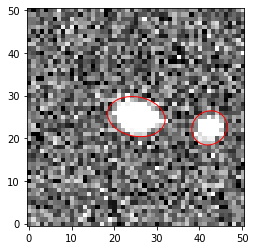

In [249]:
blend_id18 = np.where(flags18 == 1)[0][28]
fig2 = plt.figure()
runner18.plot_sex_obj(sep_res18[blend_id18], blended_18[blend_id18]['galsim_image_noisy'])
fig2.savefig('blend18.png')   # save the figure to file

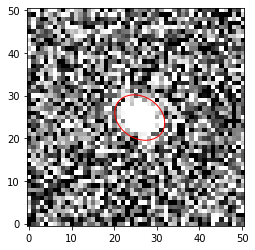

In [186]:
no_blend_id18 = np.where(flags18 == 0)[0][4]
runner18.plot_sex_obj(sep_res18[no_blend_id18], blended_18[no_blend_id18]['galsim_image_noisy'])

# 5. Test SExtractor on 80000 images ($\sigma_{noise} = 26.0$)

In [251]:
path26 = '/Users/alacan/Documents/Cosmostat/Codes/BlendHunter/bh_26'

In [252]:
blended_26 = np.load(path26 + '/blended_noisy.npy', allow_pickle=True)
blended_26.shape

(40000,)

### Run Sextractor

In [254]:
runner26 = Run_Sep()
flags26, sep_res26 = runner26.process(blended_26)

26.194419860839844
28.67264747619629
26.206295013427734
25.78139877319336
25.823394775390625
25.79884147644043
26.535432815551758
26.710865020751953
25.97088623046875
26.959056854248047
26.224563598632812
26.291887283325195
26.96567726135254
28.151599884033203
25.81914710998535
28.598041534423828
26.447906494140625
26.593849182128906
27.407413482666016
26.470958709716797
27.371681213378906
26.064441680908203
26.574966430664062
27.992883682250977
25.789335250854492
26.23945426940918
27.111400604248047
27.328649520874023
26.176156997680664
26.960201263427734
27.165632247924805
27.103700637817383
26.949764251708984
25.88687515258789
25.055591583251953
27.230337142944336
26.791095733642578
26.582090377807617
26.347848892211914
26.184635162353516
26.152788162231445
26.427831649780273
26.439664840698242
27.688444137573242
31.26457977294922
25.914443969726562
26.002031326293945
26.72599220275879
26.241565704345703
27.43665313720703
26.28826904296875
26.504409790039062
32.504676818847656
26.89

26.73390769958496
26.378671646118164
28.936140060424805
26.681835174560547
26.219743728637695
27.015199661254883
26.6049747467041
27.154748916625977
26.914716720581055
26.084012985229492
27.319664001464844
26.87255859375
26.630348205566406
26.948881149291992
27.093786239624023
26.763277053833008
26.68287467956543
30.44603157043457
28.490468978881836
30.371082305908203
26.00728988647461
26.82025718688965
26.60930633544922
33.32500457763672
26.893875122070312
25.811100006103516
25.499317169189453
30.155120849609375
27.86782455444336
28.26923942565918
26.882986068725586
26.343412399291992
32.33983612060547
25.542110443115234
27.09977912902832
27.779521942138672
26.985244750976562
27.178258895874023
27.2007999420166
26.45832633972168
35.02592086791992
25.822551727294922
26.437911987304688
26.14348602294922
26.41891860961914
27.909412384033203
28.395505905151367
26.71470069885254
25.9986515045166
25.547077178955078
26.566057205200195
26.05547523498535
26.71849250793457
25.861347198486328
28

27.921092987060547
26.09895133972168
27.10434913635254
26.819477081298828
27.498165130615234
26.87529754638672
26.201833724975586
28.604299545288086
25.998279571533203
26.43439483642578
26.055334091186523
26.707134246826172
25.64384651184082
26.318401336669922
36.07959747314453
25.651281356811523
26.287424087524414
26.798267364501953
26.126487731933594
27.539566040039062
27.176841735839844
26.393043518066406
26.41629409790039
27.268138885498047
26.311620712280273
26.686302185058594
26.574954986572266
26.241426467895508
26.123374938964844
26.623519897460938
26.212221145629883
27.706052780151367
27.01213836669922
26.51156234741211
26.17235565185547
26.62688446044922
26.608381271362305
28.07318878173828
26.279664993286133
26.05653190612793
29.08449363708496
28.544607162475586
26.197458267211914
26.125062942504883
26.117067337036133
26.039268493652344
26.18522071838379
26.554807662963867
26.77772331237793
40.680477142333984
26.821849822998047
25.776172637939453
26.35357666015625
26.2111530

25.51043701171875
27.49151611328125
29.372167587280273
28.136367797851562
28.000707626342773
26.30448341369629
26.593217849731445
26.857603073120117
26.535213470458984
26.794719696044922
27.871625900268555
27.290769577026367
28.618101119995117
26.604154586791992
26.342269897460938
25.668624877929688
25.497913360595703
26.859243392944336
28.211118698120117
26.94710922241211
27.145824432373047
26.336877822875977
26.393617630004883
26.056859970092773
28.896350860595703
26.31220817565918
26.499643325805664
25.84984016418457
26.152629852294922
26.661949157714844
25.653968811035156
26.513322830200195
27.808645248413086
27.5537052154541
25.678089141845703
26.728553771972656
26.196786880493164
26.095977783203125
27.313350677490234
26.621381759643555
26.433509826660156
26.52326202392578
26.0982723236084
27.80408477783203
26.777069091796875
29.266794204711914
25.726425170898438
26.13180923461914
26.451383590698242
25.277820587158203
27.59613800048828
26.626068115234375
26.59558868408203
27.05444

26.440784454345703
26.121061325073242
26.811355590820312
26.43954086303711
26.531944274902344
26.563125610351562
26.22377586364746
26.49300193786621
26.770488739013672
26.092512130737305
26.294124603271484
25.786571502685547
26.879127502441406
25.06827163696289
26.992935180664062
26.205278396606445
26.831857681274414
27.031457901000977
26.804222106933594
26.815353393554688
25.92844009399414
26.41487693786621
25.97693634033203
26.580501556396484
26.696645736694336
26.053373336791992
27.336997985839844
26.075613021850586
26.4011173248291
27.362077713012695
26.07954978942871
25.074678421020508
26.625974655151367
25.870990753173828
26.909095764160156
26.274084091186523
27.566205978393555
30.127033233642578
26.23166847229004
26.838815689086914
27.062725067138672
27.0015869140625
26.270854949951172
25.71074867248535
26.674715042114258
25.73007583618164
27.573551177978516
27.041139602661133
26.318492889404297
26.523611068725586
26.892377853393555
26.88726234436035
27.800113677978516
26.589824

26.963043212890625
25.739051818847656
27.076658248901367
25.831226348876953
27.141447067260742
25.876401901245117
26.986766815185547
25.637170791625977
27.59136199951172
26.39858627319336
26.735185623168945
26.003841400146484
26.7195987701416
26.153215408325195
26.68406867980957
26.967649459838867
27.740800857543945
25.54889488220215
26.011104583740234
29.207250595092773
28.322410583496094
26.484664916992188
27.212072372436523
26.19575309753418
27.403724670410156
26.299564361572266
26.562606811523438
28.3012752532959
26.62826156616211
26.6552677154541
26.009689331054688
26.892925262451172
26.983488082885742
26.87242317199707
26.952068328857422
26.420093536376953
27.75408363342285
25.813739776611328
26.56412696838379
26.399574279785156
26.4896297454834
26.42215347290039
26.16678810119629
26.395160675048828
26.290271759033203
27.086130142211914
26.418127059936523
26.37638282775879
26.307687759399414
26.23175048828125
26.44965362548828
27.2137393951416
26.254112243652344
26.64628601074218

26.604854583740234
27.056888580322266
26.273183822631836
26.56928825378418
28.1810359954834
26.60184097290039
26.277204513549805
26.6573486328125
25.87204360961914
27.14177131652832
27.06493377685547
27.23763084411621
26.876216888427734
27.53403091430664
26.48935890197754
27.714492797851562
26.081361770629883
25.798824310302734
25.90805435180664
35.792240142822266
26.84109878540039
26.385143280029297
26.9495906829834
25.599267959594727
26.979785919189453
28.001163482666016
27.486175537109375
26.481674194335938
26.951589584350586
26.185579299926758
26.666961669921875
26.369644165039062
26.758703231811523
26.257305145263672
27.040952682495117
25.96725082397461
26.649383544921875
27.475210189819336
25.851463317871094
27.22881507873535
27.80919075012207
25.27876091003418
27.229806900024414
26.627155303955078
26.14661407470703
27.053752899169922
26.182950973510742
26.639659881591797
26.436187744140625
26.56785011291504
25.731525421142578
26.522212982177734
26.461200714111328
26.336086273193

25.489582061767578
26.958988189697266
26.93428611755371
27.094802856445312
159.26380920410156
27.753849029541016
30.51335334777832
26.289663314819336
26.12967872619629
28.701248168945312
25.66068458557129
26.050628662109375
27.409162521362305
26.890039443969727
26.74613380432129
25.454938888549805
26.527055740356445
26.350736618041992
25.98558807373047
27.21699333190918
26.271320343017578
26.315731048583984
27.049427032470703
26.57620620727539
25.624845504760742
25.968807220458984
27.512937545776367
25.903423309326172
26.564361572265625
26.232486724853516
28.073387145996094
26.35019874572754
26.759483337402344
26.761707305908203
26.589109420776367
26.31464195251465
26.418212890625
26.699480056762695
26.575422286987305
26.0778865814209
26.001882553100586
28.731435775756836
26.810625076293945
26.81608009338379
26.59975814819336
25.523181915283203
25.4677791595459
26.067710876464844
26.715103149414062
27.17279624938965
26.112619400024414
26.18723487854004
27.614534378051758
29.14982604980

26.45810890197754
26.534107208251953
33.19904708862305
49.30239486694336
26.399396896362305
27.386667251586914
26.433544158935547
27.21385383605957
28.700042724609375
26.788633346557617
26.706933975219727
27.072383880615234
26.498811721801758
25.97701644897461
29.081071853637695
26.75714874267578
26.925954818725586
26.568355560302734
26.60508918762207
26.474716186523438
26.787012100219727
26.481643676757812
26.419219970703125
25.644670486450195
27.87349510192871
26.205638885498047
25.977825164794922
26.41017723083496
27.115219116210938
26.379791259765625
26.84344482421875
26.834766387939453
26.568832397460938
25.876983642578125
26.5910701751709
27.361339569091797
27.399782180786133
26.151866912841797
26.83245849609375
26.387725830078125
26.00967788696289
26.145381927490234
26.54041862487793
26.625064849853516
26.33859634399414
26.137287139892578
27.33684730529785
26.092695236206055
26.445756912231445
26.483373641967773
26.690439224243164
26.022859573364258
26.91586685180664
26.61065864

26.467363357543945
26.548004150390625
25.63584327697754
26.23618507385254
26.28562355041504
57.00228500366211
25.08757781982422
26.291635513305664
26.579158782958984
25.844945907592773
26.391923904418945
26.55945587158203
27.779150009155273
27.34354591369629
26.2325439453125
26.521644592285156
27.76285743713379
26.755632400512695
25.74017333984375
26.565210342407227
26.21877098083496
26.465158462524414
26.6051082611084
26.53817367553711
25.84343910217285
25.8094539642334
25.64862060546875
25.735557556152344
28.288013458251953
27.02300453186035
26.890480041503906
26.440364837646484
26.05247688293457
28.235876083374023
26.74940299987793
26.658239364624023
25.92386245727539
27.06382942199707
27.948774337768555
26.67317008972168
27.29579734802246
26.493703842163086
26.894554138183594
26.87380027770996
27.13546371459961
27.18628692626953
26.080265045166016
26.56875228881836
26.92137336730957
28.57305908203125
25.696245193481445
25.841285705566406
25.849891662597656
27.282201766967773
26.375

26.362882614135742
26.626733779907227
33.821414947509766
28.948692321777344
27.03537368774414
26.831655502319336
25.775836944580078
25.88471221923828
26.453136444091797
25.68183708190918
26.91538429260254
26.502365112304688
26.20357894897461
27.25078582763672
26.051532745361328
28.719282150268555
26.977962493896484
25.648649215698242
26.562786102294922
26.858633041381836
27.251951217651367
25.582605361938477
25.95467758178711
25.998380661010742
26.40369415283203
26.927900314331055
26.11490821838379
26.361085891723633
27.0366153717041
26.822635650634766
26.559011459350586
26.627439498901367
26.280521392822266
26.583463668823242
27.654197692871094
26.969438552856445
26.269485473632812
26.755041122436523
26.2067813873291
25.634632110595703
26.565580368041992
27.008142471313477
26.27082061767578
26.397483825683594
26.300992965698242
29.58981704711914
25.86119270324707
26.857280731201172
26.193737030029297
25.935775756835938
26.299341201782227
26.079099655151367
26.93670082092285
26.2626953

26.30076026916504
25.832237243652344
26.769166946411133
26.83721160888672
25.756938934326172
26.88003158569336
27.50545883178711
27.04935073852539
144.65550231933594
26.70461082458496
26.24795913696289
26.373842239379883
26.272605895996094
28.652679443359375
27.4267578125
27.030738830566406
26.84300994873047
26.48691177368164
26.55980110168457
26.740896224975586
26.41472816467285
26.32706069946289
27.157268524169922
25.71527099609375
25.782245635986328
26.4477596282959
27.26108741760254
26.60873794555664
25.321250915527344
26.556650161743164
26.707752227783203
24.89107894897461
26.191946029663086
26.83821678161621
27.223834991455078
25.966751098632812
26.13507652282715
26.086469650268555
30.900327682495117
26.62067985534668
27.054655075073242
26.28746223449707
27.124982833862305
26.21918296813965
26.17512321472168
28.63916015625
26.452600479125977
25.872238159179688
26.639209747314453
26.285980224609375
25.725942611694336
27.139793395996094
26.407665252685547
27.104270935058594
26.9751

26.461688995361328
26.33078384399414
32.260440826416016
25.83112335205078
26.234533309936523
25.814472198486328
26.54154396057129
25.94632339477539
30.746273040771484
26.7589054107666
25.969385147094727
27.675687789916992
26.811565399169922
26.0123348236084
26.32622528076172
26.304121017456055
26.201339721679688
26.772706985473633
26.820072174072266
27.185546875
26.043476104736328
27.311798095703125
26.353567123413086
26.355905532836914
26.670703887939453
28.15958595275879
26.75996971130371
26.693540573120117
26.704448699951172
26.768890380859375
26.478574752807617
42.01793670654297
26.353012084960938
28.8280029296875
26.065563201904297
26.81537437438965
26.448511123657227
27.34181785583496
26.835599899291992
27.502626419067383
29.78701400756836
27.236637115478516
27.35784149169922
26.138986587524414
26.806774139404297
25.539981842041016
26.201587677001953
27.61446189880371
26.00543975830078
27.293638229370117
26.868995666503906
26.758193969726562
27.25892448425293
26.786418914794922
2

26.224445343017578
27.034738540649414
31.703020095825195
26.948862075805664
26.29886817932129
26.1380558013916
26.23165512084961
27.534395217895508
26.468101501464844
26.921588897705078
27.394229888916016
26.877180099487305
26.625560760498047
26.074108123779297
26.08199691772461
26.474538803100586
26.557584762573242
26.40473175048828
26.459890365600586
27.10552215576172
27.66442108154297
26.509984970092773
26.376787185668945
26.47479248046875
27.07042121887207
26.461395263671875
26.33612823486328
26.18955421447754
26.801315307617188
26.139522552490234
25.693164825439453
27.116159439086914
28.471837997436523
26.982702255249023
26.028295516967773
26.3768367767334
27.466232299804688
26.2294921875
26.40516471862793
26.70939064025879
25.996511459350586
32.068843841552734
25.967605590820312
26.31119155883789
25.899925231933594
26.324703216552734
27.462766647338867
26.739490509033203
26.048871994018555
27.477466583251953
26.896337509155273
26.07120132446289
26.000783920288086
28.1612491607666

26.510417938232422
25.922489166259766
26.107248306274414
26.68194580078125
27.132034301757812
25.89270782470703
26.73103904724121
26.327783584594727
26.287933349609375
25.704160690307617
27.2813777923584
26.56358528137207
26.781984329223633
26.718692779541016
29.429157257080078
26.133520126342773
26.785886764526367
26.229318618774414
26.53343963623047
25.944395065307617
26.68777847290039
25.707263946533203
26.314802169799805
26.58995819091797
25.483638763427734
26.240022659301758
26.41524887084961
35.92786407470703
26.836442947387695
26.87837028503418
78.12440490722656
26.118396759033203
27.06149673461914
25.320375442504883
27.836872100830078
25.70025062561035
26.4338321685791
27.429044723510742
28.318397521972656
26.41103744506836
25.747798919677734
27.83258628845215
28.039213180541992
26.14361572265625
26.82933807373047
26.517026901245117
25.487287521362305
27.133831024169922
26.423105239868164
26.666444778442383
26.85602378845215
26.288541793823242
26.5615177154541
26.63976860046386

26.954214096069336
26.498598098754883
26.31639862060547
28.45539093017578
26.859521865844727
26.032928466796875
26.463850021362305
26.594482421875
25.593416213989258
25.80768394470215
27.448135375976562
26.490388870239258
26.640077590942383
26.735727310180664
28.349294662475586
26.719057083129883
25.835168838500977
26.733728408813477
26.74519920349121
27.95374870300293
26.404041290283203
26.86594009399414
25.676122665405273
26.93048858642578
26.31678581237793
27.256145477294922
26.342824935913086
26.328187942504883
25.19584846496582
26.306760787963867
26.235122680664062
27.952524185180664
26.535655975341797
27.15958023071289
26.89034652709961
27.312334060668945
29.155818939208984
26.91856575012207
27.6047306060791
26.323436737060547
26.456253051757812
25.859222412109375
26.792795181274414
25.78547477722168
26.216808319091797
26.50399398803711
26.714969635009766
25.761199951171875
26.30192756652832
26.338207244873047
27.018096923828125
27.126325607299805
26.736785888671875
28.5876026153

26.429553985595703
37.33735275268555
26.615985870361328
26.496170043945312
26.18486213684082
26.29582405090332
26.44926643371582
26.31646156311035
26.004005432128906
28.907886505126953
26.277910232543945
28.53384017944336
36.24546813964844
26.246017456054688
26.5190486907959
26.765317916870117
25.684734344482422
26.026121139526367
27.471805572509766
26.749174118041992
26.232681274414062
26.319856643676758
28.71702766418457
26.80626678466797
25.968290328979492
26.243093490600586
26.610822677612305
27.044620513916016
28.416488647460938
26.526071548461914
28.883546829223633
26.076984405517578
26.671098709106445
25.281558990478516
26.198843002319336
26.56330108642578
27.04364013671875
26.443986892700195
27.4312744140625
26.687824249267578
27.168537139892578
26.172853469848633
26.313270568847656
32.799560546875
26.031869888305664
26.968626022338867
26.02199935913086
25.96401023864746
27.20112419128418
26.204757690429688
27.315826416015625
26.84611701965332
26.635547637939453
26.824686050415

25.42418670654297
26.59764289855957
26.390050888061523
26.714492797851562
25.74518394470215
27.578893661499023
34.62723159790039
25.7675838470459
26.494155883789062
25.82234764099121
26.96421241760254
26.187326431274414
26.337587356567383
31.419492721557617
26.150575637817383
26.352876663208008
27.172060012817383
28.092863082885742
27.284149169921875
25.806007385253906
26.50346565246582
29.443378448486328
27.63954734802246
25.912771224975586
26.282028198242188
27.14740562438965
26.208763122558594
29.8986873626709
27.443012237548828
26.32704734802246
26.358901977539062
26.589813232421875
25.802610397338867
26.884376525878906
25.992778778076172
26.631933212280273
26.421863555908203
25.71843147277832
26.29972267150879
26.295745849609375
26.50008201599121
27.158411026000977
26.598989486694336
26.314903259277344
26.08165168762207
27.810270309448242
27.104257583618164
26.079111099243164
26.500913619995117
26.04932975769043
26.140213012695312
25.350866317749023
26.10037612915039
26.5995407104

27.00078010559082
26.98820686340332
26.572397232055664
26.417804718017578
28.614742279052734
28.29003143310547
28.915857315063477
26.238332748413086
26.674358367919922
26.61846160888672
25.886085510253906
26.654285430908203
26.117347717285156
26.596559524536133
27.182645797729492
26.22364616394043
26.81230926513672
27.843040466308594
26.583017349243164
29.897974014282227
26.511507034301758
25.79903793334961
25.791467666625977
27.986459732055664
26.787099838256836
26.195056915283203
26.864925384521484
26.80416488647461
29.00946044921875
25.51653289794922
27.86520004272461
26.263519287109375
26.46526527404785
26.7857723236084
26.245065689086914
26.293485641479492
27.243423461914062
27.20879364013672
26.518638610839844
27.11177635192871
25.322471618652344
27.43045425415039
28.235816955566406
26.9936466217041
27.073688507080078
26.526626586914062
25.930795669555664
26.847877502441406
26.129817962646484
26.765581130981445
27.251415252685547
27.19074249267578
26.261308670043945
26.0959968566

27.718353271484375
25.997291564941406
26.948078155517578
27.417877197265625
26.870540618896484
26.947532653808594
26.629892349243164
26.508413314819336
26.174467086791992
26.55485725402832
26.02860450744629
27.248130798339844
27.417001724243164
26.573999404907227
26.870357513427734
27.142322540283203
26.769145965576172
26.52362632751465
26.714956283569336
26.501976013183594
27.837167739868164
26.059309005737305
26.908781051635742
26.24980926513672
28.180145263671875
26.70731544494629
26.877071380615234
27.46668243408203
26.769336700439453
27.241451263427734
26.84184455871582
26.22418975830078
25.4588680267334
25.61600685119629
26.597604751586914
30.228601455688477
27.113950729370117
26.798572540283203
26.655826568603516
26.471094131469727
26.63149070739746
26.663667678833008
26.581430435180664
27.92652130126953
25.752878189086914
26.431102752685547
27.2193603515625
26.12550163269043
26.96100616455078
26.501237869262695
27.985471725463867
27.289077758789062
27.036176681518555
25.5782070

26.420976638793945
26.30586814880371
25.76380729675293
26.847646713256836
36.350826263427734
26.503984451293945
30.622371673583984
28.347434997558594
26.61459732055664
28.341413497924805
26.63854217529297
26.668800354003906
28.454757690429688
26.14510726928711
26.379594802856445
25.856163024902344
26.42420768737793
26.318689346313477
26.506383895874023
26.20730209350586
28.561302185058594
26.776052474975586
28.89360237121582
26.351085662841797
26.848562240600586
26.033954620361328
26.60202980041504
26.61090087890625
26.64740753173828
25.802913665771484
26.866416931152344
26.782615661621094
26.592924118041992
25.985450744628906
26.383914947509766
26.907854080200195
25.574256896972656
26.24471664428711
27.990442276000977
26.45103645324707
25.92255210876465
27.070934295654297
25.94765853881836
26.121477127075195
26.6796932220459
26.51067352294922
28.044517517089844
26.383167266845703
26.565317153930664
26.793603897094727
26.920289993286133
25.646831512451172
26.710294723510742
25.92791175

26.60955238342285
27.522314071655273
25.970317840576172
27.014923095703125
25.68781089782715
26.150197982788086
25.972742080688477
26.882862091064453
26.699216842651367
26.2972354888916
27.1134090423584
26.976167678833008
26.02605438232422
27.23850440979004
26.404083251953125
25.61404800415039
28.611583709716797
26.39555549621582
26.659252166748047
25.876462936401367
26.573257446289062
27.89064598083496
26.32478904724121
26.253494262695312
25.92148208618164
26.618106842041016
27.157024383544922
27.021196365356445
27.42660903930664
26.699344635009766
27.037946701049805
26.483224868774414
26.335693359375
26.014175415039062
26.65801429748535
26.189743041992188
26.967021942138672
26.39890480041504
30.874019622802734
26.388879776000977
26.600473403930664
26.159835815429688
26.858705520629883
27.103397369384766
25.911252975463867
26.344064712524414
27.280916213989258
26.182920455932617
26.39594841003418
27.43128776550293
27.531831741333008
26.73770523071289
26.365331649780273
27.394258499145

26.3154354095459
25.467403411865234
26.597713470458984
25.972721099853516
27.78318977355957
26.76366424560547
25.834354400634766
26.015871047973633
25.64592933654785
30.995359420776367
27.237186431884766
27.797199249267578
26.176904678344727
26.326126098632812
27.674510955810547
27.991235733032227
26.097700119018555
26.4555721282959
27.006593704223633
26.77519416809082
26.139482498168945
26.40329933166504
26.6361083984375
25.92867660522461
26.64920425415039
26.765605926513672
27.372798919677734
26.69227409362793
36.44642639160156
26.725088119506836
27.38991928100586
27.8948974609375
27.111669540405273
26.232324600219727
27.149553298950195
26.056427001953125
25.987743377685547
25.88595199584961
25.832067489624023
26.46739959716797
26.606111526489258
25.648025512695312
26.814123153686523
26.254796981811523
27.037485122680664
26.561471939086914
25.51490592956543
28.401290893554688
26.73434066772461
25.75428009033203
29.371591567993164
30.53583526611328
26.708969116210938
28.14323043823242

29.13926124572754
25.524822235107422
26.3851375579834
26.591575622558594
26.375276565551758
26.16522789001465
26.28019142150879
26.154420852661133
27.455707550048828
26.153156280517578
26.61441421508789
26.73284149169922
26.7636775970459
31.530715942382812
26.4503116607666
106.8874740600586
27.050128936767578
26.631288528442383
26.66364288330078
28.906068801879883
26.107242584228516
31.373947143554688
26.153385162353516
27.494029998779297
28.69539451599121
26.251556396484375
26.195890426635742
29.282501220703125
26.667787551879883
26.293704986572266
26.32916831970215
26.355602264404297
28.046222686767578
26.662513732910156
26.30946922302246
27.674175262451172
26.373750686645508
25.411861419677734
27.072345733642578
27.072355270385742
27.542856216430664
26.265884399414062
26.016386032104492
27.325077056884766
27.165475845336914
26.791465759277344
26.708282470703125
25.934165954589844
26.24601936340332
26.384077072143555
28.236347198486328
25.65499496459961
25.935237884521484
27.49524116

26.616662979125977
26.346275329589844
26.127063751220703
26.00126838684082
25.973047256469727
26.266292572021484
27.820430755615234
27.469219207763672
26.108016967773438
26.44854736328125
25.785694122314453
27.092636108398438
26.6925106048584
26.34620475769043
27.438451766967773
27.757810592651367
26.850515365600586
26.465513229370117
26.19811248779297
26.08062744140625
26.790433883666992
26.133073806762695
27.191734313964844
27.822961807250977
25.887861251831055
26.604982376098633
27.912511825561523
26.496280670166016
27.27574348449707
39.45632553100586
26.200199127197266
25.819311141967773
25.704479217529297
25.456676483154297
25.954971313476562
26.284652709960938
26.52177619934082
26.810693740844727
26.200929641723633
26.654800415039062
26.254236221313477
25.860750198364258
29.019195556640625
26.61595344543457
27.70625114440918
25.730487823486328
27.233110427856445
26.809701919555664
26.232681274414062
26.169607162475586
26.17544174194336
27.855703353881836
26.26689338684082
26.0399

26.40869140625
26.2382869720459
26.229280471801758
25.885597229003906
26.43446159362793
26.290037155151367
26.29071807861328
33.93503189086914
25.981945037841797
26.229843139648438
27.047527313232422
26.79319953918457
26.4417724609375
27.000877380371094
27.348777770996094
26.131855010986328
25.486881256103516
27.678300857543945
26.281089782714844
26.747909545898438
25.624544143676758
27.584423065185547
27.313304901123047
27.24014663696289
26.677560806274414
26.148237228393555
26.226900100708008
25.873252868652344
28.213611602783203
27.813138961791992
26.36545181274414
27.643789291381836
25.853740692138672
26.039304733276367
28.419612884521484
25.304452896118164
26.229589462280273
28.20966339111328
26.408504486083984
26.069433212280273
26.579607009887695
31.89705467224121
28.267454147338867
25.905624389648438
25.52504539489746
26.10250473022461
25.84317970275879
27.803300857543945
26.721654891967773
25.910078048706055
26.33097267150879
27.266498565673828
26.414180755615234
26.1887779235

28.371553421020508
26.154346466064453
26.439233779907227
27.492700576782227
30.45574378967285
26.253646850585938
26.781957626342773
26.739971160888672
26.721755981445312
26.4014949798584
26.592920303344727
26.865829467773438
26.428632736206055
25.994937896728516
26.44150733947754
26.922687530517578
26.31089210510254
26.86652183532715
27.447355270385742
25.40707015991211
25.409852981567383
26.357349395751953
27.63663101196289
26.635683059692383
26.4654541015625
26.081937789916992
25.889131546020508
26.09464454650879
27.0305233001709
26.124160766601562
26.06905174255371
25.758190155029297
26.489059448242188
27.351367950439453
26.486980438232422
26.47945785522461
27.06498146057129
27.699047088623047
28.699939727783203
26.594453811645508
27.398595809936523
26.140439987182617
26.78325653076172
27.041128158569336
26.351213455200195
26.15745735168457
25.99363136291504
26.69455337524414
26.433090209960938
26.86419677734375
26.13817596435547
27.714452743530273
29.068824768066406
29.014017105102

27.542524337768555
40.38405990600586
26.51407814025879
36.62101745605469
25.875547409057617
26.635051727294922
26.228302001953125
26.880647659301758
27.42369842529297
25.90939712524414
27.174793243408203
26.526782989501953
26.228681564331055
29.498004913330078
28.782114028930664
26.614782333374023
26.720863342285156
26.666526794433594
26.960407257080078
25.810373306274414
25.14735221862793
27.188112258911133
25.74083137512207
27.680349349975586
26.003772735595703
26.746856689453125
26.45628547668457
26.536718368530273
26.223224639892578
27.09808349609375
26.57891273498535
26.71048355102539
25.688955307006836
25.271516799926758
27.097373962402344
27.042142868041992
26.30923080444336
27.6939697265625
25.89603042602539
26.09984588623047
26.985368728637695
26.08119773864746
27.393966674804688
27.45347785949707
26.590669631958008
26.785919189453125
26.771556854248047
26.5376033782959
26.736148834228516
26.916532516479492
25.788379669189453
25.80765151977539
29.40044593811035
26.287027359008

25.94636344909668
26.198007583618164
29.08165168762207
25.27977752685547
27.31852912902832
26.275768280029297
26.993392944335938
26.10092544555664
30.48363494873047
26.332887649536133
27.13746452331543
31.597984313964844
26.280559539794922
26.55847930908203
26.86759376525879
25.818675994873047
29.23792266845703
26.767377853393555
27.273353576660156
26.895809173583984
26.87204360961914
26.306800842285156
26.305803298950195
26.325965881347656
25.897186279296875
26.039934158325195
26.63985824584961
26.705951690673828
26.55990982055664
26.45587158203125
29.753196716308594
26.98981285095215
35.9989013671875
28.384326934814453
26.34850311279297
53.162803649902344
26.150554656982422
26.765527725219727
25.978307723999023
26.67686653137207
26.673900604248047
27.43880271911621
28.291772842407227
26.742244720458984
25.525781631469727
26.859004974365234
27.530418395996094
27.107349395751953
26.506317138671875
27.698341369628906
26.5757999420166
26.26137351989746
27.759870529174805
26.0569267272949

27.07935905456543
26.72591781616211
26.927934646606445
28.940359115600586
27.329679489135742
25.783660888671875
25.920211791992188
26.801925659179688
25.78968620300293
26.28020668029785
27.421722412109375
26.094472885131836
28.47608757019043
26.51382827758789
26.839651107788086
25.77080535888672
26.43840217590332
27.08292579650879
26.703466415405273
26.485363006591797
25.86607551574707
26.78611946105957
26.11151885986328
25.90182876586914
25.804866790771484
26.71470069885254
25.999378204345703
26.204082489013672
25.6197509765625
25.96756362915039
30.3690185546875
26.860036849975586
26.044307708740234
27.864757537841797
26.054677963256836
26.593076705932617
57.823204040527344
26.92555046081543
26.76215362548828
26.114736557006836
27.310890197753906
26.176284790039062
26.081274032592773
25.686744689941406
25.93131446838379
26.88019371032715
26.568403244018555
26.045421600341797
26.44034767150879
26.873262405395508
25.954524993896484
26.8411808013916
26.59975242614746
26.380477905273438
2

27.945709228515625
25.9681339263916
26.360849380493164
26.321603775024414
37.51932144165039
26.193511962890625
26.722808837890625
25.168046951293945
27.64283561706543
35.35323715209961
26.521024703979492
26.519620895385742
27.832401275634766
25.69643783569336
26.296579360961914
26.571491241455078
26.14771842956543
26.526004791259766
26.132503509521484
36.452484130859375
28.909624099731445
25.65439796447754
26.821840286254883
26.535232543945312
27.081768035888672
26.510494232177734
27.073654174804688
29.499658584594727
26.23564910888672
26.134740829467773
26.391847610473633
26.06751251220703
26.480472564697266
27.0494327545166
25.709089279174805
26.210723876953125
26.29035186767578
26.2742977142334
25.957008361816406
26.835418701171875
27.562999725341797
26.12285614013672
26.05405616760254
26.382091522216797
26.368553161621094
27.948917388916016
26.30631446838379
27.044525146484375
26.077823638916016
26.547561645507812
25.872695922851562
40.68256378173828
31.910186767578125
29.287986755

26.605300903320312
26.918107986450195
26.659988403320312
26.59711456298828
25.845355987548828
26.742446899414062
25.897045135498047
30.319948196411133
27.642574310302734
26.734371185302734
25.637052536010742
26.70945167541504
26.603412628173828
26.204120635986328
27.45361328125
27.15024185180664
25.70440101623535
26.85704803466797
26.685941696166992
27.504487991333008
27.94251251220703
26.48297119140625
25.94351577758789
27.02351188659668
26.90106964111328
28.480512619018555
26.24462127685547
27.747817993164062
26.397146224975586
26.68825912475586
27.807449340820312
26.760839462280273
27.333662033081055
26.79203224182129
26.764419555664062
26.850053787231445
31.105588912963867
26.013973236083984
26.82997703552246
27.35698699951172
26.174341201782227
26.41703987121582
26.188079833984375
25.030595779418945
25.85049057006836
26.60664939880371
26.043977737426758
26.468793869018555
26.244548797607422
27.60991668701172
108.81037902832031
26.261798858642578
26.748395919799805
26.9486389160156

26.164134979248047
28.967782974243164
29.508657455444336
26.407089233398438
26.892087936401367
26.821876525878906
25.680660247802734
26.979290008544922
26.253725051879883
25.60095977783203
27.857913970947266
26.881593704223633
26.260364532470703
25.21321678161621
26.689411163330078
30.60025978088379
25.943082809448242
28.423675537109375
26.079320907592773
29.758525848388672
26.393665313720703
42.5960578918457
26.6780948638916
28.105031967163086
28.04730987548828
26.689651489257812
26.383203506469727
26.10445785522461
26.56490707397461
26.11261558532715
26.462541580200195
26.31315803527832
25.979583740234375
27.265682220458984
26.583765029907227
26.115575790405273
26.53531265258789
25.955411911010742
26.720468521118164
26.188377380371094
26.636747360229492
25.794296264648438
27.17745590209961
26.555131912231445
26.713228225708008
26.559345245361328
25.749298095703125
26.697837829589844
26.633010864257812
26.945472717285156
26.063875198364258
26.069429397583008
26.825916290283203
27.2516

26.14106559753418
26.765880584716797
27.853822708129883
26.76856231689453
26.476411819458008
27.401371002197266
26.115463256835938
27.954225540161133
26.13425064086914
26.350963592529297
26.680604934692383
26.951292037963867
26.175920486450195
26.188859939575195
26.957971572875977
26.345651626586914
25.540992736816406
26.730876922607422
26.11842918395996
27.478059768676758
26.918481826782227
33.766056060791016
25.998071670532227
26.56635284423828
26.024158477783203
25.742168426513672
25.624290466308594
27.904911041259766
25.810277938842773
28.058414459228516
26.514781951904297
29.340335845947266
25.87502098083496
26.083356857299805
26.570556640625
26.95547103881836
26.375349044799805
26.15619468688965
26.60043716430664
26.17833137512207
26.390836715698242
26.639373779296875
26.637025833129883
26.152450561523438
25.925256729125977
25.78205108642578
26.37717628479004
26.791139602661133
27.145715713500977
25.707958221435547
26.230125427246094
29.594518661499023
29.50164222717285
25.609464

26.168272018432617
25.95899200439453
26.12249755859375
27.526084899902344
26.409353256225586
27.07457160949707
26.306318283081055
29.73844337463379
28.12881851196289
27.046295166015625
26.491233825683594
26.276477813720703
27.362985610961914
26.586210250854492
26.641202926635742
26.497343063354492
26.056127548217773
42.13529968261719
34.34563064575195
27.158042907714844
26.14678192138672
25.954395294189453
26.99831771850586
26.882675170898438
26.85415267944336
30.588735580444336
28.17215347290039
27.300573348999023
27.170835494995117
26.97316551208496
27.098894119262695
28.196523666381836
26.29326057434082
26.740394592285156
25.958404541015625
26.16092300415039
26.495317459106445
26.73769187927246
25.89518165588379
26.1876277923584
26.66708755493164
26.07999610900879
26.739051818847656
26.700103759765625
26.74725914001465
26.049861907958984
25.877473831176758
25.97956085205078
31.372188568115234
26.645296096801758
25.962419509887695
26.60356903076172
26.114639282226562
26.5057640075683

27.98754119873047
27.393596649169922
26.344411849975586
26.87546157836914
26.601699829101562
25.62140655517578
27.133756637573242
26.1091365814209
27.258468627929688
27.291412353515625
25.584352493286133
27.208297729492188
29.912479400634766
27.523502349853516
26.502826690673828
27.637248992919922
26.969568252563477
26.905162811279297
27.335922241210938
25.820199966430664
26.20500946044922
26.308626174926758
27.045108795166016
25.660921096801758
27.895654678344727
26.304731369018555
26.007911682128906
25.720083236694336
26.345998764038086
25.53658676147461
26.329933166503906
26.170991897583008
27.227672576904297
25.95677375793457
26.729642868041992
27.091522216796875
28.30255699157715
27.052032470703125
26.890148162841797
28.315658569335938
27.943761825561523
25.983291625976562
26.752910614013672
26.838220596313477
26.831199645996094
26.68754768371582
26.937334060668945
25.910797119140625
26.313234329223633
26.062849044799805
26.755022048950195
26.048555374145508
27.006240844726562
25.

26.983917236328125
26.780569076538086
26.16460609436035
26.480220794677734
26.886531829833984
26.570051193237305
26.987369537353516
26.12447166442871
26.391765594482422
25.827861785888672
27.347240447998047
25.68026351928711
27.5557918548584
25.833515167236328
28.229618072509766
25.7850399017334
26.535490036010742
26.700889587402344
27.017086029052734
25.97627067565918
26.474632263183594
27.041431427001953
26.755586624145508
26.38051414489746
26.141050338745117
26.148605346679688
26.509775161743164
26.516284942626953
25.364931106567383
26.272483825683594
26.30961799621582
26.000568389892578
26.834407806396484
27.48877716064453
26.0053653717041
36.363399505615234
26.495098114013672
26.3179931640625
25.726438522338867
26.583852767944336
27.476783752441406
26.22337532043457
25.718542098999023
29.442312240600586
26.27998924255371
26.40052604675293
26.280826568603516
26.953460693359375
25.858409881591797
26.048585891723633
27.099416732788086
26.791213989257812
27.497276306152344
31.21242141

26.41853904724121
27.671005249023438
26.34596061706543
27.130674362182617
28.307043075561523
26.15348243713379
26.285640716552734
28.35468101501465
26.05971336364746
26.620346069335938
37.72019958496094
25.57239532470703
25.781845092773438
26.03247833251953
27.108901977539062
26.448047637939453
26.616344451904297
27.350383758544922
30.813140869140625
26.91585350036621
26.323259353637695
29.270111083984375
26.264568328857422
26.50920867919922
26.5585880279541
26.731964111328125
27.33448600769043
35.366336822509766
26.046606063842773
28.758203506469727
26.598814010620117
25.621463775634766
27.25641441345215
26.831411361694336
26.449771881103516
26.51835823059082
27.111478805541992
26.476402282714844
26.72420310974121
27.01763916015625
29.304855346679688
25.75046157836914
26.69241714477539
26.504667282104492
26.418968200683594
27.01152801513672
28.74557876586914
27.262451171875
25.885751724243164
27.02806282043457
26.019851684570312
27.702960968017578
27.452762603759766
26.463319778442383

26.22220802307129
26.127275466918945
26.78334617614746
26.593236923217773
25.909767150878906
26.364517211914062
25.898109436035156
26.956384658813477
25.569782257080078
26.174163818359375
26.088403701782227
26.091651916503906
25.796890258789062
27.774572372436523
28.343835830688477
26.487844467163086
25.73243522644043
27.503801345825195
26.426681518554688
25.66903305053711
28.058177947998047
25.798830032348633
26.074974060058594
26.038110733032227
27.739601135253906
28.221220016479492
27.476146697998047
25.97117805480957
26.61772346496582
27.227418899536133
26.279705047607422
27.760583877563477
26.253215789794922
26.91628074645996
26.286848068237305
27.254606246948242
26.928787231445312
25.917001724243164
25.13817024230957
26.03459358215332
26.782840728759766
26.584522247314453
26.342267990112305
32.91618728637695
26.188926696777344
26.680702209472656
26.874183654785156
26.470338821411133
26.77190399169922
26.862401962280273
26.332990646362305
27.839630126953125
27.137882232666016
28.7

26.582195281982422
33.83209228515625
26.095027923583984
26.701309204101562
26.14278221130371
27.349578857421875
26.2417049407959
26.16575813293457
26.75252342224121
29.85397720336914
26.385852813720703
26.459177017211914
26.641538619995117
30.165645599365234
27.70484733581543
26.61268424987793
26.372255325317383
27.014646530151367
26.279312133789062
26.653888702392578
28.242687225341797
26.276912689208984
26.368074417114258
27.77271842956543
26.311634063720703
27.03595542907715
26.640817642211914
26.93503761291504
26.30078887939453
26.635231018066406
25.602020263671875
26.965051651000977
26.74256706237793
27.366775512695312
28.084457397460938
26.551698684692383
29.883411407470703
25.663333892822266
26.817691802978516
26.688861846923828
26.35811996459961
26.216903686523438
27.2916202545166
27.334693908691406
26.318429946899414
30.033592224121094
25.973093032836914
27.094100952148438
26.015785217285156
26.530132293701172
27.003822326660156
26.704044342041016
27.05059242248535
25.62199783

26.421104431152344
27.24013328552246
27.415611267089844
26.771995544433594
26.196630477905273
26.44769859313965
26.47614288330078
26.860193252563477
28.519466400146484
26.703723907470703
25.843307495117188
25.559144973754883
25.625167846679688
27.226139068603516
26.261377334594727
26.799747467041016
27.879087448120117
26.67060089111328
26.822418212890625
25.88887596130371
27.69497299194336
26.818115234375
26.727783203125
29.305397033691406
26.182523727416992
26.15378189086914
28.151517868041992
26.333789825439453
26.387767791748047
27.345792770385742
26.0830078125
27.770122528076172
26.20271873474121
25.565732955932617
26.70371437072754
26.429302215576172
27.00968360900879
26.24787139892578
26.588886260986328
27.0956974029541
26.722877502441406
26.310283660888672
29.127470016479492
26.826139450073242
25.823583602905273
26.529611587524414
26.43511390686035
26.615446090698242
26.897972106933594
26.546377182006836
25.53740119934082
26.895200729370117
27.333179473876953
26.163663864135742


26.57052230834961
25.77430534362793
26.05900764465332
26.200897216796875
29.390161514282227
25.863557815551758
26.447988510131836
26.28628158569336
26.089859008789062
26.378704071044922
26.464879989624023
26.111085891723633
27.008502960205078
26.149757385253906
26.75794792175293
25.55731201171875
29.293886184692383
26.346656799316406
26.973377227783203
26.449970245361328
26.62810516357422
25.87308692932129
26.991451263427734
26.849496841430664
26.687047958374023
27.611770629882812
26.159194946289062
26.424819946289062
26.979053497314453
26.4450740814209
26.074739456176758
27.58802032470703
25.76033592224121
26.697603225708008
26.785709381103516
25.798463821411133
26.64178466796875
26.984010696411133
26.527891159057617
25.76017189025879
26.96696662902832
28.16863441467285
26.47503662109375
25.391704559326172
25.709203720092773
25.85894775390625
28.63362693786621
26.02655029296875
27.074647903442383
26.19001007080078
26.81934928894043
26.097137451171875
27.883682250976562
26.661109924316

26.602500915527344
26.48320770263672
28.340091705322266
27.60839080810547
26.272754669189453
26.785741806030273
25.782968521118164
27.03359603881836
27.945919036865234
25.951847076416016
26.87379264831543
26.237873077392578
30.192577362060547
25.968360900878906
26.051006317138672
25.913644790649414
25.988384246826172
26.483985900878906
26.875469207763672
31.832212448120117
29.68238639831543
27.89760398864746
25.660184860229492
26.06886100769043
27.74810791015625
26.015302658081055
25.89971923828125
27.08279037475586
26.59147071838379
26.110366821289062
25.91512680053711
27.396743774414062
27.51495361328125
26.811077117919922
29.333755493164062
25.948923110961914
27.43108367919922
28.490463256835938
25.61994171142578
25.6042423248291
27.28734016418457
26.11214256286621
26.35770606994629
27.287511825561523
30.427413940429688
30.028316497802734
30.13172721862793
27.015419006347656
43.82039260864258
26.407752990722656
25.152326583862305
26.1935977935791
25.741239547729492
26.54748344421386

27.336708068847656
25.813533782958984
26.519990921020508
27.459863662719727
27.518016815185547
27.085533142089844
28.76371955871582
26.02460479736328
31.11077117919922
26.46525764465332
25.688915252685547
26.77967071533203
27.897003173828125
26.460309982299805
26.758291244506836
55.1507568359375
26.989179611206055
28.061283111572266
26.802947998046875
26.699527740478516
26.232267379760742
26.397798538208008
26.592226028442383
26.29497718811035
26.869064331054688
25.90715217590332
26.546098709106445
26.71922492980957
26.167577743530273
42.060909271240234
26.25942611694336
26.277406692504883
26.172630310058594
26.792722702026367
26.600961685180664
26.717443466186523
26.4500675201416
26.38108253479004
25.98996925354004
26.518712997436523
30.067665100097656
25.874765396118164
27.165220260620117
26.259658813476562
25.867887496948242
28.054637908935547
26.089256286621094
25.47482681274414
26.30661964416504
26.868133544921875
25.901708602905273
26.715513229370117
25.884878158569336
27.3562393

26.91315460205078
26.4773006439209
26.966096878051758
26.362258911132812
27.633617401123047
27.87601089477539
26.732036590576172
26.17503547668457
27.62985610961914
25.93077278137207
28.62973403930664
27.3127384185791
28.462356567382812
26.753944396972656
26.035743713378906
26.486103057861328
27.979097366333008
25.736839294433594
27.99189567565918
25.714611053466797
26.51032829284668
26.465423583984375
26.502010345458984
27.229257583618164
26.96050262451172
27.452390670776367
25.867895126342773
26.883668899536133
26.326520919799805
31.354923248291016
26.455568313598633
26.41243553161621
26.88300323486328
26.738189697265625
26.87920379638672
27.057239532470703
26.833810806274414
26.726173400878906
26.76243019104004
25.70364761352539
25.98195457458496
27.384292602539062
26.680017471313477
27.0350399017334
26.789100646972656
26.271936416625977
26.195913314819336
26.90627098083496
25.88608741760254
26.416584014892578
26.625232696533203
26.056703567504883
25.655149459838867
26.6946582794189

27.31780433654785
27.662994384765625
27.42226219177246
26.396989822387695
26.873802185058594
29.51206398010254
26.0104923248291
26.335689544677734
26.282798767089844
26.185712814331055
26.670028686523438
26.871299743652344
26.535625457763672
27.442148208618164
26.50935173034668
26.629837036132812
26.046260833740234
26.52669334411621
25.897388458251953
26.688690185546875
26.339195251464844
26.900318145751953
26.4454345703125
26.777252197265625
27.503202438354492
25.805002212524414
26.528337478637695
32.29035949707031
26.573593139648438
50.14025115966797
25.42068862915039
26.12666130065918
26.28999137878418
25.985883712768555
35.94646453857422
28.501436233520508
28.020986557006836
26.568994522094727
26.05135154724121
26.079832077026367
27.121599197387695
26.657180786132812
26.0743350982666
27.92300796508789
29.064401626586914
26.683868408203125
26.37093162536621
26.54875373840332
26.904184341430664
26.920141220092773
26.431081771850586
25.838478088378906
26.573999404907227
26.50041198730

26.70830726623535
25.88486671447754
26.95124626159668
26.279029846191406
25.611576080322266
26.887720108032227
26.369709014892578
25.986230850219727
25.920536041259766
26.986160278320312
25.349538803100586
25.887409210205078
26.015522003173828
27.082351684570312
25.904125213623047
28.757047653198242
26.633594512939453
26.4658260345459
26.176101684570312
26.350236892700195
26.811368942260742
45.38502883911133
28.28679656982422
26.622581481933594
26.59023666381836
25.453296661376953
26.393123626708984
26.227970123291016
25.64345359802246
26.474023818969727
29.000812530517578
26.73077964782715
25.813249588012695
28.26204490661621
26.370288848876953
25.578716278076172
28.509408950805664
29.758142471313477
26.198028564453125
25.864078521728516
26.503177642822266
26.46562385559082
25.666589736938477
26.476642608642578
26.767730712890625
27.190967559814453
26.70523452758789
26.587743759155273
26.32813835144043
26.563373565673828
26.822010040283203
26.694194793701172
26.284696578979492
28.2380

25.973588943481445
25.765287399291992
26.128936767578125
29.70746421813965
26.98323631286621
25.671934127807617
26.846420288085938
26.185693740844727
26.738502502441406
26.491161346435547
26.60129165649414
25.661548614501953
26.522130966186523
26.532529830932617
26.61084747314453
26.35932731628418
26.631338119506836
28.891023635864258
26.485769271850586
26.87887191772461
26.473161697387695
26.697324752807617
26.22438621520996
26.2196044921875
26.203384399414062
27.305204391479492
26.254589080810547
26.079435348510742
27.385475158691406
25.64742660522461
26.065160751342773
26.776208877563477
25.531925201416016
27.214290618896484
26.02963638305664
26.511947631835938
26.19816017150879
26.3564395904541
26.01357650756836
26.93714141845703
27.221736907958984
27.333974838256836
28.64759635925293
27.16526985168457
25.885547637939453
26.63140106201172
26.91097640991211
27.86398696899414
26.592010498046875
26.349607467651367
25.813608169555664
26.70347023010254
26.357566833496094
26.418478012084

26.225461959838867
26.900161743164062
26.564790725708008
26.59272003173828
27.67828941345215
26.171709060668945
26.178333282470703
27.016435623168945
26.187040328979492
26.151199340820312
25.821788787841797
26.342710494995117
26.032880783081055
27.17237091064453
26.194137573242188
26.584260940551758
26.73756217956543
26.971752166748047
58.150550842285156
26.014127731323242
26.480886459350586
26.736522674560547
26.242626190185547
28.942794799804688
32.643898010253906
26.09270668029785
26.79837989807129
26.07528305053711
26.619495391845703
25.472909927368164
26.336162567138672
26.347105026245117
26.61634063720703
26.46099090576172
25.364028930664062
29.36551284790039
26.976266860961914
26.350322723388672
27.436452865600586
26.882572174072266
26.360197067260742
25.692893981933594
25.775257110595703
26.469518661499023
27.652568817138672
26.083498001098633
26.319875717163086
26.484567642211914
27.69209098815918
25.99046516418457
29.00276756286621
27.41504669189453
27.034425735473633
27.8604

26.393930435180664
26.42462158203125
26.458879470825195
26.55181121826172
25.752206802368164
32.38045120239258
26.142635345458984
26.66238784790039
25.359291076660156
29.509592056274414
28.371156692504883
26.591148376464844
26.478971481323242
27.081905364990234
27.68983268737793
26.2777156829834
26.71249008178711
32.946434020996094
25.36116600036621
27.265552520751953
26.624004364013672
26.510108947753906
26.28142547607422
27.14274024963379
27.513071060180664
26.715906143188477
26.270883560180664
26.613140106201172
25.810148239135742
29.077054977416992
26.343019485473633
26.682788848876953
26.24571990966797
26.522241592407227
26.274456024169922
26.038253784179688
26.67816734313965
26.528350830078125
26.674116134643555
25.58297348022461
26.319114685058594
25.751733779907227
26.199853897094727
26.58213233947754
25.75137710571289
26.766599655151367
26.972545623779297
26.39837646484375
27.337011337280273
26.34225082397461
26.830699920654297
26.492963790893555
26.78076934814453
26.378593444

33.633140563964844
32.684059143066406
26.004121780395508
26.785799026489258
26.65172576904297
25.534875869750977
26.72516441345215
30.125356674194336
26.98775291442871
27.91521453857422
26.267780303955078
27.142356872558594
25.911773681640625
26.504852294921875
26.575170516967773
26.355159759521484
26.631084442138672
27.996919631958008
26.029672622680664
26.811954498291016
27.30626678466797
27.561885833740234
26.442855834960938
26.068857192993164
26.008729934692383
25.540048599243164
26.75798225402832
26.3365421295166
26.70033836364746
26.280839920043945
30.314281463623047
27.083009719848633
26.574203491210938
27.142107009887695
26.08250617980957
26.233259201049805
29.579923629760742
29.89500617980957
26.91499900817871
25.71149253845215
26.87117576599121
27.00642967224121
25.638816833496094
26.47931671142578
27.560834884643555
26.80422592163086
28.09490394592285
26.96428108215332
26.041955947875977
26.92677879333496
26.131223678588867
25.641817092895508
26.267812728881836
38.3981857299

26.54494285583496
25.752883911132812
26.22312355041504
26.188241958618164
26.967668533325195
26.50088119506836
26.84505271911621
27.67502212524414
33.90970993041992
26.14841079711914
26.457809448242188
29.33796501159668
25.996706008911133
27.18129539489746
26.36323356628418
26.886632919311523
27.74346923828125
26.555713653564453
28.98875617980957
25.715194702148438
25.789573669433594
26.33661460876465
27.04844856262207
26.987693786621094
26.364749908447266
26.112228393554688
25.845947265625
26.729698181152344
26.252788543701172
28.45040512084961
29.124473571777344
26.16073989868164
25.948909759521484
26.43548011779785
28.318880081176758
26.71772575378418
26.283580780029297
26.01541519165039
26.549480438232422
27.322113037109375
26.775882720947266
28.236797332763672
26.11282730102539
26.728961944580078
26.247516632080078
28.008991241455078
28.155324935913086
26.17371368408203
26.363590240478516
26.0820255279541
26.03313446044922
26.594377517700195
26.90675163269043
26.434125900268555
26

27.204849243164062
26.063758850097656
26.411962509155273
27.580156326293945
27.053253173828125
26.80931282043457
27.014421463012695
26.582849502563477
25.930458068847656
26.494775772094727
26.381927490234375
25.981191635131836
26.194292068481445
29.598461151123047
25.938983917236328
29.96693992614746
26.701860427856445
27.686506271362305
27.602502822875977
26.629722595214844
26.54820442199707
26.767101287841797
26.21407127380371
27.308246612548828
26.056238174438477
26.47492218017578
26.781414031982422
27.081165313720703
26.266555786132812
27.131811141967773
28.094654083251953
25.744831085205078
26.51421546936035
33.10912322998047
26.872665405273438
26.48668670654297
27.00973129272461
28.78437042236328
25.730945587158203
27.369277954101562
27.50508689880371
35.80789566040039
25.985185623168945
26.16994857788086
26.760347366333008
31.271770477294922
30.35609245300293
26.253276824951172
27.241979598999023
26.66114044189453
26.204084396362305
28.250856399536133
27.071212768554688
27.73171

27.241432189941406
26.633760452270508
26.874229431152344
26.530752182006836
26.84857940673828
25.861377716064453
26.524860382080078
26.636964797973633
26.3825740814209
27.19148063659668
26.369630813598633
26.833229064941406
33.794342041015625
25.538467407226562
25.37392234802246
26.075998306274414
26.072128295898438
26.531169891357422
26.736621856689453
27.476102828979492
26.70993423461914
26.85405731201172
26.334978103637695
26.650148391723633
26.42510414123535
26.848154067993164
26.8998966217041
26.322595596313477
26.559389114379883
26.41800308227539
27.05422592163086
27.451927185058594
26.437484741210938
26.616588592529297
28.47639274597168
26.32956314086914
29.073410034179688
25.617460250854492
26.304332733154297
26.845705032348633
25.482219696044922
26.732446670532227
26.405529022216797
26.97290802001953
26.115192413330078
25.47100067138672
27.138813018798828
26.29759979248047
27.641971588134766
28.272048950195312
27.10696792602539
27.215791702270508
26.851863861083984
27.20351600

25.96268653869629
26.844362258911133
26.818710327148438
27.6102294921875
26.486928939819336
26.58161735534668
26.35030174255371
27.420658111572266
28.320507049560547
26.26035499572754
27.369815826416016
26.25374412536621
26.084949493408203
32.12809753417969
27.62744140625
26.52846908569336
27.345640182495117
26.410228729248047
26.737295150756836
26.37538719177246
30.244836807250977
26.166847229003906
26.859956741333008
25.779809951782227
26.40178108215332
26.46045684814453
27.197486877441406
27.371095657348633
26.652484893798828
27.104650497436523
28.28428077697754
25.7215518951416
27.101564407348633
28.56431770324707
26.72435188293457
26.530855178833008
27.459930419921875
27.472402572631836
26.789751052856445
27.202333450317383
26.316133499145508
26.877408981323242
26.847309112548828
26.40857696533203
26.541784286499023
26.439983367919922
26.096866607666016
26.034889221191406
25.649307250976562
26.29982566833496
26.887847900390625
25.954545974731445
26.016996383666992
25.9966487884521

26.534923553466797
27.262542724609375
26.704118728637695
26.515579223632812
26.94104766845703
25.989843368530273
27.215770721435547
26.149335861206055
25.801315307617188
27.294452667236328
26.551061630249023
26.871166229248047
26.884052276611328
25.764484405517578
27.034605026245117
26.3539981842041
26.924314498901367
25.762489318847656
26.84173011779785
26.802841186523438
27.591814041137695
26.734907150268555
27.296777725219727
26.207141876220703
357.74932861328125
26.408782958984375
28.320680618286133
26.26238441467285
27.03826904296875
27.428817749023438
26.20366668701172
26.5463809967041
25.948104858398438
26.38412857055664
27.103290557861328
26.27849006652832
26.279897689819336
27.052425384521484
25.53186798095703
28.306100845336914
27.899351119995117
26.633872985839844
27.168733596801758
27.155136108398438
26.70056915283203
27.98883628845215
26.971155166625977
26.30158042907715
26.996742248535156
28.487289428710938
28.995107650756836
25.79068374633789
26.548370361328125
26.298116

25.8804931640625
27.810842514038086
26.94858741760254
26.382837295532227
25.6480655670166
26.27008056640625
27.18083953857422
26.82843589782715
27.50018882751465
26.8444881439209
26.52438735961914
25.851930618286133
26.79714584350586
28.2752685546875
26.204538345336914
27.248432159423828
25.80481719970703
26.673900604248047
26.530128479003906
26.805423736572266
26.438093185424805
27.420272827148438
26.551471710205078
26.394622802734375
26.27656364440918
26.67796516418457
26.025304794311523
27.211135864257812
27.29115104675293
26.446767807006836
26.569894790649414
25.95520782470703
26.304533004760742
31.084890365600586
26.370624542236328
26.78537940979004
29.207786560058594
26.886316299438477
26.036388397216797
26.6107234954834
29.535999298095703
26.569185256958008
26.032358169555664
26.737010955810547
26.642518997192383
27.418668746948242
28.17466926574707
27.024335861206055
26.13541603088379
29.49296760559082
26.525693893432617
27.05756378173828
25.817405700683594
27.58409881591797
25

26.016998291015625
26.70832061767578
28.86749267578125
26.077241897583008
28.429410934448242
25.895788192749023
26.343656539916992
25.820558547973633
26.552682876586914
26.22187042236328
26.892091751098633
27.773893356323242
26.70688247680664
27.242826461791992
26.859773635864258
25.995092391967773
26.353355407714844
26.820024490356445
27.806964874267578
26.154705047607422
33.283958435058594
25.702417373657227
26.314443588256836
25.947914123535156
28.366483688354492
26.24199104309082
27.188879013061523
26.554973602294922
27.80644989013672
26.115474700927734
26.215909957885742
26.705623626708984
32.70351028442383
25.80771827697754
25.73519515991211
26.79206085205078
25.858394622802734
26.52659034729004
26.310068130493164
26.730113983154297
26.92436981201172
25.809953689575195
26.616044998168945
25.942964553833008
29.48130226135254
26.354528427124023
28.014829635620117
26.145675659179688
25.763240814208984
27.215787887573242
28.030248641967773
26.697540283203125
28.472553253173828
25.561

25.731182098388672
27.28455924987793
26.21155548095703
26.098548889160156
28.02287483215332
26.49797821044922
26.84097671508789
25.72862434387207
26.90027618408203
25.92559814453125
26.43842315673828
28.120018005371094
25.917293548583984
27.597522735595703
26.89351463317871
26.019519805908203
25.72300910949707
27.887109756469727
26.060752868652344
25.94925308227539
26.691003799438477
27.55500602722168
25.694686889648438
27.63921546936035
26.214235305786133
26.209062576293945
25.88498306274414
26.12419891357422
26.231077194213867
26.25284194946289
27.20221710205078
25.882455825805664
27.582378387451172
26.077484130859375
28.322153091430664
30.73138999938965
26.731868743896484
28.009035110473633
25.900489807128906
27.384950637817383
26.132966995239258
26.542247772216797
25.81426429748535
26.21565818786621
27.36085319519043
25.801130294799805
26.436351776123047
26.37417984008789
26.483600616455078
27.15240478515625
26.142358779907227
26.2565860748291
25.896018981933594
26.65034294128418
2

29.45012664794922
25.88216781616211
25.88227653503418
26.43480110168457
26.932083129882812
27.379528045654297
26.942079544067383
26.0603084564209
26.451963424682617
26.273740768432617
26.328584671020508
26.62159538269043
26.257667541503906
27.917442321777344
26.167465209960938
26.74439811706543
26.990705490112305
26.279022216796875
27.16901397705078
26.174541473388672
26.910253524780273
30.429441452026367
26.77755355834961
26.27911949157715
28.009620666503906
27.32720375061035
25.438209533691406
27.127477645874023
26.035810470581055
26.376832962036133
29.08812713623047
27.072141647338867
26.57219696044922
26.458616256713867
26.28618621826172
29.3402042388916
26.4482479095459
26.501955032348633
26.691829681396484
26.607810974121094
25.99634552001953
26.879247665405273
27.925586700439453
25.746768951416016
27.139266967773438
26.147459030151367
26.20152473449707
27.60830307006836
26.567440032958984
26.562374114990234
27.75218963623047
26.75868797302246
26.038227081298828
25.87808036804199

28.723487854003906
27.799983978271484
29.93091583251953
26.92462158203125
26.297456741333008
26.296480178833008
26.06355857849121
26.986177444458008
26.630006790161133
27.02381134033203
37.00019454956055
26.898296356201172
28.758159637451172
26.237560272216797
26.712392807006836
28.920364379882812
27.29813575744629
30.988210678100586
26.08214569091797
26.295454025268555
26.202224731445312
29.20012855529785
26.431861877441406
26.887001037597656
26.7305850982666
27.303712844848633
26.613414764404297
25.852102279663086
26.38404083251953
26.013559341430664
26.632966995239258
25.9419002532959
26.61149024963379
26.569252014160156
27.315898895263672
26.777111053466797
26.899822235107422
26.160995483398438
25.47477912902832
26.546659469604492
26.838491439819336
27.060340881347656
26.932252883911133
26.976438522338867
40.71207046508789
25.249805450439453
26.503494262695312
27.042768478393555
26.125301361083984
28.109447479248047
27.89070701599121
28.31415367126465
27.338274002075195
27.16225433

26.1507568359375
27.86629867553711
26.742298126220703
27.006202697753906
26.57303810119629
27.995357513427734
27.126197814941406
26.245885848999023
26.393692016601562
25.85804557800293
26.45778465270996
25.916641235351562
30.114957809448242
27.36768341064453
29.101707458496094
25.981582641601562
27.26362419128418
26.2568359375
26.35983657836914
33.236698150634766
27.127254486083984
81.98303985595703
29.068782806396484
26.871858596801758
26.719484329223633
25.908082962036133
28.037784576416016
27.282882690429688
26.381534576416016
26.508481979370117
26.424894332885742
27.079450607299805
27.128503799438477
27.646093368530273
27.243619918823242
25.857860565185547
27.457901000976562
28.121784210205078
26.361745834350586
27.316612243652344
26.384098052978516
26.888057708740234
27.9642333984375
25.85892105102539
25.87221336364746
26.3039493560791
26.967445373535156
26.426240921020508
27.053604125976562
26.07244110107422
27.090179443359375
29.540557861328125
27.948562622070312
26.253311157226

28.561800003051758
25.839784622192383
32.94995880126953
26.863859176635742
26.243946075439453
26.641704559326172
25.827348709106445
26.371801376342773
26.252517700195312
26.78204345703125
26.459138870239258
46.61799240112305
26.33816146850586
25.53901481628418
29.322444915771484
26.081300735473633
25.90668296813965
25.087493896484375
26.148958206176758
28.639827728271484
27.666664123535156
26.969785690307617
27.20168685913086
26.686954498291016
27.248064041137695
29.634777069091797
26.168960571289062
26.399948120117188
26.306713104248047
26.994787216186523
26.269739151000977
27.063676834106445
26.40579605102539
26.218175888061523
27.511201858520508
27.178110122680664
26.58169937133789
26.73955726623535
27.219844818115234
26.74772834777832
25.952417373657227
26.623132705688477
25.76970672607422
26.66049575805664
30.424732208251953
26.40518569946289
25.614791870117188
25.820425033569336
26.063575744628906
28.430522918701172
26.333105087280273
25.366891860961914
26.229751586914062
31.2009

27.532175064086914
27.815351486206055
26.444995880126953
27.914100646972656
26.103200912475586
27.15314483642578
26.50053596496582
26.66450309753418
26.378833770751953
26.645479202270508
26.420862197875977
26.221595764160156
26.89874267578125
25.9006404876709
25.76796531677246
25.868383407592773
27.830657958984375
26.765398025512695
26.70807647705078
25.702823638916016
26.72882843017578
26.89478874206543
27.127168655395508
25.700101852416992
26.254436492919922
26.64323616027832
26.514230728149414
26.08272933959961
25.958974838256836
25.94143295288086
29.001943588256836
26.533641815185547
26.3156795501709
25.880159378051758
26.36749267578125
27.03207778930664
26.85749626159668
28.338144302368164
27.121707916259766
26.815017700195312
25.966554641723633
26.943689346313477
26.233854293823242
26.750974655151367
26.773035049438477
29.237468719482422
27.099735260009766
27.002925872802734
26.74803352355957
26.91465950012207
25.36740493774414
26.043739318847656
26.52566909790039
26.329288482666

26.77554702758789
25.611289978027344
46.192203521728516
26.597715377807617
26.34084129333496
25.576414108276367
25.457639694213867
26.67328643798828
27.748279571533203
27.24453353881836
29.027156829833984
26.38010597229004
26.616580963134766
26.722362518310547
25.918066024780273
25.360809326171875
27.61655044555664
27.886442184448242
26.620471954345703
27.666038513183594
26.059091567993164
26.085773468017578
27.257266998291016
34.002540588378906
29.07249641418457
35.53694152832031
25.331892013549805
26.40085220336914
26.968259811401367
27.1496639251709
25.682889938354492
25.901960372924805
26.227638244628906
26.373998641967773
26.203815460205078
25.88327980041504
26.443950653076172
25.935972213745117
26.094404220581055
26.781574249267578
26.386646270751953
26.20803451538086
26.862131118774414
26.37088394165039
26.038650512695312
26.04791259765625
26.55984115600586
27.16045379638672
26.529823303222656
26.297922134399414
26.40526580810547
27.776859283447266
27.0861759185791
25.9385585784

25.525711059570312
27.86553382873535
26.608449935913086
27.2132568359375
25.984054565429688
29.053829193115234
26.979528427124023
25.73605728149414
26.847440719604492
26.526714324951172
26.405771255493164
27.912282943725586
26.43905258178711
25.7370548248291
26.533544540405273
26.885326385498047
27.621246337890625
26.75238609313965
27.332090377807617
26.799482345581055
26.107404708862305
31.250791549682617
30.80757713317871
26.15749168395996
26.19926643371582
26.522279739379883
26.200618743896484
26.35761833190918
26.692176818847656
26.46036148071289
26.390104293823242
26.03779411315918
27.870010375976562
47.22175216674805
26.889041900634766
25.421432495117188
26.7839412689209
27.42391586303711
26.079345703125
27.01820182800293
26.58485221862793
27.268329620361328
26.40342903137207
26.074472427368164
26.55937957763672
25.79765510559082
26.43893814086914
25.773025512695312
26.86237144470215
25.51917839050293
26.101381301879883
25.754940032958984
27.015745162963867
25.94823455810547
26.0

26.505556106567383
27.48713493347168
27.25330924987793
27.578258514404297
25.91526222229004
26.3684024810791
29.65382957458496
26.939746856689453
25.931921005249023
26.517789840698242
26.18971061706543
32.31599807739258
26.31739044189453
26.267353057861328
27.237802505493164
26.52751350402832
27.321208953857422
25.633373260498047
25.779645919799805
27.542509078979492
26.094511032104492
26.67885971069336
28.705360412597656
27.605714797973633
26.070314407348633
26.887073516845703
25.225744247436523
27.67102813720703
25.612640380859375
26.468631744384766
26.903982162475586
27.593595504760742
26.974132537841797
27.83354949951172
27.11509132385254
25.956045150756836
25.919034957885742
26.09937286376953
26.557416915893555
26.788707733154297
30.423431396484375
27.270875930786133
26.174175262451172
27.120460510253906
26.080488204956055
28.245656967163086
26.176443099975586
26.163484573364258
25.294286727905273
26.891376495361328
25.86179542541504
27.064617156982422
25.824201583862305
26.762470

25.806217193603516
25.87876319885254
27.036632537841797
26.116485595703125
26.099472045898438
26.94232940673828
26.048320770263672
25.824674606323242
26.007369995117188
26.984970092773438
26.253902435302734
26.525259017944336
25.908830642700195
27.465879440307617
26.384679794311523
27.127471923828125
26.466053009033203
26.159090042114258
26.79206657409668
26.128704071044922
27.260208129882812
25.907846450805664
28.09234619140625
26.902244567871094
26.305288314819336
26.47829818725586
26.19317054748535
26.225173950195312
26.44832992553711
26.428680419921875
27.73297691345215
26.619539260864258
27.377958297729492
26.92555046081543
26.745153427124023
26.440582275390625
27.284683227539062
32.22151184082031
26.369226455688477
26.445314407348633
25.551969528198242
26.000469207763672
26.25421714782715
26.019268035888672
26.209047317504883
25.728788375854492
26.483530044555664
28.08280372619629
27.578723907470703
26.058246612548828
25.321306228637695
26.402687072753906
27.150558471679688
25.85

26.687992095947266
26.038991928100586
26.39586639404297
30.443572998046875
27.621129989624023
26.919931411743164
26.158740997314453
26.999610900878906
26.47308349609375
26.718225479125977
26.865997314453125
25.186511993408203
25.689315795898438
26.37282371520996
26.534643173217773
26.70740509033203
26.027732849121094
26.225908279418945
26.785921096801758
27.482303619384766
27.58763313293457
27.061033248901367
26.406801223754883
26.819393157958984
26.520893096923828
26.73543930053711
26.848054885864258
26.883861541748047
28.554567337036133
26.98351287841797
26.842266082763672
25.993879318237305
25.629287719726562
26.92241096496582
26.70041275024414
26.813190460205078
26.474275588989258
30.078811645507812
27.249778747558594
27.332860946655273
26.81626319885254
26.345659255981445
27.10127830505371
26.63265037536621
27.150726318359375
26.638227462768555
26.6140079498291
26.185392379760742
26.50990867614746
31.253925323486328
27.246536254882812
26.73663902282715
26.78744888305664
28.2084789

27.361892700195312
26.556976318359375
30.280019760131836
26.47797966003418
25.97478675842285
25.998451232910156
28.470468521118164
26.59653091430664
26.36758804321289
26.076900482177734
27.481069564819336
26.375146865844727
28.490755081176758
26.60087776184082
26.114336013793945
26.936185836791992
27.42473602294922
28.059566497802734
60.29702377319336
25.397294998168945
27.344532012939453
26.315526962280273
26.8983211517334
31.00037384033203
26.920196533203125
27.01103973388672
27.646574020385742
26.492101669311523
26.35386085510254
26.650114059448242
27.040998458862305
26.87324333190918
26.45363998413086
26.535627365112305
26.797788619995117
27.358478546142578
26.292818069458008
26.217044830322266
27.241531372070312
26.016338348388672
30.3093318939209
26.003742218017578
26.917131423950195
26.085264205932617
26.935667037963867
26.60901641845703
26.773822784423828
26.991153717041016
25.59809684753418
26.67593765258789
25.866872787475586
27.504764556884766
27.388980865478516
26.994298934

26.369997024536133
26.218217849731445
25.840879440307617
33.88336181640625
27.021303176879883
27.337495803833008
26.33521270751953
25.524778366088867
28.55018424987793
25.75307846069336
25.876773834228516
27.77317237854004
26.89398956298828
26.058256149291992
27.329795837402344
26.55681610107422
27.1651668548584
27.08776092529297
26.83352279663086
27.065040588378906
26.318065643310547
26.58770179748535
25.945791244506836
26.303430557250977
26.551769256591797
26.030195236206055
26.064462661743164
27.092845916748047
26.933168411254883
26.068622589111328
25.464874267578125
26.00377655029297
26.407316207885742
26.196491241455078
26.568944931030273
27.30214500427246
27.97301483154297
26.550527572631836
25.873926162719727
26.305370330810547
29.229904174804688
26.835174560546875
26.425840377807617
26.23899269104004
26.310558319091797
28.055578231811523
27.919897079467773
26.59708023071289
27.7965145111084
26.265026092529297
27.362592697143555
26.65793228149414
26.191242218017578
26.6479320526

26.76862144470215
27.557750701904297
45.32187271118164
26.960315704345703
26.473966598510742
26.87112045288086
26.899213790893555
27.60477066040039
26.0656681060791
26.80986785888672
26.845970153808594
26.444196701049805
26.167083740234375
26.107606887817383
26.87801742553711
26.419815063476562
26.985187530517578
26.763193130493164
27.544143676757812
27.168256759643555
27.038330078125
26.23902130126953
26.514726638793945
27.390932083129883
25.77765655517578
26.245800018310547
26.856924057006836
27.06458854675293
26.61211395263672
26.69415855407715
26.096067428588867
26.84064483642578
25.679906845092773
26.70912742614746
26.763376235961914
26.481212615966797
27.18048858642578
27.438087463378906
26.016292572021484
27.286489486694336
27.310657501220703
26.499692916870117
26.06687355041504
26.652374267578125
26.184823989868164
27.02684211730957
26.92331314086914
25.892881393432617
30.762348175048828
26.511728286743164
26.155420303344727
27.89159393310547
26.606687545776367
26.9108505249023

26.300735473632812
26.265453338623047
27.27544403076172
26.171432495117188
27.150617599487305
27.37234878540039
26.70115089416504
25.92531967163086
26.39875602722168
28.023300170898438
25.51155662536621
27.474775314331055
28.553016662597656
26.731937408447266
26.375490188598633
26.029083251953125
27.232675552368164
26.44436264038086
25.14775848388672
28.25360679626465
26.186187744140625
28.94916534423828
26.83903694152832
26.86786651611328
26.658479690551758
26.73493003845215
26.656497955322266
29.797380447387695
26.72633934020996
26.346969604492188
26.834562301635742
26.051429748535156
26.479124069213867
27.08768081665039
26.74661636352539
26.47845458984375
25.918542861938477
26.186201095581055
27.390830993652344
26.558095932006836
26.19784164428711
29.74008560180664
26.923381805419922
26.868698120117188
27.48708152770996
26.61802101135254
26.2764949798584
27.79732894897461
26.696372985839844
26.534149169921875
25.990766525268555
25.564170837402344
28.10846519470215
28.57264518737793


26.645545959472656
26.804513931274414
27.923343658447266
26.02504539489746
27.12923812866211
26.297719955444336
26.48609161376953
26.717679977416992
26.439008712768555
25.504899978637695
26.691696166992188
26.193748474121094
28.1157283782959
26.03887939453125
26.545196533203125
26.0905704498291
25.967369079589844
26.04754638671875
25.659198760986328
25.84239387512207
26.178974151611328
27.037363052368164
26.29254913330078
25.656930923461914
25.80389404296875
26.07875633239746
28.26140785217285
29.012582778930664
25.565343856811523
26.685901641845703
26.487905502319336
27.594703674316406
26.81159210205078
25.903146743774414
28.063018798828125
25.42976188659668
26.46568489074707
25.96295166015625
28.020429611206055
26.78131675720215
27.36333465576172
25.43156623840332
26.022796630859375
26.360368728637695
26.318880081176758
27.608779907226562
26.489517211914062
26.771516799926758
27.665138244628906
27.135669708251953
28.908870697021484
25.622356414794922
26.49968719482422
26.859142303466

28.07647132873535
26.97165870666504
26.210081100463867
26.063356399536133
26.329891204833984
26.457733154296875
25.689212799072266
26.546459197998047
28.503253936767578
26.291982650756836
27.134017944335938
26.74298667907715
26.174911499023438
26.43720245361328
26.734825134277344
26.237333297729492
28.077049255371094
25.784196853637695
26.802270889282227
25.21366310119629
26.131507873535156
26.6140079498291
27.124534606933594
26.429790496826172
26.029691696166992
26.189945220947266
27.17803955078125
26.23670196533203
27.428977966308594
26.44666290283203
27.190046310424805
26.919689178466797
26.677135467529297
26.85053253173828
27.558746337890625
26.767431259155273
26.66337013244629
27.445587158203125
26.99015235900879
26.720388412475586
26.434703826904297
25.999711990356445
25.814634323120117
26.227951049804688
27.046125411987305
28.000268936157227
25.890785217285156
26.792587280273438
25.885831832885742
26.249412536621094
26.779987335205078
25.66514015197754
26.9748477935791
26.763656

26.773788452148438
26.222536087036133
25.97696304321289
26.638776779174805
26.277578353881836
26.855064392089844
26.361055374145508
35.98431396484375
26.492469787597656
26.639028549194336
29.938323974609375
25.358736038208008
26.63033676147461
26.52925682067871
26.617965698242188
28.44126319885254
26.14766502380371
25.65983009338379
26.419607162475586
26.041166305541992
26.45242691040039
26.226484298706055
26.34014892578125
27.357921600341797
26.54609489440918
26.316959381103516
25.62363624572754
26.575862884521484
26.91753578186035
26.636764526367188
26.525711059570312
26.37607765197754
26.74920082092285
26.207019805908203
26.318849563598633
27.6743106842041
26.130430221557617
32.510520935058594
29.30278968811035
25.94636344909668
25.72400665283203
26.59803009033203
27.524658203125
26.36885643005371
26.243621826171875
26.983806610107422
27.234643936157227
27.19183349609375
27.258739471435547
25.947416305541992
25.825973510742188
25.826467514038086
26.552976608276367
26.274490356445312

26.150405883789062
26.00471305847168
28.737531661987305
58.7974739074707
30.564754486083984
26.72547721862793
25.629545211791992
26.797138214111328
26.71869659423828
26.838199615478516
28.539257049560547
26.1272029876709
26.48061752319336
26.365331649780273
25.62468147277832
26.671152114868164
26.54853057861328
27.325889587402344
26.176860809326172
28.303577423095703
25.832347869873047
26.547285079956055
26.914222717285156
26.70856475830078
26.74888038635254
25.93271255493164
25.636812210083008
26.8626651763916
26.961776733398438
26.161176681518555
26.48188018798828
25.975126266479492
26.907472610473633
26.309104919433594
26.465923309326172
26.428733825683594
26.5350399017334
26.4393310546875
26.363056182861328
26.166471481323242
32.01836395263672
26.659183502197266
25.949806213378906
26.92694091796875
26.311275482177734
26.702985763549805
26.934934616088867
26.169246673583984
27.750015258789062
27.532682418823242
26.68990135192871
26.033159255981445
26.421979904174805
27.1135177612304

27.528038024902344
25.770902633666992
26.11516571044922
26.70301628112793
25.776527404785156
27.50383949279785
26.14104652404785
26.824617385864258
26.354991912841797
26.341787338256836
26.38245964050293
25.629358291625977
28.806177139282227
26.105510711669922
25.3193416595459
26.2794132232666
26.248992919921875
26.930463790893555
26.93071174621582
26.43012046813965
27.87476348876953
27.231983184814453
31.95262908935547
25.864887237548828
26.234384536743164
26.294864654541016
26.115785598754883
26.26421546936035
27.745309829711914
26.145673751831055
26.837202072143555
26.218799591064453
26.741928100585938
26.718435287475586
27.794994354248047
25.748600006103516
26.51654815673828
26.719585418701172
33.058815002441406
26.675132751464844
27.454927444458008
26.898168563842773
26.61382293701172
38.00825881958008
25.883726119995117
26.947275161743164
26.754169464111328
26.476648330688477
25.886808395385742
25.823259353637695
27.083642959594727
26.148967742919922
30.646574020385742
26.3476123

In [264]:
n_blend26 = len(np.where(flags26 == 1)[0])/len(flags26)
n_noblend26 = len(np.where(flags26 == 0)[0])/len(flags26)
n_miss26 = len(np.where(flags26 == 16)[0])/len(flags26)


print('Blend accuracy : {:.2f}%'.format(n_blend26*100))
print('Blend missed : {:.2f}%'.format(n_noblend26*100))
print('Wrongly identify (false positives): {:.2f}%'.format(n_miss26*100))

Blend accuracy : 79.88%
Blend missed : 19.86%
Wrongly identify (false positives): 0.26%


#### We obtain an accuracy of `79.88% ` on blended images.

### Visualizing blend identification

<Figure size 432x288 with 0 Axes>

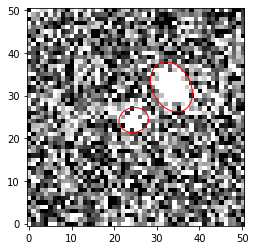

In [265]:
blend_id26 = np.where(flags26 == 1)[0][28]
fig3 = plt.figure()
runner26.plot_sex_obj(sep_res26[blend_id26], blended_26[blend_id26]['galsim_image_noisy'])
fig3.savefig('blend26.png')   # save the figure to file

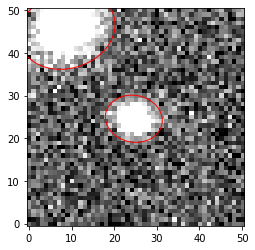

In [272]:
no_blend_id26 = np.where(flags26 == 0)[0][4]
runner26.plot_sex_obj(sep_res26[no_blend_id26], blended_26[no_blend_id26]['galsim_image_noisy'])